In [29]:
import csv
import pandas as pd
import hickle as hkl
import numpy as np
import scipy.sparse as sp
import sklearn.preprocessing as sk
from sklearn.feature_selection import VarianceThreshold

from torch.utils.data import TensorDataset, random_split, DataLoader,Dataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

from torch_geometric.data import Batch   

import torch

import random,os

from sklearn.metrics import roc_auc_score,precision_recall_curve

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MyDataset(Dataset):
    def __init__(self, input_df1,input_df2):
        super(MyDataset, self).__init__()
        self.input_df1 = input_df1
        self.input_df2 = input_df2
        
    def __len__(self):
        return len(self.input_df1)

    def __getitem__(self, index):
        return (self.input_df1['drug'][index], self.input_df1['ids'][index], self.input_df1['expres'][index],self.input_df2['ids'][index], self.input_df2['expres'][index],self.input_df1['IC50'][index])

class MyDataset_simple(Dataset):
    def __init__(self, input_df1,input_df2):
        super(MyDataset_simple, self).__init__()
        self.input_df1 = input_df1
        self.input_df2 = input_df2
        
    def __len__(self):
        return len(self.input_df1)

    def __getitem__(self, index):
        return (self.input_df1['drug'][index], self.input_df1['expres'][index],self.input_df2['expres'][index],self.input_df1['IC50'][index])


def _collate(samples):
    drugs, ids_gexpr, expres_gexpr, ids_methyl, expres_methyl,labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(ids_gexpr), torch.tensor(expres_gexpr), torch.tensor(ids_methyl), torch.tensor(expres_methyl),torch.tensor(labels)

def collate_simple(samples):
    drugs, expres_gexpr, expres_methyl,labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(expres_gexpr), torch.tensor(expres_methyl),torch.tensor(labels)


def get_gnn_dataloader(df_gexpr,df_methyl, batch_size=64, simple = False):
    if simple:
        dataset = MyDataset_simple(df_gexpr,df_methyl)
        collate_fn = collate_simple

    else:
        dataset = MyDataset(df_gexpr,df_methyl)
        collate_fn = _collate
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    
    return dataloader

def get_gnn_input_df(data_idx,drug_dict,data_feature,over_under_ids_df,over_under_genes_df):
    
    #data_feature.index = data_feature.index.astype(str)
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    df['drug'] = 0; 
    #all_drugs = set(df['drug id'])
    for drug_id in drug_dict.keys():
        new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(data_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #data_feature[idx,:] = data_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = data_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_drug_cell_info(Drug_info_file,Drug_feature_file,Gene_expression_file,Methylation_file, cancer_response_exp_file,
                       threshold = 6.3, norm = False, small_genes = False):
                   
    #drug_id --> pubchem_id
    reader = csv.reader(open(Drug_info_file,'r'))
    rows = [item for item in reader]
    drugid2pubchemid = {item[0]:item[6] for item in rows if item[6].isdigit()}
       

    # load drug features
    drug_pubchem_id_set = []
    drug_feature = {}
    
    for each in os.listdir(Drug_feature_file):
        drug_pubchem_id_set.append(each.split('.')[0])
        feat_mat,adj_list,degree_list = hkl.load('%s/%s'%(Drug_feature_file,each))
        drug_feature[each.split('.')[0]] = [feat_mat,adj_list,degree_list]
    assert len(drug_pubchem_id_set)==len(drug_feature.values())
    

    gexpr_feature = pd.read_csv(Gene_expression_file,sep=',',header=0,index_col=[0])

    if norm:
        scalerGDSC = sk.StandardScaler()
        scalerGDSC.fit(gexpr_feature.values)
        gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
                                     index = gexpr_feature.index,
                                     columns = gexpr_feature.columns)
    methyl_feature = pd.read_csv(Methylation_file,sep=',',header=0,index_col=[0])

    if norm:
        scalerGDSC = sk.StandardScaler()
        scalerGDSC.fit(methyl_feature.values)
        methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
                                     index = methyl_feature.index,
                                     columns = methyl_feature.columns)
                                     
    assert methyl_feature.shape[0]==gexpr_feature.shape[0]

    gexpr_feature.columns = gexpr_feature.columns.astype(str)
    methyl_feature.columns = methyl_feature.columns.astype(str)

    experiment_data = pd.read_csv(cancer_response_exp_file,sep=',',header=0,index_col=[0],engine='python')
    

    for i in range(len(experiment_data.columns)):
        experiment_data.rename(columns={experiment_data.columns[i]:'DATA.'+str(experiment_data.columns[i])},inplace=True)


    
    return drugid2pubchemid, drug_pubchem_id_set, gexpr_feature, methyl_feature, drug_feature, experiment_data
    
def get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data,binary=False):
    
    #filter experiment data
    drug_match_list=[item for item in experiment_data.index if item.split(':')[1] in drugid2pubchemid.keys()]
    experiment_data_filtered = experiment_data.loc[drug_match_list]
     
    data_idx = []
    for each_drug in experiment_data_filtered.index:
        for each_cellline in experiment_data_filtered.columns:
            pubchem_id = drugid2pubchemid[each_drug.split(':')[-1]]
            if str(pubchem_id) in drug_pubchem_id_set and each_cellline:
                if not np.isnan(experiment_data_filtered.loc[each_drug,each_cellline]) and each_cellline in gexpr_feature.index:
                    ln_IC50 = float(experiment_data_filtered.loc[each_drug,each_cellline])
                    data_idx.append((each_cellline,pubchem_id,ln_IC50)) 
    nb_celllines = len(set([item[0] for item in data_idx]))
    nb_drugs = len(set([item[1] for item in data_idx]))
    print('%d instances across %d cell lines and %d drugs were generated.'
          %(len(data_idx),nb_celllines,nb_drugs))
        
    return data_idx

def get_input_df(data_idx,drug_feature,gexpr_feature,over_under_ids_df,over_under_genes_df):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    
    drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
    for drug_id in drug_feature.keys():
        feat_mat,adj_list,_ = drug_feature[drug_id]
        drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
    
    df['drug1'] = 0; df['drug2'] = 0; 
    
    for drug_id in drug_df.index:
        new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(gexpr_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #gexpr_data[idx,:] = gexpr_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_simple_input_df(data_idx,drug_feature,gexpr_feature,drug_dict = {}):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    if len(drug_dict):
        df['drug'] = 0; 
        
        for drug_id in drug_dict.keys():
            new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
            df.update(new_df)
    else:
        drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
        
        for drug_id in drug_feature.keys():
            feat_mat,adj_list,_ = drug_feature[drug_id]
            drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
        
        df['drug1'] = 0; df['drug2'] = 0; 
        
        for drug_id in drug_df.index:
            new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
            new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
        
    df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    cell_df = pd.DataFrame(index = cell_ids, columns = ['expres'])
    for cell_id in cell_ids:
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df


def get_dataloader(drug_ids,sample_ids,input_df_gexpr,input_df_methyl,simple = False, batch_size=64, val_ratio=None, test_ratio = None):
    df_gexpr = input_df_gexpr
    if sample_ids:
        df_gexpr = df_gexpr[df_gexpr['cell id'].isin(sample_ids)]
    if drug_ids:
        df_gexpr = df_gexpr[df_gexpr['drug id'].isin(drug_ids)]
    df_methyl = input_df_methyl
    if sample_ids:
        df_methyl = df_methyl[df_methyl['cell id'].isin(sample_ids)]
    if drug_ids:
        df_methyl = df_methyl[df_methyl['drug id'].isin(drug_ids)]

    X_drug_feat_data = [item for item in df_gexpr['drug1']]
    X_drug_adj_data = [item for item in df_gexpr['drug2']]
    X_drug_feat_data = np.array(X_drug_feat_data)#nb_instance * Max_stom * feat_dim
    X_drug_adj_data = np.array(X_drug_adj_data)#nb_instance * Max_stom * Max_stom
    
    X_drug_feat_data = torch.Tensor(X_drug_feat_data)
    X_drug_adj_data = torch.Tensor(X_drug_adj_data)
    
    
    X_gexpr_data = [item for item in df_gexpr['expres']]
    X_gexpr_data = torch.Tensor(X_gexpr_data)
    X_methyl_data = [item for item in df_methyl['expres']]
    X_methyl_data = torch.Tensor(X_methyl_data) 

    Y = [item for item in df_gexpr['IC50']]
    Y = torch.Tensor(Y)
    
    if not simple:
        X_genes_data_gexpr = [item for item in df_gexpr['ids']]
        X_genes_data_gexpr = torch.Tensor(X_genes_data_gexpr)
        X_genes_data_gexpr = X_genes_data_gexpr.type(torch.int64)
        X_genes_data_methyl = [item for item in df_methyl['ids']]
        X_genes_data_methyl = torch.Tensor(X_genes_data_methyl)
        X_genes_data_methyl = X_genes_data_methyl.type(torch.int64)
        
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data_gexpr,X_gexpr_data,X_genes_data_methyl,X_methyl_data,Y)
    else:
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data_gexpr,X_gexpr_data,X_genes_data_methyl,X_methyl_data,Y)
    if val_ratio:
        
        if test_ratio:
            test_size = int(test_ratio * len(dataset))
            train_size = len(dataset) - test_size
            dataset, test_dataset = random_split(dataset, [train_size, test_size])
            test_dataloader = DataLoader(
                        test_dataset, # The validation samples.
                        sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                        batch_size = batch_size # Evaluate with this batch size.
                    )
            
        val_size = int(val_ratio * len(dataset))
        train_size = len(dataset) - val_size
            
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = batch_size # Evaluate with this batch size.
                )
        
    else:
        train_dataloader = DataLoader(
                    dataset,  # The training samples.
                    sampler = RandomSampler(dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
    if test_ratio:
        return train_dataloader, validation_dataloader, test_dataloader
    elif val_ratio:
        return train_dataloader, validation_dataloader
    else:
        return train_dataloader

def show_picture(train,val, test, title, path='' ,save=False):
    plt.plot(train)
    plt.plot(val)
    plt.plot(test)
    plt.legend(['train','val','test'])
    plt.title(title)
    if save:
        plt.savefig(path+title+'.png')
    
    plt.show()
    
def get_rand_genes(tokenizer, x_samples, nGenes, gexpr_feature):
    gexpr = gexpr_feature.loc[x_samples]
    genes = gexpr_feature.columns.values
    rand_genes = [random.choices(population=genes, k=nGenes) for i in range(gexpr.shape[0])]
    rand_ids = torch.tensor([tokenizer.convert_symb_to_id(genes) for genes in rand_genes])
    rand_exprs  = torch.tensor([gexpr.iloc[i][rand_genes[i]].values for i in range(len(rand_genes))])
    
    return rand_ids,rand_exprs

Max_atoms = 100

def NormalizeAdj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0).toarray()
    a_norm = adj.dot(d).transpose().dot(d)
    return a_norm

def random_adjacency_matrix(n):   
    matrix = [[random.randint(0, 1) for i in range(n)] for j in range(n)]
    # No vertex connects to itself
    for i in range(n):
        matrix[i][i] = 0
    # If i is connected to j, j is connected to i
    for i in range(n):
        for j in range(n):
            matrix[j][i] = matrix[i][j]
    return matrix

def CalculateGraphFeat(feat_mat,adj_list):
    assert feat_mat.shape[0] == len(adj_list)
    feat = np.zeros((Max_atoms,feat_mat.shape[-1]),dtype='float32')
    adj_mat = np.zeros((Max_atoms,Max_atoms),dtype='float32')
    if True:
        feat = np.random.rand(Max_atoms,feat_mat.shape[-1])
        adj_mat[feat_mat.shape[0]:,feat_mat.shape[0]:] = random_adjacency_matrix(Max_atoms-feat_mat.shape[0])        
    feat[:feat_mat.shape[0],:] = feat_mat
    for i in range(len(adj_list)):
        nodes = adj_list[i]
        for each in nodes:
            adj_mat[i,int(each)] = 1
    assert np.allclose(adj_mat,adj_mat.T)
    adj_ = adj_mat[:len(adj_list),:len(adj_list)]
    adj_2 = adj_mat[len(adj_list):,len(adj_list):]
    norm_adj_ = NormalizeAdj(adj_)
    norm_adj_2 = NormalizeAdj(adj_2)
    adj_mat[:len(adj_list),:len(adj_list)] = norm_adj_
    adj_mat[len(adj_list):,len(adj_list):] = norm_adj_2    
    return [feat,adj_mat]


def metrics_graph(yt, yp):
    precision, recall, _, = precision_recall_curve(yt, yp)
    aupr = -np.trapz(precision, recall)
    auc = roc_auc_score(yt, yp)
    #---f1,acc,recall, specificity, precision
    real_score=np.mat(yt)
    predict_score=np.mat(yp)
    sorted_predict_score = np.array(sorted(list(set(np.array(predict_score).flatten()))))
    sorted_predict_score_num = len(sorted_predict_score)
    thresholds = sorted_predict_score[np.int32(sorted_predict_score_num * np.arange(1, 1000) / 1000)]
    thresholds = np.mat(thresholds)
    thresholds_num = thresholds.shape[1]
    predict_score_matrix = np.tile(predict_score, (thresholds_num, 1))
    negative_index = np.where(predict_score_matrix < thresholds.T)
    positive_index = np.where(predict_score_matrix >= thresholds.T)
    predict_score_matrix[negative_index] = 0
    predict_score_matrix[positive_index] = 1
    TP = predict_score_matrix.dot(real_score.T)
    FP = predict_score_matrix.sum(axis=1) - TP
    FN = real_score.sum() - TP
    TN = len(real_score.T) - TP - FP - FN
    tpr = TP / (TP + FN)
    recall_list = tpr
    precision_list = TP / (TP + FP)
    f1_score_list = 2 * TP / (len(real_score.T) + TP - TN)
    accuracy_list = (TP + TN) / len(real_score.T)
    specificity_list = TN / (TN + FP)
    max_index = np.argmax(f1_score_list)
    f1_score = f1_score_list[max_index]
    accuracy = accuracy_list[max_index]
    specificity = specificity_list[max_index]
    recall = recall_list[max_index]
    precision = precision_list[max_index]
    return auc, aupr, f1_score[0, 0], accuracy[0, 0], recall[0, 0], specificity[0, 0], precision[0, 0]

def get_binary_gene_set(tokenizer, gexpr_feature, nGenes, random_genes = True, num_augment = 1):
    abs_gexpr = np.abs(gexpr_feature-np.mean(gexpr_feature))
    
    all_genes = list(gexpr_feature.columns)
    
    over_under_genes_list = [[] for i in range(num_augment)]
    over_under_ids_list = [[] for i in range(num_augment)]
    
    for i in range(abs_gexpr.shape[0]):
        
        for j in range(num_augment):
            if j ==0 or not(random_genes):
                genes = abs_gexpr.iloc[i].sort_values(ascending = False)[nGenes*j:nGenes*(j+1)].index
            else:
                genes = random.sample(all_genes, nGenes)
                
            ids = tokenizer.convert_symb_to_id(genes)
            
            over_under_ids_list[j].append(ids)
            over_under_genes_list[j].append(genes)
    
    over_under_ids_df_list = [pd.DataFrame(data = over_under_ids_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    over_under_genes_df_list = [pd.DataFrame(data = over_under_genes_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    return over_under_ids_df_list, over_under_genes_df_list


def get_gene_set(tokenizer, gexpr_feature, methyl_feature,nGenes, random_genes = True):
    scalerGDSC = sk.StandardScaler()
    scalerGDSC.fit(methyl_feature.values)
    methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
                                    index = methyl_feature.index,
                                    columns = methyl_feature.columns)

    scalerGDSC = sk.StandardScaler()
    scalerGDSC.fit(gexpr_feature.values)
    gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
                                    index = gexpr_feature.index,
                                    columns = gexpr_feature.columns)
    
    over_under_genes = []
    over_under_ids = []
    
    #all_genes = list(gexpr_feature.columns)
    
    for i in range(gexpr_feature.shape[0]):
        #genes = random.sample(all_genes, nGenes)
        genes = (methyl_feature * gexpr_feature).iloc[i].sort_values(ascending = True)[:nGenes].index
        ids = tokenizer.convert_symb_to_id(genes)
        
        over_under_ids.append(ids)
        over_under_genes.append(genes)
    
    over_under_ids_df_gexpr = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_gexpr = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)
    over_under_ids_df_methyl = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_methyl = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)

    return  over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl

In [28]:
import torch
import torch.nn as nn   

from torch_geometric.nn import GINConv, JumpingKnowledge, global_max_pool, GATConv

import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import math

from sklearn.utils import shuffle
import collections
import pandas as pd
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def batch_norm_init(m):
    if isinstance(m, nn.BatchNorm1d):
        m.reset_parameters()
        
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Gene_Embedding(nn.Module):
    def __init__(self, vocab_size= None,embed_size=None):
        super(Gene_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding_dim = embed_size
        self.eps = 1e-12
        
    def forward(self, genes=None,scales=None):
        x = self.embedding(genes)
        x = self.unit(x)
        x *= scales.unsqueeze(-1) 
        return x
        
    def unit(self,x):
        return (x+self.eps)/(torch.norm(x,dim=2).unsqueeze(-1)+self.eps)


class Tokenizer():
    def __init__(
        self, Gene_vocab, shuf= True, pad_token=0, sep_token=1, unk_token=2, cls_token=3, mask_token=4, **kwargs):
        super().__init__()
        self.Gene_vocab = Gene_vocab
        self.unk_token = unk_token
        self.sep_token = sep_token
        self.pad_token = pad_token
        self.cls_token = cls_token
        self.mask_token = mask_token
        self.shuf = shuf
        
        self.special_tokens = {'UNK':self.unk_token, 'SEP':self.sep_token, 
                               'PAD':self.pad_token, 'CLS':self.cls_token,
                               'MASK':self.mask_token}
        

        self.symb_to_id = collections.OrderedDict([(SYMBOL, ID) for SYMBOL,ID in self.Gene_vocab.values])
        
    @property
    def vocab_size(self):
        return len(self.Gene_vacab)

    def get_vocab(self):
        return self.Gene_vocab 
    
    def tokenize(self, sample):
        pathway = sample['pathway']
        sample_Id = sample['Id']
        genes_scales = pd.Series(data = sample['scales'],index = sample['genes'])
        genes = list(genes_scales.index.astype(str))
        scales = list(genes_scales.values)
        
        if self.shuf:
            genes,scales = shuffle(genes, scales)
                
        token = {"pathway":pathway,"sample_Id":sample_Id,
                 "genes":genes,"scales":scales}
        
        return token
    
    def check_unk(self,genes):
        genes = [gene if gene is not None else self.special_tokens['UNK'] for gene in genes]
        return genes
    
    def check_mis_scale(self,scales):
        scales = [scale if scale > 1e-12 else 1.0 for scale in scales]
        return scales
                
    def convert_symb_to_id(self, symbs):
        return [self.symb_to_id.get(symb) for symb in symbs]


    def convert_id_to_symb(self, indices):
        return [list(self.symb_to_id.keys())[list(self.symb_to_id.values()).index(index)] for index in indices]
    
    def encode(self, sample, add_special_tokens = True, 
               max_length = 128, pad_to_max_length = True,
               gene_type = 'SYMBOL'):
        
        token = self.tokenize(sample)

        token['genes'] = self.convert_symb_to_id(token['genes'])
        
        token['genes'] = self.check_unk(token['genes'])
        token['scales'] = self.check_mis_scale(token['scales'])
        
        if add_special_tokens:
            token['genes'] = [self.special_tokens['CLS']] + token['genes'] + [self.special_tokens['SEP']]
            token['scales'] = [1] + token['scales'] + [1] 
        
        if pad_to_max_length:
            token['genes'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['genes']))
            token['scales'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['scales']))
            
        return token
    
    def encode2torch(self, sample, add_special_tokens = True, 
                    max_length = 128, pad_to_max_length = True,
                    gene_type = 'SYMBOL'):
        
        token = self.encode(sample, add_special_tokens = add_special_tokens
                            ,gene_type = gene_type)
            
        token['genes'] = torch.tensor(token['genes'])
        token['scales'] = torch.tensor(token['scales'], dtype=torch.float)
            
        return token
    
    
    def encode_pair(self, sample1, sample2, add_special_tokens = True, 
                    max_len = 128, pad_to_max_length = True,
                    return_attention_mask = False,
                    gene_type = 'ENTREZID'):
        
        token1 = self.tokenize(sample1)
        token2 = self.tokenize(sample2)
        pair_token = {}
        

        token1['genes'] = self.convert_symb_to_id(token1['genes'])
        token2['genes'] = self.convert_symb_to_id(token2['genes'])
        
        token1['genes'] = self.check_unk(token1['genes'])
        token2['genes'] = self.check_unk(token2['genes'])
        
        token1['scales'] = self.check_mis_scale(token1['scales'])
        token2['scales'] = self.check_mis_scale(token2['scales'])
        
        if add_special_tokens:
            token1['genes'] = [self.special_tokens['CLS']] + token1['genes'] + [self.special_tokens['SEP']]
            token2['genes'] = token2['genes'] + [self.special_tokens['SEP']]
            
            token1['scales'] = [1] + token1['scales'] + [1]
            token2['scales'] = token2['scales'] + [1] 
            
        pair_token['genes'] = token1['genes'] + token2['genes'] 
        pair_token['scales'] = token1['scales'] + token2['scales']
            
        if pad_to_max_length:
            pair_token['genes'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['genes']))
            pair_token['scales'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['scales']))
            
        pair_token['genes'] = torch.tensor(pair_token['genes'])
        pair_token['scales'] = torch.tensor(pair_token['scales'], dtype=torch.float)
        pair_token['sample_Ids'] = (sample1['Id'],sample2['Id'])
        pair_token['pathways'] = (sample1['pathway'],sample2['pathway'])
        
        return pair_token
    

class GEN(torch.nn.Module):
    def __init__(self, y_dim = 256, dropout_ratio = 0.3,
                 gnn = None, embedding = None, encoder = None):
        super().__init__()
        self.encoder = encoder
        self.embedding = embedding 
        self.gnn = gnn 
        
        self.dropout_ratio = dropout_ratio
        self.y_dim = y_dim
    
        self.do = nn.Dropout(self.dropout_ratio)
        
        self.regression = nn.Sequential(
            nn.Linear(self.y_dim, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 1)
        )
        self.regression.apply(xavier_init)
        
        
    def forward(self,x_drug,x_gexpr, x_genes_gexpr,x_methyl, x_genes_methyl):
        x_d = self.gnn(x_drug)     
        x_g = self.embedding(x_genes_gexpr, x_gexpr)
        x_m = self.embedding(x_genes_methyl, x_methyl)
        
        x = self.encoder(x_g,x_m,x_d)
        
        y = self.regression(x)
        
        return y


class Att_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(Att_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        key = self.key_fc(x) #Q
        query = self.query_fc(x) #K
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        y = self.dropout(y)
        
        return y

class Transformer_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Transformer_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder
            
    def forward(self, g: torch.Tensor, m:torch.Tensor) -> torch.Tensor:
        x = torch.cat([g,m],dim=1)
        key = self.key_fc(x) 
        query = self.query_fc(x) 
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        
        if self.encoder is not None:
            y = self.encoder(y) + y
        
        return y

class MixedFC_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(MixedFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(genes,genes)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x)).permute(0,2,1)).permute(0,2,1))
        y = self.dropout(y)
        
        return y

class SimpleFC_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(SimpleFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x))))
        y = self.dropout(y)
        
        return y
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
            
class Co_Att_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Co_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)
        
        
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder        

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)


    def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        query_ge = self.query_ge_fc(x) #K
        key_ge = self.key_ge_fc(x) #Q
        value_ge = self.value_ge_fc(x)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(m) #Q
        value_me = self.value_me_fc(m)
        
        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        
        
        y = torch.cat([y_ge,y_me],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 


class Merged_Att_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Merged_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)
        
        
        self.layer_norm2 = nn.LayerNorm(genes*2)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder           

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)

    def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        co_x = torch.cat([x,m],dim=1)
        
        query_ge = self.query_ge_fc(x) #K
        key_ge = self.key_ge_fc(co_x) #Q
        value_ge = self.value_ge_fc(co_x)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(co_x) #Q
        value_me = self.value_me_fc(co_x)
        
        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        
        
        y = torch.cat([y_ge,y_me],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 
        
class Main_Encoder(nn.Module):
    def __init__(self, cell_encoder = None, d_dim = 128, 
                 genes=300, y_dim=512, dropout = 0.15):
        
        super(Main_Encoder, self).__init__()
        self.cell_encoder = cell_encoder
        
        self.feed1 = nn.Linear(d_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout = nn.Dropout(dropout)

        self.feed1.apply(xavier_init)
        self.feed2.apply(xavier_init)
        
    def forward(self, x_g: torch.Tensor,x_m:torch.Tensor, x_d: torch.Tensor) -> torch.Tensor:
        x1 = self.cell_encoder(x_g,x_m)
        y1, _ = torch.max(x1, dim= 1)  # [batchsize, embeddings_dim]
        
        y2 = self.feed2(self.activation(self.feed1(x_d)))
        
        y = torch.cat([y1,y2],dim = 1)
        y = self.dropout(self.layer_norm1(y))
        
        return y
    
class GEN_WO_GeneVec(torch.nn.Module):
    def __init__(self,gcn = None, gexpr_dim=100, dropout_drug = 0.1, dropout_cell = 0.1,
                 dropout_reg = 0.1, d_dim = 128*3, y_dim = 512):#
        super().__init__()
        self.d_dim = d_dim
        self.y_dim = y_dim
        self.gcn = gcn
        
        self.fc_d1 = nn.Linear(d_dim,y_dim)
        self.fc_d2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.fc_g1 = nn.Linear(gexpr_dim,y_dim)
        self.fc_g2 = nn.Linear(y_dim,y_dim)
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout_drug = nn.Dropout(dropout_drug)
        self.dropout_cell = nn.Dropout(dropout_cell)
        
        self.regression = nn.Sequential(
                nn.Linear(self.y_dim*2, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 1)
            )
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat)
        
        x = self.fc_d1(x)
        x = self.activation(x)
        x = self.dropout_drug(x)
        x = self.fc_d2(x)
        
        x_gexpr = self.fc_g1(x_gexpr)
        x_gexpr = self.activation(x_gexpr) 
        x_gexpr = self.dropout_cell(x_gexpr) 
        x_gexpr = self.fc_g2(x_gexpr)
        
        x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
        x = self.layer_norm1(x)
        
        y = self.regression(x)
        
        return y


class GNN_drug(torch.nn.Module):
    def __init__(self, layer_drug, dim_drug, do):
        super().__init__()
        self.layer_drug = layer_drug
        self.dim_drug = dim_drug
        self.JK = JumpingKnowledge('cat')
        self.convs_drug = torch.nn.ModuleList()
        self.bns_drug = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(do)
        
        for i in range(self.layer_drug):
            if i:
                block = nn.Sequential(nn.Linear(self.dim_drug, self.dim_drug), nn.ReLU(),
                                      nn.Linear(self.dim_drug, self.dim_drug))
            else:
                block = nn.Sequential(nn.Linear(77, self.dim_drug), nn.ReLU(), 
                                      nn.Linear(self.dim_drug, self.dim_drug))
            conv = GINConv(block)
            bn = torch.nn.BatchNorm1d(self.dim_drug)

            self.convs_drug.append(conv)
            self.bns_drug.append(bn)
            
        
        self.convs_drug.apply(xavier_init)
        self.bns_drug.apply(batch_norm_init)

    def forward(self, drug):
        x, edge_index, batch = drug.x, drug.edge_index, drug.batch
        x_drug_list = []
        for i in range(self.layer_drug):
            x = F.relu(self.convs_drug[i](x, edge_index))
            x = self.bns_drug[i](x)
            x_drug_list.append(x)

        node_representation = self.JK(x_drug_list)
        x_drug = global_max_pool(node_representation, batch)
        x_drug = self.dropout(x_drug)
        return x_drug


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self,in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        if self.bias is not None:
            support += self.bias
        
        #output = torch.matmul(adj.permute(0,2,1), support)
        output = torch.matmul(adj, support)
        
        return output
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nhid)
        self.gc4 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        
        self.NEG_INF = -1e38

    def max_pooling(self,x, adj):
        node_num = x.shape[1]
        features = torch.unsqueeze(x,1).repeat(1, node_num, 1, 1) \
                    + torch.unsqueeze((1.0 - adj) * self.NEG_INF, -1)
        return torch.max(features,2)[0]
    
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc4(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = (torch.sum(x,dim=1)/x.shape[1])
        
        return x


class DeepCDR(torch.nn.Module):
    
    def __init__(self,gcn = None, use_mut=0,use_gexp=0,use_methy=0,gexpr_dim=100,regr=True,units_list=None,
                 use_relu=True,use_bn=True,use_GMP=True,dropout = 0.1, gnn_dim = 100, use_gin = False):#
        super().__init__()
        self.use_mut = use_mut
        self.use_gexp = use_gexp
        self.use_methy = use_methy
        self.regr = regr
        self.gnn_dim = gnn_dim
        self.use_gin = use_gin
        
        self.gcn = gcn#GCN(75, 256, 100, dropout) 
        self.fc_g1 = nn.Linear(gexpr_dim,256)
        self.fc_g2 = nn.Linear(256,100)
        
        self.fc1 = nn.Linear((use_mut+use_gexp+use_methy)*100+self.gnn_dim,300)
        self.fc2 = nn.Linear(30,1)
        
        #self.fc_m1 = torch.nn.linear(methy_dim,256)
        #self.fc_m2 = torch.nn.linear(256,100)
        self.do = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn = nn.BatchNorm1d(256)
        
        self.conv1 = nn.Conv2d(1, 30, (150,1), stride=(1,1))
        self.conv2 = nn.Conv2d(30, 10, (5,1), stride=(1,1))
        self.conv3 = nn.Conv2d(10, 5, (5,1), stride=(1,1))
        
        self.max_pool1 = nn.MaxPool2d((2,1))
        self.max_pool2 = nn.MaxPool2d((3,1))
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat,x_adj)
        
        if self.use_gexp:
            x_gexpr = self.fc_g1(x_gexpr) #Dense(256)(gexpr_input)
            x_gexpr = self.tanh(x_gexpr) #Activation('tanh')(x_gexpr)
            x_gexpr = self.bn(x_gexpr) #BatchNormalization()(x_gexpr)
            x_gexpr = self.do(x_gexpr) #Dropout(0.1)(x_gexpr)
            x_gexpr = self.relu(self.fc_g2(x_gexpr)) #Dense(100,activation='relu')(x_gexpr)
            
            x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
            
        x = self.fc1(x)
        x = torch.unsqueeze(x,-1)
        x = torch.unsqueeze(x,1)

        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.dropout(x,0.1)
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(x,0.2)
        output = self.fc2(x)
        
        return output    

In [30]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from scipy.stats import pearsonr

import torch.nn as nn
import torch

from torch import optim
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error

cuda_condition = torch.cuda.is_available()
device = torch.device("cuda:6" if cuda_condition else "cpu")

gene_vocab = pd.read_csv('/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gene_vocabulary.csv',sep=',')
vocab_size = gene_vocab.shape[0]

# cuda_condition = torch.cuda.is_available()
# device = torch.device("cuda:3" if cuda_condition else "cpu")
tokenizer = Tokenizer(gene_vocab,shuf =True)

threshold = None
personalized_genes = False
random_genes = False

Trans_FC = False
Trans_MFC = False
Trans = True
FC = False
MFC = False

if Trans_FC:
    name = 'Trans_FC'
    C_EnC = 'SimpleFC'
    D_EnC = 'SimpleFC'
elif Trans_MFC:
    name = 'Trans_MFC'
    C_EnC = 'MixedFC'
    D_EnC = 'MixedFC'
elif Trans:
    name = 'Trans'
    C_EnC = None
    D_EnC = None
elif MFC:
    name = 'MixedFC'
elif FC:
    name = 'Simple_FC'


nb_epoch=250

gnn_dropout = 0.3
att_dropout = 0.3
fc_dropout = 0.3

nGenes = 300
lr = 0.0001
embed_size = 128
batch_size = 128

heads = 1
layer_drug = 3
dim_drug = 128
nhid = layer_drug*dim_drug

att_dim = 512

#dataset = 'CTRP'
dataset = 'CCLE'
#dataset = 'GDSC'

name += '_'+dataset

title = name+'_Adim_'+str(att_dim)+'_Ddim_'+str(dim_drug)+'_nGenes_'+str(nGenes)+'_GNN_do'+str(gnn_dropout)+'_att_do_'+str(att_dropout)+'_lr_'+str(lr)

if dataset == 'GDSC':
    Gene_expression_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_gexpression.csv'
    Methylation_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_methylation_987cell.csv'
    Drug_info_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_drug_information.csv'
    Drug_feature_file = '/NAS_Storage3/zoo00/DeepCDR/GDSC/drug_graph_feat'
    cancer_response_exp_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC2_ic50.csv'

    drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature, _, experiment_data \
                                                    = get_drug_cell_info(Drug_info_file,Drug_feature_file,
                                                                         Gene_expression_file,Methylation_file,cancer_response_exp_file,
                                                                         norm = True)

    data_idx = get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data)

    drug_dict = np.load('/NAS_Storage3/zoo00/DeepCDR/data/GDSC_drug_feature_graph.npy', allow_pickle=True).item()
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
    gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
    methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]

    over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
       
    input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
    input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)
    input_df_gexpr = input_df_gexpr[input_df_gexpr['drug id'] != '84691']
    input_df_methyl = input_df_methyl[input_df_methyl['drug id'] != '84691']

else: 
    if dataset == 'CCLE':
        nb_epoch = 200
        gexpr_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gexpr.csv",index_col = 0)
        methyl_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_methylation.csv",index_col=0)
        gexpr_feature = gexpr_feature.T
        methyl_feature=methyl_feature.T
        assert methyl_feature.shape[0]==gexpr_feature.shape[0]

        methyl_feature = methyl_feature.loc[list(gexpr_feature.index)]
        common = methyl_feature.columns.intersection(gexpr_feature.columns)
        methyl_feature =methyl_feature[common]
        gexpr_feature = gexpr_feature[common]

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(gexpr_feature.values)
        # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
        #                              index = gexpr_feature.index,
        #                              columns = gexpr_feature.columns)

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(methyl_feature.values)
        # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
        #                              index = methyl_feature.index,
        #                              columns = methyl_feature.columns)

        data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)
        data_idx = data_idx.dropna(axis=0)

        drug_dict = np.load("/NAS_Storage3/zoo00/GEN/CCLE/drug_feature_graph.npy", allow_pickle=True).item()

        drug_name = list(drug_dict.keys())
        data_idx = data_idx[data_idx['drug_name'].isin(drug_name)==True]
        data_idx = data_idx.values
        
        nb_celllines = len(set([item[0] for item in data_idx]))
        nb_drugs = len(set([item[1] for item in data_idx]))
        print('%d instances across %d cell lines and %d drugs were generated.'
            %(len(data_idx),nb_celllines,nb_drugs))

        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
        gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
        methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]


        over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
        input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
        input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)



/tmp/ipykernel_6350/1036227381.py:132: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)


111632 instances across 456 cell lines and 288 drugs were generated.


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.186315894126892
The overall Pearson's correlation is 0.5753.
Train avg_loss:  1.1852025
Train avg_pcc:  0.4998999304158851
Train r2:  0.10308526145148855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.4327397
Validation avg_pcc:  0.8461996212483247
Validation r2:  0.6847219667929174
Best Val r2  0.6847219667929174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.44415665
Test avg_pcc:  0.8400700505557803
Test r2:  0.6667175041523854
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.7482324838638306
The overall Pearson's correlation is 0.7171.
Train avg_loss:  0.6842177
Train avg_pcc:  0.7173783409207333
Train r2:  0.48221089185860644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3636014
Validation avg_pcc:  0.869369770175312
Validation r2:  0.7350935617125937
Best Val r2  0.7350935617125937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.37819925
Test avg_pcc:  0.8617434416132618
Test r2:  0.7162100399272182
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6386103630065918
The overall Pearson's correlation is 0.7905.
Train avg_loss:  0.56186706
Train avg_pcc:  0.7684778530910035
Train r2:  0.574801035771819


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33021906
Validation avg_pcc:  0.8777210358438272
Validation r2:  0.7594146899033768
Best Val r2  0.7594146899033768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.336219
Test avg_pcc:  0.8713036504599584
Test r2:  0.7477108142990432
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4673144221305847
The overall Pearson's correlation is 0.8387.
Train avg_loss:  0.48789144
Train avg_pcc:  0.7992649782883181
Train r2:  0.6307828507445193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33528343
Validation avg_pcc:  0.881054190269027
Validation r2:  0.7557249839172157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3408235
Test avg_pcc:  0.8761902898243966
Test r2:  0.7442557324535626
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.43575894832611084
The overall Pearson's correlation is 0.8495.
Train avg_loss:  0.4404307
Train avg_pcc:  0.8191942090158177
Train r2:  0.6666993235645396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3068219
Validation avg_pcc:  0.8857028621223005
Validation r2:  0.7764609948571165
Best Val r2  0.7764609948571165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3125909
Test avg_pcc:  0.8805311743376286
Test r2:  0.7654406934438176
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2717450261116028
The overall Pearson's correlation is 0.9033.
Train avg_loss:  0.4025444
Train avg_pcc:  0.8351553326964438
Train r2:  0.6953701671161201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30786166
Validation avg_pcc:  0.8872134781874161
Validation r2:  0.7757034621509179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31198415
Test avg_pcc:  0.8828681992780398
Test r2:  0.7658959789807818
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36762771010398865
The overall Pearson's correlation is 0.8867.
Train avg_loss:  0.3755653
Train avg_pcc:  0.8466412043931363
Train r2:  0.7157868845260031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31210425
Validation avg_pcc:  0.8886484999153035
Validation r2:  0.7726124498892066


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31286886
Test avg_pcc:  0.8841549490315521
Test r2:  0.7652320992917906
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3172597885131836
The overall Pearson's correlation is 0.8697.
Train avg_loss:  0.35534346
Train avg_pcc:  0.8553645620098534
Train r2:  0.7310899889758242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29230976
Validation avg_pcc:  0.8899862125896532
Validation r2:  0.7870339685367823
Best Val r2  0.7870339685367823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29495347
Test avg_pcc:  0.8862770152738249
Test r2:  0.77867531907504
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3359827995300293
The overall Pearson's correlation is 0.8260.
Train avg_loss:  0.34179643
Train avg_pcc:  0.8611518667295633
Train r2:  0.7413418621517607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28900328
Validation avg_pcc:  0.8918140219803772
Validation r2:  0.7894429929229444
Best Val r2  0.7894429929229444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29135826
Test avg_pcc:  0.8878696365147911
Test r2:  0.7813730305188968
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2984418272972107
The overall Pearson's correlation is 0.8667.
Train avg_loss:  0.3313684
Train avg_pcc:  0.8656565959505418
Train r2:  0.7492334032484458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29506636
Validation avg_pcc:  0.8921246947159513
Validation r2:  0.7850256516535657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30141944
Test avg_pcc:  0.8870010316718866
Test r2:  0.7738234326844121
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29834139347076416
The overall Pearson's correlation is 0.8999.
Train avg_loss:  0.32206622
Train avg_pcc:  0.8696803006171334
Train r2:  0.7562729245821734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28275043
Validation avg_pcc:  0.8933958612884408
Validation r2:  0.7939985570068074
Best Val r2  0.7939985570068074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2869983
Test avg_pcc:  0.8887857483191872
Test r2:  0.7846446519345389
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24445074796676636
The overall Pearson's correlation is 0.8846.
Train avg_loss:  0.31457976
Train avg_pcc:  0.8729170771584472
Train r2:  0.7619383353332428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2837915
Validation avg_pcc:  0.8930846775675625
Validation r2:  0.793240082434525


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28779387
Test avg_pcc:  0.8885243240445189
Test r2:  0.7840476663482618
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.40364891290664673
The overall Pearson's correlation is 0.8663.
Train avg_loss:  0.3092942
Train avg_pcc:  0.8751947084105698
Train r2:  0.7659382836004094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29159403
Validation avg_pcc:  0.8941268868239411
Validation r2:  0.7875554501579846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29427737
Test avg_pcc:  0.890240926508902
Test r2:  0.7791826227074579
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27855008840560913
The overall Pearson's correlation is 0.8863.
Train avg_loss:  0.3029796
Train avg_pcc:  0.8779183933985139
Train r2:  0.770716928403292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29803702
Validation avg_pcc:  0.8949815878169405
Validation r2:  0.782861316347153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30287394
Test avg_pcc:  0.890480275916822
Test r2:  0.772732016424174
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24403917789459229
The overall Pearson's correlation is 0.9132.
Train avg_loss:  0.30060557
Train avg_pcc:  0.8789380533956304
Train r2:  0.7725134860697881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28913358
Validation avg_pcc:  0.8969562055144674
Validation r2:  0.7893480510917216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29662725
Test avg_pcc:  0.89165108516907
Test r2:  0.7774193595706728
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.376611590385437
The overall Pearson's correlation is 0.8477.
Train avg_loss:  0.29656863
Train avg_pcc:  0.8806744137912518
Train r2:  0.7755684875889222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2705346
Validation avg_pcc:  0.8986706005155823
Validation r2:  0.8028985755620599
Best Val r2  0.8028985755620599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2734285
Test avg_pcc:  0.8939298532969143
Test r2:  0.794827045706063
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2673940062522888
The overall Pearson's correlation is 0.8971.
Train avg_loss:  0.29323158
Train avg_pcc:  0.8821062201366973
Train r2:  0.7780938416836551


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28077608
Validation avg_pcc:  0.8988361424448759
Validation r2:  0.7954369895454125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28973225
Test avg_pcc:  0.8927204135955319
Test r2:  0.7825931574694258
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2979099750518799
The overall Pearson's correlation is 0.8906.
Train avg_loss:  0.28945926
Train avg_pcc:  0.8837207061339756
Train r2:  0.7809485609833499


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2846102
Validation avg_pcc:  0.8992341064352143
Validation r2:  0.7926436011625272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.288619
Test avg_pcc:  0.8949198571398229
Test r2:  0.783428497833826
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2769879400730133
The overall Pearson's correlation is 0.8986.
Train avg_loss:  0.2858932
Train avg_pcc:  0.8852466120552569
Train r2:  0.783647220778188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26039046
Validation avg_pcc:  0.9016640252500407
Validation r2:  0.8102891984048531
Best Val r2  0.8102891984048531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26553327
Test avg_pcc:  0.8967845692639796
Test r2:  0.800751375565486
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2744526267051697
The overall Pearson's correlation is 0.8896.
Train avg_loss:  0.27957577
Train avg_pcc:  0.8879438797375174
Train r2:  0.7884280170913527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26681784
Validation avg_pcc:  0.9028547862616535
Validation r2:  0.8056064387830781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2709899
Test avg_pcc:  0.8987167260865419
Test r2:  0.7966568857800234
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3016718029975891
The overall Pearson's correlation is 0.8776.
Train avg_loss:  0.27579778
Train avg_pcc:  0.8895504913498955
Train r2:  0.791287045524975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2587614
Validation avg_pcc:  0.9039772559184045
Validation r2:  0.8114760813511956
Best Val r2  0.8114760813511956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.266387
Test avg_pcc:  0.8985672043856308
Test r2:  0.8001107671210438
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2635378837585449
The overall Pearson's correlation is 0.8736.
Train avg_loss:  0.27028477
Train avg_pcc:  0.8918899875724436
Train r2:  0.7954590549713005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25817886
Validation avg_pcc:  0.9054928101435546
Validation r2:  0.8119004950832578
Best Val r2  0.8119004950832578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26440954
Test avg_pcc:  0.9005879691197625
Test r2:  0.8015945934317752
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2223079353570938
The overall Pearson's correlation is 0.9064.
Train avg_loss:  0.26852012
Train avg_pcc:  0.8926428452723285
Train r2:  0.7967945100695588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2742254
Validation avg_pcc:  0.9052319922931024
Validation r2:  0.8002095789147516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27986398
Test avg_pcc:  0.9009177251292217
Test r2:  0.7899980229104268
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3018853962421417
The overall Pearson's correlation is 0.8810.
Train avg_loss:  0.2658523
Train avg_pcc:  0.8937707840310664
Train r2:  0.7988133881339107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24427459
Validation avg_pcc:  0.9067405623367849
Validation r2:  0.8220306136628424
Best Val r2  0.8220306136628424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2479409
Test avg_pcc:  0.9022522585464768
Test r2:  0.8139522067224538
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30279743671417236
The overall Pearson's correlation is 0.8663.
Train avg_loss:  0.26297638
Train avg_pcc:  0.8949863244793496
Train r2:  0.8009897744410617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2557755
Validation avg_pcc:  0.9080582851258204
Validation r2:  0.8136514875539627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2639921
Test avg_pcc:  0.9026061146467976
Test r2:  0.8019078407174903
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2659829556941986
The overall Pearson's correlation is 0.8768.
Train avg_loss:  0.2606983
Train avg_pcc:  0.8959531907661732
Train r2:  0.8027137386440654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24170299
Validation avg_pcc:  0.908813028609891
Validation r2:  0.8239041796780356
Best Val r2  0.8239041796780356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24988939
Test avg_pcc:  0.9028748952635974
Test r2:  0.8124901098955236
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2078477293252945
The overall Pearson's correlation is 0.8879.
Train avg_loss:  0.25835472
Train avg_pcc:  0.8969374928780509
Train r2:  0.8044872430469185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2593876
Validation avg_pcc:  0.9080667607032832
Validation r2:  0.8110198238380457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2677016
Test avg_pcc:  0.9026568928212372
Test r2:  0.7991243441807225
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25875353813171387
The overall Pearson's correlation is 0.8944.
Train avg_loss:  0.2556785
Train avg_pcc:  0.898065810685384
Train r2:  0.806512516760658


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24672449
Validation avg_pcc:  0.9093440973016007
Validation r2:  0.8202457130427264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2525176
Test avg_pcc:  0.9045884242383267
Test r2:  0.8105179554358534
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23126816749572754
The overall Pearson's correlation is 0.8762.
Train avg_loss:  0.25503907
Train avg_pcc:  0.8983374665527808
Train r2:  0.8069964363455645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24162607
Validation avg_pcc:  0.9094397326600097
Validation r2:  0.8239602517905094
Best Val r2  0.8239602517905094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2482476
Test avg_pcc:  0.904287067551578
Test r2:  0.8137220645966659
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23455910384655
The overall Pearson's correlation is 0.9199.
Train avg_loss:  0.2526482
Train avg_pcc:  0.8993409223926074
Train r2:  0.8088057357625195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24611168
Validation avg_pcc:  0.9095755799665038
Validation r2:  0.8206921853587019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25125825
Test avg_pcc:  0.9050510112418969
Test r2:  0.8114629550103616
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31169676780700684
The overall Pearson's correlation is 0.8806.
Train avg_loss:  0.25203517
Train avg_pcc:  0.8996024864103165
Train r2:  0.8092696486400095


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2359091
Validation avg_pcc:  0.9100606551626297
Validation r2:  0.8281254073620926
Best Val r2  0.8281254073620926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23887645
Test avg_pcc:  0.9060591573597163
Test r2:  0.8207538999155879
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18853759765625
The overall Pearson's correlation is 0.9242.
Train avg_loss:  0.25039965
Train avg_pcc:  0.9002861520772127
Train r2:  0.8105073568933951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23846461
Validation avg_pcc:  0.9105598430631529
Validation r2:  0.8262635659411355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24325489
Test avg_pcc:  0.9062512187688322
Test r2:  0.8174684534859389
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.256670206785202
The overall Pearson's correlation is 0.9231.
Train avg_loss:  0.24871756
Train avg_pcc:  0.9009937641518538
Train r2:  0.811780292086287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2377224
Validation avg_pcc:  0.9098812781905885
Validation r2:  0.8268043019956031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24444431
Test avg_pcc:  0.9045155489494711
Test r2:  0.8165759353729751
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29971933364868164
The overall Pearson's correlation is 0.8432.
Train avg_loss:  0.24765097
Train avg_pcc:  0.9014425011460282
Train r2:  0.8125874531337676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23590982
Validation avg_pcc:  0.9107623881549509
Validation r2:  0.8281249063989733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24088198
Test avg_pcc:  0.906155481404521
Test r2:  0.8192490259772439
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2661578059196472
The overall Pearson's correlation is 0.8652.
Train avg_loss:  0.24744666
Train avg_pcc:  0.9015273858755419
Train r2:  0.8127420412533501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23461843
Validation avg_pcc:  0.910860438963954
Validation r2:  0.8290657453800787
Best Val r2  0.8290657453800787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23894013
Test avg_pcc:  0.9063461100678435
Test r2:  0.8207061307779102
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23917743563652039
The overall Pearson's correlation is 0.9207.
Train avg_loss:  0.24463718
Train avg_pcc:  0.9027047483340483
Train r2:  0.8148681838148264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2436466
Validation avg_pcc:  0.9115416985807996
Validation r2:  0.8224881597787016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25055727
Test avg_pcc:  0.906556574480717
Test r2:  0.8119889457771556
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2172674834728241
The overall Pearson's correlation is 0.9168.
Train avg_loss:  0.24403223
Train avg_pcc:  0.9029593056502829
Train r2:  0.8153259508904576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23197855
Validation avg_pcc:  0.9127256109939579
Validation r2:  0.8309890574288532
Best Val r2  0.8309890574288532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2374102
Test avg_pcc:  0.908093207198801
Test r2:  0.8218541323371584
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23677687346935272
The overall Pearson's correlation is 0.9216.
Train avg_loss:  0.24243088
Train avg_pcc:  0.9036290080290426
Train r2:  0.8165378205311413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23944849
Validation avg_pcc:  0.9117577769672818
Validation r2:  0.8255467440147175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2443363
Test avg_pcc:  0.9073109409523108
Test r2:  0.8166569780969757
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2995692193508148
The overall Pearson's correlation is 0.8523.
Train avg_loss:  0.24034362
Train avg_pcc:  0.904503007688875
Train r2:  0.8181173756845337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23185962
Validation avg_pcc:  0.9127913920794981
Validation r2:  0.8310757047329052
Best Val r2  0.8310757047329052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23700885
Test avg_pcc:  0.9082132414518601
Test r2:  0.8221552938677824
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21372118592262268
The overall Pearson's correlation is 0.9205.
Train avg_loss:  0.2387887
Train avg_pcc:  0.9051546128254777
Train r2:  0.8192940655040989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23267438
Validation avg_pcc:  0.9130711244164991
Validation r2:  0.8304820913391461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23860177
Test avg_pcc:  0.9082371242196036
Test r2:  0.8209600042471195
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2201635092496872
The overall Pearson's correlation is 0.9219.
Train avg_loss:  0.2370417
Train avg_pcc:  0.905882015376693
Train r2:  0.8206161267262388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22741191
Validation avg_pcc:  0.9137350690508868
Validation r2:  0.8343161543857538
Best Val r2  0.8343161543857538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23142554
Test avg_pcc:  0.9093541929977029
Test r2:  0.8263448441687594
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29784563183784485
The overall Pearson's correlation is 0.9017.
Train avg_loss:  0.23570882
Train avg_pcc:  0.906440017614926
Train r2:  0.8216248088170682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22846837
Validation avg_pcc:  0.9141909052367722
Validation r2:  0.8335464504140323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23591593
Test avg_pcc:  0.9087774541169419
Test r2:  0.8229754008205233
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24815350770950317
The overall Pearson's correlation is 0.8998.
Train avg_loss:  0.23463142
Train avg_pcc:  0.9068876110207997
Train r2:  0.8224401400000667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22702235
Validation avg_pcc:  0.9145543224971996
Validation r2:  0.8345999706092195
Best Val r2  0.8345999706092195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23275392
Test avg_pcc:  0.9097734677655381
Test r2:  0.8253480730264897
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27225983142852783
The overall Pearson's correlation is 0.9078.
Train avg_loss:  0.23259275
Train avg_pcc:  0.907739029244935
Train r2:  0.823982909042352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22557552
Validation avg_pcc:  0.9148716073836054
Validation r2:  0.8356540721437401
Best Val r2  0.8356540721437401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23137142
Test avg_pcc:  0.9100354451541404
Test r2:  0.8263854787774959
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22066661715507507
The overall Pearson's correlation is 0.8807.
Train avg_loss:  0.23056933
Train avg_pcc:  0.9085826835283637
Train r2:  0.8255141926643118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22988822
Validation avg_pcc:  0.9156163676638298
Validation r2:  0.8325120129630574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23646633
Test avg_pcc:  0.9107988400876311
Test r2:  0.8225623737555141
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2190309762954712
The overall Pearson's correlation is 0.9118.
Train avg_loss:  0.22833562
Train avg_pcc:  0.9095102667885422
Train r2:  0.8272045373873697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2267649
Validation avg_pcc:  0.9160457520655164
Validation r2:  0.8347875299765664


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23247641
Test avg_pcc:  0.911390678616156
Test r2:  0.8255563032843685
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2121720016002655
The overall Pearson's correlation is 0.9031.
Train avg_loss:  0.22611453
Train avg_pcc:  0.9104358115564929
Train r2:  0.8288854012592337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22230014
Validation avg_pcc:  0.9156867186343228
Validation r2:  0.8380403887550794
Best Val r2  0.8380403887550794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22403406
Test avg_pcc:  0.9124486886688005
Test r2:  0.831891218238365
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27158230543136597
The overall Pearson's correlation is 0.9037.
Train avg_loss:  0.22459446
Train avg_pcc:  0.9110668170849329
Train r2:  0.8300357201506112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22030939
Validation avg_pcc:  0.9163265598549672
Validation r2:  0.8394907698093372
Best Val r2  0.8394907698093372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2237253
Test avg_pcc:  0.9124169916852489
Test r2:  0.8321228928698964
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18973343074321747
The overall Pearson's correlation is 0.9185.
Train avg_loss:  0.22318871
Train avg_pcc:  0.91164922082633
Train r2:  0.8310995262274409


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22588374
Validation avg_pcc:  0.915065948000201
Validation r2:  0.8354295204303788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2272503
Test avg_pcc:  0.911912881970994
Test r2:  0.8294778385278969
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18516898155212402
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.221738
Train avg_pcc:  0.9122521258221635
Train r2:  0.8321973851470899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22903939
Validation avg_pcc:  0.9159929612507016
Validation r2:  0.8331304370695939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23185387
Test avg_pcc:  0.9124473626255639
Test r2:  0.8260234393467545


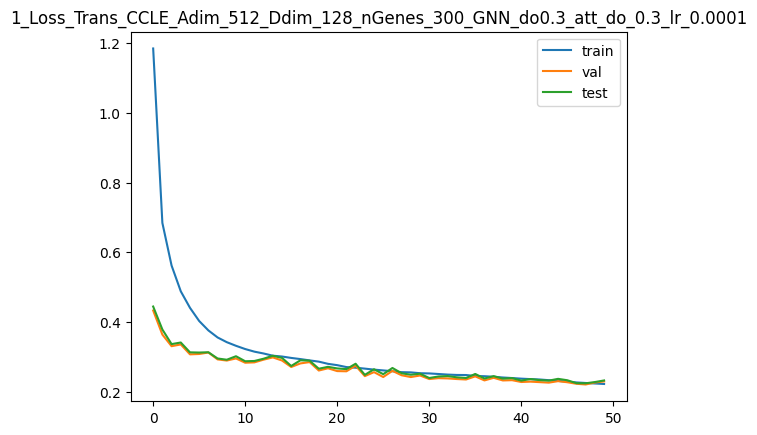

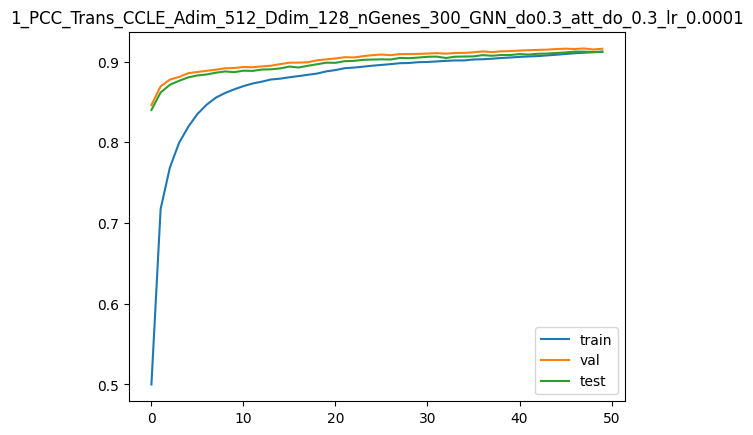

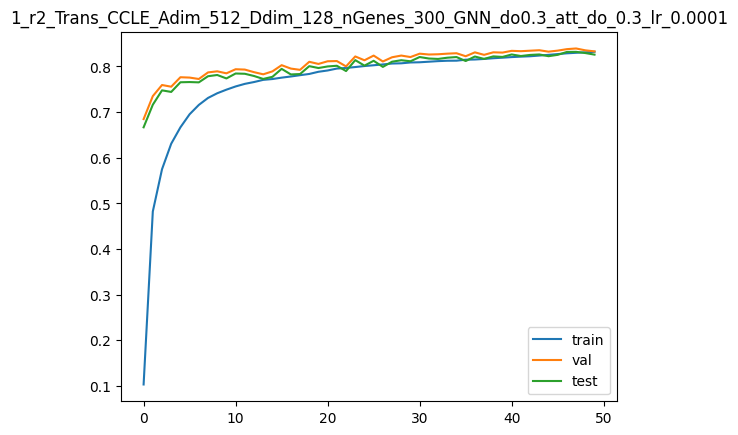

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20865900814533234
The overall Pearson's correlation is 0.9102.
Train avg_loss:  0.22036698
Train avg_pcc:  0.9128214980350555
Train r2:  0.8332348998884579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22485994
Validation avg_pcc:  0.9161327831190587
Validation r2:  0.836175419744348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22709493
Test avg_pcc:  0.9128991905512537
Test r2:  0.8295944222400526
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2197662591934204
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.21825473
Train avg_pcc:  0.9136955195097859
Train r2:  0.8348333666504044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2156889
Validation avg_pcc:  0.9182817338928662
Validation r2:  0.8428571030704657
Best Val r2  0.8428571030704657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21964753
Test avg_pcc:  0.9141954364242018
Test r2:  0.8351827330500523
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20413196086883545
The overall Pearson's correlation is 0.9010.
Train avg_loss:  0.21678133
Train avg_pcc:  0.9143044344356361
Train r2:  0.8359483855480083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21578284
Validation avg_pcc:  0.9197551324236778
Validation r2:  0.8427886608056119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22122489
Test avg_pcc:  0.9153400474486957
Test r2:  0.8339991310355721
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23021498322486877
The overall Pearson's correlation is 0.9246.
Train avg_loss:  0.2141848
Train avg_pcc:  0.9153790538863391
Train r2:  0.837913329499419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2196228
Validation avg_pcc:  0.9182380802427208
Validation r2:  0.8399910007707307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22168511
Test avg_pcc:  0.9151726233024778
Test r2:  0.8336537969445142
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19374805688858032
The overall Pearson's correlation is 0.9317.
Train avg_loss:  0.21396023
Train avg_pcc:  0.9154721732676747
Train r2:  0.8380832825337531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2202215
Validation avg_pcc:  0.9194847270242148
Validation r2:  0.8395548139607866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22372016
Test avg_pcc:  0.9159817387613177
Test r2:  0.8321267594330689
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18602877855300903
The overall Pearson's correlation is 0.9255.
Train avg_loss:  0.21074219
Train avg_pcc:  0.9168018332786655
Train r2:  0.8405185861901806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21145278
Validation avg_pcc:  0.9202504093259427
Validation r2:  0.8459433804905134
Best Val r2  0.8459433804905134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21537736
Test avg_pcc:  0.9163822797699375
Test r2:  0.8383869495842343
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17885145545005798
The overall Pearson's correlation is 0.9106.
Train avg_loss:  0.20959917
Train avg_pcc:  0.9172722009736232
Train r2:  0.8413835544478401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20947856
Validation avg_pcc:  0.9206690349305076
Validation r2:  0.8473817092522571
Best Val r2  0.8473817092522571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21154879
Test avg_pcc:  0.9173076941118311
Test r2:  0.8412598068520049
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2199466973543167
The overall Pearson's correlation is 0.9270.
Train avg_loss:  0.20861062
Train avg_pcc:  0.9176811132653871
Train r2:  0.8421316545301832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20796837
Validation avg_pcc:  0.9215171003280878
Validation r2:  0.848481994776178
Best Val r2  0.848481994776178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21069525
Test avg_pcc:  0.9181177104918362
Test r2:  0.8419002782226975
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22440151870250702
The overall Pearson's correlation is 0.9165.
Train avg_loss:  0.20656306
Train avg_pcc:  0.9185240679704507
Train r2:  0.843681165380972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21075296
Validation avg_pcc:  0.9219380221574178
Validation r2:  0.8464532393924056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21390739
Test avg_pcc:  0.9185151042235621
Test r2:  0.8394899821709637
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18299813568592072
The overall Pearson's correlation is 0.9148.
Train avg_loss:  0.20588396
Train avg_pcc:  0.9188041021485835
Train r2:  0.8441950718289264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21408315
Validation avg_pcc:  0.9216228446573108
Validation r2:  0.8440269960492126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2155105
Test avg_pcc:  0.9189679772477348
Test r2:  0.8382870367763112
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23669983446598053
The overall Pearson's correlation is 0.9241.
Train avg_loss:  0.2026974
Train avg_pcc:  0.9201148497832259
Train r2:  0.8466065396190389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20870191
Validation avg_pcc:  0.9227975495954559
Validation r2:  0.8479475544141954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21110393
Test avg_pcc:  0.9197365480289251
Test r2:  0.8415936211002681
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2847294807434082
The overall Pearson's correlation is 0.9232.
Train avg_loss:  0.20237231
Train avg_pcc:  0.9202494933037946
Train r2:  0.8468525620052705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20476247
Validation avg_pcc:  0.9229270398498021
Validation r2:  0.8508176702815082
Best Val r2  0.8508176702815082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20681535
Test avg_pcc:  0.9199473114486405
Test r2:  0.8448116423542639
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2657567858695984
The overall Pearson's correlation is 0.8879.
Train avg_loss:  0.20056917
Train avg_pcc:  0.9209906749279059
Train r2:  0.8482171037455528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19883218
Validation avg_pcc:  0.9248583413015498
Validation r2:  0.8551382746119803
Best Val r2  0.8551382746119803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20189165
Test avg_pcc:  0.9212069345667809
Test r2:  0.8485062499123903
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1907479465007782
The overall Pearson's correlation is 0.9289.
Train avg_loss:  0.19926834
Train avg_pcc:  0.9215237256777696
Train r2:  0.8492015262988164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19948873
Validation avg_pcc:  0.924664349913757
Validation r2:  0.8546599305236922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20193487
Test avg_pcc:  0.9214619369786453
Test r2:  0.848473813104972
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22084762156009674
The overall Pearson's correlation is 0.8971.
Train avg_loss:  0.19645816
Train avg_pcc:  0.9226773746589813
Train r2:  0.8513281476567828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20112722
Validation avg_pcc:  0.9250231534750464
Validation r2:  0.8534661894059484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20415002
Test avg_pcc:  0.9217058438662421
Test r2:  0.8468116177452677
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19409188628196716
The overall Pearson's correlation is 0.9376.
Train avg_loss:  0.19637407
Train avg_pcc:  0.9227113091365171
Train r2:  0.8513918139823422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19854665
Validation avg_pcc:  0.9257376866181544
Validation r2:  0.8553463085911973
Best Val r2  0.8553463085911973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20092215
Test avg_pcc:  0.9226803727259955
Test r2:  0.8492337382292912
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24018222093582153
The overall Pearson's correlation is 0.9011.
Train avg_loss:  0.19441019
Train avg_pcc:  0.9235170649072395
Train r2:  0.8528779884098532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19723776
Validation avg_pcc:  0.9256710251132182
Validation r2:  0.8562999132497952
Best Val r2  0.8562999132497952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19958192
Test avg_pcc:  0.9225435677874876
Test r2:  0.8502394141090928
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17582246661186218
The overall Pearson's correlation is 0.9465.
Train avg_loss:  0.19415604
Train avg_pcc:  0.923620069528225
Train r2:  0.8530703227566702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19815917
Validation avg_pcc:  0.9262603301370547
Validation r2:  0.8556286037459033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19957015
Test avg_pcc:  0.9235790225999707
Test r2:  0.8502482395933746
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2177598625421524
The overall Pearson's correlation is 0.9280.
Train avg_loss:  0.19222489
Train avg_pcc:  0.9244121530513038
Train r2:  0.8545317257688687


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19652072
Validation avg_pcc:  0.926065306100734
Validation r2:  0.8568223220775257
Best Val r2  0.8568223220775257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19787915
Test avg_pcc:  0.9230824192844052
Test r2:  0.8515171011994094
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21329843997955322
The overall Pearson's correlation is 0.9197.
Train avg_loss:  0.19058652
Train avg_pcc:  0.9250817198316916
Train r2:  0.8557715940222758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20168331
Validation avg_pcc:  0.9256841848504058
Validation r2:  0.8530610533748807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20054269
Test avg_pcc:  0.9241402999046311
Test r2:  0.8495184603130097
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17375272512435913
The overall Pearson's correlation is 0.9303.
Train avg_loss:  0.18904023
Train avg_pcc:  0.9257141949789386
Train r2:  0.8569417660401605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19782832
Validation avg_pcc:  0.9253408057459394
Validation r2:  0.855869652908604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19752757
Test avg_pcc:  0.9232676667871657
Test r2:  0.8517809285050056
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23899754881858826
The overall Pearson's correlation is 0.8812.
Train avg_loss:  0.18848164
Train avg_pcc:  0.9259422632660528
Train r2:  0.8573644706048705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19491038
Validation avg_pcc:  0.9272613951585282
Validation r2:  0.8579955555466292
Best Val r2  0.8579955555466292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19714147
Test avg_pcc:  0.9242268467925694
Test r2:  0.8520706496419083
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2165280282497406
The overall Pearson's correlation is 0.9007.
Train avg_loss:  0.18644077
Train avg_pcc:  0.9267759705778266
Train r2:  0.8589089231650665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19508857
Validation avg_pcc:  0.9271962791254273
Validation r2:  0.8578657403295059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19654638
Test avg_pcc:  0.9244376431194777
Test r2:  0.852517172117338
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.133226215839386
The overall Pearson's correlation is 0.9344.
Train avg_loss:  0.18517283
Train avg_pcc:  0.9272936719291122
Train r2:  0.8598684622528875


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1935956
Validation avg_pcc:  0.9270501608702439
Validation r2:  0.8589534527716121
Best Val r2  0.8589534527716121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19384956
Test avg_pcc:  0.924671568032343
Test r2:  0.8545408104085739
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23542536795139313
The overall Pearson's correlation is 0.9243.
Train avg_loss:  0.18466428
Train avg_pcc:  0.9275001467340194
Train r2:  0.8602533111500089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1928741
Validation avg_pcc:  0.9273505294984292
Validation r2:  0.8594791149850858
Best Val r2  0.8594791149850858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19459242
Test avg_pcc:  0.9245280405955053
Test r2:  0.8539833869757967
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23523418605327606
The overall Pearson's correlation is 0.9140.
Train avg_loss:  0.18325888
Train avg_pcc:  0.9280737958799796
Train r2:  0.8613168679244768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19338687
Validation avg_pcc:  0.9284410630963457
Validation r2:  0.8591055244549616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19563214
Test avg_pcc:  0.9255155713696526
Test r2:  0.853203204221353
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19560527801513672
The overall Pearson's correlation is 0.9201.
Train avg_loss:  0.18198149
Train avg_pcc:  0.9285953481794922
Train r2:  0.8622835501089848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19181867
Validation avg_pcc:  0.927870887994887
Validation r2:  0.860248064406965
Best Val r2  0.860248064406965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19197582
Test avg_pcc:  0.9256456751986892
Test r2:  0.8559468076949742
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1565282940864563
The overall Pearson's correlation is 0.9468.
Train avg_loss:  0.18103895
Train avg_pcc:  0.9289781863626034
Train r2:  0.8629968180794785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18675576
Validation avg_pcc:  0.929797378855193
Validation r2:  0.8639367077289973
Best Val r2  0.8639367077289973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18739647
Test avg_pcc:  0.9274512348067081
Test r2:  0.8593830090278238
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15313395857810974
The overall Pearson's correlation is 0.9253.
Train avg_loss:  0.18029149
Train avg_pcc:  0.9292834543528038
Train r2:  0.8635624834769411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18898346
Validation avg_pcc:  0.9290949559258651
Validation r2:  0.8623136786154434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18973325
Test avg_pcc:  0.9267160476204582
Test r2:  0.857629564183594
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18845102190971375
The overall Pearson's correlation is 0.9313.
Train avg_loss:  0.1798319
Train avg_pcc:  0.9294703211784423
Train r2:  0.8639102574033442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18558736
Validation avg_pcc:  0.9301569515703803
Validation r2:  0.8647879658156161
Best Val r2  0.8647879658156161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18798834
Test avg_pcc:  0.927069920955981
Test r2:  0.8589388965194666
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1623038649559021
The overall Pearson's correlation is 0.9483.
Train avg_loss:  0.17837399
Train avg_pcc:  0.9300641868758859
Train r2:  0.8650135480952938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18822159
Validation avg_pcc:  0.9291819161572815
Validation r2:  0.8628687627910099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18809393
Test avg_pcc:  0.9270731788926034
Test r2:  0.8588596603508472
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.196588397026062
The overall Pearson's correlation is 0.9058.
Train avg_loss:  0.176291
Train avg_pcc:  0.9309101878864962
Train r2:  0.8665898589134524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1882515
Validation avg_pcc:  0.9293626799936522
Validation r2:  0.8628469674955863


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18839845
Test avg_pcc:  0.9272407641936601
Test r2:  0.8586311654424388
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18557345867156982
The overall Pearson's correlation is 0.9146.
Train avg_loss:  0.17768846
Train avg_pcc:  0.9303422099546623
Train r2:  0.8655323372411086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19131334
Validation avg_pcc:  0.9288383932023236
Validation r2:  0.8606162203222162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19233868
Test avg_pcc:  0.9264189630905383
Test r2:  0.8556745306096496
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16838647425174713
The overall Pearson's correlation is 0.9288.
Train avg_loss:  0.17650256
Train avg_pcc:  0.93082410146456
Train r2:  0.8664297961098714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18808173
Validation avg_pcc:  0.9297802490831172
Validation r2:  0.8629706439495113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1897811
Test avg_pcc:  0.9270901464672345
Test r2:  0.8575936670167653
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19191546738147736
The overall Pearson's correlation is 0.9185.
Train avg_loss:  0.17474428
Train avg_pcc:  0.9315395976823568
Train r2:  0.867760375375171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18616351
Validation avg_pcc:  0.9300649658031243
Validation r2:  0.8643681911823873


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1852012
Test avg_pcc:  0.928365278040642
Test r2:  0.8610302751889185
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20547553896903992
The overall Pearson's correlation is 0.9159.
Train avg_loss:  0.17315619
Train avg_pcc:  0.9321832168951741
Train r2:  0.8689621881750962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1857859
Validation avg_pcc:  0.9301737402187731
Validation r2:  0.8646433128621572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18588097
Test avg_pcc:  0.927949398055455
Test r2:  0.8605202054649093
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1626708209514618
The overall Pearson's correlation is 0.9403.
Train avg_loss:  0.17203029
Train avg_pcc:  0.9326406219186276
Train r2:  0.869814214033521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1840869
Validation avg_pcc:  0.9305824959978124
Validation r2:  0.8658811390330962
Best Val r2  0.8658811390330962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1846239
Test avg_pcc:  0.928189205413095
Test r2:  0.8614634887997763
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11718694120645523
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.17231776
Train avg_pcc:  0.9325242404379324
Train r2:  0.8695966734978483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18760434
Validation avg_pcc:  0.9292159724715128
Validation r2:  0.8633184745203742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18710762
Test avg_pcc:  0.9272174887646982
Test r2:  0.8595997835638893
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1129024550318718
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.17037538
Train avg_pcc:  0.9333113755167348
Train r2:  0.8710665940011386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18468963
Validation avg_pcc:  0.9304329319775397
Validation r2:  0.8654420221762669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18455008
Test avg_pcc:  0.9283918488995493
Test r2:  0.8615188679353734
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17920854687690735
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.16995254
Train avg_pcc:  0.9334833338194402
Train r2:  0.871386580918468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1850276
Validation avg_pcc:  0.930800753196123
Validation r2:  0.8651957832445373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1845339
Test avg_pcc:  0.9289874124723076
Test r2:  0.8615310171140113
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1900443732738495
The overall Pearson's correlation is 0.9318.
Train avg_loss:  0.16837817
Train avg_pcc:  0.9341206958246574
Train r2:  0.8725779938098489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18112454
Validation avg_pcc:  0.9318823127633945
Validation r2:  0.8680394140009946
Best Val r2  0.8680394140009946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18301326
Test avg_pcc:  0.929125158731215
Test r2:  0.8626720593843489
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1778091937303543
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.16751193
Train avg_pcc:  0.9344714888099904
Train r2:  0.8732335395240681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18188787
Validation avg_pcc:  0.9322205353874984
Validation r2:  0.867483266648498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18419908
Test avg_pcc:  0.9293814796880883
Test r2:  0.8617822551221946
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16069111227989197
The overall Pearson's correlation is 0.9478.
Train avg_loss:  0.1669811
Train avg_pcc:  0.9346872830581444
Train r2:  0.8736352429115453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18337661
Validation avg_pcc:  0.9310487660267336
Validation r2:  0.8663986366411607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18270797
Test avg_pcc:  0.9292634145957784
Test r2:  0.8629011376125122
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15700335800647736
The overall Pearson's correlation is 0.9240.
Train avg_loss:  0.16692643
Train avg_pcc:  0.934708680619251
Train r2:  0.8736766166235733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17920779
Validation avg_pcc:  0.9327184471465229
Validation r2:  0.8694358765942859
Best Val r2  0.8694358765942859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18140356
Test avg_pcc:  0.9298415971451398
Test r2:  0.8638799301708479
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14789587259292603
The overall Pearson's correlation is 0.9357.
Train avg_loss:  0.1655723
Train avg_pcc:  0.935257275514589
Train r2:  0.8747013718678127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18090233
Validation avg_pcc:  0.9319874377588666
Validation r2:  0.8682013060923108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18126261
Test avg_pcc:  0.9298071222314878
Test r2:  0.8639856891231468
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16494175791740417
The overall Pearson's correlation is 0.9137.
Train avg_loss:  0.16424972
Train avg_pcc:  0.9357912057021753
Train r2:  0.8757022380153117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1826589
Validation avg_pcc:  0.9322997595024748
Validation r2:  0.8669215288130219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18298724
Test avg_pcc:  0.9302284629571317
Test r2:  0.8626915864591642
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1747710108757019
The overall Pearson's correlation is 0.9278.
Train avg_loss:  0.16385996
Train avg_pcc:  0.9359496711971877
Train r2:  0.8759972076282814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17917883
Validation avg_pcc:  0.9325049421255247
Validation r2:  0.869456973657529
Best Val r2  0.869456973657529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18000017
Test avg_pcc:  0.9300995788129705
Test r2:  0.864932996952222
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14527016878128052
The overall Pearson's correlation is 0.9432.
Train avg_loss:  0.16328849
Train avg_pcc:  0.9361802423009483
Train r2:  0.8764296667827605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17904954
Validation avg_pcc:  0.9325996490309436
Validation r2:  0.8695511613979884
Best Val r2  0.8695511613979884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17962128
Test avg_pcc:  0.9303169459395153
Test r2:  0.8652172961504621
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1782565861940384
The overall Pearson's correlation is 0.9194.
Train avg_loss:  0.1620098
Train avg_pcc:  0.9366965781746215
Train r2:  0.8773973136121648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18102425
Validation avg_pcc:  0.9321228664333592
Validation r2:  0.8681124622470088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18112983
Test avg_pcc:  0.9300548478303872
Test r2:  0.8640853273933907
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17432081699371338
The overall Pearson's correlation is 0.9103.
Train avg_loss:  0.1616687
Train avg_pcc:  0.9368348711450688
Train r2:  0.8776554644584502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17771894
Validation avg_pcc:  0.9331006348687869
Validation r2:  0.870520607029535
Best Val r2  0.870520607029535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17992443
Test avg_pcc:  0.9301941206499029
Test r2:  0.8649898232352753


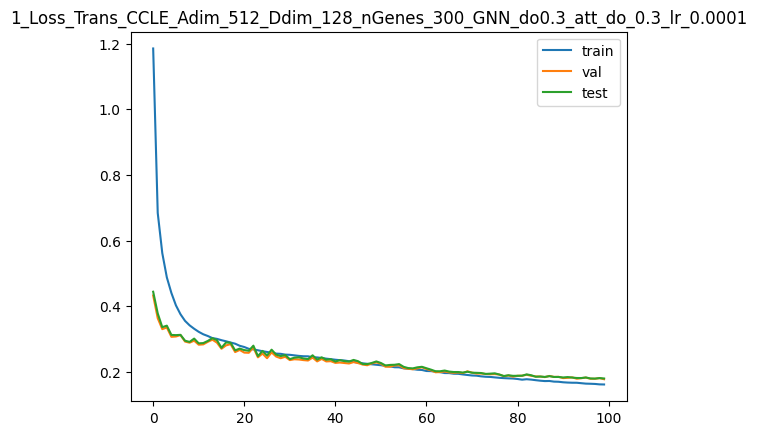

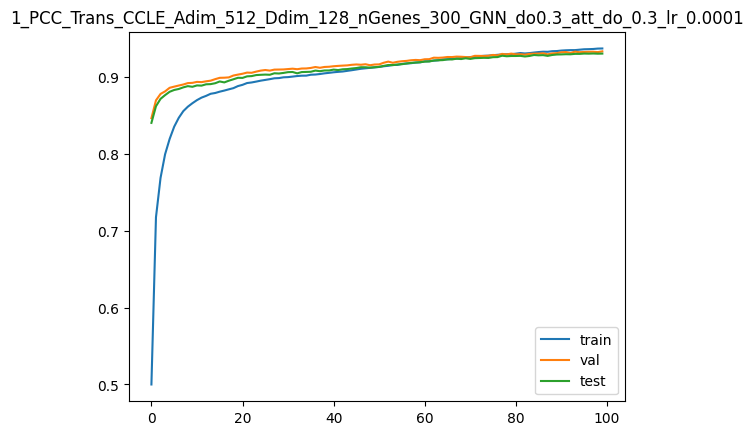

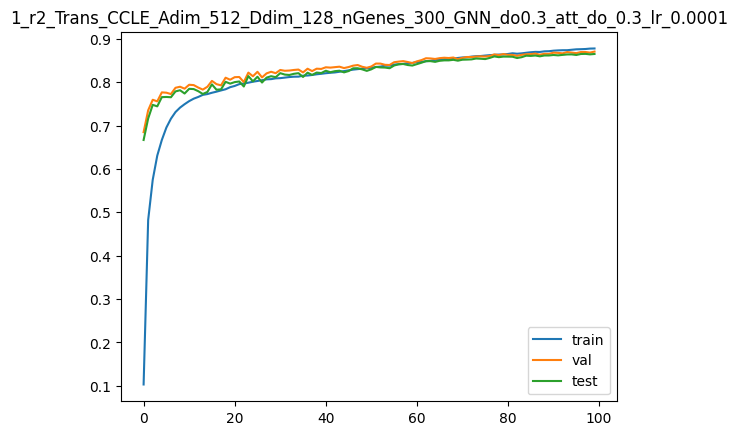

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10369136929512024
The overall Pearson's correlation is 0.9652.
Train avg_loss:  0.1601764
Train avg_pcc:  0.9374377112021129
Train r2:  0.8787847711669864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17754091
Validation avg_pcc:  0.9331800047554875
Validation r2:  0.8706502965195781
Best Val r2  0.8706502965195781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17876667
Test avg_pcc:  0.9306489549298496
Test r2:  0.8658585794393205
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1488712728023529
The overall Pearson's correlation is 0.9471.
Train avg_loss:  0.16086811
Train avg_pcc:  0.9371584832838891
Train r2:  0.8782613203503273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1778706
Validation avg_pcc:  0.9332090057032886
Validation r2:  0.8704101036579351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17943084
Test avg_pcc:  0.9305346532652344
Test r2:  0.8653602023649165
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18035650253295898
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.15801592
Train avg_pcc:  0.9383084798116497
Train r2:  0.8804197428719354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17984703
Validation avg_pcc:  0.933606533735102
Validation r2:  0.8689701508469618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18261328
Test avg_pcc:  0.930692293341025
Test r2:  0.8629721868741432
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1502736210823059
The overall Pearson's correlation is 0.9409.
Train avg_loss:  0.15712278
Train avg_pcc:  0.9386693132807478
Train r2:  0.8810956375377306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17704153
Validation avg_pcc:  0.9333207215025028
Validation r2:  0.8710141320609561
Best Val r2  0.8710141320609561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17799364
Test avg_pcc:  0.9308627006421649
Test r2:  0.8664386442439063
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14688649773597717
The overall Pearson's correlation is 0.9193.
Train avg_loss:  0.15784638
Train avg_pcc:  0.9383770730612161
Train r2:  0.8805480460554727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17761771
Validation avg_pcc:  0.9332369338903397
Validation r2:  0.870594340098782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17698096
Test avg_pcc:  0.9314840017342625
Test r2:  0.8671985270545958
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12439696490764618
The overall Pearson's correlation is 0.9500.
Train avg_loss:  0.15714225
Train avg_pcc:  0.9386611951901335
Train r2:  0.8810809120601804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17568853
Validation avg_pcc:  0.9339510206746818
Validation r2:  0.8719998809132831
Best Val r2  0.8719998809132831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17792234
Test avg_pcc:  0.9310833509040524
Test r2:  0.8664921355985578
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11504589021205902
The overall Pearson's correlation is 0.9526.
Train avg_loss:  0.15608652
Train avg_pcc:  0.9390869550076423
Train r2:  0.881879839270382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17595614
Validation avg_pcc:  0.9339901389456338
Validation r2:  0.8718049028698578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17853333
Test avg_pcc:  0.9309706900229593
Test r2:  0.8660336690796111
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14166897535324097
The overall Pearson's correlation is 0.9453.
Train avg_loss:  0.1562049
Train avg_pcc:  0.9390389241728924
Train r2:  0.8817902474356235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17552955
Validation avg_pcc:  0.9349981602538512
Validation r2:  0.8721157057724364
Best Val r2  0.8721157057724364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.177568
Test avg_pcc:  0.9322942466087647
Test r2:  0.86675802363718
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16148951649665833
The overall Pearson's correlation is 0.9419.
Train avg_loss:  0.1546809
Train avg_pcc:  0.9396523564658656
Train r2:  0.8829435464250327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17375366
Validation avg_pcc:  0.9353959336734587
Validation r2:  0.8734095429910649
Best Val r2  0.8734095429910649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17642325
Test avg_pcc:  0.9324453523666182
Test r2:  0.8676170194456996
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14606817066669464
The overall Pearson's correlation is 0.9585.
Train avg_loss:  0.15444466
Train avg_pcc:  0.9397480717945109
Train r2:  0.8831223356948739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17306966
Validation avg_pcc:  0.9352450084982229
Validation r2:  0.8739079014642629
Best Val r2  0.8739079014642629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17580044
Test avg_pcc:  0.9321878184863324
Test r2:  0.8680843486184853
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1688414216041565
The overall Pearson's correlation is 0.9382.
Train avg_loss:  0.15383677
Train avg_pcc:  0.9399925198540604
Train r2:  0.8835823567463148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17402591
Validation avg_pcc:  0.9346363380208009
Validation r2:  0.8732112093974767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17661783
Test avg_pcc:  0.9315813129631061
Test r2:  0.8674710061100337
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17172496020793915
The overall Pearson's correlation is 0.9143.
Train avg_loss:  0.15215026
Train avg_pcc:  0.9406714935110718
Train r2:  0.8848586318035044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17660412
Validation avg_pcc:  0.9334598514741035
Validation r2:  0.8713328124140529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17856303
Test avg_pcc:  0.9306210380441962
Test r2:  0.86601137577733
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21177177131175995
The overall Pearson's correlation is 0.9007.
Train avg_loss:  0.15247491
Train avg_pcc:  0.9405412104596628
Train r2:  0.8846129688227816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17131546
Validation avg_pcc:  0.9355172423947592
Validation r2:  0.8751859264622995
Best Val r2  0.8751859264622995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17391594
Test avg_pcc:  0.9324697299916236
Test r2:  0.8694984376321584
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13313418626785278
The overall Pearson's correlation is 0.9603.
Train avg_loss:  0.15074854
Train avg_pcc:  0.9412340351963798
Train r2:  0.8859194101358882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17332265
Validation avg_pcc:  0.9353223872107398
Validation r2:  0.8737235718913615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17522575
Test avg_pcc:  0.9326781103056003
Test r2:  0.8685155719466153
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13582664728164673
The overall Pearson's correlation is 0.9462.
Train avg_loss:  0.15019985
Train avg_pcc:  0.9414553902107136
Train r2:  0.8863346397136663


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17163399
Validation avg_pcc:  0.9354574398665698
Validation r2:  0.8749538747652739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17435943
Test avg_pcc:  0.93236556094297
Test r2:  0.8691656458051761
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15224440395832062
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.1498419
Train avg_pcc:  0.9415989396101996
Train r2:  0.8866055169964924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17185529
Validation avg_pcc:  0.9355146133484411
Validation r2:  0.8747926409703843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17307626
Test avg_pcc:  0.932975752134429
Test r2:  0.8701284986573772
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1420886218547821
The overall Pearson's correlation is 0.9500.
Train avg_loss:  0.14898725
Train avg_pcc:  0.9419426208971257
Train r2:  0.8872522869381202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17376448
Validation avg_pcc:  0.9358521239374364
Validation r2:  0.8734016715971502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17659447
Test avg_pcc:  0.9328659787477138
Test r2:  0.8674885392967665
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17972365021705627
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.14870727
Train avg_pcc:  0.9420551809763381
Train r2:  0.8874641593879008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1726937
Validation avg_pcc:  0.9353355161376109
Validation r2:  0.8741818003361582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17471503
Test avg_pcc:  0.9326143885527493
Test r2:  0.8688988272056397
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13758334517478943
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.14843531
Train avg_pcc:  0.9421638606452327
Train r2:  0.8876699599361829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17177567
Validation avg_pcc:  0.9360063353127173
Validation r2:  0.8748506375893492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17409497
Test avg_pcc:  0.9332442330205013
Test r2:  0.86936408989377
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.197503000497818
The overall Pearson's correlation is 0.9261.
Train avg_loss:  0.14814176
Train avg_pcc:  0.9422819655123958
Train r2:  0.8878921286270108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16970405
Validation avg_pcc:  0.9363499044232159
Validation r2:  0.8763599428053991
Best Val r2  0.8763599428053991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1719714
Test avg_pcc:  0.9334970526786293
Test r2:  0.8709575534300901
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11226988583803177
The overall Pearson's correlation is 0.9539.
Train avg_loss:  0.14734413
Train avg_pcc:  0.9426021704148178
Train r2:  0.8884957432483194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1701649
Validation avg_pcc:  0.9365149428234122
Validation r2:  0.8760241940289987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17195833
Test avg_pcc:  0.9338882864970552
Test r2:  0.8709673606445822
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1466635763645172
The overall Pearson's correlation is 0.9407.
Train avg_loss:  0.14601009
Train avg_pcc:  0.9431381104417411
Train r2:  0.8895052827577264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17036851
Validation avg_pcc:  0.9360913336648264
Validation r2:  0.8758758552251849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17070656
Test avg_pcc:  0.9340484184412514
Test r2:  0.8719066551737562
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13573765754699707
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.14606744
Train avg_pcc:  0.9431144988627008
Train r2:  0.8894618831127157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16915803
Validation avg_pcc:  0.9364824853495088
Validation r2:  0.8767577633622191
Best Val r2  0.8767577633622191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17216201
Test avg_pcc:  0.9333314009593531
Test r2:  0.8708145212817603
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1408921331167221
The overall Pearson's correlation is 0.9426.
Train avg_loss:  0.14537498
Train avg_pcc:  0.9433921484277531
Train r2:  0.8899858962860082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17442888
Validation avg_pcc:  0.9352119396402334
Validation r2:  0.8729176104167848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1764277
Test avg_pcc:  0.9324683724876222
Test r2:  0.8676136691837402
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1541212946176529
The overall Pearson's correlation is 0.9445.
Train avg_loss:  0.14459288
Train avg_pcc:  0.9437062632574716
Train r2:  0.8905777800617374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1685678
Validation avg_pcc:  0.9367713346837497
Validation r2:  0.8771877770609238
Best Val r2  0.8771877770609238


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17077348
Test avg_pcc:  0.9340089073056265
Test r2:  0.8718564477429163
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2093571424484253
The overall Pearson's correlation is 0.9229.
Train avg_loss:  0.14379929
Train avg_pcc:  0.9440248020886305
Train r2:  0.8911783401052124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1682349
Validation avg_pcc:  0.9368548145419147
Validation r2:  0.8774303172264785
Best Val r2  0.8774303172264785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1695406
Test avg_pcc:  0.9343880939080266
Test r2:  0.8727815533288393
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12112083286046982
The overall Pearson's correlation is 0.9439.
Train avg_loss:  0.14377964
Train avg_pcc:  0.9440322613797553
Train r2:  0.891193191072715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1676205
Validation avg_pcc:  0.9371750527516117
Validation r2:  0.8778779521220444
Best Val r2  0.8778779521220444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17119761
Test avg_pcc:  0.93385369347718
Test r2:  0.8715381858015279
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20845875144004822
The overall Pearson's correlation is 0.8784.
Train avg_loss:  0.14337693
Train avg_pcc:  0.9441932274112935
Train r2:  0.891497949539105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17208995
Validation avg_pcc:  0.9371159967688387
Validation r2:  0.8746216681637548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1750758
Test avg_pcc:  0.9340773171371257
Test r2:  0.8686280957472826
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14116181433200836
The overall Pearson's correlation is 0.9546.
Train avg_loss:  0.14190519
Train avg_pcc:  0.9447831085281406
Train r2:  0.892611723983059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16719933
Validation avg_pcc:  0.9378935262367157
Validation r2:  0.8781847899258969
Best Val r2  0.8781847899258969


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17050552
Test avg_pcc:  0.934735391643283
Test r2:  0.8720575136542389
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17860187590122223
The overall Pearson's correlation is 0.9289.
Train avg_loss:  0.14116609
Train avg_pcc:  0.945078747626025
Train r2:  0.8931710419838957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16647466
Validation avg_pcc:  0.937616064078383
Validation r2:  0.8787127650025288
Best Val r2  0.8787127650025288


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16922164
Test avg_pcc:  0.9346938802319681
Test r2:  0.8730209108448452
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18629923462867737
The overall Pearson's correlation is 0.9304.
Train avg_loss:  0.14025392
Train avg_pcc:  0.9454443651253152
Train r2:  0.893861331574363


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16835777
Validation avg_pcc:  0.9367266995831337
Validation r2:  0.8773407957447488


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16910024
Test avg_pcc:  0.9344705876714914
Test r2:  0.8731119989664639
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10769292712211609
The overall Pearson's correlation is 0.9678.
Train avg_loss:  0.14149438
Train avg_pcc:  0.9449476379260588
Train r2:  0.8929225945906577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1708003
Validation avg_pcc:  0.9363979179569575
Validation r2:  0.8755612687373335


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17179465
Test avg_pcc:  0.9340771105457766
Test r2:  0.8710901774957557
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13336440920829773
The overall Pearson's correlation is 0.9472.
Train avg_loss:  0.1400682
Train avg_pcc:  0.9455191482825469
Train r2:  0.8940018744702061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16511635
Validation avg_pcc:  0.9380385751695843
Validation r2:  0.879702367116624
Best Val r2  0.879702367116624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16761446
Test avg_pcc:  0.9351324202806155
Test r2:  0.8742268770328154
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17303434014320374
The overall Pearson's correlation is 0.9331.
Train avg_loss:  0.13949904
Train avg_pcc:  0.9457456340030574
Train r2:  0.8944325923214735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16526708
Validation avg_pcc:  0.9379288622131272
Validation r2:  0.8795925685182742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16731739
Test avg_pcc:  0.9351839066808855
Test r2:  0.8744497934901071
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1747148633003235
The overall Pearson's correlation is 0.9319.
Train avg_loss:  0.1387867
Train avg_pcc:  0.9460319465423586
Train r2:  0.8949716564012373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16621815
Validation avg_pcc:  0.9382238653442722
Validation r2:  0.8788996492016905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16938445
Test avg_pcc:  0.9351753251719757
Test r2:  0.8728987256666612
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.174430251121521
The overall Pearson's correlation is 0.9265.
Train avg_loss:  0.1384038
Train avg_pcc:  0.9461840800628128
Train r2:  0.8952614267425283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16679351
Validation avg_pcc:  0.9375957904512867
Validation r2:  0.8784804567498586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16897237
Test avg_pcc:  0.9348419819953974
Test r2:  0.8732079396561183
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12290871143341064
The overall Pearson's correlation is 0.9496.
Train avg_loss:  0.13852386
Train avg_pcc:  0.9461370163276125
Train r2:  0.8951705765470064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16692643
Validation avg_pcc:  0.9376781682958665
Validation r2:  0.8783836156225624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16656812
Test avg_pcc:  0.9359273164443503
Test r2:  0.8750120230339592
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14636333286762238
The overall Pearson's correlation is 0.9452.
Train avg_loss:  0.13754259
Train avg_pcc:  0.9465285677836557
Train r2:  0.8959131556217884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16791175
Validation avg_pcc:  0.9368460530799325
Validation r2:  0.8776657330916352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16772962
Test avg_pcc:  0.9349704431297079
Test r2:  0.8741404620656222
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12512347102165222
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.13749301
Train avg_pcc:  0.9465484891737427
Train r2:  0.8959506730379854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16925228
Validation avg_pcc:  0.9371645158208113
Validation r2:  0.8766890920517769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17048979
Test avg_pcc:  0.934815040705427
Test r2:  0.8720693223032727
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1921214461326599
The overall Pearson's correlation is 0.9041.
Train avg_loss:  0.13681245
Train avg_pcc:  0.9468204251002313
Train r2:  0.8964656982715065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16658568
Validation avg_pcc:  0.9374565014315467
Validation r2:  0.8786318651443789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16864489
Test avg_pcc:  0.9347175951699653
Test r2:  0.8734536661735688
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11276127398014069
The overall Pearson's correlation is 0.9572.
Train avg_loss:  0.13672693
Train avg_pcc:  0.9468554696909967
Train r2:  0.8965304113647454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16561836
Validation avg_pcc:  0.9380548604393438
Validation r2:  0.8793366194412079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16736382
Test avg_pcc:  0.9353747219938308
Test r2:  0.8744149572174525
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.113365039229393
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.1360374
Train avg_pcc:  0.9471294169757417
Train r2:  0.8970522227060627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1689196
Validation avg_pcc:  0.937521677372543
Validation r2:  0.8769314779243169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16976169
Test avg_pcc:  0.9353200874484106
Test r2:  0.8726156624435077
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11865046620368958
The overall Pearson's correlation is 0.9445.
Train avg_loss:  0.13468379
Train avg_pcc:  0.9476711340078209
Train r2:  0.898076577237616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16506392
Validation avg_pcc:  0.9380526814991691
Validation r2:  0.8797405730894277
Best Val r2  0.8797405730894277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16712297
Test avg_pcc:  0.9352704314353679
Test r2:  0.8745956643276938
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12105513364076614
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.13509364
Train avg_pcc:  0.9475074645854904
Train r2:  0.8977664247611983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16488591
Validation avg_pcc:  0.9385016320969028
Validation r2:  0.8798702561044776
Best Val r2  0.8798702561044776


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16671668
Test avg_pcc:  0.9359525342473551
Test r2:  0.8749005422426763
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1243201345205307
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.13416934
Train avg_pcc:  0.9478754976379941
Train r2:  0.8984658993327668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16520493
Validation avg_pcc:  0.9382027890053177
Validation r2:  0.8796378552545043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16820203
Test avg_pcc:  0.9351156445863379
Test r2:  0.8737859873901279
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17718267440795898
The overall Pearson's correlation is 0.9073.
Train avg_loss:  0.1337511
Train avg_pcc:  0.9480432283950841
Train r2:  0.8987824021079156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16937551
Validation avg_pcc:  0.936326025894907
Validation r2:  0.8765993085053139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16932763
Test avg_pcc:  0.9343408795268714
Test r2:  0.8729413682537859
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12982983887195587
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.13285588
Train avg_pcc:  0.9484010109853408
Train r2:  0.8994598831372553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16404933
Validation avg_pcc:  0.938650946260053
Validation r2:  0.8804797710265537
Best Val r2  0.8804797710265537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1655574
Test avg_pcc:  0.9361967560420127
Test r2:  0.8757704400748525
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11257472634315491
The overall Pearson's correlation is 0.9541.
Train avg_loss:  0.13349082
Train avg_pcc:  0.9481470109279456
Train r2:  0.898979371863924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.163383
Validation avg_pcc:  0.9388574413820642
Validation r2:  0.8809652302336305
Best Val r2  0.8809652302336305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16521639
Test avg_pcc:  0.9362759458553471
Test r2:  0.8760263213091006
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13583381474018097
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.13239154
Train avg_pcc:  0.9485851933512335
Train r2:  0.8998112752734517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16290756
Validation avg_pcc:  0.9388478262114383
Validation r2:  0.8813116129609265
Best Val r2  0.8813116129609265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1639954
Test avg_pcc:  0.9365319565799347
Test r2:  0.8769425259503595
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1614682972431183
The overall Pearson's correlation is 0.9321.
Train avg_loss:  0.13207304
Train avg_pcc:  0.9487122892184167
Train r2:  0.900052296604785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16285752
Validation avg_pcc:  0.9391447876732797
Validation r2:  0.8813480877402
Best Val r2  0.8813480877402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16496326
Test avg_pcc:  0.9364594200931362
Test r2:  0.8762162563397039


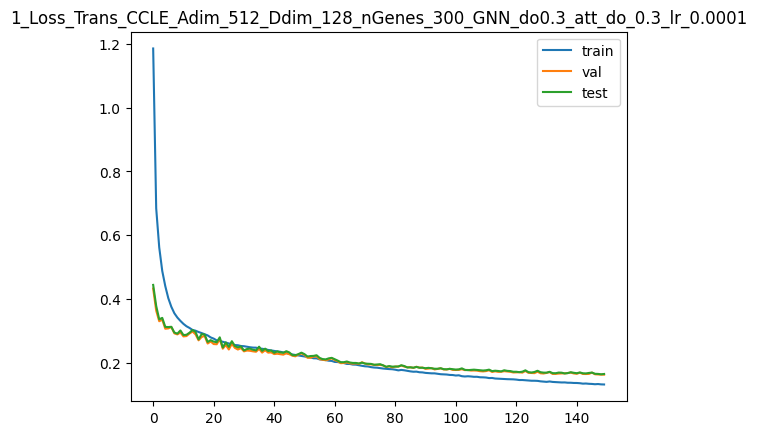

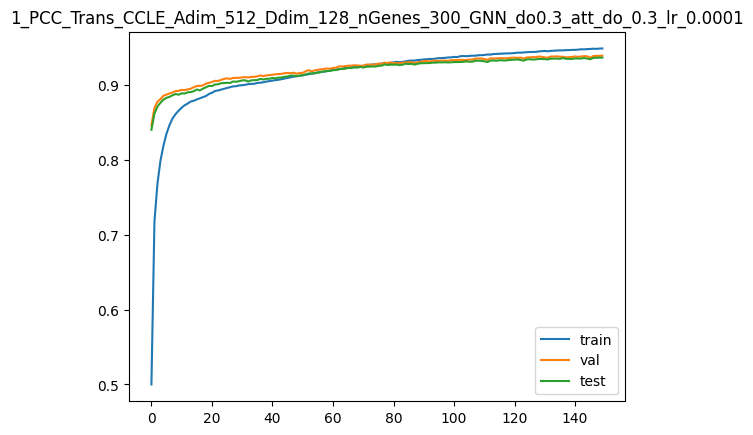

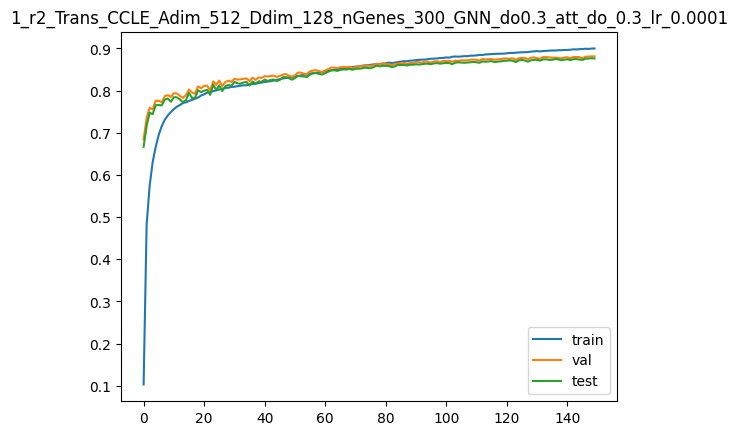

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12871041893959045
The overall Pearson's correlation is 0.9451.
Train avg_loss:  0.13109225
Train avg_pcc:  0.9491035501026562
Train r2:  0.9007945086723478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16185163
Validation avg_pcc:  0.9392591997760851
Validation r2:  0.8820809288011037
Best Val r2  0.8820809288011037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1634275
Test avg_pcc:  0.9367244393982413
Test r2:  0.8773686618983426
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14700905978679657
The overall Pearson's correlation is 0.9340.
Train avg_loss:  0.1301703
Train avg_pcc:  0.9494719104001191
Train r2:  0.9014922177298011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16501968
Validation avg_pcc:  0.9382550973664701
Validation r2:  0.8797728184171048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16647759
Test avg_pcc:  0.935809070770581
Test r2:  0.8750799616183247
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15223072469234467
The overall Pearson's correlation is 0.9438.
Train avg_loss:  0.13033982
Train avg_pcc:  0.9494030876057641
Train r2:  0.9013639226476952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16332448
Validation avg_pcc:  0.9391669442189887
Validation r2:  0.8810078750692757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16523696
Test avg_pcc:  0.9365717585382783
Test r2:  0.8760108863840057
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1169145330786705
The overall Pearson's correlation is 0.9497.
Train avg_loss:  0.12894775
Train avg_pcc:  0.9499582382815632
Train r2:  0.9024173953141816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16673175
Validation avg_pcc:  0.9386603778929088
Validation r2:  0.8785254573113337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1670344
Test avg_pcc:  0.9366524674958229
Test r2:  0.8746621402853593
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11064112186431885
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.12874886
Train avg_pcc:  0.9500373388959491
Train r2:  0.9025679070327959


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16231555
Validation avg_pcc:  0.9393006903422612
Validation r2:  0.8817429325564907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1642868
Test avg_pcc:  0.9366600418565221
Test r2:  0.8767238561280967
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13418994843959808
The overall Pearson's correlation is 0.9471.
Train avg_loss:  0.12896882
Train avg_pcc:  0.9499496038127893
Train r2:  0.9024014516533396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1631223
Validation avg_pcc:  0.9394214409203709
Validation r2:  0.8811551811627383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16671692
Test avg_pcc:  0.9361603570249872
Test r2:  0.8749003663544753
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14626780152320862
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.12836652
Train avg_pcc:  0.9501893835347901
Train r2:  0.9028572481053428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16037253
Validation avg_pcc:  0.9398363082561839
Validation r2:  0.8831585489146139
Best Val r2  0.8831585489146139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16396601
Test avg_pcc:  0.9365173819404564
Test r2:  0.8769645635260268
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11077748239040375
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.12758704
Train avg_pcc:  0.9505000228642961
Train r2:  0.9034471246218886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16362113
Validation avg_pcc:  0.938862992233298
Validation r2:  0.8807917362914457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16533877
Test avg_pcc:  0.9362750378408998
Test r2:  0.8759344953727912
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09944168478250504
The overall Pearson's correlation is 0.9661.
Train avg_loss:  0.12769689
Train avg_pcc:  0.9504561322288373
Train r2:  0.9033639970576456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16153325
Validation avg_pcc:  0.9394190188418264
Validation r2:  0.8823128852309465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16462758
Test avg_pcc:  0.9363369203613339
Test r2:  0.8764681492842537
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11409875005483627
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.12807375
Train avg_pcc:  0.9503064144053958
Train r2:  0.9030788035607286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15970077
Validation avg_pcc:  0.9403585328357885
Validation r2:  0.8836479512522217
Best Val r2  0.8836479512522217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16279967
Test avg_pcc:  0.9373155223310562
Test r2:  0.87783975358728
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09497341513633728
The overall Pearson's correlation is 0.9689.
Train avg_loss:  0.12632501
Train avg_pcc:  0.951002345775761
Train r2:  0.9044021850238232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1614509
Validation avg_pcc:  0.9396842611613647
Validation r2:  0.882372884856844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1644289
Test avg_pcc:  0.9366334860358724
Test r2:  0.8766172257783991
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12072747945785522
The overall Pearson's correlation is 0.9569.
Train avg_loss:  0.12650968
Train avg_pcc:  0.9509285055508078
Train r2:  0.9042624240311817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16013664
Validation avg_pcc:  0.9399648093215628
Validation r2:  0.883330407923207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16235429
Test avg_pcc:  0.9372550832187414
Test r2:  0.8781739512278766
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13216251134872437
The overall Pearson's correlation is 0.9530.
Train avg_loss:  0.12574326
Train avg_pcc:  0.9512335480213552
Train r2:  0.9048424398153794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16270071
Validation avg_pcc:  0.9393124235865726
Validation r2:  0.8814623156599346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16446994
Test avg_pcc:  0.9367763167622652
Test r2:  0.8765864346038229
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14961707592010498
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.12599392
Train avg_pcc:  0.9511342273640777
Train r2:  0.9046527329617833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15922135
Validation avg_pcc:  0.9402980584351196
Validation r2:  0.883997245458828
Best Val r2  0.883997245458828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16252957
Test avg_pcc:  0.9371581638089531
Test r2:  0.8780424246324358
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13013526797294617
The overall Pearson's correlation is 0.9422.
Train avg_loss:  0.1256477
Train avg_pcc:  0.9512719051301203
Train r2:  0.9049147517736646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16226065
Validation avg_pcc:  0.9396897327075978
Validation r2:  0.8817829335147267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16489103
Test avg_pcc:  0.9367019388035684
Test r2:  0.8762704581201995
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1291603147983551
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.12478467
Train avg_pcc:  0.9516143789908728
Train r2:  0.9055678516965812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16035716
Validation avg_pcc:  0.9399953896925792
Validation r2:  0.8831697402856924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16330941
Test avg_pcc:  0.9370053443109563
Test r2:  0.8774572600447499
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12365111708641052
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.12544154
Train avg_pcc:  0.9513539483992435
Train r2:  0.9050707749633982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16079077
Validation avg_pcc:  0.9397337679344173
Validation r2:  0.8828538253026941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16260096
Test avg_pcc:  0.9371822160712373
Test r2:  0.8779888776992953
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12451949715614319
The overall Pearson's correlation is 0.9546.
Train avg_loss:  0.124069996
Train avg_pcc:  0.9518991822298891
Train r2:  0.9061086840263322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16051227
Validation avg_pcc:  0.9399787461370019
Validation r2:  0.88305673923493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16314432
Test avg_pcc:  0.9370241793159206
Test r2:  0.8775811448316825
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14190781116485596
The overall Pearson's correlation is 0.9445.
Train avg_loss:  0.12271426
Train avg_pcc:  0.9524376766605132
Train r2:  0.9071346618792389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16085082
Validation avg_pcc:  0.9401978592635023
Validation r2:  0.8828100785600947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1634716
Test avg_pcc:  0.9373621011230266
Test r2:  0.8773355680307284
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12925384938716888
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.12366033
Train avg_pcc:  0.9520619096780562
Train r2:  0.9064187082103752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16352239
Validation avg_pcc:  0.9405757597215494
Validation r2:  0.8808636771911112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16637783
Test avg_pcc:  0.9377793400999592
Test r2:  0.8751548145764871
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11245362460613251
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.12273299
Train avg_pcc:  0.9524301559768478
Train r2:  0.9071204738412104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15889892
Validation avg_pcc:  0.9403591701760623
Validation r2:  0.8842321658637989
Best Val r2  0.8842321658637989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16161159
Test avg_pcc:  0.9374449144924787
Test r2:  0.8787312604322134
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1004209816455841
The overall Pearson's correlation is 0.9646.
Train avg_loss:  0.12239034
Train avg_pcc:  0.9525660469990429
Train r2:  0.9073797870619906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1600779
Validation avg_pcc:  0.9402173893785304
Validation r2:  0.8833731995206693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16238151
Test avg_pcc:  0.9374738126284092
Test r2:  0.878153521388966
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1306607723236084
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.12276206
Train avg_pcc:  0.9524190284691976
Train r2:  0.9070984706688657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16057815
Validation avg_pcc:  0.9400307550682652
Validation r2:  0.8830087399004232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1612565
Test avg_pcc:  0.9378737106338003
Test r2:  0.878997708255805
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10915710777044296
The overall Pearson's correlation is 0.9621.
Train avg_loss:  0.121819146
Train avg_pcc:  0.952792914262177
Train r2:  0.9078120421489851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16019364
Validation avg_pcc:  0.9400683025792984
Validation r2:  0.8832888803131566


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16173077
Test avg_pcc:  0.9376433802121097
Test r2:  0.8786418322817681
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13827794790267944
The overall Pearson's correlation is 0.9395.
Train avg_loss:  0.122074775
Train avg_pcc:  0.9526916619606147
Train r2:  0.9076185957601172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1605908
Validation avg_pcc:  0.9403011230189122
Validation r2:  0.8829995363271516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16063327
Test avg_pcc:  0.9384347019793794
Test r2:  0.8794653676030271
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10512653738260269
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.12133842
Train avg_pcc:  0.9529840290749462
Train r2:  0.9081758308972058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16061537
Validation avg_pcc:  0.9404791682942727
Validation r2:  0.882981618235163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16269492
Test avg_pcc:  0.937792502138114
Test r2:  0.8779183574458312
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10529020428657532
The overall Pearson's correlation is 0.9568.
Train avg_loss:  0.12092426
Train avg_pcc:  0.9531484226168021
Train r2:  0.9084892713590577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15749554
Validation avg_pcc:  0.9410986100948722
Validation r2:  0.8852546046810332
Best Val r2  0.8852546046810332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.160815
Test avg_pcc:  0.9379696277020777
Test r2:  0.8793289936216185
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12395203858613968
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.121213816
Train avg_pcc:  0.9530340219494451
Train r2:  0.9082701373323823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15841243
Validation avg_pcc:  0.9405744817335238
Validation r2:  0.8845866034924953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16119364
Test avg_pcc:  0.9376115910107412
Test r2:  0.8790448874982938
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13205140829086304
The overall Pearson's correlation is 0.9511.
Train avg_loss:  0.1205403
Train avg_pcc:  0.9533005454113099
Train r2:  0.9087798219652596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15759005
Validation avg_pcc:  0.9408617169056105
Validation r2:  0.8851857629578836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15956523
Test avg_pcc:  0.938241776441374
Test r2:  0.8802667923382798
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13120603561401367
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.12002889
Train avg_pcc:  0.9535038582156948
Train r2:  0.9091668405236555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15970312
Validation avg_pcc:  0.9404069466005688
Validation r2:  0.8836462471181352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16035484
Test avg_pcc:  0.9382986184107661
Test r2:  0.8796742914899318
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0914195328950882
The overall Pearson's correlation is 0.9592.
Train avg_loss:  0.120385215
Train avg_pcc:  0.9533629754880835
Train r2:  0.9088971874439736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16163555
Validation avg_pcc:  0.9400366020414218
Validation r2:  0.8822383494324565


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16236344
Test avg_pcc:  0.9378934155449927
Test r2:  0.8781670834626628
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12680703401565552
The overall Pearson's correlation is 0.9675.
Train avg_loss:  0.1196637
Train avg_pcc:  0.9536487676048392
Train r2:  0.9094431883960665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15931629
Validation avg_pcc:  0.9405585827028489
Validation r2:  0.8839280841673804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16179577
Test avg_pcc:  0.9378119018531245
Test r2:  0.8785930559239213
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09528157114982605
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.119076245
Train avg_pcc:  0.9538816382659587
Train r2:  0.9098877673545962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15863961
Validation avg_pcc:  0.9409068876187572
Validation r2:  0.8844210915177657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16228148
Test avg_pcc:  0.9376886626118255
Test r2:  0.8782285835594779
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12300346791744232
The overall Pearson's correlation is 0.9561.
Train avg_loss:  0.118177585
Train avg_pcc:  0.9542386509598741
Train r2:  0.9105678376099228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16055568
Validation avg_pcc:  0.9397144767680455
Validation r2:  0.8830251079679255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16238119
Test avg_pcc:  0.9371167234264914
Test r2:  0.8781537649189469
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13914455473423004
The overall Pearson's correlation is 0.9413.
Train avg_loss:  0.118904784
Train avg_pcc:  0.9539492482685192
Train r2:  0.9100175139523808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1592041
Validation avg_pcc:  0.9409130519648226
Validation r2:  0.8840098283503212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16150741
Test avg_pcc:  0.9382893352172302
Test r2:  0.8788094258884399
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11467069387435913
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.11850904
Train avg_pcc:  0.9541069640993659
Train r2:  0.9103170047342206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16020884
Validation avg_pcc:  0.9404937839529945
Validation r2:  0.8832778066541837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1632864
Test avg_pcc:  0.9375072209240422
Test r2:  0.877474528383821
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1082783192396164
The overall Pearson's correlation is 0.9488.
Train avg_loss:  0.117802724
Train avg_pcc:  0.9543869817178616
Train r2:  0.9108515144531578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15840158
Validation avg_pcc:  0.9411932558065761
Validation r2:  0.8845945082825916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1605444
Test avg_pcc:  0.9385456635743841
Test r2:  0.8795320558860824
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1166079193353653
The overall Pearson's correlation is 0.9542.
Train avg_loss:  0.11820986
Train avg_pcc:  0.9542254577719798
Train r2:  0.9105434146490817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15698025
Validation avg_pcc:  0.9412600253930696
Validation r2:  0.8856300426013178
Best Val r2  0.8856300426013178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16001023
Test avg_pcc:  0.9382420008158721
Test r2:  0.8799328735745112
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11288203299045563
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.11662906
Train avg_pcc:  0.954852857430573
Train r2:  0.9117397135604625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16005372
Validation avg_pcc:  0.9412477626493186
Validation r2:  0.8833908218964344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16146472
Test avg_pcc:  0.9389146201784705
Test r2:  0.8788414670587392
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10047208517789841
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.117002174
Train avg_pcc:  0.9547041485234237
Train r2:  0.9114573242307364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15734899
Validation avg_pcc:  0.9413825826008225
Validation r2:  0.8853613812312835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.158798
Test avg_pcc:  0.9390356819143536
Test r2:  0.8808425069099703
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12717731297016144
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.11695133
Train avg_pcc:  0.9547241538317994
Train r2:  0.9114958045173932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15836436
Validation avg_pcc:  0.9405822252500532
Validation r2:  0.8846216234578368


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15968476
Test avg_pcc:  0.9382169254760488
Test r2:  0.8801770917487532
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1421903669834137
The overall Pearson's correlation is 0.9348.
Train avg_loss:  0.11552734
Train avg_pcc:  0.9552883287965162
Train r2:  0.9125734415161552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15839736
Validation avg_pcc:  0.9406602136757074
Validation r2:  0.8845975835726887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15840325
Test avg_pcc:  0.938826253771097
Test r2:  0.8811387029408333
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1438877135515213
The overall Pearson's correlation is 0.9453.
Train avg_loss:  0.11558501
Train avg_pcc:  0.9552662378927399
Train r2:  0.9125298043299006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15677816
Validation avg_pcc:  0.9414610248875079
Validation r2:  0.8857772730967111
Best Val r2  0.8857772730967111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15894194
Test avg_pcc:  0.9388284991259653
Test r2:  0.8807344857524866
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11797229945659637
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.11425042
Train avg_pcc:  0.9557938279341714
Train r2:  0.9135397638001518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1586081
Validation avg_pcc:  0.9409059649730401
Validation r2:  0.8844440373054657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15968104
Test avg_pcc:  0.9386275665364325
Test r2:  0.8801798950555406
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11732107400894165
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.1153122
Train avg_pcc:  0.9553739541271236
Train r2:  0.9127362497253085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15640861
Validation avg_pcc:  0.941572806566522
Validation r2:  0.8860465035578411
Best Val r2  0.8860465035578411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1577308
Test avg_pcc:  0.9392256186541674
Test r2:  0.8816432961214349
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09993577003479004
The overall Pearson's correlation is 0.9655.
Train avg_loss:  0.114663035
Train avg_pcc:  0.9556305651502636
Train r2:  0.9132275037216968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15764613
Validation avg_pcc:  0.9409922121656862
Validation r2:  0.885144906149025


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15950257
Test avg_pcc:  0.9383909402768187
Test r2:  0.8803138078382345
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09494602680206299
The overall Pearson's correlation is 0.9626.
Train avg_loss:  0.11530436
Train avg_pcc:  0.9553773614931919
Train r2:  0.9127421766206303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15508828
Validation avg_pcc:  0.9418658926347337
Validation r2:  0.8870084497112571
Best Val r2  0.8870084497112571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1574705
Test avg_pcc:  0.9391064763796753
Test r2:  0.8818386172628011
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1139565259218216
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.1136796
Train avg_pcc:  0.9560201861117033
Train r2:  0.9139717377896083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15756515
Validation avg_pcc:  0.9420080317363388
Validation r2:  0.8852039167872217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16113135
Test avg_pcc:  0.9388478151729256
Test r2:  0.8790916253298188
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0896109938621521
The overall Pearson's correlation is 0.9731.
Train avg_loss:  0.114226386
Train avg_pcc:  0.9558036746710133
Train r2:  0.9135579398476459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15707043
Validation avg_pcc:  0.9411522967415578
Validation r2:  0.885564327731919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15964533
Test avg_pcc:  0.9383154660202369
Test r2:  0.8802066801223729
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10607703775167465
The overall Pearson's correlation is 0.9603.
Train avg_loss:  0.113226414
Train avg_pcc:  0.9561992174443005
Train r2:  0.9143146924044464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15749109
Validation avg_pcc:  0.9413605317109399
Validation r2:  0.8852578565795202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16011457
Test avg_pcc:  0.9385458432097137
Test r2:  0.8798545792683634


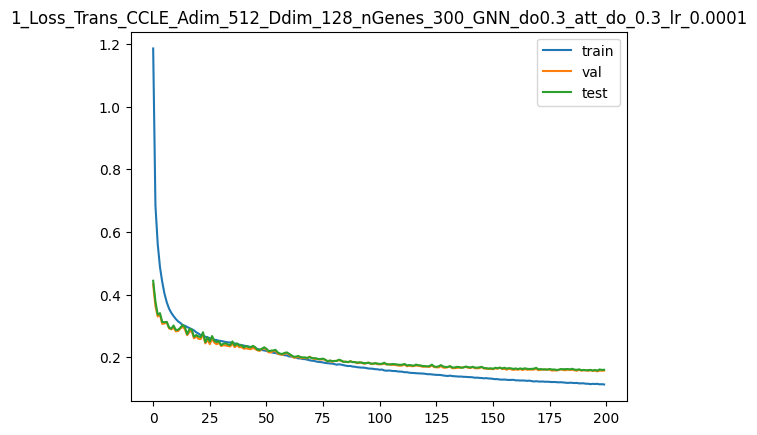

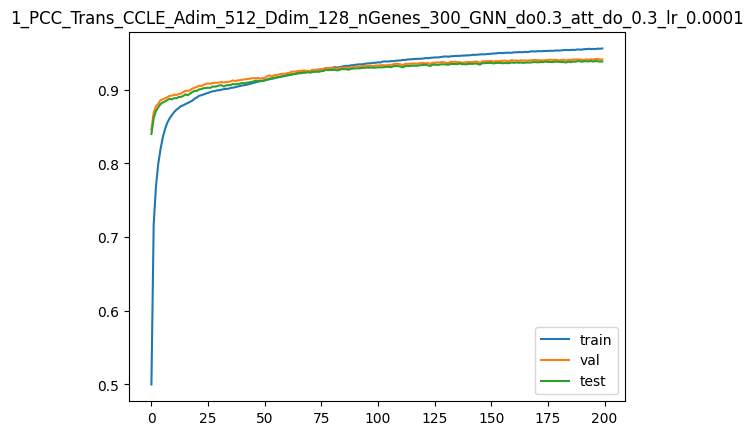

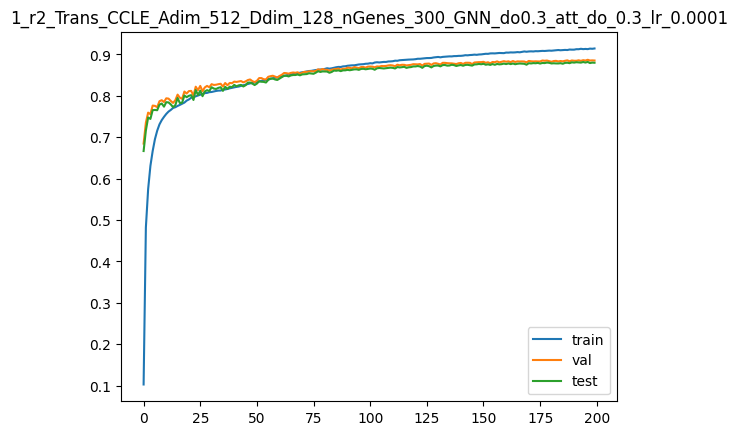

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1574705
Test avg_pcc:  0.9391064764886781
Test r2:  0.8818386171897062


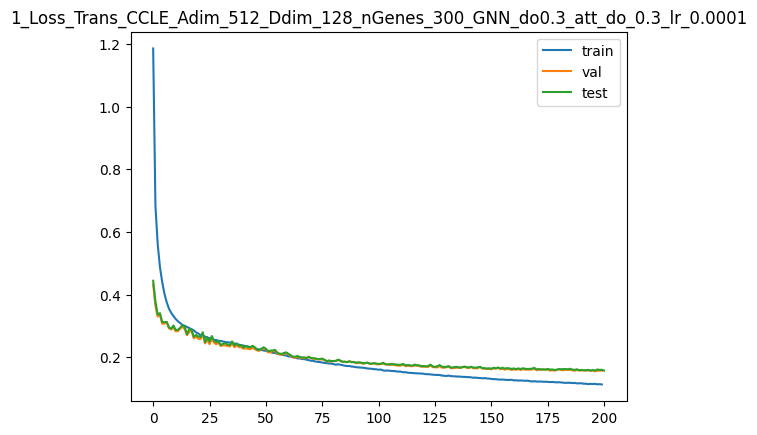

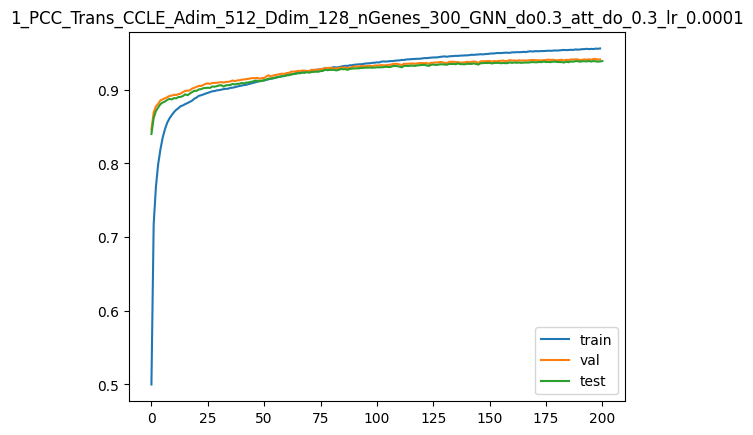

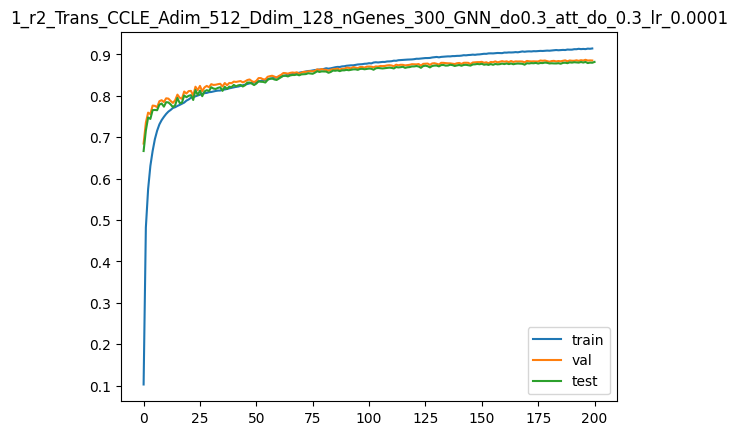

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.0778340101242065
The overall Pearson's correlation is 0.5998.
Train avg_loss:  1.2471298
Train avg_pcc:  0.4792071506987101
Train r2:  0.05923836559717954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.42344573
Validation avg_pcc:  0.8442772577149996
Validation r2:  0.6858447462077588
Best Val r2  0.6858447462077588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.43230134
Test avg_pcc:  0.8374092872841267
Test r2:  0.672928527712805
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.7099788784980774
The overall Pearson's correlation is 0.6705.
Train avg_loss:  0.6948486
Train avg_pcc:  0.7135564296037915
Train r2:  0.4758469104090879


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.43905532
Validation avg_pcc:  0.8678817191970416
Validation r2:  0.6742639828086419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.44708446
Test avg_pcc:  0.8623589338342579
Test r2:  0.6617438735708725
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5928143858909607
The overall Pearson's correlation is 0.7105.
Train avg_loss:  0.5658087
Train avg_pcc:  0.7676989743586159
Train r2:  0.5731870423831108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.43452308
Validation avg_pcc:  0.8739438615000918
Validation r2:  0.6776264559990612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.4364072
Test avg_pcc:  0.8697602700809103
Test r2:  0.6698220753888681
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4294821321964264
The overall Pearson's correlation is 0.8493.
Train avg_loss:  0.4950279
Train avg_pcc:  0.7971428259448492
Train r2:  0.6265799053561398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36201483
Validation avg_pcc:  0.8797115920055307
Validation r2:  0.7314204702412508
Best Val r2  0.7314204702412508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.36750385
Test avg_pcc:  0.8752900820143146
Test r2:  0.7219531633460079
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39828070998191833
The overall Pearson's correlation is 0.8348.
Train avg_loss:  0.44745347
Train avg_pcc:  0.8169745034243415
Train r2:  0.6624672674683421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32647932
Validation avg_pcc:  0.881757623297327
Validation r2:  0.7577843178690793
Best Val r2  0.7577843178690793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33038002
Test avg_pcc:  0.8776395949094058
Test r2:  0.750040400814033
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3571634888648987
The overall Pearson's correlation is 0.8362.
Train avg_loss:  0.40849128
Train avg_pcc:  0.8332979404618438
Train r2:  0.6918580679393361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3244502
Validation avg_pcc:  0.884328693207796
Validation r2:  0.7592897370600605
Best Val r2  0.7592897370600605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32702154
Test avg_pcc:  0.8808927988077409
Test r2:  0.7525813340407048
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3062865734100342
The overall Pearson's correlation is 0.8768.
Train avg_loss:  0.38175932
Train avg_pcc:  0.8445721358948179
Train r2:  0.712023112716675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30565068
Validation avg_pcc:  0.8850578728083801
Validation r2:  0.7732371330323801
Best Val r2  0.7732371330323801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3097047
Test avg_pcc:  0.8810142972789241
Test r2:  0.7656829734832786
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3504524230957031
The overall Pearson's correlation is 0.8522.
Train avg_loss:  0.35930958
Train avg_pcc:  0.8541864880031343
Train r2:  0.7289578546348456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32463002
Validation avg_pcc:  0.8870699507715174
Validation r2:  0.7591563229660856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32808626
Test avg_pcc:  0.8831708184597505
Test r2:  0.751775796487697
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2744317054748535
The overall Pearson's correlation is 0.8735.
Train avg_loss:  0.34146586
Train avg_pcc:  0.8618197564514948
Train r2:  0.742418137546637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32219145
Validation avg_pcc:  0.8892235935365175
Validation r2:  0.76096551722631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32630298
Test avg_pcc:  0.8849793978602133
Test r2:  0.7531250126968825
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.289946973323822
The overall Pearson's correlation is 0.8830.
Train avg_loss:  0.3314248
Train avg_pcc:  0.8661001635213349
Train r2:  0.7499925127560791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31680247
Validation avg_pcc:  0.8902598166830265
Validation r2:  0.764963616941307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32227483
Test avg_pcc:  0.8861925473370273
Test r2:  0.7561726267531335
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.34390372037887573
The overall Pearson's correlation is 0.8540.
Train avg_loss:  0.3222853
Train avg_pcc:  0.8700409483071214
Train r2:  0.7568868357007931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3165069
Validation avg_pcc:  0.889663366485883
Validation r2:  0.7651829060675086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31743273
Test avg_pcc:  0.8872468706902904
Test r2:  0.7598360773064193
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2808486223220825
The overall Pearson's correlation is 0.8811.
Train avg_loss:  0.31442434
Train avg_pcc:  0.8734224829960523
Train r2:  0.7628166745645208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28302038
Validation avg_pcc:  0.8914668854137477
Validation r2:  0.7900266348213162
Best Val r2  0.7900266348213162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28401512
Test avg_pcc:  0.8887988503647288
Test r2:  0.7851192479998201
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27038663625717163
The overall Pearson's correlation is 0.9214.
Train avg_loss:  0.30848348
Train avg_pcc:  0.8759785958026917
Train r2:  0.7672981096240994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3111166
Validation avg_pcc:  0.892198119078211
Validation r2:  0.7691819621125712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31341204
Test avg_pcc:  0.8890753616073699
Test r2:  0.7628780744149252
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26017481088638306
The overall Pearson's correlation is 0.8837.
Train avg_loss:  0.3042707
Train avg_pcc:  0.8777855827684843
Train r2:  0.7704759740991043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2947805
Validation avg_pcc:  0.8925606269298056
Validation r2:  0.7813017665942854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2949478
Test avg_pcc:  0.8903916960106056
Test r2:  0.7768477758025956
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35595962405204773
The overall Pearson's correlation is 0.8293.
Train avg_loss:  0.29929757
Train avg_pcc:  0.8799131843842023
Train r2:  0.7742274153845666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28393024
Validation avg_pcc:  0.8916609587116346
Validation r2:  0.7893515677401948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28582835
Test avg_pcc:  0.8889028947432428
Test r2:  0.7837473670983149
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30643364787101746
The overall Pearson's correlation is 0.8793.
Train avg_loss:  0.29600722
Train avg_pcc:  0.8813206249284
Train r2:  0.7767094906216633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2778841
Validation avg_pcc:  0.8947850258232674
Validation r2:  0.7938372199792689
Best Val r2  0.7938372199792689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28004023
Test avg_pcc:  0.8919587095616969
Test r2:  0.7881265680819778
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24338537454605103
The overall Pearson's correlation is 0.9113.
Train avg_loss:  0.2918386
Train avg_pcc:  0.883102037688853
Train r2:  0.7798540688792548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2761163
Validation avg_pcc:  0.8953390520154718
Validation r2:  0.7951487370136081
Best Val r2  0.7951487370136081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.278546
Test avg_pcc:  0.8922120344343929
Test r2:  0.7892570672038269
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.38910892605781555
The overall Pearson's correlation is 0.8773.
Train avg_loss:  0.29072708
Train avg_pcc:  0.8835784962691114
Train r2:  0.7806925119341788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27904552
Validation avg_pcc:  0.896754454388438
Validation r2:  0.7929755850463605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28002036
Test avg_pcc:  0.8943093276712937
Test r2:  0.7881416093884037
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27401697635650635
The overall Pearson's correlation is 0.9296.
Train avg_loss:  0.28625497
Train avg_pcc:  0.8854824810766065
Train r2:  0.784065997104282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.266086
Validation avg_pcc:  0.8979989234568568
Validation r2:  0.8025902632455248
Best Val r2  0.8025902632455248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26804715
Test avg_pcc:  0.8952122222698633
Test r2:  0.7972003525368784
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22845196723937988
The overall Pearson's correlation is 0.8772.
Train avg_loss:  0.28280148
Train avg_pcc:  0.8869519887808088
Train r2:  0.7866711260785572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29428977
Validation avg_pcc:  0.8983697155181567
Validation r2:  0.781665830081516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2918402
Test avg_pcc:  0.8970019757926108
Test r2:  0.7791989330604373
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24944010376930237
The overall Pearson's correlation is 0.8945.
Train avg_loss:  0.27742982
Train avg_pcc:  0.8892359700759467
Train r2:  0.7907231651870217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27677548
Validation avg_pcc:  0.8993978159635688
Validation r2:  0.7946596971359382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2757825
Test avg_pcc:  0.8977841038636991
Test r2:  0.7913478940455122
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2984340488910675
The overall Pearson's correlation is 0.9053.
Train avg_loss:  0.27410668
Train avg_pcc:  0.890642170240742
Train r2:  0.7932299719075862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26223087
Validation avg_pcc:  0.901076527125653
Validation r2:  0.8054503970363024
Best Val r2  0.8054503970363024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26303723
Test avg_pcc:  0.8992811765201643
Test r2:  0.8009907435325536
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23334622383117676
The overall Pearson's correlation is 0.9171.
Train avg_loss:  0.27046385
Train avg_pcc:  0.8921838733934244
Train r2:  0.7959779077890067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26412007
Validation avg_pcc:  0.9036754188710865
Validation r2:  0.8040487608299183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26469168
Test avg_pcc:  0.9017938226126726
Test r2:  0.7997389929392358
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25080406665802
The overall Pearson's correlation is 0.8701.
Train avg_loss:  0.26666567
Train avg_pcc:  0.8937863461957263
Train r2:  0.7988430212741067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28599796
Validation avg_pcc:  0.903936008005435
Validation r2:  0.7878175520710885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28729576
Test avg_pcc:  0.9019184466630267
Test r2:  0.7826371498848989
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2604619860649109
The overall Pearson's correlation is 0.8994.
Train avg_loss:  0.26300612
Train avg_pcc:  0.8953298406889206
Train r2:  0.8016035925548612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25822327
Validation avg_pcc:  0.9042140809599835
Validation r2:  0.8084236292262954
Best Val r2  0.8084236292262954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25821838
Test avg_pcc:  0.9026898811114127
Test r2:  0.8046366017731603
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24876730144023895
The overall Pearson's correlation is 0.9117.
Train avg_loss:  0.2609394
Train avg_pcc:  0.8961992692839802
Train r2:  0.8031626043758112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2541788
Validation avg_pcc:  0.9054859759366706
Validation r2:  0.8114242373266765
Best Val r2  0.8114242373266765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25493538
Test avg_pcc:  0.9036773971258637
Test r2:  0.8071204556175746
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3143063187599182
The overall Pearson's correlation is 0.8793.
Train avg_loss:  0.2593517
Train avg_pcc:  0.8968679925890304
Train r2:  0.8043602596837716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25365168
Validation avg_pcc:  0.9051340560556675
Validation r2:  0.8118153179205277
Best Val r2  0.8118153179205277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25082034
Test avg_pcc:  0.9044451048804475
Test r2:  0.8102338164734346
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1737358123064041
The overall Pearson's correlation is 0.9351.
Train avg_loss:  0.25644284
Train avg_pcc:  0.8980890618716854
Train r2:  0.8065545209824283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2520068
Validation avg_pcc:  0.9058684500399998
Validation r2:  0.813035646019343
Best Val r2  0.813035646019343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25121385
Test avg_pcc:  0.9048672786816598
Test r2:  0.8099361008129072
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2587169408798218
The overall Pearson's correlation is 0.8963.
Train avg_loss:  0.25532642
Train avg_pcc:  0.8985596380967863
Train r2:  0.8073966831873975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24416752
Validation avg_pcc:  0.9060460646168245
Validation r2:  0.8188516407168703
Best Val r2  0.8188516407168703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2403915
Test avg_pcc:  0.9058922815335619
Test r2:  0.8181241132525006
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1970793604850769
The overall Pearson's correlation is 0.9155.
Train avg_loss:  0.2538204
Train avg_pcc:  0.899192480799419
Train r2:  0.8085327319982176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24648935
Validation avg_pcc:  0.9057267125680105
Validation r2:  0.8171290554356638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24494316
Test avg_pcc:  0.904810504598972
Test r2:  0.8146803872035117
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.279842346906662
The overall Pearson's correlation is 0.9154.
Train avg_loss:  0.25208783
Train avg_pcc:  0.899915622313561
Train r2:  0.8098396977496987


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24289644
Validation avg_pcc:  0.9068184446988676
Validation r2:  0.8197946498961171
Best Val r2  0.8197946498961171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23889625
Test avg_pcc:  0.906436321687216
Test r2:  0.819255374065762
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2261560559272766
The overall Pearson's correlation is 0.8826.
Train avg_loss:  0.2516211
Train avg_pcc:  0.9001119668135718
Train r2:  0.8101917395607179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24092978
Validation avg_pcc:  0.907132191036201
Validation r2:  0.8212536912114065
Best Val r2  0.8212536912114065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23757757
Test avg_pcc:  0.9066719128453454
Test r2:  0.8202530571352149
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2779899835586548
The overall Pearson's correlation is 0.8834.
Train avg_loss:  0.25135136
Train avg_pcc:  0.9002253439481306
Train r2:  0.8103952268427709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2472634
Validation avg_pcc:  0.9072499685984811
Validation r2:  0.8165547707646609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2460184
Test avg_pcc:  0.9061125837277766
Test r2:  0.8138668879982294
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1764642596244812
The overall Pearson's correlation is 0.9318.
Train avg_loss:  0.24814785
Train avg_pcc:  0.9015663787136368
Train r2:  0.812811781457913


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23783301
Validation avg_pcc:  0.907645456475507
Validation r2:  0.8235512096041553
Best Val r2  0.8235512096041553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23547615
Test avg_pcc:  0.906870560580832
Test r2:  0.8218429514738387
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25254738330841064
The overall Pearson's correlation is 0.9131.
Train avg_loss:  0.24872129
Train avg_pcc:  0.9013270446380834
Train r2:  0.8123792155421607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23659714
Validation avg_pcc:  0.9082446231694965
Validation r2:  0.8244681145489313
Best Val r2  0.8244681145489313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23340532
Test avg_pcc:  0.9077988134563033
Test r2:  0.8234097069311838
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22611039876937866
The overall Pearson's correlation is 0.9066.
Train avg_loss:  0.24708287
Train avg_pcc:  0.902010390849269
Train r2:  0.8136151354952061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23512052
Validation avg_pcc:  0.9087510454173838
Validation r2:  0.8255636059063187
Best Val r2  0.8255636059063187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2335552
Test avg_pcc:  0.9074842078624616
Test r2:  0.8232963233910817
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26520901918411255
The overall Pearson's correlation is 0.8939.
Train avg_loss:  0.24510106
Train avg_pcc:  0.9028387980309199
Train r2:  0.8151100936912102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24964352
Validation avg_pcc:  0.9077728353434636
Validation r2:  0.8147889635879041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24721028
Test avg_pcc:  0.9071904473612828
Test r2:  0.8129651187267414
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21369768679141998
The overall Pearson's correlation is 0.9253.
Train avg_loss:  0.24485128
Train avg_pcc:  0.9029457492382813
Train r2:  0.8152985140301359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24140686
Validation avg_pcc:  0.9083874655080233
Validation r2:  0.8208997606036273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23738998
Test avg_pcc:  0.9086145199000598
Test r2:  0.8203949800533352
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23472079634666443
The overall Pearson's correlation is 0.9131.
Train avg_loss:  0.2442873
Train avg_pcc:  0.9031802139907559
Train r2:  0.8157239472698813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23985572
Validation avg_pcc:  0.9081777742332925
Validation r2:  0.822050554884903


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23638944
Test avg_pcc:  0.9078872273066819
Test r2:  0.8211519785061979
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21782788634300232
The overall Pearson's correlation is 0.9271.
Train avg_loss:  0.24147123
Train avg_pcc:  0.9043552161783757
Train r2:  0.8178482445122872


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23769724
Validation avg_pcc:  0.9087401332037858
Validation r2:  0.823651912789449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23328404
Test avg_pcc:  0.9088464787888917
Test r2:  0.8235014714586407
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2170812487602234
The overall Pearson's correlation is 0.8979.
Train avg_loss:  0.23949322
Train avg_pcc:  0.9051780791346321
Train r2:  0.8193403198314528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23433813
Validation avg_pcc:  0.9101284439180788
Validation r2:  0.8261440776840013
Best Val r2  0.8261440776840013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23269708
Test avg_pcc:  0.9093123312856827
Test r2:  0.823945538307275
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2771073579788208
The overall Pearson's correlation is 0.8638.
Train avg_loss:  0.23851795
Train avg_pcc:  0.9055846982041698
Train r2:  0.8200760014506769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24503443
Validation avg_pcc:  0.9092518935375833
Validation r2:  0.8182084650083714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24197972
Test avg_pcc:  0.9089593679412766
Test r2:  0.8169224759086162
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26376470923423767
The overall Pearson's correlation is 0.8950.
Train avg_loss:  0.23761074
Train avg_pcc:  0.9059631267628674
Train r2:  0.8207603487765713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2390634
Validation avg_pcc:  0.9106622310634018
Validation r2:  0.8226383956073438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2359028
Test avg_pcc:  0.9103649694835012
Test r2:  0.8215201622857936
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2953360676765442
The overall Pearson's correlation is 0.9225.
Train avg_loss:  0.23686199
Train avg_pcc:  0.9062746134168417
Train r2:  0.8213251656784395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23280706
Validation avg_pcc:  0.9105507181030161
Validation r2:  0.8272799859181323
Best Val r2  0.8272799859181323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23099084
Test avg_pcc:  0.9098554702778083
Test r2:  0.8252364584149998
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1989654004573822
The overall Pearson's correlation is 0.9221.
Train avg_loss:  0.23572098
Train avg_pcc:  0.9067474826726156
Train r2:  0.8221858933132518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23568934
Validation avg_pcc:  0.911080422275401
Validation r2:  0.8251416098686147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23433349
Test avg_pcc:  0.9101051044604136
Test r2:  0.8227074767469388
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3124608099460602
The overall Pearson's correlation is 0.8728.
Train avg_loss:  0.23275429
Train avg_pcc:  0.9079817874433421
Train r2:  0.8244237915279344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22881655
Validation avg_pcc:  0.9118776859508585
Validation r2:  0.8302405360306708
Best Val r2  0.8302405360306708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2251042
Test avg_pcc:  0.9114374160365262
Test r2:  0.8296902065593657
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23364093899726868
The overall Pearson's correlation is 0.9111.
Train avg_loss:  0.23187399
Train avg_pcc:  0.9083470208749295
Train r2:  0.8250878418618086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22690627
Validation avg_pcc:  0.9120032110421942
Validation r2:  0.8316577913540406
Best Val r2  0.8316577913540406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22466634
Test avg_pcc:  0.9112528925595995
Test r2:  0.8300214603623555
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2020263820886612
The overall Pearson's correlation is 0.9054.
Train avg_loss:  0.23118831
Train avg_pcc:  0.908630848032615
Train r2:  0.8256050561119799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2292526
Validation avg_pcc:  0.9130221908165541
Validation r2:  0.8299170270684826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22455719
Test avg_pcc:  0.913169866241214
Test r2:  0.8301040461696203
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21331392228603363
The overall Pearson's correlation is 0.9171.
Train avg_loss:  0.22848211
Train avg_pcc:  0.9097539532811451
Train r2:  0.8276464743646768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22842701
Validation avg_pcc:  0.9129087326076248
Validation r2:  0.8305295421779966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2234407
Test avg_pcc:  0.913846212110122
Test r2:  0.830948745853049
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20933091640472412
The overall Pearson's correlation is 0.9141.
Train avg_loss:  0.2266892
Train avg_pcc:  0.9104957470704814
Train r2:  0.8289989203056397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22383872
Validation avg_pcc:  0.9139025257870772
Validation r2:  0.8339336007285731
Best Val r2  0.8339336007285731


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22101782
Test avg_pcc:  0.9136518468426351
Test r2:  0.8327818635369364


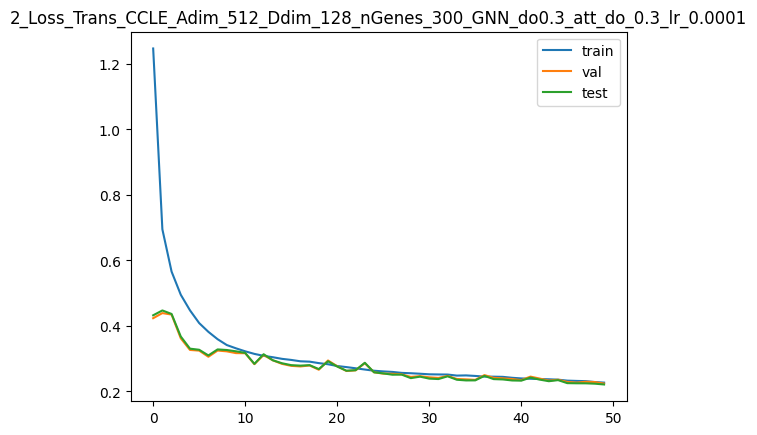

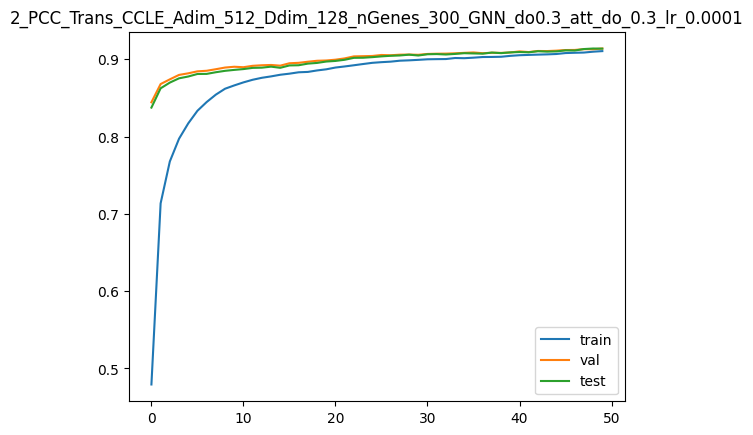

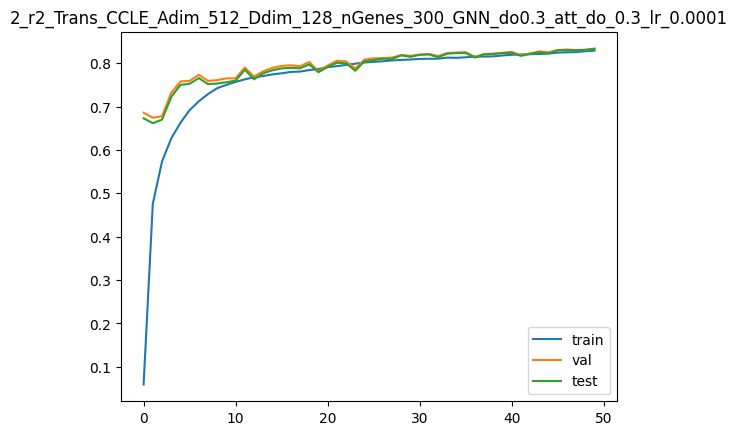

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1575188934803009
The overall Pearson's correlation is 0.9386.
Train avg_loss:  0.22474824
Train avg_pcc:  0.9113023311644967
Train r2:  0.8304630675983303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21964385
Validation avg_pcc:  0.9149076491966652
Validation r2:  0.8370457816077429
Best Val r2  0.8370457816077429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21419066
Test avg_pcc:  0.9154536977854907
Test r2:  0.8379471865969905
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21966710686683655
The overall Pearson's correlation is 0.9229.
Train avg_loss:  0.22329539
Train avg_pcc:  0.9119021274200004
Train r2:  0.8315590151265874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2296698
Validation avg_pcc:  0.9141608039983649
Validation r2:  0.8296075067002163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22391033
Test avg_pcc:  0.9147582828362553
Test r2:  0.83059343522284
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23286056518554688
The overall Pearson's correlation is 0.8954.
Train avg_loss:  0.22106001
Train avg_pcc:  0.9128270765647012
Train r2:  0.8332452782329804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22041023
Validation avg_pcc:  0.9151965596713729
Validation r2:  0.8364772161592859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21687852
Test avg_pcc:  0.9149988722889832
Test r2:  0.8359136030058854
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16957175731658936
The overall Pearson's correlation is 0.9346.
Train avg_loss:  0.21949765
Train avg_pcc:  0.9134707190993461
Train r2:  0.8344238284395669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22184715
Validation avg_pcc:  0.91550382272559
Validation r2:  0.8354111562905342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2203717
Test avg_pcc:  0.9148720193945912
Test r2:  0.8332707237527577
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17408041656017303
The overall Pearson's correlation is 0.9053.
Train avg_loss:  0.21892089
Train avg_pcc:  0.9137094462273906
Train r2:  0.8348588857889855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22172381
Validation avg_pcc:  0.9159828625083846
Validation r2:  0.8355026518968216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21443161
Test avg_pcc:  0.9171874826401285
Test r2:  0.8377648780559712
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2224748581647873
The overall Pearson's correlation is 0.9165.
Train avg_loss:  0.21781993
Train avg_pcc:  0.9141632552370808
Train r2:  0.8356893927225637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22207233
Validation avg_pcc:  0.9166298128715856
Validation r2:  0.8352440847144208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21806385
Test avg_pcc:  0.9164996750599774
Test r2:  0.8350167997599897
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20336034893989563
The overall Pearson's correlation is 0.9253.
Train avg_loss:  0.21584888
Train avg_pcc:  0.9149769242026738
Train r2:  0.8371762447755942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21392049
Validation avg_pcc:  0.9174291652366676
Validation r2:  0.841291948862769
Best Val r2  0.841291948862769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20813002
Test avg_pcc:  0.9179810657792934
Test r2:  0.8425325500315495
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24611935019493103
The overall Pearson's correlation is 0.9087.
Train avg_loss:  0.21355577
Train avg_pcc:  0.9159201383419174
Train r2:  0.8389060254496968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21426354
Validation avg_pcc:  0.9182767969844601
Validation r2:  0.8410374404819345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21061158
Test avg_pcc:  0.9180265316041725
Test r2:  0.8406550425323571
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.246394082903862
The overall Pearson's correlation is 0.9042.
Train avg_loss:  0.21232271
Train avg_pcc:  0.9164287698655391
Train r2:  0.8398361778151876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2136678
Validation avg_pcc:  0.9183660528721301
Validation r2:  0.8414794374506773
Best Val r2  0.8414794374506773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20900038
Test avg_pcc:  0.9188117507775446
Test r2:  0.8418740596319041
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18554472923278809
The overall Pearson's correlation is 0.9331.
Train avg_loss:  0.21102512
Train avg_pcc:  0.9169625427852939
Train r2:  0.8408150069135688


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21436794
Validation avg_pcc:  0.9181242681063275
Validation r2:  0.840959981504265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21006662
Test avg_pcc:  0.9184111983694291
Test r2:  0.8410673509454869
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2224394530057907
The overall Pearson's correlation is 0.9284.
Train avg_loss:  0.20911276
Train avg_pcc:  0.9177481620604122
Train r2:  0.8422575628546458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21171959
Validation avg_pcc:  0.9193140094397201
Validation r2:  0.842924811404384
Best Val r2  0.842924811404384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20803745
Test avg_pcc:  0.9193986673080796
Test r2:  0.842602596631385
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21043604612350464
The overall Pearson's correlation is 0.9094.
Train avg_loss:  0.20765525
Train avg_pcc:  0.9183483373732606
Train r2:  0.8433570398011532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21118554
Validation avg_pcc:  0.9207699217941918
Validation r2:  0.8433210040666677
Best Val r2  0.8433210040666677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20844033
Test avg_pcc:  0.9204580251772413
Test r2:  0.8422977813914433
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2256179004907608
The overall Pearson's correlation is 0.8965.
Train avg_loss:  0.20626715
Train avg_pcc:  0.9189172888181327
Train r2:  0.8444041284722539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2075004
Validation avg_pcc:  0.9201851845331637
Validation r2:  0.8460550296435475
Best Val r2  0.8460550296435475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20405792
Test avg_pcc:  0.9200466785164505
Test r2:  0.8456134250349021
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1817544549703598
The overall Pearson's correlation is 0.9152.
Train avg_loss:  0.20427015
Train avg_pcc:  0.9197374356061576
Train r2:  0.8459105265918069


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2080815
Validation avg_pcc:  0.9214128299351139
Validation r2:  0.8456239065204861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2041096
Test avg_pcc:  0.9214132677642368
Test r2:  0.8455743359705599
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.177342489361763
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.20305842
Train avg_pcc:  0.9202339476701171
Train r2:  0.8468246169789462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20513295
Validation avg_pcc:  0.9219332585797508
Validation r2:  0.8478114569684386
Best Val r2  0.8478114569684386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20144853
Test avg_pcc:  0.921845091408562
Test r2:  0.847587658941588
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.134919673204422
The overall Pearson's correlation is 0.9574.
Train avg_loss:  0.20150636
Train avg_pcc:  0.9208694531233356
Train r2:  0.8479953951249496


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20384431
Validation avg_pcc:  0.9220255036646938
Validation r2:  0.8487674975446327
Best Val r2  0.8487674975446327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20094764
Test avg_pcc:  0.9218679832291862
Test r2:  0.8479666071906297
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21954011917114258
The overall Pearson's correlation is 0.9398.
Train avg_loss:  0.20015794
Train avg_pcc:  0.921421034083141
Train r2:  0.8490125660298967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2061219
Validation avg_pcc:  0.9228904619271314
Validation r2:  0.8470777297723934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20386007
Test avg_pcc:  0.9223354744255372
Test r2:  0.8457631049814004
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2506505250930786
The overall Pearson's correlation is 0.8893.
Train avg_loss:  0.19923066
Train avg_pcc:  0.9218026320075006
Train r2:  0.8497120529998362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20085682
Validation avg_pcc:  0.9227179554477936
Validation r2:  0.850983920457356
Best Val r2  0.850983920457356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19957054
Test avg_pcc:  0.9216842413515882
Test r2:  0.8490084972760179
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21559521555900574
The overall Pearson's correlation is 0.9210.
Train avg_loss:  0.19634971
Train avg_pcc:  0.9229783866169747
Train r2:  0.8518852735226621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19921525
Validation avg_pcc:  0.923785135446247
Validation r2:  0.8522018084514957
Best Val r2  0.8522018084514957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19861034
Test avg_pcc:  0.9224075928758232
Test r2:  0.8497349645553347
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17152497172355652
The overall Pearson's correlation is 0.9223.
Train avg_loss:  0.19547923
Train avg_pcc:  0.9233339914051463
Train r2:  0.8525418954259456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1975056
Validation avg_pcc:  0.9243879749691972
Validation r2:  0.853470196134905
Best Val r2  0.853470196134905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19683039
Test avg_pcc:  0.9232892346575148
Test r2:  0.8510816361110876
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18727922439575195
The overall Pearson's correlation is 0.9203.
Train avg_loss:  0.19355953
Train avg_pcc:  0.9241183931988564
Train r2:  0.853990016018059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19792566
Validation avg_pcc:  0.924554009178164
Validation r2:  0.8531585592079084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1969515
Test avg_pcc:  0.9232812200993328
Test r2:  0.850990036839289
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19878223538398743
The overall Pearson's correlation is 0.9313.
Train avg_loss:  0.19378617
Train avg_pcc:  0.9240251967395818
Train r2:  0.8538190473276996


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19976845
Validation avg_pcc:  0.924391405550392
Validation r2:  0.8517913855620587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1970894
Test avg_pcc:  0.9239350223196109
Test r2:  0.8508856867711316
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2412184774875641
The overall Pearson's correlation is 0.9046.
Train avg_loss:  0.19275114
Train avg_pcc:  0.9244478684151675
Train r2:  0.854599818399696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20077822
Validation avg_pcc:  0.9257766315600434
Validation r2:  0.8510422241372726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20106585
Test avg_pcc:  0.92454031571526
Test r2:  0.8478771621339924
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20227378606796265
The overall Pearson's correlation is 0.9153.
Train avg_loss:  0.19009444
Train avg_pcc:  0.9255305484818129
Train r2:  0.8566038836754974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19967404
Validation avg_pcc:  0.9247626301092049
Validation r2:  0.851861426410197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1999649
Test avg_pcc:  0.9232999687927318
Test r2:  0.8487101447957324
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19614277780056
The overall Pearson's correlation is 0.9498.
Train avg_loss:  0.18807237
Train avg_pcc:  0.9263554064196609
Train r2:  0.8581292098044947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1909579
Validation avg_pcc:  0.9266171888675274
Validation r2:  0.8583279462909115
Best Val r2  0.8583279462909115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19140491
Test avg_pcc:  0.9249945937613824
Test r2:  0.8551864649242539
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2083096206188202
The overall Pearson's correlation is 0.9074.
Train avg_loss:  0.18835913
Train avg_pcc:  0.926239433510552
Train r2:  0.8579128906069691


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19049414
Validation avg_pcc:  0.9267807602711617
Validation r2:  0.8586720063315789
Best Val r2  0.8586720063315789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18952304
Test avg_pcc:  0.9257112849196902
Test r2:  0.8566102585230522
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20218780636787415
The overall Pearson's correlation is 0.9293.
Train avg_loss:  0.18720362
Train avg_pcc:  0.9267091224381866
Train r2:  0.8587845324851661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19089861
Validation avg_pcc:  0.9272019906612526
Validation r2:  0.8583719234574105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1905663
Test avg_pcc:  0.9259337520334807
Test r2:  0.8558209435946291
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18683654069900513
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.18654574
Train avg_pcc:  0.9269754164244441
Train r2:  0.8592808081888689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.189266
Validation avg_pcc:  0.9274532932740727
Validation r2:  0.859583164542978
Best Val r2  0.859583164542978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1881333
Test avg_pcc:  0.9265024628036689
Test r2:  0.8576617173465896
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15504345297813416
The overall Pearson's correlation is 0.9551.
Train avg_loss:  0.18463364
Train avg_pcc:  0.9277542251200703
Train r2:  0.8607231681537268


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18942502
Validation avg_pcc:  0.9282824417524447
Validation r2:  0.8594651950559695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19189529
Test avg_pcc:  0.9259046680352627
Test r2:  0.8548154516204002
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2630409598350525
The overall Pearson's correlation is 0.8948.
Train avg_loss:  0.18375853
Train avg_pcc:  0.9281107367126313
Train r2:  0.8613833223006009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19207925
Validation avg_pcc:  0.9275662398793267
Validation r2:  0.8574960174000462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1912336
Test avg_pcc:  0.9262587786003391
Test r2:  0.8553160603902269
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2200622260570526
The overall Pearson's correlation is 0.9223.
Train avg_loss:  0.18250237
Train avg_pcc:  0.9286191099724909
Train r2:  0.862330879893356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19261336
Validation avg_pcc:  0.9285414522183619
Validation r2:  0.8570997554499614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19328544
Test avg_pcc:  0.9270791019726111
Test r2:  0.8537636942748398
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17919392883777618
The overall Pearson's correlation is 0.9320.
Train avg_loss:  0.18122232
Train avg_pcc:  0.9291398783870701
Train r2:  0.863296470314998


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18629432
Validation avg_pcc:  0.9289506473535871
Validation r2:  0.8617878682486055
Best Val r2  0.8617878682486055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18690673
Test avg_pcc:  0.9274371785018328
Test r2:  0.8585897182859583
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15363509953022003
The overall Pearson's correlation is 0.9296.
Train avg_loss:  0.18032613
Train avg_pcc:  0.9295030002500021
Train r2:  0.8639725165242046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19091532
Validation avg_pcc:  0.9282653693222963
Validation r2:  0.8583595478705618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19220492
Test avg_pcc:  0.9266714614889402
Test r2:  0.854581178236122
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17685304582118988
The overall Pearson's correlation is 0.9153.
Train avg_loss:  0.17917225
Train avg_pcc:  0.9299724023270717
Train r2:  0.8648429403147316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18692899
Validation avg_pcc:  0.9287235108351253
Validation r2:  0.8613170024556032


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18630274
Test avg_pcc:  0.9277243286611287
Test r2:  0.85904667108348
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18882136046886444
The overall Pearson's correlation is 0.9406.
Train avg_loss:  0.17865644
Train avg_pcc:  0.930180477230613
Train r2:  0.8652320339279459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18629345
Validation avg_pcc:  0.9290495193323598
Validation r2:  0.8617885071953812
Best Val r2  0.8617885071953812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18509422
Test avg_pcc:  0.9281371407844178
Test r2:  0.8599610184744222
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17048008739948273
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.17834248
Train avg_pcc:  0.9303089715733454
Train r2:  0.865468874042988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18579918
Validation avg_pcc:  0.928579597480913
Validation r2:  0.8621552143113547
Best Val r2  0.8621552143113547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18596375
Test avg_pcc:  0.9270247195609616
Test r2:  0.8593031509933391
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12159422785043716
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.17628662
Train avg_pcc:  0.931140903717414
Train r2:  0.8670196890884694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18322748
Validation avg_pcc:  0.9301093166793402
Validation r2:  0.8640631522882334
Best Val r2  0.8640631522882334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18412149
Test avg_pcc:  0.9284502821055405
Test r2:  0.8606969706906907
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1691581904888153
The overall Pearson's correlation is 0.9310.
Train avg_loss:  0.17528956
Train avg_pcc:  0.9315448558501225
Train r2:  0.8677718182232231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18311939
Validation avg_pcc:  0.9300298068136378
Validation r2:  0.8641433697624419
Best Val r2  0.8641433697624419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18414862
Test avg_pcc:  0.9282083914905652
Test r2:  0.8606764515158146
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16930580139160156
The overall Pearson's correlation is 0.9429.
Train avg_loss:  0.17400262
Train avg_pcc:  0.9320673455590941
Train r2:  0.8687426030648258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18532327
Validation avg_pcc:  0.9299683389695227
Validation r2:  0.8625083001692193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1839833
Test avg_pcc:  0.9288312191493939
Test r2:  0.8608015222870683
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14293420314788818
The overall Pearson's correlation is 0.9439.
Train avg_loss:  0.17447583
Train avg_pcc:  0.9318733057263214
Train r2:  0.8683856358397175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18298624
Validation avg_pcc:  0.9303307083843624
Validation r2:  0.8642421337538602
Best Val r2  0.8642421337538602


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18231362
Test avg_pcc:  0.9292894334816287
Test r2:  0.8620647768859582
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14284926652908325
The overall Pearson's correlation is 0.9429.
Train avg_loss:  0.17173228
Train avg_pcc:  0.9329837702540249
Train r2:  0.8704552103956189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18306811
Validation avg_pcc:  0.9300138297276292
Validation r2:  0.8641814022936839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18148136
Test avg_pcc:  0.9292010715667941
Test r2:  0.8626944511935754
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12101372331380844
The overall Pearson's correlation is 0.9470.
Train avg_loss:  0.1713626
Train avg_pcc:  0.9331336212541875
Train r2:  0.8707340824368671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18274362
Validation avg_pcc:  0.9302739876171943
Validation r2:  0.8644221390465807
Best Val r2  0.8644221390465807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18417598
Test avg_pcc:  0.9282684734556961
Test r2:  0.86065574425073
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1783781349658966
The overall Pearson's correlation is 0.9205.
Train avg_loss:  0.17101616
Train avg_pcc:  0.9332732876626698
Train r2:  0.8709954129491064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1836283
Validation avg_pcc:  0.9299820260379705
Validation r2:  0.8637657825839403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18131562
Test avg_pcc:  0.9294541440220421
Test r2:  0.8628198482739807
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14880748093128204
The overall Pearson's correlation is 0.9460.
Train avg_loss:  0.16966215
Train avg_pcc:  0.9338203521426671
Train r2:  0.8720168041528878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18559553
Validation avg_pcc:  0.931554090194297
Validation r2:  0.862306299840982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18316177
Test avg_pcc:  0.9310704324492861
Test r2:  0.8614230812130066
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1611674726009369
The overall Pearson's correlation is 0.9306.
Train avg_loss:  0.16800752
Train avg_pcc:  0.9344880882194829
Train r2:  0.8732649528731489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18054615
Validation avg_pcc:  0.9309075595480785
Validation r2:  0.8660524541488656
Best Val r2  0.8660524541488656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17942633
Test avg_pcc:  0.9299092499945835
Test r2:  0.8642492382611505
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.189703106880188
The overall Pearson's correlation is 0.9231.
Train avg_loss:  0.16875796
Train avg_pcc:  0.9341856378355075
Train r2:  0.8726988655011316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17902465
Validation avg_pcc:  0.9312923865217968
Validation r2:  0.8671812481375862
Best Val r2  0.8671812481375862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1774568
Test avg_pcc:  0.9305138490493939
Test r2:  0.8657393626702306
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1594773232936859
The overall Pearson's correlation is 0.9215.
Train avg_loss:  0.16698503
Train avg_pcc:  0.9349010339337728
Train r2:  0.8740362602169034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18715079
Validation avg_pcc:  0.9310780664222575
Validation r2:  0.8611524510427736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18711665
Test avg_pcc:  0.9298007289725638
Test r2:  0.8584308897260107
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15208157896995544
The overall Pearson's correlation is 0.9424.
Train avg_loss:  0.16604935
Train avg_pcc:  0.9352790429619092
Train r2:  0.8747420878339934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1811504
Validation avg_pcc:  0.931476633817553
Validation r2:  0.8656041515418039


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17923419
Test avg_pcc:  0.9308557917183566
Test r2:  0.8643946118521982
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16647790372371674
The overall Pearson's correlation is 0.9235.
Train avg_loss:  0.16519661
Train avg_pcc:  0.9356221369918977
Train r2:  0.875385350213254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18022268
Validation avg_pcc:  0.9314770116748824
Validation r2:  0.8662924369043407


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17771542
Test avg_pcc:  0.9312220426427519
Test r2:  0.8655436952411203
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23304235935211182
The overall Pearson's correlation is 0.9177.
Train avg_loss:  0.16472061
Train avg_pcc:  0.935813906215125
Train r2:  0.8757444040831457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17753355
Validation avg_pcc:  0.9319246381064746
Validation r2:  0.8682874866283902
Best Val r2  0.8682874866283902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17593113
Test avg_pcc:  0.9312112147934593
Test r2:  0.8668936598611048


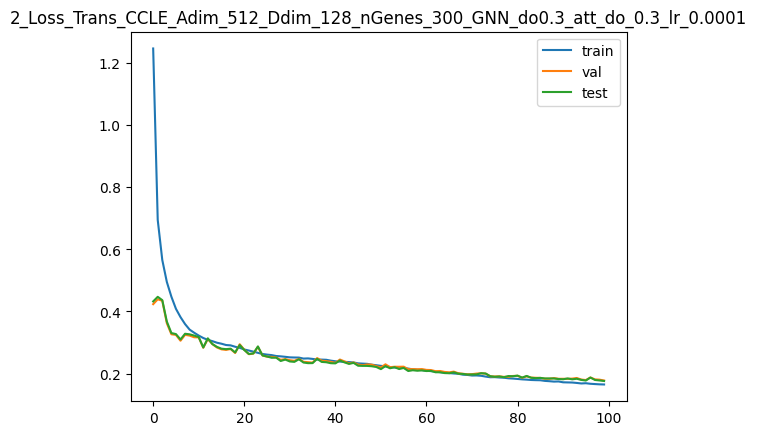

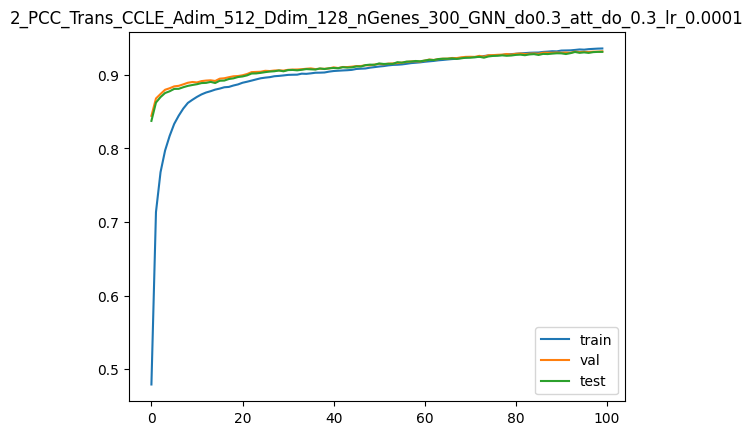

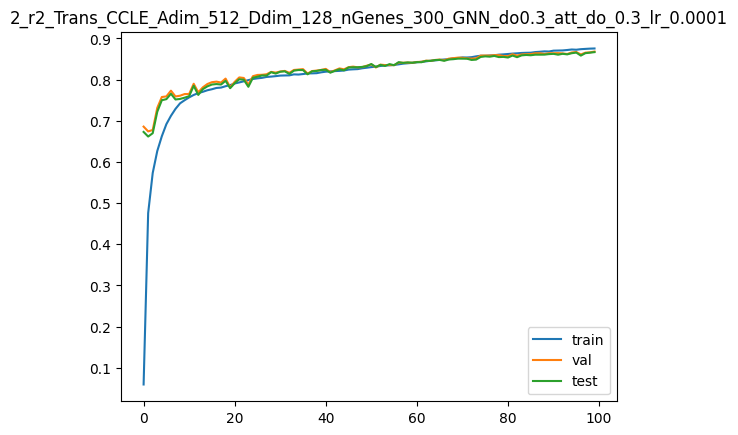

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1499919891357422
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.16400187
Train avg_pcc:  0.9361045607925053
Train r2:  0.876286582768615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1786352
Validation avg_pcc:  0.931556312038386
Validation r2:  0.8674701939255585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17695181
Test avg_pcc:  0.9308757646749986
Test r2:  0.866121420549626
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14866596460342407
The overall Pearson's correlation is 0.9322.
Train avg_loss:  0.16231817
Train avg_pcc:  0.9367813315700173
Train r2:  0.8775566615947098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18238956
Validation avg_pcc:  0.9319416106962118
Validation r2:  0.8646848250402942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18027173
Test avg_pcc:  0.9314861263348937
Test r2:  0.8636096387429508
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14391538500785828
The overall Pearson's correlation is 0.9447.
Train avg_loss:  0.16200054
Train avg_pcc:  0.9369099139540296
Train r2:  0.8777962628521654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17500156
Validation avg_pcc:  0.933076996465128
Validation r2:  0.8701659895117997
Best Val r2  0.8701659895117997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17357083
Test avg_pcc:  0.9323011169603002
Test r2:  0.8686794166159898
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20003506541252136
The overall Pearson's correlation is 0.9166.
Train avg_loss:  0.16144346
Train avg_pcc:  0.9371338093039512
Train r2:  0.8782165059656037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17674325
Validation avg_pcc:  0.9321625748072224
Validation r2:  0.8688738158294586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17582831
Test avg_pcc:  0.9311458563588138
Test r2:  0.866971451113583
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18660834431648254
The overall Pearson's correlation is 0.9261.
Train avg_loss:  0.15998705
Train avg_pcc:  0.9377197310032948
Train r2:  0.8793151440316836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17564173
Validation avg_pcc:  0.9327988085124908
Validation r2:  0.8696910477420315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17349976
Test avg_pcc:  0.9323305950232456
Test r2:  0.868733184568445
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1337367743253708
The overall Pearson's correlation is 0.9440.
Train avg_loss:  0.15984225
Train avg_pcc:  0.9377788181682443
Train r2:  0.8794243697530668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17563742
Validation avg_pcc:  0.932593034639134
Validation r2:  0.869694246536787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17286891
Test avg_pcc:  0.932324293190109
Test r2:  0.8692104818340627
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12132446467876434
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.15912305
Train avg_pcc:  0.9380667337545355
Train r2:  0.8799668664516878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17674461
Validation avg_pcc:  0.932585314578936
Validation r2:  0.8688728221208194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17478654
Test avg_pcc:  0.9320223580767726
Test r2:  0.8677596336279721
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1401272565126419
The overall Pearson's correlation is 0.9487.
Train avg_loss:  0.15847006
Train avg_pcc:  0.9383302893236004
Train r2:  0.8804594498793835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17693868
Validation avg_pcc:  0.9327723318308796
Validation r2:  0.8687288356295173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17650618
Test avg_pcc:  0.9316102513033578
Test r2:  0.8664585772505389
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2150144875049591
The overall Pearson's correlation is 0.9339.
Train avg_loss:  0.1569849
Train avg_pcc:  0.938926691422173
Train r2:  0.881579783070314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17903417
Validation avg_pcc:  0.9322330725228211
Validation r2:  0.8671741798776958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.177368
Test avg_pcc:  0.9315895562714135
Test r2:  0.8658065420298311
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10941809415817261
The overall Pearson's correlation is 0.9593.
Train avg_loss:  0.15688878
Train avg_pcc:  0.9389651730550883
Train r2:  0.8816522840295997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17567867
Validation avg_pcc:  0.9331317018943459
Validation r2:  0.869663643421532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17301944
Test avg_pcc:  0.9328336077156837
Test r2:  0.8690965917016065
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.177262544631958
The overall Pearson's correlation is 0.9297.
Train avg_loss:  0.15500063
Train avg_pcc:  0.9397236576827169
Train r2:  0.8830766079596608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17635982
Validation avg_pcc:  0.933058017702848
Validation r2:  0.8691583012000622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1719314
Test avg_pcc:  0.9334871133703231
Test r2:  0.8699197835928841
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1914602518081665
The overall Pearson's correlation is 0.9196.
Train avg_loss:  0.15583399
Train avg_pcc:  0.9393889469982925
Train r2:  0.8824479407461


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18072715
Validation avg_pcc:  0.9308737335994967
Validation r2:  0.8659181754923454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17580485
Test avg_pcc:  0.9314526284425221
Test r2:  0.8669892063069635
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17080137133598328
The overall Pearson's correlation is 0.9380.
Train avg_loss:  0.15418164
Train avg_pcc:  0.9400522869994189
Train r2:  0.8836943953562001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17399517
Validation avg_pcc:  0.9333169977803771
Validation r2:  0.8709126319721083
Best Val r2  0.8709126319721083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17002706
Test avg_pcc:  0.9335797982826218
Test r2:  0.8713605650851013
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2141837477684021
The overall Pearson's correlation is 0.9226.
Train avg_loss:  0.15372176
Train avg_pcc:  0.9402363434546985
Train r2:  0.8840413090715624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17415167
Validation avg_pcc:  0.9336271269512846
Validation r2:  0.8707965287135644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17117375
Test avg_pcc:  0.9334944275505547
Test r2:  0.8704930041334367
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22063598036766052
The overall Pearson's correlation is 0.9228.
Train avg_loss:  0.15348077
Train avg_pcc:  0.9403332523389527
Train r2:  0.884223083095606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17462245
Validation avg_pcc:  0.933649130391415
Validation r2:  0.8704472555354101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17189392
Test avg_pcc:  0.9334426439876055
Test r2:  0.8699481319371101
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15635626018047333
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.15199848
Train avg_pcc:  0.9409274600201866
Train r2:  0.8853412455353011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17515792
Validation avg_pcc:  0.9334727066343347
Validation r2:  0.8700499850036456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16972582
Test avg_pcc:  0.9343019812861943
Test r2:  0.8715884835560772
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17029353976249695
The overall Pearson's correlation is 0.9207.
Train avg_loss:  0.15276514
Train avg_pcc:  0.9406209092076158
Train r2:  0.8847629051881141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17203371
Validation avg_pcc:  0.9344042257399217
Validation r2:  0.8723678383030553
Best Val r2  0.8723678383030553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16939822
Test avg_pcc:  0.9341567568307908
Test r2:  0.8718363322680125
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15103033185005188
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.15086378
Train avg_pcc:  0.9413826657142504
Train r2:  0.8861971928435376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17198242
Validation avg_pcc:  0.9340570337515245
Validation r2:  0.8724058970454021
Best Val r2  0.8724058970454021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1686215
Test avg_pcc:  0.9340612833116978
Test r2:  0.8724239979772427
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13703465461730957
The overall Pearson's correlation is 0.9376.
Train avg_loss:  0.15082107
Train avg_pcc:  0.9413994038423448
Train r2:  0.8862294082105536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1736257
Validation avg_pcc:  0.9334023222255873
Validation r2:  0.8711867497342795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16950808
Test avg_pcc:  0.9337222531387626
Test r2:  0.8717532125904746
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1508554220199585
The overall Pearson's correlation is 0.9456.
Train avg_loss:  0.1501394
Train avg_pcc:  0.9416716971706646
Train r2:  0.8867436148209464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1736562
Validation avg_pcc:  0.9338537731483629
Validation r2:  0.8711641173711009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1698374
Test avg_pcc:  0.9340883596199883
Test r2:  0.8715040689598029
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2008626013994217
The overall Pearson's correlation is 0.9360.
Train avg_loss:  0.1489313
Train avg_pcc:  0.9421563391568574
Train r2:  0.8876549436691606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17494747
Validation avg_pcc:  0.9341138992878543
Validation r2:  0.8702061057389049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17053443
Test avg_pcc:  0.9345162149257115
Test r2:  0.8709767049904832
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16765250265598297
The overall Pearson's correlation is 0.9266.
Train avg_loss:  0.14867267
Train avg_pcc:  0.9422597565311334
Train r2:  0.8878500479290217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17147456
Validation avg_pcc:  0.9342553459461911
Validation r2:  0.872782681745579
Best Val r2  0.872782681745579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1689149
Test avg_pcc:  0.9339586291942628
Test r2:  0.8722020134457095
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1421726644039154
The overall Pearson's correlation is 0.9503.
Train avg_loss:  0.14806814
Train avg_pcc:  0.9425010232244923
Train r2:  0.8883060481775061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1752038
Validation avg_pcc:  0.9336124972225565
Validation r2:  0.8700159482411065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16912177
Test avg_pcc:  0.9347595670740251
Test r2:  0.8720454898913813
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12533622980117798
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.14691547
Train avg_pcc:  0.9429640451151176
Train r2:  0.8891755665764648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17364532
Validation avg_pcc:  0.9336882638698876
Validation r2:  0.8711721852481719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16826977
Test avg_pcc:  0.9345338756969663
Test r2:  0.8726900988059549
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14438439905643463
The overall Pearson's correlation is 0.9499.
Train avg_loss:  0.14690718
Train avg_pcc:  0.9429663709568674
Train r2:  0.8891818238658298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17241985
Validation avg_pcc:  0.9341502828962288
Validation r2:  0.8720813608846796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16842772
Test avg_pcc:  0.9344073603115397
Test r2:  0.8725705971594031
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.136234313249588
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.14666486
Train avg_pcc:  0.9430630004226616
Train r2:  0.8893646231360599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17216858
Validation avg_pcc:  0.9342941638766877
Validation r2:  0.8722677720309682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16755778
Test avg_pcc:  0.934834288222476
Test r2:  0.8732287715468089
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12934666872024536
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.14544411
Train avg_pcc:  0.943551471425123
Train r2:  0.8902854707522412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16996843
Validation avg_pcc:  0.9351058615070136
Validation r2:  0.8739000791681841
Best Val r2  0.8739000791681841


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16601679
Test avg_pcc:  0.9353729141960103
Test r2:  0.8743946750430607
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13137681782245636
The overall Pearson's correlation is 0.9446.
Train avg_loss:  0.14431392
Train avg_pcc:  0.9440024524188286
Train r2:  0.8911380302999352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17038862
Validation avg_pcc:  0.9347113653655285
Validation r2:  0.8735883403503805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16713722
Test avg_pcc:  0.9347166592473026
Test r2:  0.8735469711631915
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12478956580162048
The overall Pearson's correlation is 0.9517.
Train avg_loss:  0.14565986
Train avg_pcc:  0.9434649540886093
Train r2:  0.8901227224754164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17133373
Validation avg_pcc:  0.9345370777313028
Validation r2:  0.8728871566942744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16640678
Test avg_pcc:  0.9352022168647428
Test r2:  0.8740996096957592
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10315419733524323
The overall Pearson's correlation is 0.9669.
Train avg_loss:  0.14418131
Train avg_pcc:  0.9440560540697676
Train r2:  0.891238055230814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1700821
Validation avg_pcc:  0.9350077699919774
Validation r2:  0.8738157362323858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16554905
Test avg_pcc:  0.9355115574720839
Test r2:  0.87474854647327
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12684018909931183
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.14406244
Train avg_pcc:  0.9441031739542127
Train r2:  0.8913277082535783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17253773
Validation avg_pcc:  0.9351050648242997
Validation r2:  0.8719939095400052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16887504
Test avg_pcc:  0.9353083071085669
Test r2:  0.8722321605056755
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15821005403995514
The overall Pearson's correlation is 0.9351.
Train avg_loss:  0.14209487
Train avg_pcc:  0.9448894007402574
Train r2:  0.8928119466693453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16947812
Validation avg_pcc:  0.9350936038160358
Validation r2:  0.874263837964992
Best Val r2  0.874263837964992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16635261
Test avg_pcc:  0.935001434974607
Test r2:  0.8741405819051801
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15978768467903137
The overall Pearson's correlation is 0.9049.
Train avg_loss:  0.14148948
Train avg_pcc:  0.9451306160660573
Train r2:  0.8932686143084145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1706406
Validation avg_pcc:  0.9346792252313552
Validation r2:  0.8734013989499078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1655323
Test avg_pcc:  0.9353861950044848
Test r2:  0.8747612213873622
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1488032341003418
The overall Pearson's correlation is 0.9425.
Train avg_loss:  0.14138167
Train avg_pcc:  0.9451734712908512
Train r2:  0.8933499394503719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16862392
Validation avg_pcc:  0.9356700640995466
Validation r2:  0.8748975658097117
Best Val r2  0.8748975658097117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16675508
Test avg_pcc:  0.9352007667282429
Test r2:  0.8738360874044839
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17719560861587524
The overall Pearson's correlation is 0.9275.
Train avg_loss:  0.14101432
Train avg_pcc:  0.9453194041836814
Train r2:  0.8936270515469366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17330185
Validation avg_pcc:  0.9342110524572173
Validation r2:  0.8714269978712437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16915594
Test avg_pcc:  0.934689228994232
Test r2:  0.8720196452319673
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15650516748428345
The overall Pearson's correlation is 0.9426.
Train avg_loss:  0.14071254
Train avg_pcc:  0.9454408907571888
Train r2:  0.8938546869571047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17628774
Validation avg_pcc:  0.9337648254466153
Validation r2:  0.8692117716072547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17304836
Test avg_pcc:  0.9340331105482851
Test r2:  0.8690747075937528
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15828536450862885
The overall Pearson's correlation is 0.9256.
Train avg_loss:  0.13954066
Train avg_pcc:  0.9459082198570208
Train r2:  0.8947386943663517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17123568
Validation avg_pcc:  0.9352901580533035
Validation r2:  0.8729599179543495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16745462
Test avg_pcc:  0.9355541649019558
Test r2:  0.8733068342820596
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11406594514846802
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.1397078
Train avg_pcc:  0.9458409633578786
Train r2:  0.8946126047894074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16811454
Validation avg_pcc:  0.9357485791021698
Validation r2:  0.8752754724856939
Best Val r2  0.8752754724856939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16336437
Test avg_pcc:  0.9363308975280715
Test r2:  0.8764014573860861
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11569981276988983
The overall Pearson's correlation is 0.9632.
Train avg_loss:  0.13862237
Train avg_pcc:  0.9462737714605054
Train r2:  0.8954313870680544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17044064
Validation avg_pcc:  0.9352714871242271
Validation r2:  0.8735497385972006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16594636
Test avg_pcc:  0.9358285538241371
Test r2:  0.874447949181282
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11078415811061859
The overall Pearson's correlation is 0.9360.
Train avg_loss:  0.13874048
Train avg_pcc:  0.9462271128671497
Train r2:  0.8953422994034432


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16755211
Validation avg_pcc:  0.9358042104093292
Validation r2:  0.8756927554965621
Best Val r2  0.8756927554965621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.164564
Test avg_pcc:  0.9356930247523984
Test r2:  0.8754938113449034
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16791948676109314
The overall Pearson's correlation is 0.9313.
Train avg_loss:  0.13792503
Train avg_pcc:  0.946551896729632
Train r2:  0.8959574260630154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16908611
Validation avg_pcc:  0.9356367438271197
Validation r2:  0.8745546715038933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16494279
Test avg_pcc:  0.9360245997122357
Test r2:  0.8752072373166808
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12592023611068726
The overall Pearson's correlation is 0.9263.
Train avg_loss:  0.13772827
Train avg_pcc:  0.9466303949290894
Train r2:  0.8961058509759253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17132132
Validation avg_pcc:  0.9359575257948654
Validation r2:  0.8728963722658515


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16715457
Test avg_pcc:  0.936421147468551
Test r2:  0.8735338461503327
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11075253039598465
The overall Pearson's correlation is 0.9443.
Train avg_loss:  0.13687608
Train avg_pcc:  0.9469691350358355
Train r2:  0.8967486902913844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16760749
Validation avg_pcc:  0.935868311485653
Validation r2:  0.8756516693044689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16407378
Test avg_pcc:  0.9359423924665881
Test r2:  0.8758647089056941
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1662503480911255
The overall Pearson's correlation is 0.9323.
Train avg_loss:  0.1365102
Train avg_pcc:  0.9471163441700542
Train r2:  0.8970246945652585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16911988
Validation avg_pcc:  0.9353877612738044
Validation r2:  0.8745296194302058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16543396
Test avg_pcc:  0.9355926128821356
Test r2:  0.8748356302107214
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11138781160116196
The overall Pearson's correlation is 0.9567.
Train avg_loss:  0.13534947
Train avg_pcc:  0.947577588494855
Train r2:  0.8979002832624597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1666381
Validation avg_pcc:  0.936352040215425
Validation r2:  0.8763708446061003
Best Val r2  0.8763708446061003


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16243634
Test avg_pcc:  0.9367514534551443
Test r2:  0.8771035725331415
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12979930639266968
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.13444632
Train avg_pcc:  0.9479368006972947
Train r2:  0.898581566059267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17571715
Validation avg_pcc:  0.9351074463454281
Validation r2:  0.8696351001217512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17033388
Test avg_pcc:  0.936006816648598
Test r2:  0.8711284320912369
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13460738956928253
The overall Pearson's correlation is 0.9359.
Train avg_loss:  0.13433489
Train avg_pcc:  0.9479812963295674
Train r2:  0.898665613475848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1713268
Validation avg_pcc:  0.9344604937178063
Validation r2:  0.8728922920255437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16619721
Test avg_pcc:  0.9352283039024845
Test r2:  0.8742581731937636
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1447029709815979
The overall Pearson's correlation is 0.9451.
Train avg_loss:  0.13481072
Train avg_pcc:  0.9477924106651268
Train r2:  0.898306679149342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16662751
Validation avg_pcc:  0.9366949857436317
Validation r2:  0.8763787240962394
Best Val r2  0.8763787240962394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16212928
Test avg_pcc:  0.937244341533922
Test r2:  0.8773358799300702
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.139500230550766
The overall Pearson's correlation is 0.9447.
Train avg_loss:  0.1334925
Train avg_pcc:  0.9483163407317531
Train r2:  0.8993010654415958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16565442
Validation avg_pcc:  0.9365562959246905
Validation r2:  0.8771006630866338
Best Val r2  0.8771006630866338


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1621633
Test avg_pcc:  0.9366838476409516
Test r2:  0.8773101396157439
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13175688683986664
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.13312244
Train avg_pcc:  0.9484641865453132
Train r2:  0.8995802347456585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1670833
Validation avg_pcc:  0.9361635902546714
Validation r2:  0.8760405755058079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16197038
Test avg_pcc:  0.9369308096566149
Test r2:  0.8774561035592411


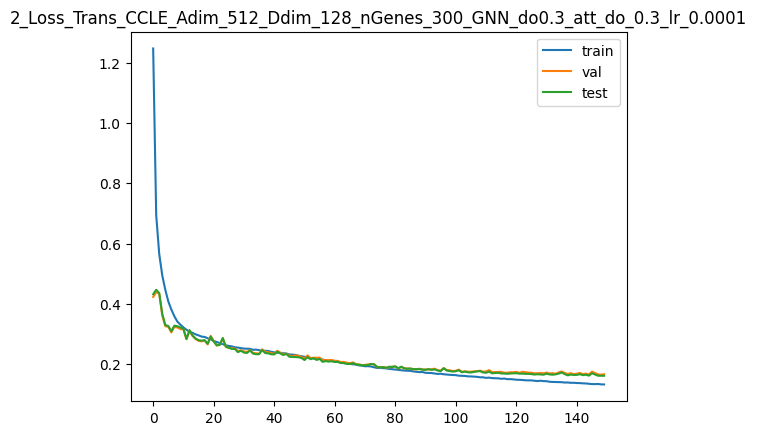

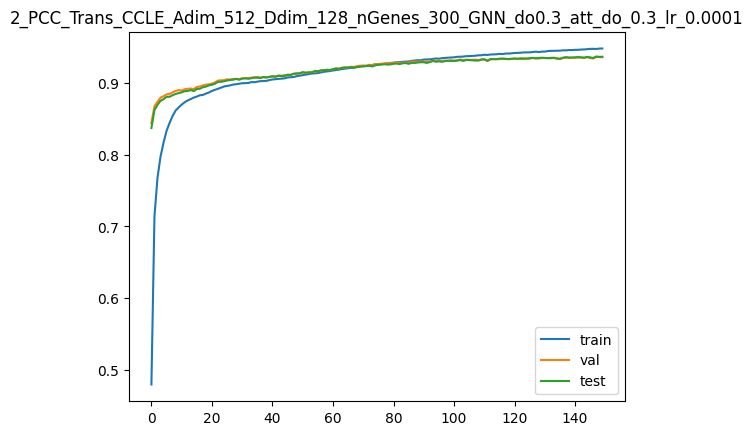

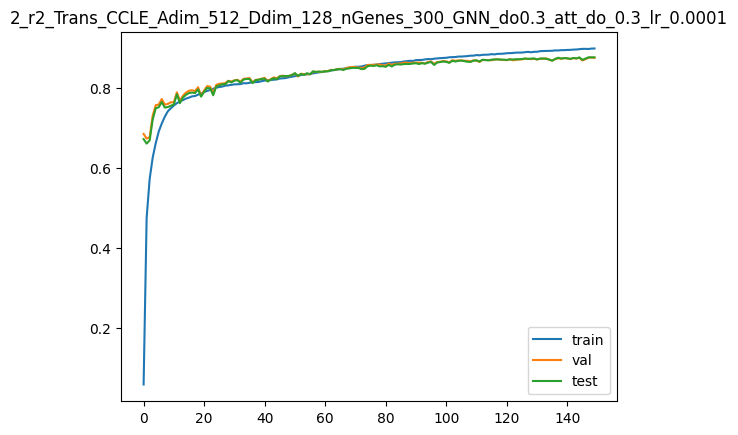

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12951862812042236
The overall Pearson's correlation is 0.9446.
Train avg_loss:  0.13355999
Train avg_pcc:  0.9482893360280635
Train r2:  0.8992501630285445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16665512
Validation avg_pcc:  0.936171625558569
Validation r2:  0.8763582278063997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16145433
Test avg_pcc:  0.9369599463289172
Test r2:  0.877846544250211
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12174181640148163
The overall Pearson's correlation is 0.9548.
Train avg_loss:  0.13261947
Train avg_pcc:  0.9486631524263891
Train r2:  0.899959635969247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1673676
Validation avg_pcc:  0.9361703389721948
Validation r2:  0.8758296330163304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16213861
Test avg_pcc:  0.9370118348166888
Test r2:  0.8773288149407182
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10438356548547745
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.13244939
Train avg_pcc:  0.9487307862250101
Train r2:  0.900087929730233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16599292
Validation avg_pcc:  0.9370408782846793
Validation r2:  0.8768495173943133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16134016
Test avg_pcc:  0.9377225025211604
Test r2:  0.8779329181323213
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13895459473133087
The overall Pearson's correlation is 0.9428.
Train avg_loss:  0.13166276
Train avg_pcc:  0.9490441865975707
Train r2:  0.9006813127482348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16627018
Validation avg_pcc:  0.9365938946539384
Validation r2:  0.876643814453056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16412143
Test avg_pcc:  0.93622418145893
Test r2:  0.8758286602405552
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10900909453630447
The overall Pearson's correlation is 0.9467.
Train avg_loss:  0.13179162
Train avg_pcc:  0.948993251346869
Train r2:  0.9005841119058705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16370852
Validation avg_pcc:  0.9373372084109455
Validation r2:  0.8785443175728543
Best Val r2  0.8785443175728543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16157067
Test avg_pcc:  0.936924717690306
Test r2:  0.8777585242375081
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14473631978034973
The overall Pearson's correlation is 0.9575.
Train avg_loss:  0.13153823
Train avg_pcc:  0.949092757068785
Train r2:  0.9007752508933934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1646277
Validation avg_pcc:  0.9375439588846839
Validation r2:  0.8778623819728574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16024294
Test avg_pcc:  0.9380442349362756
Test r2:  0.878763045420407
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12852565944194794
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.13048334
Train avg_pcc:  0.9495133005579519
Train r2:  0.9015710108720867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16570057
Validation avg_pcc:  0.9365979217156744
Validation r2:  0.8770664090038147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15939173
Test avg_pcc:  0.9378577103042076
Test r2:  0.879407060164916
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12245294451713562
The overall Pearson's correlation is 0.9568.
Train avg_loss:  0.12991934
Train avg_pcc:  0.9497362462256729
Train r2:  0.9019964490366008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16518937
Validation avg_pcc:  0.9368193375421919
Validation r2:  0.8774456710694912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1614494
Test avg_pcc:  0.9370818056547142
Test r2:  0.8778502639414353
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09760917723178864
The overall Pearson's correlation is 0.9714.
Train avg_loss:  0.12929215
Train avg_pcc:  0.949985442535928
Train r2:  0.902469574651202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16580187
Validation avg_pcc:  0.9371683347219933
Validation r2:  0.8769912652545763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16176938
Test avg_pcc:  0.9375095381847636
Test r2:  0.8776081981511119
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10430794954299927
The overall Pearson's correlation is 0.9598.
Train avg_loss:  0.12940305
Train avg_pcc:  0.9499419411403923
Train r2:  0.9023859044634055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16646257
Validation avg_pcc:  0.9363191631673118
Validation r2:  0.8765010863331822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1622538
Test avg_pcc:  0.9367518375326369
Test r2:  0.8772416765329776
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15888693928718567
The overall Pearson's correlation is 0.9393.
Train avg_loss:  0.12916699
Train avg_pcc:  0.9500347537333043
Train r2:  0.9025639821570006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16346748
Validation avg_pcc:  0.9376875147169084
Validation r2:  0.878723152072489
Best Val r2  0.878723152072489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16003612
Test avg_pcc:  0.9378294594439641
Test r2:  0.8789195433400525
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12528958916664124
The overall Pearson's correlation is 0.9503.
Train avg_loss:  0.12822808
Train avg_pcc:  0.950408320347851
Train r2:  0.9032722382478086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1628013
Validation avg_pcc:  0.9377672330544422
Validation r2:  0.8792173928571804
Best Val r2  0.8792173928571804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15935758
Test avg_pcc:  0.9378617599907675
Test r2:  0.8794329039497673
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14091354608535767
The overall Pearson's correlation is 0.9390.
Train avg_loss:  0.12807514
Train avg_pcc:  0.950468424779735
Train r2:  0.9033876061904321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16457778
Validation avg_pcc:  0.9371175816616886
Validation r2:  0.8778994049873896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16131347
Test avg_pcc:  0.9371538600627005
Test r2:  0.8779531094278317
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10029330104589462
The overall Pearson's correlation is 0.9645.
Train avg_loss:  0.12718602
Train avg_pcc:  0.9508212801157041
Train r2:  0.9040583157904661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16277412
Validation avg_pcc:  0.9379355718735991
Validation r2:  0.879237547827579
Best Val r2  0.879237547827579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15900905
Test avg_pcc:  0.9381756114857758
Test r2:  0.8796965867156232
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1936442106962204
The overall Pearson's correlation is 0.9449.
Train avg_loss:  0.12749162
Train avg_pcc:  0.9507001041340273
Train r2:  0.9038277765508845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16677117
Validation avg_pcc:  0.936897612293536
Validation r2:  0.8762721323343429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16117975
Test avg_pcc:  0.9378677394830198
Test r2:  0.8780542889518634
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10355375707149506
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.12668985
Train avg_pcc:  0.9510188350225217
Train r2:  0.9044325922693933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16475442
Validation avg_pcc:  0.9370505287715079
Validation r2:  0.8777683623075533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1591542
Test avg_pcc:  0.9380097681948233
Test r2:  0.8795867757510734
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16960379481315613
The overall Pearson's correlation is 0.9453.
Train avg_loss:  0.12590063
Train avg_pcc:  0.9513305713010491
Train r2:  0.9050279277456026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16262381
Validation avg_pcc:  0.9379872513681152
Validation r2:  0.8793490690129782
Best Val r2  0.8793490690129782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15707031
Test avg_pcc:  0.9389802981509422
Test r2:  0.8811634168519158
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11373898386955261
The overall Pearson's correlation is 0.9440.
Train avg_loss:  0.12547725
Train avg_pcc:  0.951499346018248
Train r2:  0.9053473006759722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16290267
Validation avg_pcc:  0.9378263351236218
Validation r2:  0.8791421802237261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15942068
Test avg_pcc:  0.9379039574339298
Test r2:  0.8793851661432268
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11651405692100525
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.12528169
Train avg_pcc:  0.9515765513849823
Train r2:  0.9054948171001761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16297586
Validation avg_pcc:  0.937790509885964
Validation r2:  0.8790878797075892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15759496
Test avg_pcc:  0.938678739642121
Test r2:  0.8807664686355097
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1455698013305664
The overall Pearson's correlation is 0.9478.
Train avg_loss:  0.124726504
Train avg_pcc:  0.9517959573943681
Train r2:  0.9059136133983189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16392925
Validation avg_pcc:  0.9374000876366282
Validation r2:  0.8783805667495642


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15902525
Test avg_pcc:  0.9381126951908189
Test r2:  0.8796843457869923
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11840996891260147
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.12516415
Train avg_pcc:  0.951622708018769
Train r2:  0.9055834861980614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16401549
Validation avg_pcc:  0.9375540963972164
Validation r2:  0.8783165726490607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15985894
Test avg_pcc:  0.9379743045634457
Test r2:  0.8790535785048107
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10875499248504639
The overall Pearson's correlation is 0.9468.
Train avg_loss:  0.1245171
Train avg_pcc:  0.9518805105204189
Train r2:  0.9060715835396871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16154636
Validation avg_pcc:  0.9382938235370619
Validation r2:  0.8801484282218616
Best Val r2  0.8801484282218616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15802425
Test avg_pcc:  0.938445416663135
Test r2:  0.8804416729063159
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1155402809381485
The overall Pearson's correlation is 0.9661.
Train avg_loss:  0.12385342
Train avg_pcc:  0.9521423908311171
Train r2:  0.9065722257358118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16192652
Validation avg_pcc:  0.9380673914341022
Validation r2:  0.8798663891823463


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15916654
Test avg_pcc:  0.9379314690460095
Test r2:  0.8795774424055961
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1146530881524086
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.12363761
Train avg_pcc:  0.9522278600371984
Train r2:  0.9067350297133955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16348875
Validation avg_pcc:  0.9375476107027936
Validation r2:  0.8787073665377002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15987898
Test avg_pcc:  0.9377236030290236
Test r2:  0.8790384263560523
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.133933886885643
The overall Pearson's correlation is 0.9412.
Train avg_loss:  0.12355737
Train avg_pcc:  0.9522602858222324
Train r2:  0.9067955520173823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16104609
Validation avg_pcc:  0.9388089557047982
Validation r2:  0.8805195897464438
Best Val r2  0.8805195897464438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1575552
Test avg_pcc:  0.938934723943246
Test r2:  0.8807965559074132
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12686173617839813
The overall Pearson's correlation is 0.9428.
Train avg_loss:  0.122802235
Train avg_pcc:  0.9525582835670956
Train r2:  0.9073651781799164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16230254
Validation avg_pcc:  0.9380593633172594
Validation r2:  0.8795874145572111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15766285
Test avg_pcc:  0.9386735188045057
Test r2:  0.8807150956637295
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11197440326213837
The overall Pearson's correlation is 0.9605.
Train avg_loss:  0.12158513
Train avg_pcc:  0.9530405009045088
Train r2:  0.9082832921683276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16256621
Validation avg_pcc:  0.9382318225089505
Validation r2:  0.8793918071971978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15906884
Test avg_pcc:  0.9384508231678264
Test r2:  0.8796513590064728
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09983338415622711
The overall Pearson's correlation is 0.9575.
Train avg_loss:  0.12233279
Train avg_pcc:  0.9527449722794484
Train r2:  0.9077193052794156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16193849
Validation avg_pcc:  0.9384948831040396
Validation r2:  0.8798575131637274


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15953332
Test avg_pcc:  0.9381679885844328
Test r2:  0.8792999467538679
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11118156462907791
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.122510396
Train avg_pcc:  0.9526738268725203
Train r2:  0.9075853264071899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16354096
Validation avg_pcc:  0.937486162285536
Validation r2:  0.878668631949098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16093457
Test avg_pcc:  0.9372654040332733
Test r2:  0.8782397896597142
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12117166817188263
The overall Pearson's correlation is 0.9405.
Train avg_loss:  0.122091606
Train avg_pcc:  0.9528396011471062
Train r2:  0.9079012336111754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16019176
Validation avg_pcc:  0.9388021350077365
Validation r2:  0.8811534203911391
Best Val r2  0.8811534203911391


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15715301
Test avg_pcc:  0.9387951397836859
Test r2:  0.8811008459030838
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16830477118492126
The overall Pearson's correlation is 0.9454.
Train avg_loss:  0.12079783
Train avg_pcc:  0.9533517006716887
Train r2:  0.9088771791430211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16168256
Validation avg_pcc:  0.9381139342293171
Validation r2:  0.8800473778334941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1571369
Test avg_pcc:  0.9386813845763052
Test r2:  0.881113022428922
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11860314011573792
The overall Pearson's correlation is 0.9536.
Train avg_loss:  0.12080243
Train avg_pcc:  0.9533502506580398
Train r2:  0.9088737039376042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1631786
Validation avg_pcc:  0.9377687835216949
Validation r2:  0.8789374624037734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15839083
Test avg_pcc:  0.9384435948656136
Test r2:  0.8801643242499092
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1246446818113327
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.1205235
Train avg_pcc:  0.9534601611762132
Train r2:  0.9090841367189746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15956256
Validation avg_pcc:  0.9391590674744967
Validation r2:  0.8816202180075108
Best Val r2  0.8816202180075108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1580978
Test avg_pcc:  0.9385619738265961
Test r2:  0.8803860366303214
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10044696927070618
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.12044679
Train avg_pcc:  0.9534914816714446
Train r2:  0.9091419862866822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16114782
Validation avg_pcc:  0.9383435504539457
Validation r2:  0.8804441075092606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15700886
Test avg_pcc:  0.9387486832438422
Test r2:  0.88120991868413
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11346094310283661
The overall Pearson's correlation is 0.9511.
Train avg_loss:  0.1197204
Train avg_pcc:  0.9537783781592923
Train r2:  0.9096899343144322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16089274
Validation avg_pcc:  0.938520224899086
Validation r2:  0.8806333556886112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15861265
Test avg_pcc:  0.938186629715122
Test r2:  0.8799964992032292
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14644482731819153
The overall Pearson's correlation is 0.9422.
Train avg_loss:  0.119668566
Train avg_pcc:  0.9537988030172427
Train r2:  0.9097290457281896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16202036
Validation avg_pcc:  0.9380272624313394
Validation r2:  0.8797967753870204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15888405
Test avg_pcc:  0.9380061936658759
Test r2:  0.8797911679058327
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11766912043094635
The overall Pearson's correlation is 0.9555.
Train avg_loss:  0.119307816
Train avg_pcc:  0.9539416080345381
Train r2:  0.9100011639332818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16310474
Validation avg_pcc:  0.9381758531588089
Validation r2:  0.878992255706371


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15821762
Test avg_pcc:  0.938899992192038
Test r2:  0.8802953755494701
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08154813200235367
The overall Pearson's correlation is 0.9722.
Train avg_loss:  0.118953645
Train avg_pcc:  0.9540811927299047
Train r2:  0.9102683399696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15841809
Validation avg_pcc:  0.9394067551768047
Validation r2:  0.882469301392341
Best Val r2  0.882469301392341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15486959
Test avg_pcc:  0.939597860702475
Test r2:  0.8828284462092575
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09747061133384705
The overall Pearson's correlation is 0.9500.
Train avg_loss:  0.118148215
Train avg_pcc:  0.9544001246063827
Train r2:  0.9108759041835823


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16329996
Validation avg_pcc:  0.9376896229221168
Validation r2:  0.8788474296330878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15829821
Test avg_pcc:  0.938406315687091
Test r2:  0.8802344134488579
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.127120703458786
The overall Pearson's correlation is 0.9464.
Train avg_loss:  0.11743708
Train avg_pcc:  0.954680086916565
Train r2:  0.9114123434098196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16284746
Validation avg_pcc:  0.9385403395553009
Validation r2:  0.8791831418959786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16058683
Test avg_pcc:  0.9382749148613064
Test r2:  0.8785028674784771
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1160123199224472
The overall Pearson's correlation is 0.9583.
Train avg_loss:  0.118290834
Train avg_pcc:  0.9543432378147133
Train r2:  0.9107683164154188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16169375
Validation avg_pcc:  0.9382597367578235
Validation r2:  0.8800390843568977


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15736519
Test avg_pcc:  0.9387634762935532
Test r2:  0.8809403087852136
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08200009167194366
The overall Pearson's correlation is 0.9664.
Train avg_loss:  0.11737982
Train avg_pcc:  0.9547028531608934
Train r2:  0.9114555319371083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16143905
Validation avg_pcc:  0.9387276700384997
Validation r2:  0.8802280503984063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1574232
Test avg_pcc:  0.939123411406155
Test r2:  0.880896428349557
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1262972354888916
The overall Pearson's correlation is 0.9263.
Train avg_loss:  0.11717234
Train avg_pcc:  0.9547854484845157
Train r2:  0.9116120362544807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15904647
Validation avg_pcc:  0.9392319929525031
Validation r2:  0.8820031094935368


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15430796
Test avg_pcc:  0.9398955319637883
Test r2:  0.8832533536158106
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11458035558462143
The overall Pearson's correlation is 0.9453.
Train avg_loss:  0.117034525
Train avg_pcc:  0.954839600085916
Train r2:  0.9117160100844515


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16067266
Validation avg_pcc:  0.9385862904196683
Validation r2:  0.8807966224814437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15786637
Test avg_pcc:  0.9384224069453222
Test r2:  0.8805611158719358
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10708370059728622
The overall Pearson's correlation is 0.9548.
Train avg_loss:  0.116634466
Train avg_pcc:  0.954997667258104
Train r2:  0.9120177824376403


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15990445
Validation avg_pcc:  0.9389733944228726
Validation r2:  0.8813665712488639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15665603
Test avg_pcc:  0.9390092549402574
Test r2:  0.8814768531611442
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11872956156730652
The overall Pearson's correlation is 0.9604.
Train avg_loss:  0.11557846
Train avg_pcc:  0.9554142788099461
Train r2:  0.9128143700782305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.162983
Validation avg_pcc:  0.9390931533173608
Validation r2:  0.8790825829229498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15886027
Test avg_pcc:  0.9395249442854494
Test r2:  0.8798091742401295
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08238069713115692
The overall Pearson's correlation is 0.9737.
Train avg_loss:  0.1154921
Train avg_pcc:  0.9554489021868879
Train r2:  0.9128795205882541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16124149
Validation avg_pcc:  0.9385684400184919
Validation r2:  0.8803746124878481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15799138
Test avg_pcc:  0.9386067714601836
Test r2:  0.8804665402649092
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08417190611362457
The overall Pearson's correlation is 0.9645.
Train avg_loss:  0.11536483
Train avg_pcc:  0.9554987020953138
Train r2:  0.9129755144960302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1583438
Validation avg_pcc:  0.9395536836524225
Validation r2:  0.8825244094788416
Best Val r2  0.8825244094788416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15469348
Test avg_pcc:  0.9397892736459705
Test r2:  0.8829616803339071
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10237158834934235
The overall Pearson's correlation is 0.9629.
Train avg_loss:  0.11475158
Train avg_pcc:  0.9557408935003685
Train r2:  0.9134381237492166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16143973
Validation avg_pcc:  0.9389814744443861
Validation r2:  0.8802275352659911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1576719
Test avg_pcc:  0.9392843659872662
Test r2:  0.8807082652596018
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.107733353972435
The overall Pearson's correlation is 0.9515.
Train avg_loss:  0.11507917
Train avg_pcc:  0.955611332160744
Train r2:  0.913191005099873


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16204834
Validation avg_pcc:  0.9393584494584473
Validation r2:  0.8797760110572265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15963173
Test avg_pcc:  0.9391272445965199
Test r2:  0.8792254857054425


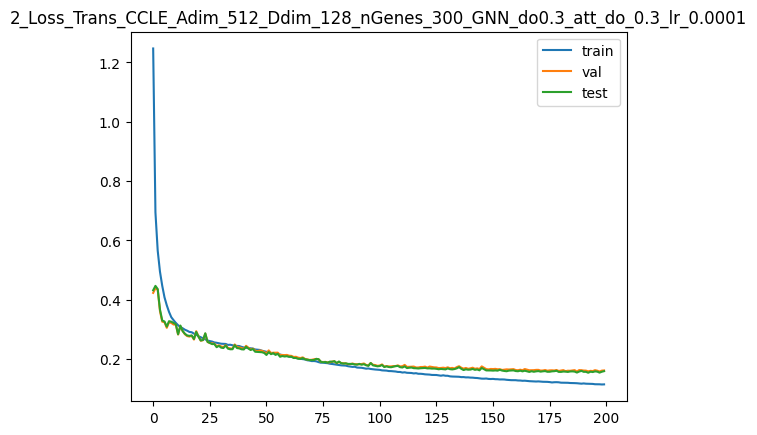

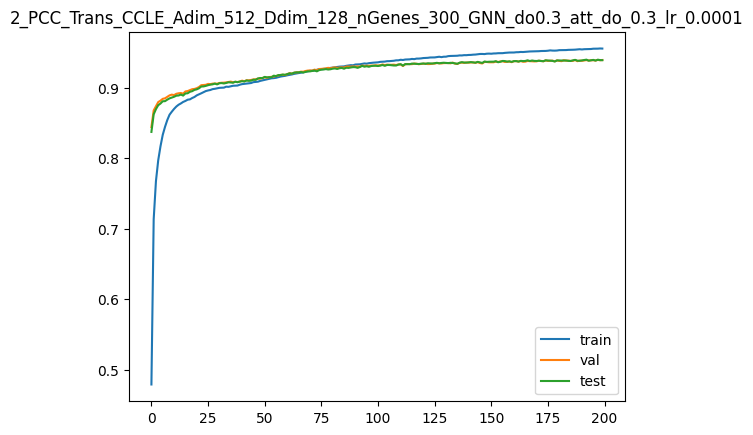

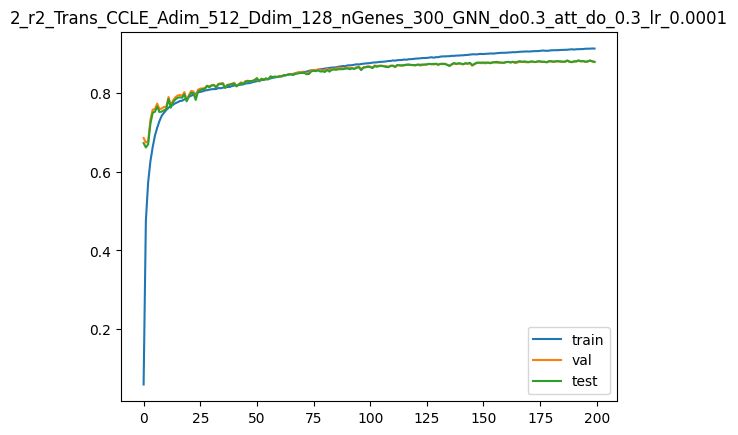

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15469348
Test avg_pcc:  0.9397892734771767
Test r2:  0.8829616800974542


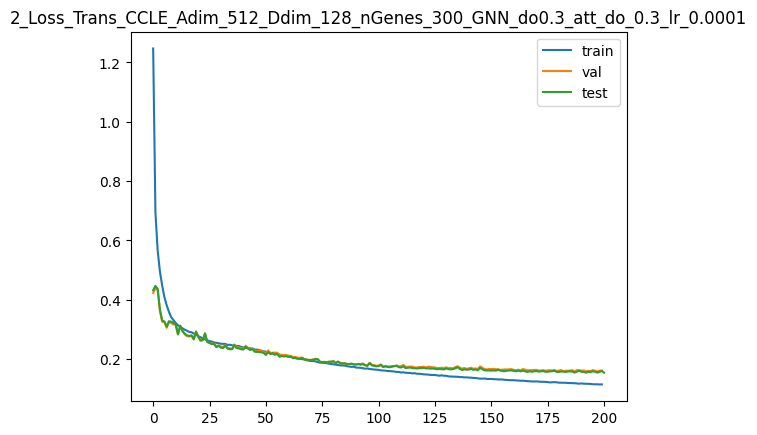

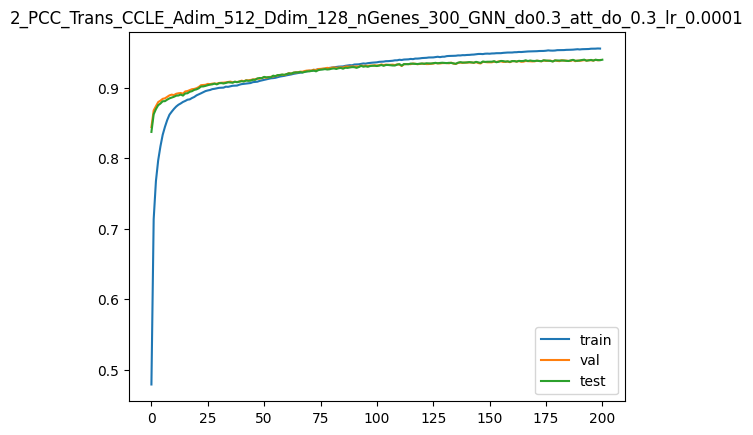

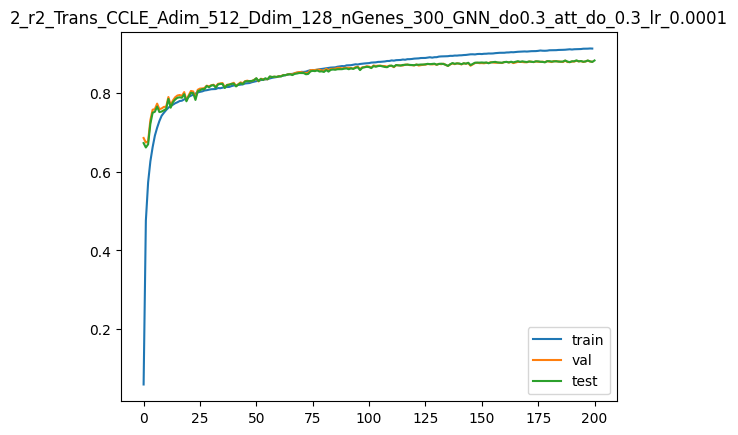

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.9920351505279541
The overall Pearson's correlation is 0.6542.
Train avg_loss:  1.1908154
Train avg_pcc:  0.5005368480149723
Train r2:  0.10053174033465617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.37404913
Validation avg_pcc:  0.8580282230586236
Validation r2:  0.7276083965276641
Best Val r2  0.7276083965276641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.39158696
Test avg_pcc:  0.8460117765055479
Test r2:  0.7040699459953355
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6608463525772095
The overall Pearson's correlation is 0.7788.
Train avg_loss:  0.6973922
Train avg_pcc:  0.7114932159266495
Train r2:  0.4732331578352912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38538697
Validation avg_pcc:  0.8709199360753495
Validation r2:  0.7193519069499221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.39952013
Test avg_pcc:  0.861582526139332
Test r2:  0.6980746924483321
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6541935205459595
The overall Pearson's correlation is 0.7802.
Train avg_loss:  0.56809896
Train avg_pcc:  0.7664838249947316
Train r2:  0.5708932269251021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34598178
Validation avg_pcc:  0.8806935502228678
Validation r2:  0.7480476914175651
Best Val r2  0.7480476914175651


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35688218
Test avg_pcc:  0.8724291679382933
Test r2:  0.7302970611446253
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4899687170982361
The overall Pearson's correlation is 0.7611.
Train avg_loss:  0.49247578
Train avg_pcc:  0.7977773649282213
Train r2:  0.6280143245794225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34308368
Validation avg_pcc:  0.8829961075837442
Validation r2:  0.7501581780489803
Best Val r2  0.7501581780489803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35322672
Test avg_pcc:  0.8757494104055609
Test r2:  0.7330595389177597
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6832351684570312
The overall Pearson's correlation is 0.7325.
Train avg_loss:  0.44630638
Train avg_pcc:  0.8169727070800118
Train r2:  0.6628878279211231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36685163
Validation avg_pcc:  0.8864088791934616
Validation r2:  0.7328497713528654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3778616
Test avg_pcc:  0.8790663985947924
Test r2:  0.7144424988727276
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3708665072917938
The overall Pearson's correlation is 0.8408.
Train avg_loss:  0.4058888
Train avg_pcc:  0.8341216500260126
Train r2:  0.693416730774058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32267594
Validation avg_pcc:  0.8875401253206561
Validation r2:  0.7650195833662204
Best Val r2  0.7650195833662204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33163318
Test avg_pcc:  0.8803579506397722
Test r2:  0.749378225422142
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3042958378791809
The overall Pearson's correlation is 0.8806.
Train avg_loss:  0.37893593
Train avg_pcc:  0.8455579464805546
Train r2:  0.713775292095082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31523725
Validation avg_pcc:  0.8899366072495727
Validation r2:  0.7704366089452073
Best Val r2  0.7704366089452073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3261556
Test avg_pcc:  0.8823067956130507
Test r2:  0.753517730248759
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36063623428344727
The overall Pearson's correlation is 0.8632.
Train avg_loss:  0.36084807
Train avg_pcc:  0.8532225414305474
Train r2:  0.7274377494979881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2985217
Validation avg_pcc:  0.8905226117408275
Validation r2:  0.7826092931858657
Best Val r2  0.7826092931858657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30404842
Test avg_pcc:  0.8844189535068661
Test r2:  0.7702245600334747
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.33371657133102417
The overall Pearson's correlation is 0.8197.
Train avg_loss:  0.3422776
Train avg_pcc:  0.8612340146448231
Train r2:  0.7414647018406486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3057896
Validation avg_pcc:  0.8915416765930827
Validation r2:  0.7773166177052795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31201944
Test avg_pcc:  0.8854304673520236
Test r2:  0.7642007131111296
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31299692392349243
The overall Pearson's correlation is 0.8485.
Train avg_loss:  0.3282808
Train avg_pcc:  0.8672734542697451
Train r2:  0.7520370203066045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28881124
Validation avg_pcc:  0.8916779847953853
Validation r2:  0.7896806876640077
Best Val r2  0.7896806876640077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29667756
Test avg_pcc:  0.8850279901537674
Test r2:  0.7757948815485077
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35288143157958984
The overall Pearson's correlation is 0.8247.
Train avg_loss:  0.32207516
Train avg_pcc:  0.8699422820093432
Train r2:  0.7567244130922649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29136178
Validation avg_pcc:  0.8936318481245038
Validation r2:  0.7878233287809293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29936013
Test avg_pcc:  0.887045408337602
Test r2:  0.7737676037909025
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3809235692024231
The overall Pearson's correlation is 0.8534.
Train avg_loss:  0.31375957
Train avg_pcc:  0.8735309176117959
Train r2:  0.7630054460015785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2811074
Validation avg_pcc:  0.8948688903048098
Validation r2:  0.795290804734041
Best Val r2  0.795290804734041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28919435
Test avg_pcc:  0.888149311512523
Test r2:  0.7814500851728408
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31852811574935913
The overall Pearson's correlation is 0.8566.
Train avg_loss:  0.30773753
Train avg_pcc:  0.8761169868889668
Train r2:  0.7675541339983444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.304847
Validation avg_pcc:  0.8945286462505162
Validation r2:  0.7780030366458895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31123665
Test avg_pcc:  0.8891283746035394
Test r2:  0.76479230881078
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2945587933063507
The overall Pearson's correlation is 0.8927.
Train avg_loss:  0.30459458
Train avg_pcc:  0.8774722806568294
Train r2:  0.7699281191632877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29539084
Validation avg_pcc:  0.8962658899259834
Validation r2:  0.7848892581312619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30189738
Test avg_pcc:  0.8909331518393608
Test r2:  0.7718501397608459
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3597792983055115
The overall Pearson's correlation is 0.8544.
Train avg_loss:  0.2982427
Train avg_pcc:  0.8801975449814994
Train r2:  0.774725933575984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2727191
Validation avg_pcc:  0.8958138511367781
Validation r2:  0.8013993521220584
Best Val r2  0.8013993521220584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27797186
Test avg_pcc:  0.8899258688110416
Test r2:  0.7899311338470045
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35733234882354736
The overall Pearson's correlation is 0.8761.
Train avg_loss:  0.29810065
Train avg_pcc:  0.8802558304253837
Train r2:  0.774833243572189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27670196
Validation avg_pcc:  0.8958685739217679
Validation r2:  0.7984989418062266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2831974
Test avg_pcc:  0.88965685161928
Test r2:  0.7859820947538072
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31125175952911377
The overall Pearson's correlation is 0.8922.
Train avg_loss:  0.29409745
Train avg_pcc:  0.8819743828085259
Train r2:  0.7778570109748579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2757683
Validation avg_pcc:  0.8958519238647029
Validation r2:  0.7991788391413539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27493256
Test avg_pcc:  0.8924741347935611
Test r2:  0.7922279898831897
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32108551263809204
The overall Pearson's correlation is 0.8863.
Train avg_loss:  0.29096115
Train avg_pcc:  0.8833126051073152
Train r2:  0.7802259927300237


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27304804
Validation avg_pcc:  0.8988948976804524
Validation r2:  0.8011598216295384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27806097
Test avg_pcc:  0.8935502060175182
Test r2:  0.7898637969709761
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3601081073284149
The overall Pearson's correlation is 0.8634.
Train avg_loss:  0.28746942
Train avg_pcc:  0.8848013414409119
Train r2:  0.7828634061275936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28526857
Validation avg_pcc:  0.8981046246859418
Validation r2:  0.7922605440962285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28804833
Test avg_pcc:  0.8941422056389055
Test r2:  0.7823161643620691
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2828139364719391
The overall Pearson's correlation is 0.8976.
Train avg_loss:  0.28276813
Train avg_pcc:  0.8868076733820223
Train r2:  0.7864144583221228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28810552
Validation avg_pcc:  0.8981962018485597
Validation r2:  0.7901946016451729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29407108
Test avg_pcc:  0.8934766133932152
Test r2:  0.7777646512086264
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2929871380329132
The overall Pearson's correlation is 0.8992.
Train avg_loss:  0.27802214
Train avg_pcc:  0.8888262028087662
Train r2:  0.7899993137580918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26086113
Validation avg_pcc:  0.9030791805749532
Validation r2:  0.810034603880654
Best Val r2  0.810034603880654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26597324
Test avg_pcc:  0.8978728727107503
Test r2:  0.7989987285561778
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20847231149673462
The overall Pearson's correlation is 0.9153.
Train avg_loss:  0.27288777
Train avg_pcc:  0.8910050854505056
Train r2:  0.7938774809048723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26311526
Validation avg_pcc:  0.903332231000121
Validation r2:  0.8083931163959891


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26893878
Test avg_pcc:  0.8979468012521006
Test r2:  0.7967576046372481
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22236324846744537
The overall Pearson's correlation is 0.9147.
Train avg_loss:  0.26950523
Train avg_pcc:  0.8924377950607555
Train r2:  0.7964324448098381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25146425
Validation avg_pcc:  0.9067290682405209
Validation r2:  0.816877673587808
Best Val r2  0.816877673587808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2577821
Test avg_pcc:  0.901088700290712
Test r2:  0.8051889448001148
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3014237582683563
The overall Pearson's correlation is 0.9359.
Train avg_loss:  0.26570168
Train avg_pcc:  0.894045195615265
Train r2:  0.799305409483292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2674254
Validation avg_pcc:  0.9033798810231436
Validation r2:  0.8052543768713394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26940432
Test avg_pcc:  0.8998556808207111
Test r2:  0.7964057971179787
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19761118292808533
The overall Pearson's correlation is 0.9265.
Train avg_loss:  0.2632403
Train avg_pcc:  0.8950858139042852
Train r2:  0.8011645689334428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2640462
Validation avg_pcc:  0.9047276404653722
Validation r2:  0.8077151635363349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26404238
Test avg_pcc:  0.901690481094976
Test r2:  0.8004578962795925
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17808695137500763
The overall Pearson's correlation is 0.9143.
Train avg_loss:  0.26077652
Train avg_pcc:  0.8961236002402779
Train r2:  0.80302558899481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2569098
Validation avg_pcc:  0.9054774159377552
Validation r2:  0.8129120907550034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25930217
Test avg_pcc:  0.9017183696840463
Test r2:  0.8040402111419911
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25011804699897766
The overall Pearson's correlation is 0.8921.
Train avg_loss:  0.2604087
Train avg_pcc:  0.8962801193764014
Train r2:  0.803303377413641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24663259
Validation avg_pcc:  0.9080469477150825
Validation r2:  0.8203961918847231
Best Val r2  0.8203961918847231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25011745
Test avg_pcc:  0.902997000693958
Test r2:  0.8109812888922139
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19757933914661407
The overall Pearson's correlation is 0.9113.
Train avg_loss:  0.25614914
Train avg_pcc:  0.898071319767236
Train r2:  0.8065208145470176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24602167
Validation avg_pcc:  0.9071645839345772
Validation r2:  0.8208410923174716
Best Val r2  0.8208410923174716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24755237
Test avg_pcc:  0.9032428887028597
Test r2:  0.8129197603556856
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19404402375221252
The overall Pearson's correlation is 0.9082.
Train avg_loss:  0.254925
Train avg_pcc:  0.8985864699017386
Train r2:  0.8074454401155369


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2446564
Validation avg_pcc:  0.9069879447539105
Validation r2:  0.8218353028428711
Best Val r2  0.8218353028428711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24588934
Test avg_pcc:  0.9031828458288913
Test r2:  0.8141765494431016
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18550248444080353
The overall Pearson's correlation is 0.8985.
Train avg_loss:  0.2557756
Train avg_pcc:  0.89822786032489
Train r2:  0.8068029740355479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25904003
Validation avg_pcc:  0.9056401317192827
Validation r2:  0.8113607855003382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25962016
Test avg_pcc:  0.9024846978230937
Test r2:  0.803799882970564
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3011561632156372
The overall Pearson's correlation is 0.8535.
Train avg_loss:  0.252316
Train avg_pcc:  0.8996828909629471
Train r2:  0.8094161318148881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24182326
Validation avg_pcc:  0.908807323015151
Validation r2:  0.8238984729552832
Best Val r2  0.8238984729552832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24503136
Test avg_pcc:  0.904212988470712
Test r2:  0.8148249372708151
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26667147874832153
The overall Pearson's correlation is 0.8832.
Train avg_loss:  0.2506301
Train avg_pcc:  0.9003890943381683
Train r2:  0.8106895616799435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24599212
Validation avg_pcc:  0.9084119473734946
Validation r2:  0.8208626013309674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2496198
Test avg_pcc:  0.9041053214509265
Test r2:  0.8113573615537112
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21180742979049683
The overall Pearson's correlation is 0.9174.
Train avg_loss:  0.25002906
Train avg_pcc:  0.9006401568992681
Train r2:  0.8111435383953639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24963838
Validation avg_pcc:  0.908939126193767
Validation r2:  0.8182073050639896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25246957
Test avg_pcc:  0.9049913523828872
Test r2:  0.809203716803969
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22465059161186218
The overall Pearson's correlation is 0.8902.
Train avg_loss:  0.2481157
Train avg_pcc:  0.9014425974235487
Train r2:  0.8125887526320408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23967326
Validation avg_pcc:  0.9098331206328989
Validation r2:  0.8254641433688206
Best Val r2  0.8254641433688206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24273907
Test avg_pcc:  0.9054733546228413
Test r2:  0.8165572610513956
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3739214837551117
The overall Pearson's correlation is 0.8149.
Train avg_loss:  0.24598905
Train avg_pcc:  0.9023319039196482
Train r2:  0.8141951193136401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24685208
Validation avg_pcc:  0.9079984882349964
Validation r2:  0.8202363457547047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24478187
Test avg_pcc:  0.9056277439933159
Test r2:  0.8150134894974508
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2550431787967682
The overall Pearson's correlation is 0.9043.
Train avg_loss:  0.2460038
Train avg_pcc:  0.9023289057108166
Train r2:  0.8141839795206839


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24385302
Validation avg_pcc:  0.909499399993551
Validation r2:  0.8224203454830799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24545087
Test avg_pcc:  0.9059927683501968
Test r2:  0.814507891674935
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24422544240951538
The overall Pearson's correlation is 0.8982.
Train avg_loss:  0.24511181
Train avg_pcc:  0.90269821137382
Train r2:  0.8148577261867018


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23880263
Validation avg_pcc:  0.9105089284464782
Validation r2:  0.8260981580330314
Best Val r2  0.8260981580330314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24225324
Test avg_pcc:  0.9060162376049286
Test r2:  0.8169244246039375
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2580938935279846
The overall Pearson's correlation is 0.8793.
Train avg_loss:  0.24378559
Train avg_pcc:  0.9032561943819131
Train r2:  0.8158594695198937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23988307
Validation avg_pcc:  0.9094385604633878
Validation r2:  0.8253113570392093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23862368
Test avg_pcc:  0.9067644856669452
Test r2:  0.819667349155726
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26976263523101807
The overall Pearson's correlation is 0.9169.
Train avg_loss:  0.24302797
Train avg_pcc:  0.903569265046948
Train r2:  0.8164317471719321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2429035
Validation avg_pcc:  0.9094585404960549
Validation r2:  0.8231118108826969


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24403976
Test avg_pcc:  0.9058138503104333
Test r2:  0.8155743155194991
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1992664635181427
The overall Pearson's correlation is 0.8995.
Train avg_loss:  0.2410557
Train avg_pcc:  0.9043961015623471
Train r2:  0.817921483430023


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23603936
Validation avg_pcc:  0.9104614734272791
Validation r2:  0.8281104457759884
Best Val r2  0.8281104457759884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2426341
Test avg_pcc:  0.9045208323178603
Test r2:  0.8166366024428399
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.28154441714286804
The overall Pearson's correlation is 0.9096.
Train avg_loss:  0.23970132
Train avg_pcc:  0.904958829612475
Train r2:  0.818944479738937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23431951
Validation avg_pcc:  0.9117348533458471
Validation r2:  0.8293628600565845
Best Val r2  0.8293628600565845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23832162
Test avg_pcc:  0.9070399813732148
Test r2:  0.8198956297633322
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18541935086250305
The overall Pearson's correlation is 0.9222.
Train avg_loss:  0.23911569
Train avg_pcc:  0.9052039274845388
Train r2:  0.8193868641258198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24037433
Validation avg_pcc:  0.9110769972135074
Validation r2:  0.8249536014012361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24291265
Test avg_pcc:  0.9071665678699301
Test r2:  0.8164260710374394
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24303267896175385
The overall Pearson's correlation is 0.8901.
Train avg_loss:  0.23741156
Train avg_pcc:  0.9059142509932323
Train r2:  0.820674027490155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23914771
Validation avg_pcc:  0.9112004707529936
Validation r2:  0.8258468582883811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24018854
Test avg_pcc:  0.9075118682410029
Test r2:  0.8184847409513009
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24873296916484833
The overall Pearson's correlation is 0.9048.
Train avg_loss:  0.23617697
Train avg_pcc:  0.9064299871900645
Train r2:  0.8216065638310075


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23755085
Validation avg_pcc:  0.9105144584322173
Validation r2:  0.8270097423344678


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23997852
Test avg_pcc:  0.9063091636405296
Test r2:  0.8186434617102597
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20170044898986816
The overall Pearson's correlation is 0.8879.
Train avg_loss:  0.23614798
Train avg_pcc:  0.9064409895780547
Train r2:  0.8216284510885205


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23292005
Validation avg_pcc:  0.9116020453537094
Validation r2:  0.8303819785738313
Best Val r2  0.8303819785738313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23367421
Test avg_pcc:  0.90801432078388
Test r2:  0.8234077619672495
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2839404344558716
The overall Pearson's correlation is 0.8806.
Train avg_loss:  0.23454319
Train avg_pcc:  0.9071097708643575
Train r2:  0.8228406173276874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23082893
Validation avg_pcc:  0.9133777433665261
Validation r2:  0.8319048054421194
Best Val r2  0.8319048054421194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2331206
Test avg_pcc:  0.9093543073201681
Test r2:  0.8238261213203776
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2220267951488495
The overall Pearson's correlation is 0.9188.
Train avg_loss:  0.2320763
Train avg_pcc:  0.9081360071050926
Train r2:  0.8247039216113045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23033586
Validation avg_pcc:  0.9131742228701314
Validation r2:  0.8322638608271543
Best Val r2  0.8322638608271543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23275436
Test avg_pcc:  0.9090996281886086
Test r2:  0.8241029174289256
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21780666708946228
The overall Pearson's correlation is 0.9196.
Train avg_loss:  0.23069336
Train avg_pcc:  0.9087110308353029
Train r2:  0.8257485371363724


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23146835
Validation avg_pcc:  0.9120890951327776
Validation r2:  0.8314391475393162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2311171
Test avg_pcc:  0.9088587785101677
Test r2:  0.8253402127805001
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24222394824028015
The overall Pearson's correlation is 0.9217.
Train avg_loss:  0.22871663
Train avg_pcc:  0.9095309507270627
Train r2:  0.8272416421639994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22275364
Validation avg_pcc:  0.9153408433916363
Validation r2:  0.8377854210832838
Best Val r2  0.8377854210832838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22631414
Test avg_pcc:  0.9106235482607951
Test r2:  0.8289699088995023
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21105210483074188
The overall Pearson's correlation is 0.9169.
Train avg_loss:  0.22728063
Train avg_pcc:  0.9101278943414182
Train r2:  0.8283262979417976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22714373
Validation avg_pcc:  0.9135993507827711
Validation r2:  0.8345884375218213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22743212
Test avg_pcc:  0.9101492007099147
Test r2:  0.8281250319379718


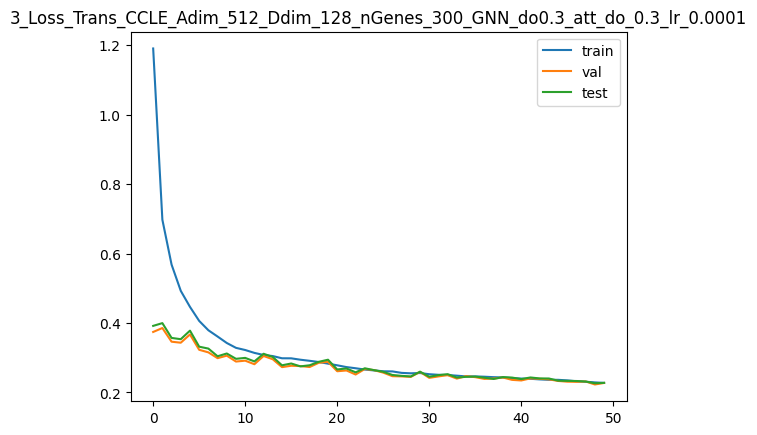

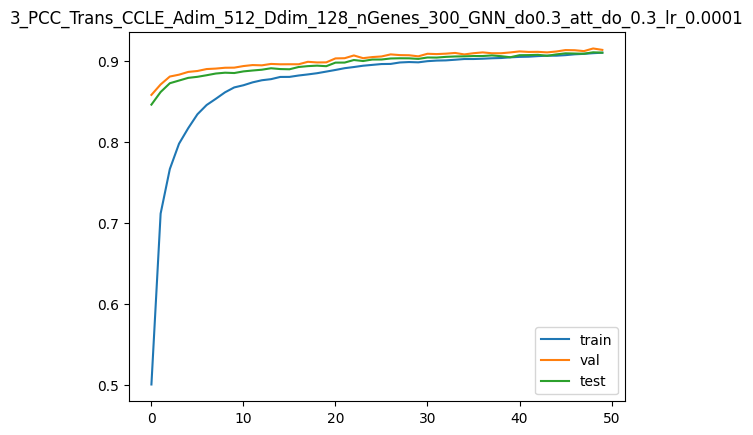

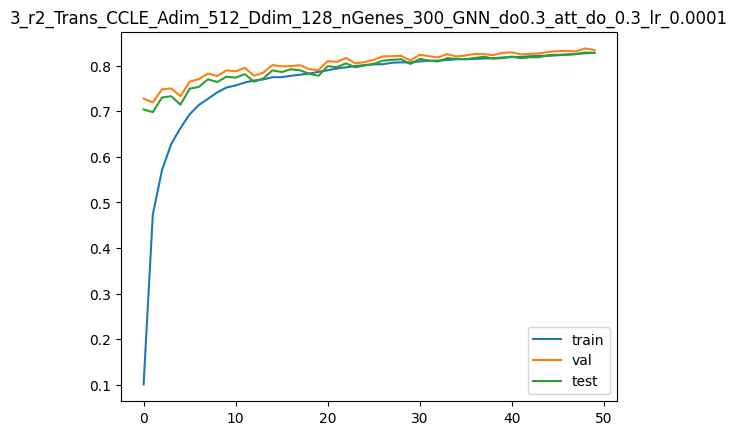

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20113059878349304
The overall Pearson's correlation is 0.9268.
Train avg_loss:  0.22646311
Train avg_pcc:  0.9104678423699963
Train r2:  0.8289438070814071


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22668126
Validation avg_pcc:  0.9142803975657178
Validation r2:  0.8349252334521795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22677614
Test avg_pcc:  0.9109832453861965
Test r2:  0.8286207662022522
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21132048964500427
The overall Pearson's correlation is 0.9410.
Train avg_loss:  0.22380482
Train avg_pcc:  0.911568505050569
Train r2:  0.8309516977496038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23089504
Validation avg_pcc:  0.9136846021761594
Validation r2:  0.8318566532643414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23206921
Test avg_pcc:  0.9102625520616254
Test r2:  0.824620677447117
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2090427428483963
The overall Pearson's correlation is 0.9211.
Train avg_loss:  0.22146696
Train avg_pcc:  0.912535732989329
Train r2:  0.8327175631546967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23233996
Validation avg_pcc:  0.915094744812129
Validation r2:  0.8308044190419621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23395222
Test avg_pcc:  0.9118933671955095
Test r2:  0.8231976625914198
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21097610890865326
The overall Pearson's correlation is 0.9092.
Train avg_loss:  0.21953768
Train avg_pcc:  0.9133363697210314
Train r2:  0.8341748572181266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22963038
Validation avg_pcc:  0.9151214439250845
Validation r2:  0.8327776007361789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22848172
Test avg_pcc:  0.9123503368246545
Test r2:  0.8273318306410345
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3032107651233673
The overall Pearson's correlation is 0.8635.
Train avg_loss:  0.2184179
Train avg_pcc:  0.9137968410135212
Train r2:  0.8350206551399817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22167647
Validation avg_pcc:  0.9168965924379298
Validation r2:  0.8385698542575174
Best Val r2  0.8385698542575174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22457862
Test avg_pcc:  0.912881144830049
Test r2:  0.8302814679537976
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27831652760505676
The overall Pearson's correlation is 0.8810.
Train avg_loss:  0.21661772
Train avg_pcc:  0.9145411194868203
Train r2:  0.8363803990970874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22180843
Validation avg_pcc:  0.9171594361801557
Validation r2:  0.8384737506287112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22567953
Test avg_pcc:  0.9127584792768529
Test r2:  0.8294494977668267
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24640469253063202
The overall Pearson's correlation is 0.9020.
Train avg_loss:  0.21570627
Train avg_pcc:  0.9149173312816092
Train r2:  0.837068853560188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2172952
Validation avg_pcc:  0.9179963955897242
Validation r2:  0.8417603778544559
Best Val r2  0.8417603778544559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21847063
Test avg_pcc:  0.9145728628346315
Test r2:  0.8348974119158019
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20001688599586487
The overall Pearson's correlation is 0.9116.
Train avg_loss:  0.21411046
Train avg_pcc:  0.9155770927896354
Train r2:  0.8382742323650354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21414547
Validation avg_pcc:  0.9188800907244743
Validation r2:  0.8440541042010908
Best Val r2  0.8440541042010908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21535921
Test avg_pcc:  0.9152070569865842
Test r2:  0.8372487656889099
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19127464294433594
The overall Pearson's correlation is 0.9246.
Train avg_loss:  0.21127327
Train avg_pcc:  0.9167462451341714
Train r2:  0.8404172778999581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21741459
Validation avg_pcc:  0.9177595114942254
Validation r2:  0.8416734374486446


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21690485
Test avg_pcc:  0.914866477006561
Test r2:  0.8360807035136213
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1744355410337448
The overall Pearson's correlation is 0.9154.
Train avg_loss:  0.20967917
Train avg_pcc:  0.9174012701773786
Train r2:  0.8416213571123541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22080101
Validation avg_pcc:  0.9177200038510577
Validation r2:  0.8392073735051042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22171748
Test avg_pcc:  0.9144606158909361
Test r2:  0.832443688040236
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24202242493629456
The overall Pearson's correlation is 0.9075.
Train avg_loss:  0.20802969
Train avg_pcc:  0.9180813411936606
Train r2:  0.8428672705770872


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21486428
Validation avg_pcc:  0.9185556420478276
Validation r2:  0.8435306531786468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21378435
Test avg_pcc:  0.9158923540320005
Test r2:  0.8384389125823212
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18206897377967834
The overall Pearson's correlation is 0.9092.
Train avg_loss:  0.20691077
Train avg_pcc:  0.9185403808275363
Train r2:  0.843712410962247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21473308
Validation avg_pcc:  0.9188917077759267
Validation r2:  0.843626182661802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21350092
Test avg_pcc:  0.9164029064884369
Test r2:  0.8386531165301738
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16800828278064728
The overall Pearson's correlation is 0.9212.
Train avg_loss:  0.2051723
Train avg_pcc:  0.9192566951516409
Train r2:  0.8450255657076005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21303582
Validation avg_pcc:  0.9194713044216931
Validation r2:  0.8448621793820731
Best Val r2  0.8448621793820731


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21236269
Test avg_pcc:  0.9167924001624298
Test r2:  0.839513301163408
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22059141099452972
The overall Pearson's correlation is 0.9095.
Train avg_loss:  0.20397384
Train avg_pcc:  0.9197470803900462
Train r2:  0.8459308054742332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21472384
Validation avg_pcc:  0.9192864608709528
Validation r2:  0.843632916107206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2138077
Test avg_pcc:  0.9167065786112389
Test r2:  0.8384212786993286
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2545064687728882
The overall Pearson's correlation is 0.9049.
Train avg_loss:  0.20163779
Train avg_pcc:  0.9207067209993459
Train r2:  0.8476952989351163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21222
Validation avg_pcc:  0.9209011478695417
Validation r2:  0.8454562697525727
Best Val r2  0.8454562697525727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21175337
Test avg_pcc:  0.9183797242452103
Test r2:  0.8399737645131337
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19153644144535065
The overall Pearson's correlation is 0.9208.
Train avg_loss:  0.19983625
Train avg_pcc:  0.9214458586327893
Train r2:  0.8490560696356049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20538683
Validation avg_pcc:  0.9227406199690553
Validation r2:  0.8504323611551405
Best Val r2  0.8504323611551405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20543797
Test avg_pcc:  0.9197975111454345
Test r2:  0.8447464575885548
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2289281189441681
The overall Pearson's correlation is 0.9179.
Train avg_loss:  0.19995661
Train avg_pcc:  0.9213950973213232
Train r2:  0.8489651654223452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21073614
Validation avg_pcc:  0.9217982265876857
Validation r2:  0.846536848548013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21016914
Test avg_pcc:  0.9193566227378444
Test r2:  0.8411710204677809
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16715137660503387
The overall Pearson's correlation is 0.9411.
Train avg_loss:  0.19777384
Train avg_pcc:  0.9222912517747641
Train r2:  0.8506138944123174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20643255
Validation avg_pcc:  0.9220185452684235
Validation r2:  0.8496708234175019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2049572
Test avg_pcc:  0.9195947323869194
Test r2:  0.8451097692576434
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19105690717697144
The overall Pearson's correlation is 0.9161.
Train avg_loss:  0.19663908
Train avg_pcc:  0.9227534499128577
Train r2:  0.8514710246735122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20764297
Validation avg_pcc:  0.9229728349735067
Validation r2:  0.8487893674885342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2064826
Test avg_pcc:  0.9206571653074163
Test r2:  0.8439569912054392
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18510541319847107
The overall Pearson's correlation is 0.9381.
Train avg_loss:  0.19571365
Train avg_pcc:  0.9231335033199727
Train r2:  0.8521700231113365


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20451227
Validation avg_pcc:  0.9232477593073152
Validation r2:  0.851069231695926
Best Val r2  0.851069231695926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20465206
Test avg_pcc:  0.9204257146101131
Test r2:  0.8453403682898989
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1856347620487213
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.19345294
Train avg_pcc:  0.9240585611736107
Train r2:  0.8538776330314055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20259634
Validation avg_pcc:  0.9236769289222214
Validation r2:  0.8524644550087302
Best Val r2  0.8524644550087302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20175022
Test avg_pcc:  0.9210688944805314
Test r2:  0.8475333535634962
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16677990555763245
The overall Pearson's correlation is 0.9369.
Train avg_loss:  0.1912722
Train avg_pcc:  0.9249480925929449
Train r2:  0.8555248524952788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20508283
Validation avg_pcc:  0.9231469607336075
Validation r2:  0.8506537293204933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20138545
Test avg_pcc:  0.9218160663024786
Test r2:  0.8478090141623307
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15679284930229187
The overall Pearson's correlation is 0.9311.
Train avg_loss:  0.191802
Train avg_pcc:  0.9247321698290687
Train r2:  0.85512466346737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20798576
Validation avg_pcc:  0.9227989371569363
Validation r2:  0.848539754578611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20472723
Test avg_pcc:  0.9213369285899708
Test r2:  0.8452835663677178
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15125641226768494
The overall Pearson's correlation is 0.9444.
Train avg_loss:  0.19002475
Train avg_pcc:  0.9254581305934761
Train r2:  0.85646708211504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20582828
Validation avg_pcc:  0.9222174187227257
Validation r2:  0.8501108762453113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20154692
Test avg_pcc:  0.9208690063663444
Test r2:  0.8476869926103823
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19682028889656067
The overall Pearson's correlation is 0.8969.
Train avg_loss:  0.18900111
Train avg_pcc:  0.9258758373554948
Train r2:  0.8572402581875598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19923417
Validation avg_pcc:  0.9248256702105324
Validation r2:  0.8549128633732755
Best Val r2  0.8549128633732755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19828929
Test avg_pcc:  0.9224125325306358
Test r2:  0.8501488227862145
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14803770184516907
The overall Pearson's correlation is 0.9282.
Train avg_loss:  0.18736276
Train avg_pcc:  0.9265425421794505
Train r2:  0.8584777836859547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20034985
Validation avg_pcc:  0.9244966099684737
Validation r2:  0.8541003933914959


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19912635
Test avg_pcc:  0.9221868124134268
Test r2:  0.8495162622528496
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17112836241722107
The overall Pearson's correlation is 0.9450.
Train avg_loss:  0.18705957
Train avg_pcc:  0.9266674832818552
Train r2:  0.8587067982750082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19716527
Validation avg_pcc:  0.925779794303675
Validation r2:  0.8564194855508314
Best Val r2  0.8564194855508314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1952597
Test avg_pcc:  0.9235073010812254
Test r2:  0.8524383578044854
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1355210542678833
The overall Pearson's correlation is 0.9374.
Train avg_loss:  0.18556511
Train avg_pcc:  0.9272757158002263
Train r2:  0.859835604464889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19515766
Validation avg_pcc:  0.9268406897494245
Validation r2:  0.8578814768410771
Best Val r2  0.8578814768410771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19530745
Test avg_pcc:  0.9241060582718955
Test r2:  0.8524022854520481
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1625453382730484
The overall Pearson's correlation is 0.9345.
Train avg_loss:  0.18378216
Train avg_pcc:  0.928000999857474
Train r2:  0.8611823496782726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19683969
Validation avg_pcc:  0.9264140551876527
Validation r2:  0.8566565784962226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1964665
Test avg_pcc:  0.9239885992068465
Test r2:  0.8515263687669382
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13093778491020203
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.18316717
Train avg_pcc:  0.9282517893326283
Train r2:  0.8616468615495397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19743776
Validation avg_pcc:  0.9263175426511905
Validation r2:  0.8562210515556434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1972593
Test avg_pcc:  0.923764013526804
Test r2:  0.8509272274865359
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15896759927272797
The overall Pearson's correlation is 0.9362.
Train avg_loss:  0.18262717
Train avg_pcc:  0.9284715458352177
Train r2:  0.8620547565340906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19581585
Validation avg_pcc:  0.9268112457243272
Validation r2:  0.8574021770946731


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19573516
Test avg_pcc:  0.9242462768538818
Test r2:  0.8520790561946061
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18694278597831726
The overall Pearson's correlation is 0.9175.
Train avg_loss:  0.18059559
Train avg_pcc:  0.9292969051765261
Train r2:  0.8635892775621345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19594522
Validation avg_pcc:  0.9278171397478953
Validation r2:  0.8573079527802301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19705279
Test avg_pcc:  0.9249974902936546
Test r2:  0.8510832852902208
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2052866518497467
The overall Pearson's correlation is 0.9196.
Train avg_loss:  0.17971016
Train avg_pcc:  0.9296575031461707
Train r2:  0.8642580843281611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19905935
Validation avg_pcc:  0.9254805670601132
Validation r2:  0.8550401722963543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19733928
Test avg_pcc:  0.9235246552599191
Test r2:  0.8508667815149482
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14894497394561768
The overall Pearson's correlation is 0.9448.
Train avg_loss:  0.17886643
Train avg_pcc:  0.9300000905549964
Train r2:  0.8648953666146767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19439541
Validation avg_pcc:  0.9267661387157752
Validation r2:  0.8584365722694135
Best Val r2  0.8584365722694135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19196099
Test avg_pcc:  0.9250070439340792
Test r2:  0.8549312723397047
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17135418951511383
The overall Pearson's correlation is 0.9381.
Train avg_loss:  0.17771356
Train avg_pcc:  0.9304679014855408
Train r2:  0.8657661982479035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19373529
Validation avg_pcc:  0.9279357271190319
Validation r2:  0.858917283056168
Best Val r2  0.858917283056168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19258091
Test avg_pcc:  0.9258101618094612
Test r2:  0.8544627784412328
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17033109068870544
The overall Pearson's correlation is 0.9246.
Train avg_loss:  0.17649272
Train avg_pcc:  0.9309626439210497
Train r2:  0.8666883345838226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18902339
Validation avg_pcc:  0.9287569433259568
Validation r2:  0.8623485956668562
Best Val r2  0.8623485956668562


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18899699
Test avg_pcc:  0.926078876114807
Test r2:  0.8571712158158827
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19475609064102173
The overall Pearson's correlation is 0.9385.
Train avg_loss:  0.17516765
Train avg_pcc:  0.9315000645279207
Train r2:  0.8676892016463147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19318064
Validation avg_pcc:  0.9279679209605287
Validation r2:  0.8593211935576829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19128224
Test avg_pcc:  0.9261819825462579
Test r2:  0.8554442050233071
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19695980846881866
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.17447257
Train avg_pcc:  0.9317830468341589
Train r2:  0.8682142420705671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19145648
Validation avg_pcc:  0.9284736617087671
Validation r2:  0.8605767696450924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18944998
Test avg_pcc:  0.9266813139706325
Test r2:  0.8568288845042139
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2027335911989212
The overall Pearson's correlation is 0.9280.
Train avg_loss:  0.17402925
Train avg_pcc:  0.9319624411761845
Train r2:  0.8685490965020644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19041033
Validation avg_pcc:  0.9282999231759644
Validation r2:  0.861338590164388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18752898
Test avg_pcc:  0.9266959582773122
Test r2:  0.8582806203129397
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18019159138202667
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.17357938
Train avg_pcc:  0.9321442532472949
Train r2:  0.868888892096038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1879783
Validation avg_pcc:  0.9291248357239095
Validation r2:  0.8631096555032278
Best Val r2  0.8631096555032278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18622854
Test avg_pcc:  0.9271675951506737
Test r2:  0.8592633961776449
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19734005630016327
The overall Pearson's correlation is 0.9355.
Train avg_loss:  0.17262676
Train avg_pcc:  0.9325303699734212
Train r2:  0.8696084488835512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19118166
Validation avg_pcc:  0.9286426244609359
Validation r2:  0.8607768905945322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1884245
Test avg_pcc:  0.9271388522700175
Test r2:  0.8576038756326337
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16758033633232117
The overall Pearson's correlation is 0.9225.
Train avg_loss:  0.17169227
Train avg_pcc:  0.9329084009969932
Train r2:  0.8703143039239283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19004694
Validation avg_pcc:  0.9289535058049379
Validation r2:  0.861603233104743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18932801
Test avg_pcc:  0.9266236317151695
Test r2:  0.8569210589529774
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22495591640472412
The overall Pearson's correlation is 0.9144.
Train avg_loss:  0.1705997
Train avg_pcc:  0.9333506755064682
Train r2:  0.8711395603577907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18985121
Validation avg_pcc:  0.9291722788698611
Validation r2:  0.8617457647289622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18939412
Test avg_pcc:  0.9268511913727285
Test r2:  0.8568711006584083
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22194725275039673
The overall Pearson's correlation is 0.9346.
Train avg_loss:  0.16918607
Train avg_pcc:  0.9339234166052767
Train r2:  0.8722073279380227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18587679
Validation avg_pcc:  0.9306521709898347
Validation r2:  0.8646400424438605
Best Val r2  0.8646400424438605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18589921
Test avg_pcc:  0.9281622704507636
Test r2:  0.8595122623166092
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1410260796546936
The overall Pearson's correlation is 0.9440.
Train avg_loss:  0.16747025
Train avg_pcc:  0.9346155125431059
Train r2:  0.8735033497699662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18730487
Validation avg_pcc:  0.9297866934944319
Validation r2:  0.8636000721939161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18584706
Test avg_pcc:  0.927808463135017
Test r2:  0.8595516926543497
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15639860928058624
The overall Pearson's correlation is 0.9222.
Train avg_loss:  0.16754927
Train avg_pcc:  0.9345842804803692
Train r2:  0.8734436615644555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18732934
Validation avg_pcc:  0.9297304352777963
Validation r2:  0.8635822531293365


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18433158
Test avg_pcc:  0.9283098990992104
Test r2:  0.8606969574812408
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17536352574825287
The overall Pearson's correlation is 0.9356.
Train avg_loss:  0.16714314
Train avg_pcc:  0.9347483849365964
Train r2:  0.8737504329573981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18610728
Validation avg_pcc:  0.9298697458529328
Validation r2:  0.8644721797637638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18397194
Test avg_pcc:  0.9280492854805618
Test r2:  0.860968752951844
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14746826887130737
The overall Pearson's correlation is 0.9524.
Train avg_loss:  0.16561764
Train avg_pcc:  0.9353646869735448
Train r2:  0.874902702838324


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18374234
Validation avg_pcc:  0.9309354518033565
Validation r2:  0.8661943819139669
Best Val r2  0.8661943819139669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18169655
Test avg_pcc:  0.929151958791524
Test r2:  0.8626883074150128
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16338315606117249
The overall Pearson's correlation is 0.9304.
Train avg_loss:  0.1656141
Train avg_pcc:  0.9353656222776063
Train r2:  0.8749053736302485


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18571979
Validation avg_pcc:  0.9300791636238501
Validation r2:  0.8647543658385588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18263781
Test avg_pcc:  0.928638726480717
Test r2:  0.8619769791177843
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14456576108932495
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.16319284
Train avg_pcc:  0.9363432704597046
Train r2:  0.8767342524531201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18777749
Validation avg_pcc:  0.929589203432419
Validation r2:  0.8632558986727366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18353453
Test avg_pcc:  0.9285892354078625
Test r2:  0.8612993082669569


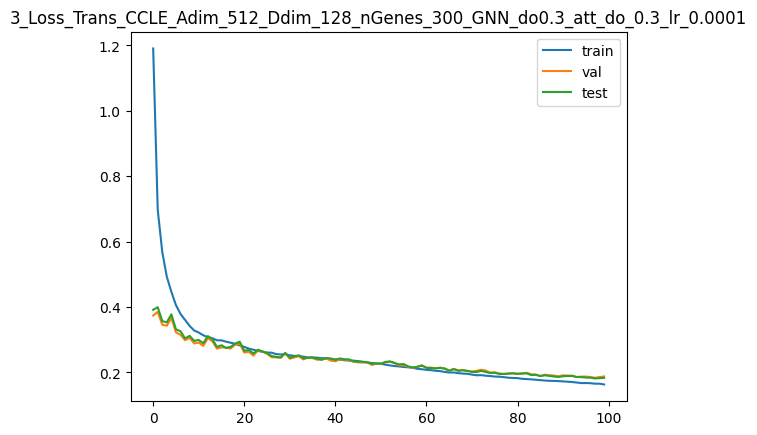

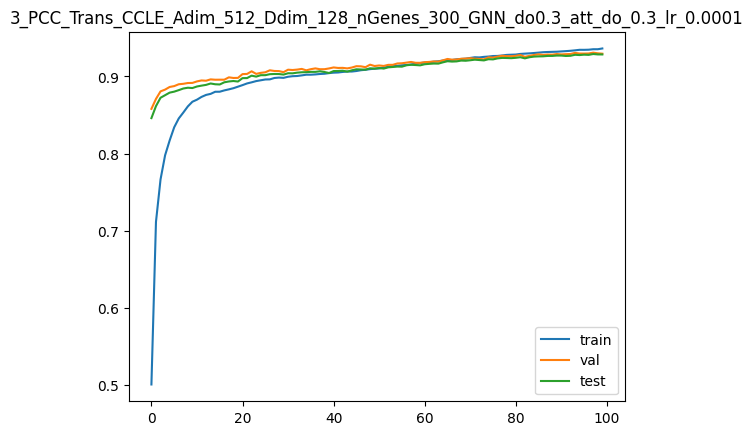

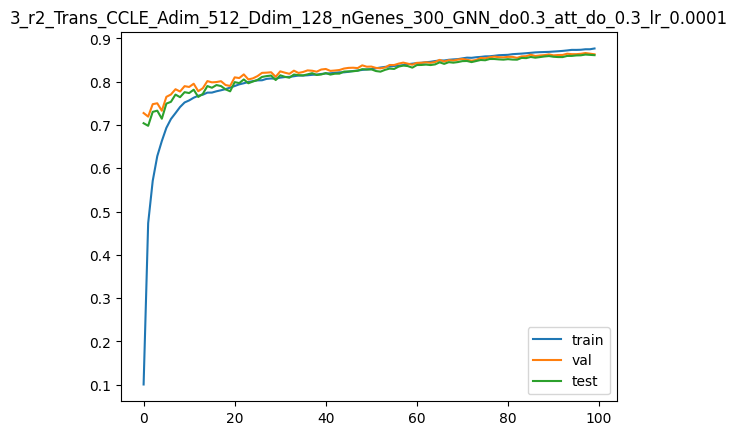

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1747262179851532
The overall Pearson's correlation is 0.9240.
Train avg_loss:  0.16369757
Train avg_pcc:  0.9361394869788976
Train r2:  0.8763529926003805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18722218
Validation avg_pcc:  0.9311508679172631
Validation r2:  0.8636602793677316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18608369
Test avg_pcc:  0.9291389364343928
Test r2:  0.8593728576182056
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1535307765007019
The overall Pearson's correlation is 0.9404.
Train avg_loss:  0.16311024
Train avg_pcc:  0.9363768017925721
Train r2:  0.87679663231584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18596373
Validation avg_pcc:  0.9311217937542975
Validation r2:  0.8645767225432074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18472068
Test avg_pcc:  0.929159707233191
Test r2:  0.8604029184797138
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16192343831062317
The overall Pearson's correlation is 0.9238.
Train avg_loss:  0.1616195
Train avg_pcc:  0.9369769805544307
Train r2:  0.8779226429055585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18131293
Validation avg_pcc:  0.93183210398209
Validation r2:  0.8679635456291623
Best Val r2  0.8679635456291623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17978074
Test avg_pcc:  0.9298867576112825
Test r2:  0.8641361227212603
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16517367959022522
The overall Pearson's correlation is 0.9456.
Train avg_loss:  0.16093527
Train avg_pcc:  0.9372529619251005
Train r2:  0.8784394728572562


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18244295
Validation avg_pcc:  0.9313228859385719
Validation r2:  0.8671406361336911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17985266
Test avg_pcc:  0.9296170735861542
Test r2:  0.8640817683146516
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14901778101921082
The overall Pearson's correlation is 0.9462.
Train avg_loss:  0.16017506
Train avg_pcc:  0.9375592333495133
Train r2:  0.879013692613931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18375567
Validation avg_pcc:  0.9308118799771589
Validation r2:  0.8661846884676668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17982647
Test avg_pcc:  0.9296887269094496
Test r2:  0.864101564133483
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13623055815696716
The overall Pearson's correlation is 0.9260.
Train avg_loss:  0.15978411
Train avg_pcc:  0.9377165633501792
Train r2:  0.8793090005897726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18264858
Validation avg_pcc:  0.9314163505453743
Validation r2:  0.8669908941321898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18046147
Test avg_pcc:  0.9297132781651952
Test r2:  0.8636216795243945
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14714139699935913
The overall Pearson's correlation is 0.9485.
Train avg_loss:  0.15921606
Train avg_pcc:  0.9379450825224247
Train r2:  0.8797380399358187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.186122
Validation avg_pcc:  0.9307823147285361
Validation r2:  0.8644614800032306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18357168
Test avg_pcc:  0.9293297014131296
Test r2:  0.8612712254221876
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1471790075302124
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.15803955
Train avg_pcc:  0.9384185285636121
Train r2:  0.8806267035442785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18125258
Validation avg_pcc:  0.9317678234273888
Validation r2:  0.8680074874868027
Best Val r2  0.8680074874868027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17851996
Test avg_pcc:  0.9303134424353907
Test r2:  0.8650889185649708
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1610059142112732
The overall Pearson's correlation is 0.9354.
Train avg_loss:  0.15760033
Train avg_pcc:  0.9385953864999628
Train r2:  0.8809584774411546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18067004
Validation avg_pcc:  0.9320195807289352
Validation r2:  0.8684317164847966
Best Val r2  0.8684317164847966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17757817
Test avg_pcc:  0.9306890743216547
Test r2:  0.8658006619953882
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14364632964134216
The overall Pearson's correlation is 0.9469.
Train avg_loss:  0.15771595
Train avg_pcc:  0.9385493892517993
Train r2:  0.8808711562224261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17862977
Validation avg_pcc:  0.9327051014589413
Validation r2:  0.8699174803282254
Best Val r2  0.8699174803282254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1763864
Test avg_pcc:  0.9309940476114166
Test r2:  0.8667012942144204
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13748417794704437
The overall Pearson's correlation is 0.9395.
Train avg_loss:  0.15652312
Train avg_pcc:  0.9390290881207108
Train r2:  0.8817721399101597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18091689
Validation avg_pcc:  0.9322221854022951
Validation r2:  0.868251947249511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1777756
Test avg_pcc:  0.9309156553924178
Test r2:  0.8656514475063629
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12475129961967468
The overall Pearson's correlation is 0.9427.
Train avg_loss:  0.15599935
Train avg_pcc:  0.9392400618109008
Train r2:  0.8821677649460404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18181074
Validation avg_pcc:  0.9319398587399187
Validation r2:  0.8676010289453746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17808934
Test avg_pcc:  0.9309511029194166
Test r2:  0.8654143575530509
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16977021098136902
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.1550229
Train avg_pcc:  0.9396326155031147
Train r2:  0.8829052922538843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17892808
Validation avg_pcc:  0.9327112645404797
Validation r2:  0.8697002494074938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17625438
Test avg_pcc:  0.9311580874151273
Test r2:  0.8668010680088314
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1493351012468338
The overall Pearson's correlation is 0.9267.
Train avg_loss:  0.15383825
Train avg_pcc:  0.9401078781756672
Train r2:  0.8838001298115482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1799179
Validation avg_pcc:  0.932501745223283
Validation r2:  0.8689794313235844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17690499
Test avg_pcc:  0.9312237978491438
Test r2:  0.8663093860498188
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19399280846118927
The overall Pearson's correlation is 0.9318.
Train avg_loss:  0.15313588
Train avg_pcc:  0.9403909627846196
Train r2:  0.8843306438085787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18184999
Validation avg_pcc:  0.9321975329282826
Validation r2:  0.8675724440028277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1779787
Test avg_pcc:  0.9311579235978824
Test r2:  0.865497952449817
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13468162715435028
The overall Pearson's correlation is 0.9593.
Train avg_loss:  0.15345249
Train avg_pcc:  0.9402630318485441
Train r2:  0.8840915119654063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18249665
Validation avg_pcc:  0.9315826861354211
Validation r2:  0.8671015386691677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17797373
Test avg_pcc:  0.9308736489887368
Test r2:  0.8655017061127992
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1882859617471695
The overall Pearson's correlation is 0.9128.
Train avg_loss:  0.15185699
Train avg_pcc:  0.9409041587772987
Train r2:  0.8852966467764125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17971727
Validation avg_pcc:  0.932714691235347
Validation r2:  0.8691255411689385


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17579405
Test avg_pcc:  0.9316919922873774
Test r2:  0.8671489518066835
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16670092940330505
The overall Pearson's correlation is 0.9303.
Train avg_loss:  0.1514474
Train avg_pcc:  0.9410686916058735
Train r2:  0.8856060303530797


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17955048
Validation avg_pcc:  0.9325400995080996
Validation r2:  0.8692470038110657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17588834
Test avg_pcc:  0.9313371230929249
Test r2:  0.8670776887308287
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1428893804550171
The overall Pearson's correlation is 0.9421.
Train avg_loss:  0.15012613
Train avg_pcc:  0.9415977324311646
Train r2:  0.8866040305775773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.179947
Validation avg_pcc:  0.9323089364564119
Validation r2:  0.8689582458317128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17542529
Test avg_pcc:  0.9315602101384834
Test r2:  0.8674276192644745
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15433332324028015
The overall Pearson's correlation is 0.9461.
Train avg_loss:  0.15004534
Train avg_pcc:  0.9416313775822426
Train r2:  0.8866650493423411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18217464
Validation avg_pcc:  0.9313094848979053
Validation r2:  0.8673360223640951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17509072
Test avg_pcc:  0.931496736902119
Test r2:  0.8676804674423955
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14525701105594635
The overall Pearson's correlation is 0.9373.
Train avg_loss:  0.14906025
Train avg_pcc:  0.9420256866177681
Train r2:  0.8874091367265702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17760222
Validation avg_pcc:  0.9333408434254145
Validation r2:  0.8706657811044397
Best Val r2  0.8706657811044397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17302386
Test avg_pcc:  0.9325939992466434
Test r2:  0.8692424303849351
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1634613573551178
The overall Pearson's correlation is 0.9562.
Train avg_loss:  0.14925432
Train avg_pcc:  0.9419481096720194
Train r2:  0.8872625262846107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1799883
Validation avg_pcc:  0.9330389252980049
Validation r2:  0.868928178685069


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17574064
Test avg_pcc:  0.9322536727219074
Test r2:  0.8671893138301118
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17596395313739777
The overall Pearson's correlation is 0.9321.
Train avg_loss:  0.1477603
Train avg_pcc:  0.9425470132822618
Train r2:  0.8883910255513628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1768655
Validation avg_pcc:  0.9336798820970857
Validation r2:  0.8712022709750915
Best Val r2  0.8712022709750915


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17313409
Test avg_pcc:  0.9326415550514378
Test r2:  0.8691591249471982
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1521109938621521
The overall Pearson's correlation is 0.9510.
Train avg_loss:  0.14678006
Train avg_pcc:  0.9429397911700682
Train r2:  0.8891314399628073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17612728
Validation avg_pcc:  0.9339259036683655
Validation r2:  0.8717398551303585
Best Val r2  0.8717398551303585


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17334124
Test avg_pcc:  0.9325501326584706
Test r2:  0.8690025725033252
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2104276418685913
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.14647636
Train avg_pcc:  0.9430614127384239
Train r2:  0.8893608301717911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18051729
Validation avg_pcc:  0.9323403919048692
Validation r2:  0.8685429607604425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17574792
Test avg_pcc:  0.9317243078953662
Test r2:  0.8671838056399578
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15321612358093262
The overall Pearson's correlation is 0.9406.
Train avg_loss:  0.14667898
Train avg_pcc:  0.9429803845007005
Train r2:  0.8892077866363484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1779532
Validation avg_pcc:  0.933536040789612
Validation r2:  0.8704101732032377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17444682
Test avg_pcc:  0.9324857365000447
Test r2:  0.8681670782553944
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12197452038526535
The overall Pearson's correlation is 0.9618.
Train avg_loss:  0.14521444
Train avg_pcc:  0.9435666554074341
Train r2:  0.8903140120074181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17750709
Validation avg_pcc:  0.9332639989415104
Validation r2:  0.8707350570186768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17230445
Test avg_pcc:  0.9327030085440606
Test r2:  0.8697861089240979
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14844989776611328
The overall Pearson's correlation is 0.9411.
Train avg_loss:  0.14490096
Train avg_pcc:  0.9436918191989312
Train r2:  0.8905507899457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17611416
Validation avg_pcc:  0.9338068751166391
Validation r2:  0.8717494185167074
Best Val r2  0.8717494185167074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17130995
Test avg_pcc:  0.9331489124444703
Test r2:  0.870537672263062
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12938113510608673
The overall Pearson's correlation is 0.9399.
Train avg_loss:  0.14474367
Train avg_pcc:  0.9437541619518143
Train r2:  0.8906695965266134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17807421
Validation avg_pcc:  0.9331513742027743
Validation r2:  0.8703220543518579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17327616
Test avg_pcc:  0.932533977533959
Test r2:  0.8690517630639616
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14362242817878723
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.14315441
Train avg_pcc:  0.9443905334620379
Train r2:  0.8918700317032218


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17867129
Validation avg_pcc:  0.9336988601666859
Validation r2:  0.8698872475859051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17607659
Test avg_pcc:  0.9323747331651752
Test r2:  0.8669354271953982
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1856449842453003
The overall Pearson's correlation is 0.9417.
Train avg_loss:  0.14285362
Train avg_pcc:  0.9445105183533017
Train r2:  0.8920972345219128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17638564
Validation avg_pcc:  0.9336575299891461
Validation r2:  0.871551725073912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.172159
Test avg_pcc:  0.9328264913656004
Test r2:  0.8698960183266203
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1264733225107193
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.14229631
Train avg_pcc:  0.9447334861391972
Train r2:  0.8925181862422009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17705417
Validation avg_pcc:  0.9337120711225312
Validation r2:  0.8710648802290173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17172527
Test avg_pcc:  0.9333247485460914
Test r2:  0.8702238056129823
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19890381395816803
The overall Pearson's correlation is 0.9396.
Train avg_loss:  0.14258915
Train avg_pcc:  0.9446169831690161
Train r2:  0.8922969959653811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17591643
Validation avg_pcc:  0.9344602925362507
Validation r2:  0.8718934077567699
Best Val r2  0.8718934077567699


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17151272
Test avg_pcc:  0.9336988660694574
Test r2:  0.8703844263876184
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13424859941005707
The overall Pearson's correlation is 0.9516.
Train avg_loss:  0.14098604
Train avg_pcc:  0.9452571486887096
Train r2:  0.8935078854906077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17834596
Validation avg_pcc:  0.9336474321847642
Validation r2:  0.8701241648280671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17351204
Test avg_pcc:  0.9329396786096225
Test r2:  0.8688735117047253
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1582629382610321
The overall Pearson's correlation is 0.9453.
Train avg_loss:  0.14050636
Train avg_pcc:  0.9454484278361681
Train r2:  0.8938702114453037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17649595
Validation avg_pcc:  0.9335735052356311
Validation r2:  0.8714713797539112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1708476
Test avg_pcc:  0.9332377465514886
Test r2:  0.8708870917389658
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13839316368103027
The overall Pearson's correlation is 0.9382.
Train avg_loss:  0.14146894
Train avg_pcc:  0.9450640441226884
Train r2:  0.8931431230895229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1770126
Validation avg_pcc:  0.9343724723029834
Validation r2:  0.8710951556234605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17395858
Test avg_pcc:  0.9332816140495387
Test r2:  0.8685360391272008
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15269844233989716
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.14058352
Train avg_pcc:  0.945418756173035
Train r2:  0.8938119286874965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17974317
Validation avg_pcc:  0.933864223494407
Validation r2:  0.8691066809725615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17435493
Test avg_pcc:  0.9335889616071787
Test r2:  0.8682365206125369
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12645629048347473
The overall Pearson's correlation is 0.9463.
Train avg_loss:  0.1399607
Train avg_pcc:  0.9456662773893658
Train r2:  0.8942823559223161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18185166
Validation avg_pcc:  0.9335317348880254
Validation r2:  0.8675712377595436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17731833
Test avg_pcc:  0.9329635121710801
Test r2:  0.8659970154999564
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11315526813268661
The overall Pearson's correlation is 0.9675.
Train avg_loss:  0.13963476
Train avg_pcc:  0.9457978387027202
Train r2:  0.8945285666837169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1743588
Validation avg_pcc:  0.9344608471745022
Validation r2:  0.873027707872815
Best Val r2  0.873027707872815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16933267
Test avg_pcc:  0.9338868120871177
Test r2:  0.8720319478174823
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.175965815782547
The overall Pearson's correlation is 0.9435.
Train avg_loss:  0.13824749
Train avg_pcc:  0.9463507019865127
Train r2:  0.8955764147195568


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17660828
Validation avg_pcc:  0.9337837138149178
Validation r2:  0.871389590442681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17059025
Test avg_pcc:  0.9336523128524818
Test r2:  0.8710815592617247
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12978127598762512
The overall Pearson's correlation is 0.9499.
Train avg_loss:  0.13857177
Train avg_pcc:  0.9462214974262475
Train r2:  0.8953314823903636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17506307
Validation avg_pcc:  0.9343253640130333
Validation r2:  0.8725148434752729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17074522
Test avg_pcc:  0.933528097248191
Test r2:  0.8709644505940151
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17364713549613953
The overall Pearson's correlation is 0.9364.
Train avg_loss:  0.13781807
Train avg_pcc:  0.9465217405705729
Train r2:  0.8959007809947666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17588972
Validation avg_pcc:  0.9350080618302284
Validation r2:  0.871912865413321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17297775
Test avg_pcc:  0.933934365723816
Test r2:  0.8692772791007444
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1178247332572937
The overall Pearson's correlation is 0.9548.
Train avg_loss:  0.13744172
Train avg_pcc:  0.9466719700537661
Train r2:  0.8961850450084201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17681079
Validation avg_pcc:  0.9337598327176165
Validation r2:  0.8712421217900781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16997948
Test avg_pcc:  0.9338456031023883
Test r2:  0.8715431324896437
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11540192365646362
The overall Pearson's correlation is 0.9536.
Train avg_loss:  0.13701327
Train avg_pcc:  0.9468427706769533
Train r2:  0.8965086487916878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17462234
Validation avg_pcc:  0.9344110900823188
Validation r2:  0.8728357864970793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1694782
Test avg_pcc:  0.9340044972505311
Test r2:  0.8719219672898936
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13722535967826843
The overall Pearson's correlation is 0.9460.
Train avg_loss:  0.13566518
Train avg_pcc:  0.9473803738081279
Train r2:  0.8975269353214395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17643586
Validation avg_pcc:  0.9337929188307149
Validation r2:  0.8715151484945155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16955337
Test avg_pcc:  0.9341077150630712
Test r2:  0.8718651487555829
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1655283272266388
The overall Pearson's correlation is 0.9363.
Train avg_loss:  0.13531162
Train avg_pcc:  0.9475223014147216
Train r2:  0.8977939927930086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17354283
Validation avg_pcc:  0.934911153962621
Validation r2:  0.8736219287238667
Best Val r2  0.8736219287238667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16928886
Test avg_pcc:  0.9340282705757468
Test r2:  0.872065050436724
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11289918422698975
The overall Pearson's correlation is 0.9576.
Train avg_loss:  0.13543044
Train avg_pcc:  0.9474741663022725
Train r2:  0.897704235567019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17363267
Validation avg_pcc:  0.9351807384281747
Validation r2:  0.8735564985506666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16876292
Test avg_pcc:  0.9343917055965457
Test r2:  0.8724625052455308
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12148652225732803
The overall Pearson's correlation is 0.9441.
Train avg_loss:  0.13430305
Train avg_pcc:  0.9479232661391347
Train r2:  0.8985557969644179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17200322
Validation avg_pcc:  0.9355400509133451
Validation r2:  0.8747431080267382
Best Val r2  0.8747431080267382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16768385
Test avg_pcc:  0.9348447157991588
Test r2:  0.8732779792476343
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14829207956790924
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.13476846
Train avg_pcc:  0.9477383926150141
Train r2:  0.8982042501467721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17112066
Validation avg_pcc:  0.9360238800080258
Validation r2:  0.8753858081266817
Best Val r2  0.8753858081266817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16687493
Test avg_pcc:  0.9350802675969387
Test r2:  0.8738893083058523
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12818774580955505
The overall Pearson's correlation is 0.9511.
Train avg_loss:  0.13376679
Train avg_pcc:  0.9481368522615735
Train r2:  0.8989608624262038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17458925
Validation avg_pcc:  0.9347545080586759
Validation r2:  0.8728598997940333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16948804
Test avg_pcc:  0.9341115041549206
Test r2:  0.8719145192655722


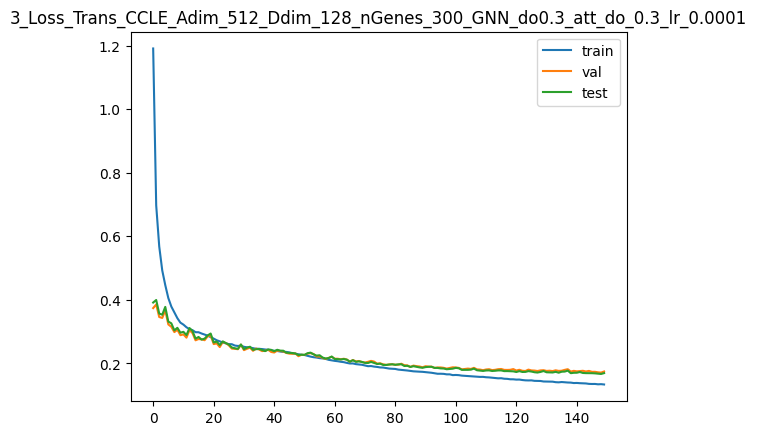

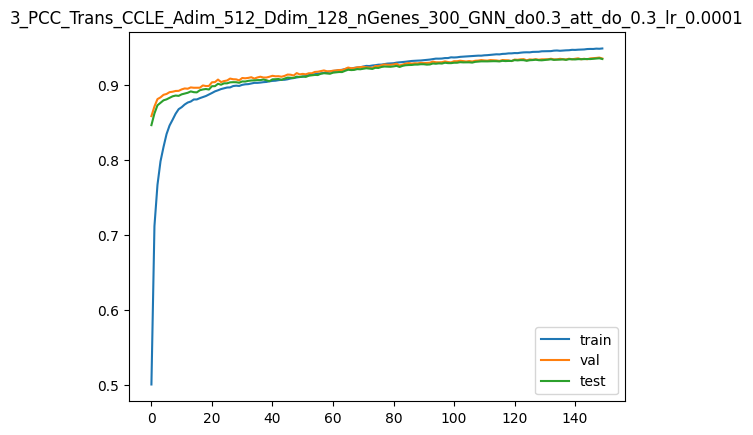

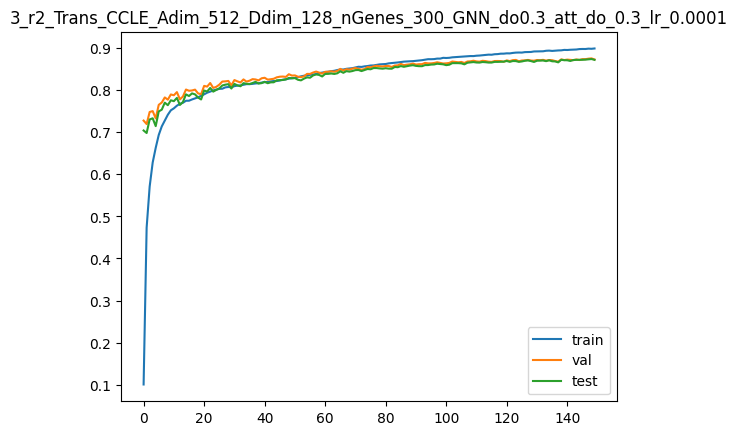

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12907259166240692
The overall Pearson's correlation is 0.9431.
Train avg_loss:  0.13365766
Train avg_pcc:  0.9481803738194005
Train r2:  0.8990432772105292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.173146
Validation avg_pcc:  0.935887806761912
Validation r2:  0.8739109089833945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17079632
Test avg_pcc:  0.9345733273455704
Test r2:  0.8709258325870541
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13646768033504486
The overall Pearson's correlation is 0.9391.
Train avg_loss:  0.13295059
Train avg_pcc:  0.9484622809338755
Train r2:  0.8995773711452071


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17171876
Validation avg_pcc:  0.9358079172330289
Validation r2:  0.8749502397895434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16648877
Test avg_pcc:  0.9352255158008441
Test r2:  0.874181139654117
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1105145663022995
The overall Pearson's correlation is 0.9672.
Train avg_loss:  0.13299459
Train avg_pcc:  0.9484449173274656
Train r2:  0.8995441251192765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17337549
Validation avg_pcc:  0.9357107956986158
Validation r2:  0.8737437790978888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16864918
Test avg_pcc:  0.9348236757645159
Test r2:  0.8725484704712138
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11825580149888992
The overall Pearson's correlation is 0.9412.
Train avg_loss:  0.13150412
Train avg_pcc:  0.9490376956425058
Train r2:  0.9006699374522059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17418553
Validation avg_pcc:  0.9356116042032521
Validation r2:  0.8731538786226003


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16956867
Test avg_pcc:  0.9350729020863416
Test r2:  0.8718535851029916
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13849298655986786
The overall Pearson's correlation is 0.9462.
Train avg_loss:  0.13165687
Train avg_pcc:  0.9489772062034246
Train r2:  0.9005545604176995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17619622
Validation avg_pcc:  0.9342096288503732
Validation r2:  0.8716896655702612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1694547
Test avg_pcc:  0.9343743253306214
Test r2:  0.8719397151422218
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.179330512881279
The overall Pearson's correlation is 0.9434.
Train avg_loss:  0.13087973
Train avg_pcc:  0.949286226105932
Train r2:  0.9011415730802336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17017725
Validation avg_pcc:  0.9361789168955853
Validation r2:  0.8760728245133806
Best Val r2  0.8760728245133806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1661173
Test avg_pcc:  0.9353343723580531
Test r2:  0.8744618596273375
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12103377282619476
The overall Pearson's correlation is 0.9442.
Train avg_loss:  0.1289638
Train avg_pcc:  0.9500484413899497
Train r2:  0.9025887427712715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17179944
Validation avg_pcc:  0.9355977009677937
Validation r2:  0.8748914945867402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16755195
Test avg_pcc:  0.9348484635003014
Test r2:  0.8733776651236385
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1229238286614418
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.13027246
Train avg_pcc:  0.949527829988062
Train r2:  0.9016002569476284


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.172864
Validation avg_pcc:  0.9352595839932788
Validation r2:  0.8741162669223927


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16781665
Test avg_pcc:  0.9348713626885403
Test r2:  0.8731776178001307
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.127385675907135
The overall Pearson's correlation is 0.9501.
Train avg_loss:  0.12937768
Train avg_pcc:  0.949883414019145
Train r2:  0.9022761191111887


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17145039
Validation avg_pcc:  0.9361378263825949
Validation r2:  0.8751456859651993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1670844
Test avg_pcc:  0.9356154596709387
Test r2:  0.8737309941085327
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1099848598241806
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.12932941
Train avg_pcc:  0.9499027319635347
Train r2:  0.9023125849717635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17105639
Validation avg_pcc:  0.9357958631607066
Validation r2:  0.8754326117490974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16445787
Test avg_pcc:  0.9358969725682729
Test r2:  0.8757159283936432
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14503122866153717
The overall Pearson's correlation is 0.9415.
Train avg_loss:  0.12951712
Train avg_pcc:  0.9498287383924156
Train r2:  0.9021707931519894


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17175539
Validation avg_pcc:  0.9353913787604415
Validation r2:  0.8749235748952098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16472158
Test avg_pcc:  0.9357164414340289
Test r2:  0.8755166327588928
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13097655773162842
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.1274271
Train avg_pcc:  0.9506583269885567
Train r2:  0.9037494666471941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16837631
Validation avg_pcc:  0.9367716645568706
Validation r2:  0.8773843018816468
Best Val r2  0.8773843018816468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16517271
Test avg_pcc:  0.9357200859053345
Test r2:  0.8751756939311313
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1609799563884735
The overall Pearson's correlation is 0.9497.
Train avg_loss:  0.12801349
Train avg_pcc:  0.9504265285746389
Train r2:  0.9033065292701058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17122628
Validation avg_pcc:  0.936064082494696
Validation r2:  0.8753088888497772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16757743
Test avg_pcc:  0.9350790061682865
Test r2:  0.8733584052094359
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10934451967477798
The overall Pearson's correlation is 0.9621.
Train avg_loss:  0.12706739
Train avg_pcc:  0.9508015198396168
Train r2:  0.9040211641477176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17718275
Validation avg_pcc:  0.9358287787056447
Validation r2:  0.8709712432954564


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17388752
Test avg_pcc:  0.9350930155062648
Test r2:  0.8685897549921058
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19166696071624756
The overall Pearson's correlation is 0.9296.
Train avg_loss:  0.1269409
Train avg_pcc:  0.9508520564123099
Train r2:  0.90411670727139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17376712
Validation avg_pcc:  0.9351795561014402
Validation r2:  0.8734585914482713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16865622
Test avg_pcc:  0.9348362186383784
Test r2:  0.8725431511976249
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1019493117928505
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.1266062
Train avg_pcc:  0.9509860822564046
Train r2:  0.9043695276669226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17221336
Validation avg_pcc:  0.9360017548881122
Validation r2:  0.8745900742325542


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16652623
Test avg_pcc:  0.9355396747143316
Test r2:  0.8741528259156569
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11378039419651031
The overall Pearson's correlation is 0.9554.
Train avg_loss:  0.12615745
Train avg_pcc:  0.9511625535671588
Train r2:  0.9047084858085475


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16920191
Validation avg_pcc:  0.9364241726244321
Validation r2:  0.8767830700127996


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16615602
Test avg_pcc:  0.9351693003091196
Test r2:  0.874432588514526
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17122521996498108
The overall Pearson's correlation is 0.9204.
Train avg_loss:  0.12630452
Train avg_pcc:  0.951104977372807
Train r2:  0.9045973943951879


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17018317
Validation avg_pcc:  0.9361244793437444
Validation r2:  0.87606850727771


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16637814
Test avg_pcc:  0.9353240360384278
Test r2:  0.87426473591545
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09481653571128845
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.12523194
Train avg_pcc:  0.9515305526178692
Train r2:  0.9054075555248204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.171507
Validation avg_pcc:  0.9362244448108221
Validation r2:  0.8751044582675981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16787376
Test avg_pcc:  0.9354028223195463
Test r2:  0.8731344798734786
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12475067377090454
The overall Pearson's correlation is 0.9529.
Train avg_loss:  0.12452115
Train avg_pcc:  0.9518121795195331
Train r2:  0.905944437866374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17111659
Validation avg_pcc:  0.9357540041914529
Validation r2:  0.875388764607336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16399348
Test avg_pcc:  0.9360833401822811
Test r2:  0.8760668719709279
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1379694938659668
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.12486767
Train avg_pcc:  0.9516755181219331
Train r2:  0.905682702264866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17036946
Validation avg_pcc:  0.9359719633520925
Validation r2:  0.8759328456621095


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16456446
Test avg_pcc:  0.9357735794567745
Test r2:  0.8756353674288666
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16994450986385345
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.12362703
Train avg_pcc:  0.9521678261538192
Train r2:  0.9066197994330597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17021368
Validation avg_pcc:  0.9362065670939459
Validation r2:  0.8760462781956373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16453184
Test avg_pcc:  0.9359802776219955
Test r2:  0.8756600168502053
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16921517252922058
The overall Pearson's correlation is 0.9308.
Train avg_loss:  0.123953
Train avg_pcc:  0.9520383074409984
Train r2:  0.9063735767008493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16990545
Validation avg_pcc:  0.9362180031230316
Validation r2:  0.8762707489598041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16407208
Test avg_pcc:  0.9360030250311809
Test r2:  0.876007472501541
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10740506649017334
The overall Pearson's correlation is 0.9480.
Train avg_loss:  0.12353811
Train avg_pcc:  0.9522021031270423
Train r2:  0.9066869655061605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1696998
Validation avg_pcc:  0.9364627510981538
Validation r2:  0.876420504706636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1655456
Test avg_pcc:  0.9357424686456681
Test r2:  0.8748938995720752
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13085171580314636
The overall Pearson's correlation is 0.9572.
Train avg_loss:  0.12390392
Train avg_pcc:  0.9520577010419106
Train r2:  0.9064106604625396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17078477
Validation avg_pcc:  0.9360210215307021
Validation r2:  0.8756304033165655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16305244
Test avg_pcc:  0.9365634206993155
Test r2:  0.8767780427286648
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12285448610782623
The overall Pearson's correlation is 0.9589.
Train avg_loss:  0.12270145
Train avg_pcc:  0.9525346727477273
Train r2:  0.907318920176204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16987686
Validation avg_pcc:  0.936471406559179
Validation r2:  0.8762915791409468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16421038
Test avg_pcc:  0.9362073390448695
Test r2:  0.8759029489519228
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08901859819889069
The overall Pearson's correlation is 0.9626.
Train avg_loss:  0.122482225
Train avg_pcc:  0.9526210953712321
Train r2:  0.9074845181040733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17072512
Validation avg_pcc:  0.9358971590319612
Validation r2:  0.8756738450478769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16469397
Test avg_pcc:  0.9357417718796126
Test r2:  0.8755375028833001
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0981174185872078
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.12154622
Train avg_pcc:  0.9529920426002727
Train r2:  0.9081915162762384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17253783
Validation avg_pcc:  0.9356388466786872
Validation r2:  0.8743537902233174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16496608
Test avg_pcc:  0.9361458852151981
Test r2:  0.8753318591909417
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13144412636756897
The overall Pearson's correlation is 0.9390.
Train avg_loss:  0.121282734
Train avg_pcc:  0.9530965537348546
Train r2:  0.9083905394765756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16950862
Validation avg_pcc:  0.9362743253687406
Validation r2:  0.8765597244224133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16310243
Test avg_pcc:  0.9363585721830472
Test r2:  0.8767402615983197
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14553202688694
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.12154617
Train avg_pcc:  0.9529925487984682
Train r2:  0.9081915566794981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17163865
Validation avg_pcc:  0.9356631557490904
Validation r2:  0.8750085799087144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16446768
Test avg_pcc:  0.9360086303396733
Test r2:  0.8757085159937122
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14332307875156403
The overall Pearson's correlation is 0.9370.
Train avg_loss:  0.1209768
Train avg_pcc:  0.9532180681905865
Train r2:  0.9086216198810161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1702166
Validation avg_pcc:  0.9365031605564852
Validation r2:  0.8760441597590762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16404349
Test avg_pcc:  0.9362984922989259
Test r2:  0.8760290799547069
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13223586976528168
The overall Pearson's correlation is 0.9518.
Train avg_loss:  0.11981619
Train avg_pcc:  0.9536772868475994
Train r2:  0.9094982694969714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16812478
Validation avg_pcc:  0.9368846411242713
Validation r2:  0.877567473657899
Best Val r2  0.877567473657899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16216022
Test avg_pcc:  0.9368536140740523
Test r2:  0.8774523053888817
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11608713865280151
The overall Pearson's correlation is 0.9499.
Train avg_loss:  0.120417975
Train avg_pcc:  0.9534391905502331
Train r2:  0.9090437202713721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1680256
Validation avg_pcc:  0.9368307114415813
Validation r2:  0.8776396976693742
Best Val r2  0.8776396976693742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16369183
Test avg_pcc:  0.9361230798487171
Test r2:  0.87629483459422
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09625032544136047
The overall Pearson's correlation is 0.9540.
Train avg_loss:  0.11926927
Train avg_pcc:  0.9538939654005322
Train r2:  0.9099113819126113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16962126
Validation avg_pcc:  0.9372794077014031
Validation r2:  0.8764776942128059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16556661
Test avg_pcc:  0.9364977436582916
Test r2:  0.8748780206666548
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11130519956350327
The overall Pearson's correlation is 0.9562.
Train avg_loss:  0.11955613
Train avg_pcc:  0.9537812955501137
Train r2:  0.9096947060139422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16764799
Validation avg_pcc:  0.93745560357483
Validation r2:  0.8779146814943607
Best Val r2  0.8779146814943607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16542885
Test avg_pcc:  0.9361666404151459
Test r2:  0.8749821325134163
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19368299841880798
The overall Pearson's correlation is 0.9269.
Train avg_loss:  0.11879094
Train avg_pcc:  0.9540837705028589
Train r2:  0.9102726695550375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16690248
Validation avg_pcc:  0.9374150382874894
Validation r2:  0.8784575780774908
Best Val r2  0.8784575780774908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16123809
Test avg_pcc:  0.9371632900232412
Test r2:  0.8781491741573971
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.105275958776474
The overall Pearson's correlation is 0.9632.
Train avg_loss:  0.118624255
Train avg_pcc:  0.9541494286892344
Train r2:  0.9103985800636535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16633567
Validation avg_pcc:  0.9375124385789317
Validation r2:  0.8788703443590519
Best Val r2  0.8788703443590519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16251582
Test avg_pcc:  0.9365818812594005
Test r2:  0.8771835659465467
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0894259512424469
The overall Pearson's correlation is 0.9528.
Train avg_loss:  0.11843825
Train avg_pcc:  0.9542230518031773
Train r2:  0.9105390851350296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16948386
Validation avg_pcc:  0.9367676307982107
Validation r2:  0.8765777704153068


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16256072
Test avg_pcc:  0.9371406057346825
Test r2:  0.8771496361772608
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12001705914735794
The overall Pearson's correlation is 0.9496.
Train avg_loss:  0.117892094
Train avg_pcc:  0.9544395058674501
Train r2:  0.9109516062574963


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16837232
Validation avg_pcc:  0.936759265858881
Validation r2:  0.877387219269859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16243893
Test avg_pcc:  0.9366651882557682
Test r2:  0.8772416762744972
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11643869429826736
The overall Pearson's correlation is 0.9591.
Train avg_loss:  0.117611624
Train avg_pcc:  0.9545504747097767
Train r2:  0.9111634561869988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17058071
Validation avg_pcc:  0.936466274570471
Validation r2:  0.8757790122970478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16371742
Test avg_pcc:  0.9365690360469819
Test r2:  0.8762754950886834
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10808826982975006
The overall Pearson's correlation is 0.9676.
Train avg_loss:  0.11818869
Train avg_pcc:  0.9543213833800378
Train r2:  0.9107275957776799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17169744
Validation avg_pcc:  0.9363532947113692
Validation r2:  0.8749657705886799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16443789
Test avg_pcc:  0.9367206996522869
Test r2:  0.8757310259809432
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10478918999433517
The overall Pearson's correlation is 0.9537.
Train avg_loss:  0.11688796
Train avg_pcc:  0.9548367677735797
Train r2:  0.9117100833248436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16912976
Validation avg_pcc:  0.936773200268149
Validation r2:  0.8768356324301299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16245508
Test avg_pcc:  0.9369244665190681
Test r2:  0.8772294719170428
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12129923701286316
The overall Pearson's correlation is 0.9512.
Train avg_loss:  0.11682542
Train avg_pcc:  0.9548614508566794
Train r2:  0.9117573195268459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1685543
Validation avg_pcc:  0.9367459014323427
Validation r2:  0.8772546793802477


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16190778
Test avg_pcc:  0.9368748034893036
Test r2:  0.8776430745806023
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11030979454517365
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.1162515
Train avg_pcc:  0.9550883457158047
Train r2:  0.9121908179045111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16535597
Validation avg_pcc:  0.9381329810328759
Validation r2:  0.8795837967392354
Best Val r2  0.8795837967392354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16140312
Test avg_pcc:  0.9371439884733271
Test r2:  0.878024455267101
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11626602709293365
The overall Pearson's correlation is 0.9622.
Train avg_loss:  0.1162863
Train avg_pcc:  0.9550752677860769
Train r2:  0.9121645382568078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17046066
Validation avg_pcc:  0.9368369285040014
Validation r2:  0.8758664347220763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16390468
Test avg_pcc:  0.936671005335482
Test r2:  0.8761339806323929
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10259145498275757
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.11625357
Train avg_pcc:  0.955087146263973
Train r2:  0.9121892607344523


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17051664
Validation avg_pcc:  0.9364614193054563
Validation r2:  0.8758256656885348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16387248
Test avg_pcc:  0.936665150947998
Test r2:  0.8761583126488226
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09641113132238388
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.11572873
Train avg_pcc:  0.9552949261740906
Train r2:  0.912585684650975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16844337
Validation avg_pcc:  0.9369536240118687
Validation r2:  0.8773354677359417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16204692
Test avg_pcc:  0.9369825597350151
Test r2:  0.8775379209335907
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14912131428718567
The overall Pearson's correlation is 0.9498.
Train avg_loss:  0.11502262
Train avg_pcc:  0.9555743198611741
Train r2:  0.9131190332602597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1679456
Validation avg_pcc:  0.9377286005793781
Validation r2:  0.8776979627189679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16194068
Test avg_pcc:  0.9374592829565026
Test r2:  0.877618208764005
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14378231763839722
The overall Pearson's correlation is 0.9526.
Train avg_loss:  0.11510725
Train avg_pcc:  0.9555400467420958
Train r2:  0.9130551156465756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.168404
Validation avg_pcc:  0.9379779755158479
Validation r2:  0.8773641381060744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16345903
Test avg_pcc:  0.9373792384425329
Test r2:  0.8764707685324084
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13440737128257751
The overall Pearson's correlation is 0.9550.
Train avg_loss:  0.11479067
Train avg_pcc:  0.9556663040780831
Train r2:  0.9132942340709983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16826613
Validation avg_pcc:  0.9367996345784972
Validation r2:  0.8774645457261498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16251756
Test avg_pcc:  0.9366398538644706
Test r2:  0.8771822500457213


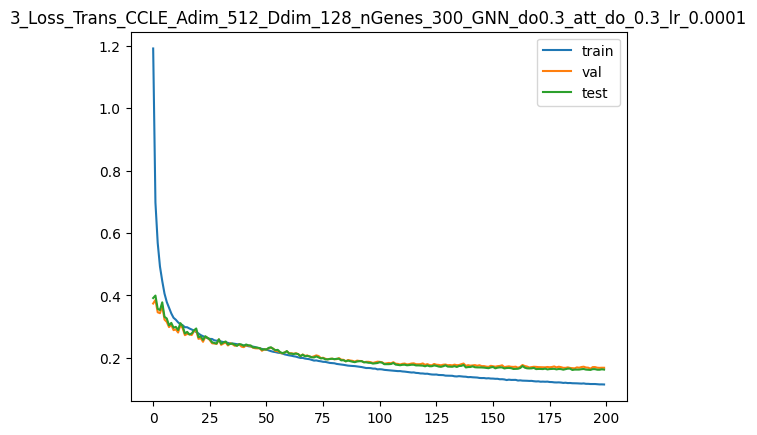

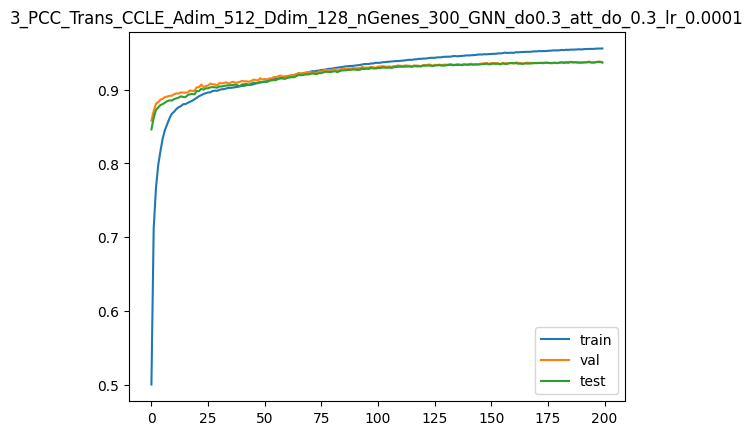

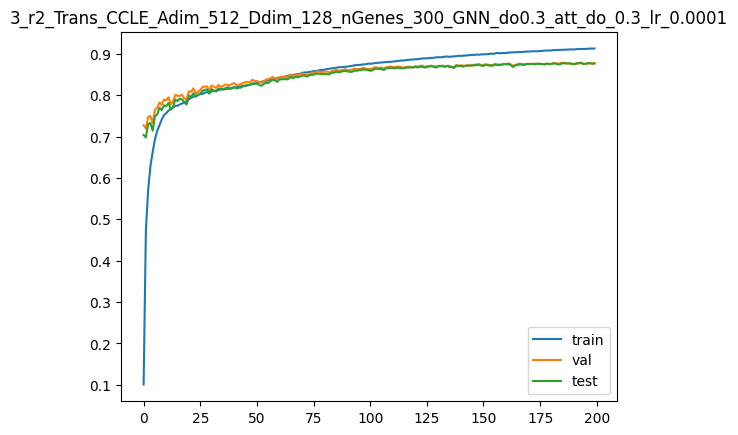

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16140312
Test avg_pcc:  0.93714398845265
Test r2:  0.8780244552539256


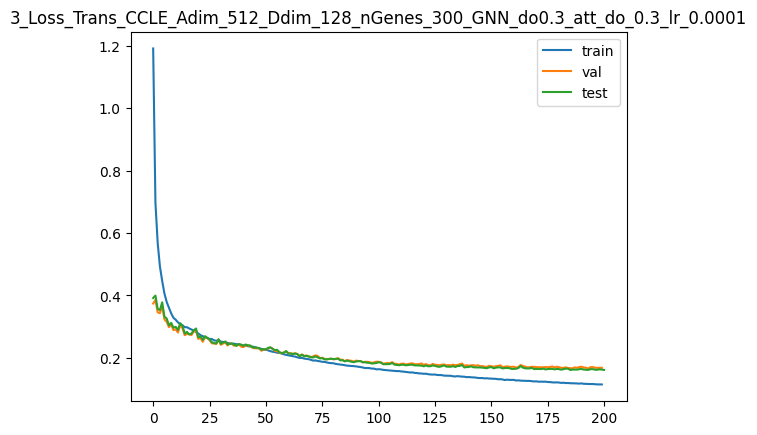

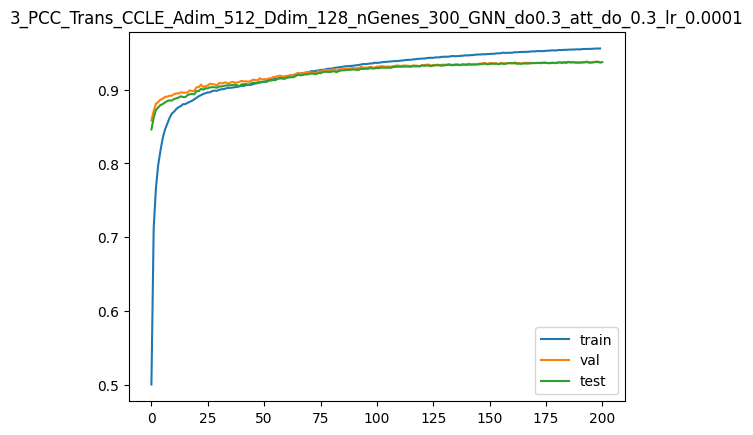

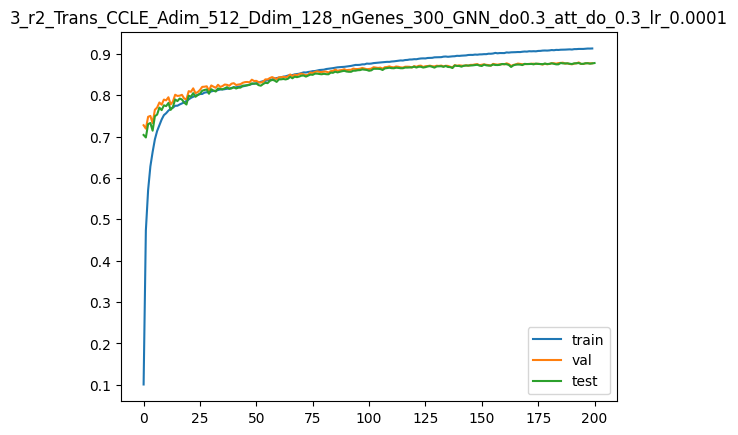

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.9430744647979736
The overall Pearson's correlation is 0.6351.
Train avg_loss:  1.233938
Train avg_pcc:  0.49358533216271566
Train r2:  0.06878276526554183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.40561104
Validation avg_pcc:  0.8420210962451425
Validation r2:  0.697458637549115
Best Val r2  0.697458637549115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.40168148
Test avg_pcc:  0.8430314944460642
Test r2:  0.6969302541091467
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6467700600624084
The overall Pearson's correlation is 0.7683.
Train avg_loss:  0.69233716
Train avg_pcc:  0.7157409443667931
Train r2:  0.4775131762455783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36093277
Validation avg_pcc:  0.8609296359152138
Validation r2:  0.7307837146148686
Best Val r2  0.7307837146148686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35813692
Test avg_pcc:  0.8610364146409137
Test r2:  0.7297847526495307
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5912015438079834
The overall Pearson's correlation is 0.7854.
Train avg_loss:  0.56871784
Train avg_pcc:  0.7667966721554105
Train r2:  0.570805123970477


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38345358
Validation avg_pcc:  0.8699440720096657
Validation r2:  0.7139856819683688


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.37010485
Test avg_pcc:  0.8702617629590214
Test r2:  0.7207549120940367
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4813595116138458
The overall Pearson's correlation is 0.7798.
Train avg_loss:  0.49809277
Train avg_pcc:  0.7959895359501488
Train r2:  0.6241038218901969


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35609332
Validation avg_pcc:  0.8757905701940922
Validation r2:  0.7343934333677755
Best Val r2  0.7343934333677755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35222664
Test avg_pcc:  0.8739941476275936
Test r2:  0.7342440567874399
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.44261011481285095
The overall Pearson's correlation is 0.7634.
Train avg_loss:  0.4459799
Train avg_pcc:  0.8177085365713926
Train r2:  0.6634318947119158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3432203
Validation avg_pcc:  0.8800021606444856
Validation r2:  0.7439953034322799
Best Val r2  0.7439953034322799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33902916
Test avg_pcc:  0.8781229094599923
Test r2:  0.7442015880767511
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5293852090835571
The overall Pearson's correlation is 0.8019.
Train avg_loss:  0.40914446
Train avg_pcc:  0.832948350228365
Train r2:  0.6912305189134696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36532405
Validation avg_pcc:  0.8820878419721037
Validation r2:  0.7275082874374692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3599822
Test avg_pcc:  0.8809807505545177
Test r2:  0.7283924836733475
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.34286975860595703
The overall Pearson's correlation is 0.8796.
Train avg_loss:  0.3776496
Train avg_pcc:  0.8463235565448333
Train r2:  0.7149987670474727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3384718
Validation avg_pcc:  0.8843178790762314
Validation r2:  0.7475371208989219
Best Val r2  0.7475371208989219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33972073
Test avg_pcc:  0.8813437834076392
Test r2:  0.743679817319645
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29984569549560547
The overall Pearson's correlation is 0.8671.
Train avg_loss:  0.3589622
Train avg_pcc:  0.854270918967344
Train r2:  0.7291016494493747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32423127
Validation avg_pcc:  0.88381285039491
Validation r2:  0.7581590090338826
Best Val r2  0.7581590090338826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31889707
Test avg_pcc:  0.8836039908141766
Test r2:  0.7593913032317178
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4668450951576233
The overall Pearson's correlation is 0.8572.
Train avg_loss:  0.34559622
Train avg_pcc:  0.8599462540548086
Train r2:  0.7391885498669435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3068665
Validation avg_pcc:  0.8853332547308383
Validation r2:  0.7711112412927777
Best Val r2  0.7711112412927777


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.304633
Test avg_pcc:  0.8841010293013294
Test r2:  0.7701535974157625
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.321222186088562
The overall Pearson's correlation is 0.8949.
Train avg_loss:  0.3280177
Train avg_pcc:  0.8675248956557144
Train r2:  0.7524545205356636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31427753
Validation avg_pcc:  0.8855423638336696
Validation r2:  0.7655834151893219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31219193
Test avg_pcc:  0.8851524258068135
Test r2:  0.7644503711942752
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.33540523052215576
The overall Pearson's correlation is 0.9047.
Train avg_loss:  0.3226053
Train avg_pcc:  0.8698400352476439
Train r2:  0.7565391367241288


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30002752
Validation avg_pcc:  0.886916762279803
Validation r2:  0.7762123587450686
Best Val r2  0.7762123587450686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30140588
Test avg_pcc:  0.8856021951774588
Test r2:  0.7725884665647043
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39595723152160645
The overall Pearson's correlation is 0.8848.
Train avg_loss:  0.31534806
Train avg_pcc:  0.8729666653741992
Train r2:  0.7620159542125524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2983145
Validation avg_pcc:  0.8893837884604303
Validation r2:  0.7774900880597734
Best Val r2  0.7774900880597734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30290598
Test avg_pcc:  0.8882948900171304
Test r2:  0.7714566543428013
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2935185134410858
The overall Pearson's correlation is 0.8657.
Train avg_loss:  0.3079915
Train avg_pcc:  0.8761317564905761
Train r2:  0.7675677267504861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3118225
Validation avg_pcc:  0.88658651685863
Validation r2:  0.7674145761279259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30802655
Test avg_pcc:  0.886649309379241
Test r2:  0.7675931473841614
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27475839853286743
The overall Pearson's correlation is 0.8711.
Train avg_loss:  0.30359548
Train avg_pcc:  0.8780141453440099
Train r2:  0.7708852752954132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28504905
Validation avg_pcc:  0.8899482483116647
Validation r2:  0.7873846591597781
Best Val r2  0.7873846591597781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28402874
Test avg_pcc:  0.8885008318632038
Test r2:  0.7856995560065063
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.205648273229599
The overall Pearson's correlation is 0.9183.
Train avg_loss:  0.29743043
Train avg_pcc:  0.8806544588075277
Train r2:  0.7755378671425206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28792834
Validation avg_pcc:  0.8899508154296011
Validation r2:  0.7852370364219149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29021424
Test avg_pcc:  0.8893582733277008
Test r2:  0.7810325810418033
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36913543939590454
The overall Pearson's correlation is 0.8298.
Train avg_loss:  0.2939313
Train avg_pcc:  0.8821547045195731
Train r2:  0.778178538937467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2835855
Validation avg_pcc:  0.8891647209429647
Validation r2:  0.7884763070858782
Best Val r2  0.7884763070858782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2811704
Test avg_pcc:  0.88942333966829
Test r2:  0.7878561925018692
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20015022158622742
The overall Pearson's correlation is 0.9357.
Train avg_loss:  0.29167432
Train avg_pcc:  0.8831167862805754
Train r2:  0.779881848857471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2801291
Validation avg_pcc:  0.8908392098216317
Validation r2:  0.7910543872049235
Best Val r2  0.7910543872049235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28309044
Test avg_pcc:  0.889501723554379
Test r2:  0.7864075252331322
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2528889775276184
The overall Pearson's correlation is 0.8980.
Train avg_loss:  0.28674343
Train avg_pcc:  0.8852221064768521
Train r2:  0.7836030468732267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28239423
Validation avg_pcc:  0.8922143154745066
Validation r2:  0.7893648763929189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27979618
Test avg_pcc:  0.89295535074058
Test r2:  0.7888930412387999
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2600657343864441
The overall Pearson's correlation is 0.9072.
Train avg_loss:  0.2839492
Train avg_pcc:  0.8864110392380199
Train r2:  0.7857117731405692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28361073
Validation avg_pcc:  0.8937104983254054
Validation r2:  0.7884574862539069


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27992177
Test avg_pcc:  0.8948816925690202
Test r2:  0.7887982762376192
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31078770756721497
The overall Pearson's correlation is 0.8739.
Train avg_loss:  0.27962628
Train avg_pcc:  0.8882507625517496
Train r2:  0.7889741626488279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28953734
Validation avg_pcc:  0.8945476948781534
Validation r2:  0.7840368957425883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29108408
Test avg_pcc:  0.8943663895583377
Test r2:  0.7803762903740399
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.33445435762405396
The overall Pearson's correlation is 0.8551.
Train avg_loss:  0.27475664
Train avg_pcc:  0.890317243831955
Train r2:  0.7926491246638725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2627608
Validation avg_pcc:  0.8978950053882723
Validation r2:  0.8040092621109101
Best Val r2  0.8040092621109101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25923073
Test avg_pcc:  0.8985543518692518
Test r2:  0.8044097148301621
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23604029417037964
The overall Pearson's correlation is 0.9117.
Train avg_loss:  0.2714558
Train avg_pcc:  0.8917159217128079
Train r2:  0.7951401682852364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27512848
Validation avg_pcc:  0.8979707129146571
Validation r2:  0.7947843124123782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27675647
Test avg_pcc:  0.8980443244572226
Test r2:  0.7911865246839798
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2531828284263611
The overall Pearson's correlation is 0.9139.
Train avg_loss:  0.2675171
Train avg_pcc:  0.8933792515500573
Train r2:  0.798112580126386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26472884
Validation avg_pcc:  0.8992676308892236
Validation r2:  0.8025412948237679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26214334
Test avg_pcc:  0.8996815594287035
Test r2:  0.8022121499757499
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20645350217819214
The overall Pearson's correlation is 0.9158.
Train avg_loss:  0.2646559
Train avg_pcc:  0.8945884168535124
Train r2:  0.8002718670563376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2586626
Validation avg_pcc:  0.9007387760594485
Validation r2:  0.8070660497517708
Best Val r2  0.8070660497517708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25716227
Test avg_pcc:  0.9005454624886686
Test r2:  0.8059703807866962
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19684998691082
The overall Pearson's correlation is 0.9096.
Train avg_loss:  0.2596607
Train avg_pcc:  0.8966884373903552
Train r2:  0.8040416032574959


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27070275
Validation avg_pcc:  0.8996490418732095
Validation r2:  0.7980854174394161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26648545
Test avg_pcc:  0.9006785813507472
Test r2:  0.7989360350298725
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2205413281917572
The overall Pearson's correlation is 0.8953.
Train avg_loss:  0.25840136
Train avg_pcc:  0.8972210824230393
Train r2:  0.8049919644956258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26736438
Validation avg_pcc:  0.9002217862271173
Validation r2:  0.8005754817783386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2657606
Test avg_pcc:  0.9008486469550029
Test r2:  0.7994829404450048
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2049873024225235
The overall Pearson's correlation is 0.9120.
Train avg_loss:  0.2566759
Train avg_pcc:  0.8979467274369202
Train r2:  0.8062941256543079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27627903
Validation avg_pcc:  0.9008961603838216
Validation r2:  0.7939261204522374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27393195
Test avg_pcc:  0.9016583026972349
Test r2:  0.793317621452944
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2830519676208496
The overall Pearson's correlation is 0.9008.
Train avg_loss:  0.25404087
Train avg_pcc:  0.8990500663561215
Train r2:  0.8082827398004733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25074437
Validation avg_pcc:  0.9035697911731838
Validation r2:  0.8129721882696643
Best Val r2  0.8129721882696643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25032037
Test avg_pcc:  0.9034819990190845
Test r2:  0.8111326347200039
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26054835319519043
The overall Pearson's correlation is 0.8879.
Train avg_loss:  0.25249112
Train avg_pcc:  0.8997027772070885
Train r2:  0.8094522721530898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26008743
Validation avg_pcc:  0.9030611390162614
Validation r2:  0.8060032859363295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25823772
Test avg_pcc:  0.9030515258458609
Test r2:  0.8051589554662487
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1872510462999344
The overall Pearson's correlation is 0.9171.
Train avg_loss:  0.2523098
Train avg_pcc:  0.8997777191257664
Train r2:  0.8095890956719176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24880849
Validation avg_pcc:  0.9038983941687113
Validation r2:  0.8144161486376716
Best Val r2  0.8144161486376716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24767861
Test avg_pcc:  0.9038823622557105
Test r2:  0.8131258464540575
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2435208410024643
The overall Pearson's correlation is 0.8951.
Train avg_loss:  0.24943806
Train avg_pcc:  0.900980564921868
Train r2:  0.8117563093179953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25423086
Validation avg_pcc:  0.9034501492725485
Validation r2:  0.8103716472028147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25222477
Test avg_pcc:  0.9037915334707378
Test r2:  0.8096957557825707
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2327088564634323
The overall Pearson's correlation is 0.9015.
Train avg_loss:  0.24804078
Train avg_pcc:  0.9015654546873785
Train r2:  0.8128108183156011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25997564
Validation avg_pcc:  0.9029918663714676
Validation r2:  0.8060866668780604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25822586
Test avg_pcc:  0.903000151820682
Test r2:  0.8051679250833222
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2022230625152588
The overall Pearson's correlation is 0.8997.
Train avg_loss:  0.24689448
Train avg_pcc:  0.902044840298048
Train r2:  0.8136758719329162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25115183
Validation avg_pcc:  0.9032400834451919
Validation r2:  0.8126682587121883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24651268
Test avg_pcc:  0.9046818109581032
Test r2:  0.8140055233075013
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32403498888015747
The overall Pearson's correlation is 0.8707.
Train avg_loss:  0.24535877
Train avg_pcc:  0.9026882336779747
Train r2:  0.814834845860866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24345396
Validation avg_pcc:  0.9055021629584129
Validation r2:  0.8184100164379623
Best Val r2  0.8184100164379623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24133043
Test avg_pcc:  0.9055229108631417
Test r2:  0.8179155567177927
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21340949833393097
The overall Pearson's correlation is 0.9064.
Train avg_loss:  0.24487919
Train avg_pcc:  0.902887634590275
Train r2:  0.8151967783323573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25604433
Validation avg_pcc:  0.9046450962957625
Validation r2:  0.8090189939667326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2532324
Test avg_pcc:  0.9048746277568953
Test r2:  0.8089355049307085
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17086075246334076
The overall Pearson's correlation is 0.9328.
Train avg_loss:  0.24105692
Train avg_pcc:  0.9044830263580662
Train r2:  0.81808134536578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24195217
Validation avg_pcc:  0.9061337982499145
Validation r2:  0.8195302074673154
Best Val r2  0.8195302074673154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23781332
Test avg_pcc:  0.9070397474592014
Test r2:  0.8205692051331186
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24972045421600342
The overall Pearson's correlation is 0.9195.
Train avg_loss:  0.24201511
Train avg_pcc:  0.9040841547915247
Train r2:  0.8173582128730827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2495033
Validation avg_pcc:  0.9050282063835468
Validation r2:  0.8138978817657101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24362686
Test avg_pcc:  0.9059224045816991
Test r2:  0.8161828944674295
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22771881520748138
The overall Pearson's correlation is 0.9039.
Train avg_loss:  0.23942289
Train avg_pcc:  0.9051645600463117
Train r2:  0.8193145001085392


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23839287
Validation avg_pcc:  0.9077231963142975
Validation r2:  0.822185042343961
Best Val r2  0.822185042343961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23728588
Test avg_pcc:  0.9071121348240124
Test r2:  0.8209671648419035
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23046138882637024
The overall Pearson's correlation is 0.9256.
Train avg_loss:  0.23749392
Train avg_pcc:  0.9059674693519697
Train r2:  0.820770219817299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24678443
Validation avg_pcc:  0.9078735524255475
Validation r2:  0.8159258537034593


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24595991
Test avg_pcc:  0.9082473552337964
Test r2:  0.8144226062733576
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1980910301208496
The overall Pearson's correlation is 0.9128.
Train avg_loss:  0.23698716
Train avg_pcc:  0.9061815094412488
Train r2:  0.8211526457948242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23671101
Validation avg_pcc:  0.9081284934845854
Validation r2:  0.8234395441671318
Best Val r2  0.8234395441671318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23108156
Test avg_pcc:  0.90898357731433
Test r2:  0.8256483596963385
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24615685641765594
The overall Pearson's correlation is 0.8897.
Train avg_loss:  0.23475921
Train avg_pcc:  0.9071044441131628
Train r2:  0.8228340095435875


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23877789
Validation avg_pcc:  0.9082699519914437
Validation r2:  0.821897866427443


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23636207
Test avg_pcc:  0.9082098964561403
Test r2:  0.8216641954923958
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2262181043624878
The overall Pearson's correlation is 0.9290.
Train avg_loss:  0.23368903
Train avg_pcc:  0.9075504485928246
Train r2:  0.823641650023884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23508266
Validation avg_pcc:  0.9093729565909815
Validation r2:  0.8246540868225166
Best Val r2  0.8246540868225166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23539206
Test avg_pcc:  0.9089976784908465
Test r2:  0.822396072033802
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2096153050661087
The overall Pearson's correlation is 0.9151.
Train avg_loss:  0.23136643
Train avg_pcc:  0.9085164599497995
Train r2:  0.8253944498855854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24461354
Validation avg_pcc:  0.9077885428884205
Validation r2:  0.8175451143589263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23907009
Test avg_pcc:  0.9088086057104148
Test r2:  0.8196209875982168
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2205798625946045
The overall Pearson's correlation is 0.9037.
Train avg_loss:  0.22985809
Train avg_pcc:  0.9091419506332231
Train r2:  0.8265327513988411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23711401
Validation avg_pcc:  0.9092653835353253
Validation r2:  0.823138944394683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23314016
Test avg_pcc:  0.9102171467288335
Test r2:  0.8240951366946446
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23195376992225647
The overall Pearson's correlation is 0.9204.
Train avg_loss:  0.22826888
Train avg_pcc:  0.909801559420606
Train r2:  0.8277320918891609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23883557
Validation avg_pcc:  0.9099361763130833
Validation r2:  0.8218548403612705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23407333
Test avg_pcc:  0.9108399204835115
Test r2:  0.8233910519097636
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25076431035995483
The overall Pearson's correlation is 0.9120.
Train avg_loss:  0.22622599
Train avg_pcc:  0.9106474626340644
Train r2:  0.8292737743718176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23745142
Validation avg_pcc:  0.9105576664995467
Validation r2:  0.822887256895183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23358658
Test avg_pcc:  0.9116798204901477
Test r2:  0.8237583086781166
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19068583846092224
The overall Pearson's correlation is 0.9341.
Train avg_loss:  0.22479962
Train avg_pcc:  0.9112405245622085
Train r2:  0.8303502265800327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22980486
Validation avg_pcc:  0.9114713508079942
Validation r2:  0.8285907725683641
Best Val r2  0.8285907725683641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2253838
Test avg_pcc:  0.9121412777326036
Test r2:  0.829947331417114
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20426860451698303
The overall Pearson's correlation is 0.8850.
Train avg_loss:  0.22292528
Train avg_pcc:  0.9120136044387505
Train r2:  0.8317647394371772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22898729
Validation avg_pcc:  0.9111045378908565
Validation r2:  0.829200578997574
Best Val r2  0.829200578997574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22534561
Test avg_pcc:  0.911805427343449
Test r2:  0.8299761355023993
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.213825523853302
The overall Pearson's correlation is 0.9285.
Train avg_loss:  0.2215331
Train avg_pcc:  0.9125911593957206
Train r2:  0.8328153941980021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.231579
Validation avg_pcc:  0.9117804494881742
Validation r2:  0.8272674527930145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2267976
Test avg_pcc:  0.9126536872191641
Test r2:  0.8288806062845802
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21476377546787262
The overall Pearson's correlation is 0.9032.
Train avg_loss:  0.21967615
Train avg_pcc:  0.913357551580329
Train r2:  0.8342167650983398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22614595
Validation avg_pcc:  0.9133218121004613
Validation r2:  0.831319898453924
Best Val r2  0.831319898453924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22165976
Test avg_pcc:  0.9140780516450585
Test r2:  0.8327571271459844


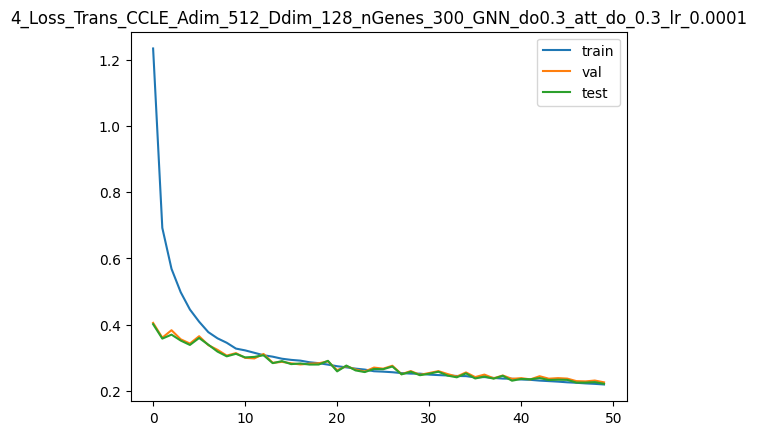

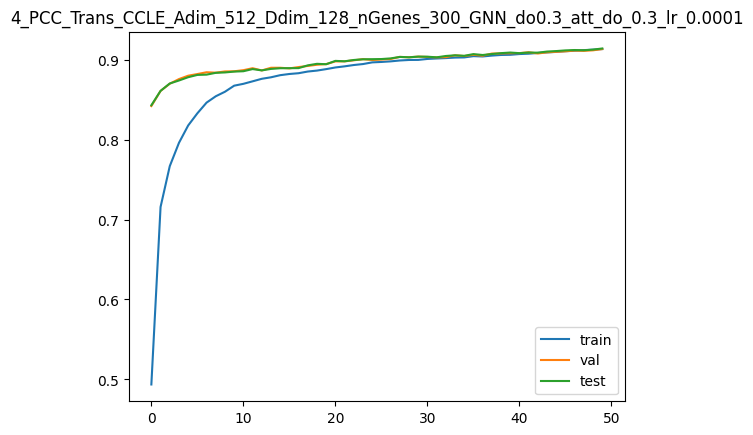

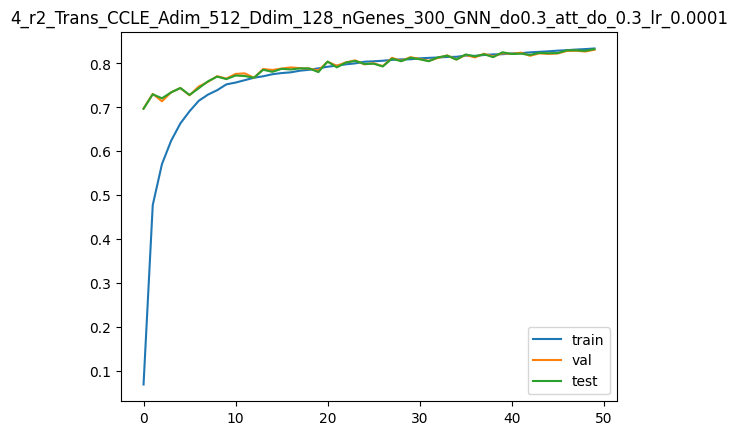

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22273331880569458
The overall Pearson's correlation is 0.8963.
Train avg_loss:  0.21786079
Train avg_pcc:  0.9141079368274473
Train r2:  0.8355867653523983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22328272
Validation avg_pcc:  0.9131104282655899
Validation r2:  0.8334555551240361
Best Val r2  0.8334555551240361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21828356
Test avg_pcc:  0.9142077913982439
Test r2:  0.8353044753833342
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21604274213314056
The overall Pearson's correlation is 0.9167.
Train avg_loss:  0.21707092
Train avg_pcc:  0.9144343997237854
Train r2:  0.8361828593626524


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23183954
Validation avg_pcc:  0.9137517967335136
Validation r2:  0.8270731025271612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22533779
Test avg_pcc:  0.9146740243500692
Test r2:  0.829982047342746
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21624720096588135
The overall Pearson's correlation is 0.9206.
Train avg_loss:  0.21502161
Train avg_pcc:  0.9152786949810373
Train r2:  0.8377294187086479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22186008
Validation avg_pcc:  0.9136243946188161
Validation r2:  0.8345166897265062
Best Val r2  0.8345166897265062


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21613753
Test avg_pcc:  0.9150052811304165
Test r2:  0.8369236706659102
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.147934690117836
The overall Pearson's correlation is 0.9393.
Train avg_loss:  0.21219851
Train avg_pcc:  0.9164411219029904
Train r2:  0.8398599366878953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22666177
Validation avg_pcc:  0.9146742669019081
Validation r2:  0.8309351450136404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2223591
Test avg_pcc:  0.9151990392521911
Test r2:  0.8322294760629995
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17706182599067688
The overall Pearson's correlation is 0.9319.
Train avg_loss:  0.21120876
Train avg_pcc:  0.9168500202727508
Train r2:  0.8406068654737193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22135869
Validation avg_pcc:  0.9145139359255418
Validation r2:  0.8348906788612576
Best Val r2  0.8348906788612576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21755487
Test avg_pcc:  0.9151678983383131
Test r2:  0.8358542779595971
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1596687138080597
The overall Pearson's correlation is 0.9405.
Train avg_loss:  0.2100405
Train avg_pcc:  0.9173298234136698
Train r2:  0.8414885369037087


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22165185
Validation avg_pcc:  0.9144627036331454
Validation r2:  0.8346720195465366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21602812
Test avg_pcc:  0.9156867125306435
Test r2:  0.8370062154849105
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23168158531188965
The overall Pearson's correlation is 0.9113.
Train avg_loss:  0.20968361
Train avg_pcc:  0.9174764480091346
Train r2:  0.8417578659207662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22174126
Validation avg_pcc:  0.9152895222212032
Validation r2:  0.8346053279031198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21434617
Test avg_pcc:  0.916780031158151
Test r2:  0.8382752453643273
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1730959713459015
The overall Pearson's correlation is 0.9359.
Train avg_loss:  0.20697108
Train avg_pcc:  0.9185923238347395
Train r2:  0.8438049199947604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22395775
Validation avg_pcc:  0.9152159601876619
Validation r2:  0.8329520775656454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21741964
Test avg_pcc:  0.9164557175943181
Test r2:  0.8359563175467238
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20221489667892456
The overall Pearson's correlation is 0.9111.
Train avg_loss:  0.20590001
Train avg_pcc:  0.9190310935958708
Train r2:  0.8446132194708558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21578394
Validation avg_pcc:  0.9172104948969878
Validation r2:  0.8390488451561089
Best Val r2  0.8390488451561089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21141212
Test avg_pcc:  0.9179761723297724
Test r2:  0.8404890012195846
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.33166760206222534
The overall Pearson's correlation is 0.8685.
Train avg_loss:  0.20483162
Train avg_pcc:  0.919469684736282
Train r2:  0.8454195193171954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21294919
Validation avg_pcc:  0.9172093093925788
Validation r2:  0.8411632453132932
Best Val r2  0.8411632453132932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20961243
Test avg_pcc:  0.9176043948227757
Test r2:  0.8418468650514055
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2540346086025238
The overall Pearson's correlation is 0.9118.
Train avg_loss:  0.20380102
Train avg_pcc:  0.9198930899153567
Train r2:  0.8461972633523718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21227923
Validation avg_pcc:  0.9180941067266457
Validation r2:  0.8416629583063902
Best Val r2  0.8416629583063902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20852134
Test avg_pcc:  0.918959693076443
Test r2:  0.8426701092446651
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16863541305065155
The overall Pearson's correlation is 0.9235.
Train avg_loss:  0.2021085
Train avg_pcc:  0.9205875715113335
Train r2:  0.847474561751172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21573615
Validation avg_pcc:  0.9185027052002733
Validation r2:  0.8390844757617326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2106813
Test avg_pcc:  0.9192276544088185
Test r2:  0.8410404065256458
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1887718141078949
The overall Pearson's correlation is 0.9218.
Train avg_loss:  0.20098883
Train avg_pcc:  0.9210449069744685
Train r2:  0.8483195423733001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21694037
Validation avg_pcc:  0.9181702043021218
Validation r2:  0.8381862501558838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21233569
Test avg_pcc:  0.9190126791079164
Test r2:  0.8397921621399606
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14224344491958618
The overall Pearson's correlation is 0.9557.
Train avg_loss:  0.19945279
Train avg_pcc:  0.9216750507689262
Train r2:  0.8494787612357622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21547504
Validation avg_pcc:  0.9187011972804235
Validation r2:  0.8392792343830261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21052593
Test avg_pcc:  0.9198838336482735
Test r2:  0.8411576356468995
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21196943521499634
The overall Pearson's correlation is 0.8932.
Train avg_loss:  0.19825412
Train avg_pcc:  0.9221654313439114
Train r2:  0.8503833579724202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20987163
Validation avg_pcc:  0.9191947743335596
Validation r2:  0.8434587580917127
Best Val r2  0.8434587580917127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20355113
Test avg_pcc:  0.9203737402768372
Test r2:  0.8464201361930097
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1761671006679535
The overall Pearson's correlation is 0.9305.
Train avg_loss:  0.19688956
Train avg_pcc:  0.9227227172577512
Train r2:  0.851413149716928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20946597
Validation avg_pcc:  0.9198619685841006
Validation r2:  0.8437613482425579
Best Val r2  0.8437613482425579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20335476
Test avg_pcc:  0.9212743674074431
Test r2:  0.8465683015292126
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.169332817196846
The overall Pearson's correlation is 0.9208.
Train avg_loss:  0.19460857
Train avg_pcc:  0.9236552015944386
Train r2:  0.8531345469561048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20522726
Validation avg_pcc:  0.9206337977654383
Validation r2:  0.8469229560347766
Best Val r2  0.8469229560347766


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20209761
Test avg_pcc:  0.9212587769675933
Test r2:  0.8475168221243892
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2063617706298828
The overall Pearson's correlation is 0.9153.
Train avg_loss:  0.19320191
Train avg_pcc:  0.9242300102227389
Train r2:  0.8541961215424081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20626938
Validation avg_pcc:  0.9202232750283147
Validation r2:  0.8461456413829829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20123766
Test avg_pcc:  0.9213087670507305
Test r2:  0.8481656567698205
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23218102753162384
The overall Pearson's correlation is 0.9221.
Train avg_loss:  0.19209278
Train avg_pcc:  0.924682291046962
Train r2:  0.8550331491959968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20799297
Validation avg_pcc:  0.9212622203864147
Validation r2:  0.8448600400881117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20346153
Test avg_pcc:  0.9222813137415238
Test r2:  0.8464877338644389
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12774774432182312
The overall Pearson's correlation is 0.9396.
Train avg_loss:  0.19180296
Train avg_pcc:  0.9248017219837271
Train r2:  0.8552518537386806


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20667182
Validation avg_pcc:  0.9216097882319798
Validation r2:  0.8458454736337221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2011815
Test avg_pcc:  0.9226815208360198
Test r2:  0.848208029831849
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16687804460525513
The overall Pearson's correlation is 0.9225.
Train avg_loss:  0.1890162
Train avg_pcc:  0.9259364971569651
Train r2:  0.8573549582500702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20485006
Validation avg_pcc:  0.9210421336872667
Validation r2:  0.8472043067820114
Best Val r2  0.8472043067820114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19854102
Test avg_pcc:  0.9229046953489252
Test r2:  0.8502002877073236
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19529694318771362
The overall Pearson's correlation is 0.9267.
Train avg_loss:  0.18866847
Train avg_pcc:  0.9260793258356321
Train r2:  0.8576173559175214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20301208
Validation avg_pcc:  0.9217907364822786
Validation r2:  0.8485752321799802
Best Val r2  0.8485752321799802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19820951
Test avg_pcc:  0.9230647152448928
Test r2:  0.8504504064769538
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1705475002527237
The overall Pearson's correlation is 0.9187.
Train avg_loss:  0.18717286
Train avg_pcc:  0.9266877369773934
Train r2:  0.8587460573229544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20594425
Validation avg_pcc:  0.9225395283065717
Validation r2:  0.8463881532524496


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20054127
Test avg_pcc:  0.9234218545738724
Test r2:  0.8486910812104241
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17275062203407288
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.1859667
Train avg_pcc:  0.9271789079661875
Train r2:  0.8596563147525736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20063588
Validation avg_pcc:  0.9225155633200546
Validation r2:  0.8503476215532283
Best Val r2  0.8503476215532283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19340959
Test avg_pcc:  0.9244239925511802
Test r2:  0.8540719435385822
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2117118537425995
The overall Pearson's correlation is 0.9404.
Train avg_loss:  0.18573461
Train avg_pcc:  0.9272739507709882
Train r2:  0.8598314465773252


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20105813
Validation avg_pcc:  0.92253045913958
Validation r2:  0.8500326719798827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19504312
Test avg_pcc:  0.9238921428251995
Test r2:  0.8528394634876083
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1808702051639557
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.18239103
Train avg_pcc:  0.9286324986977049
Train r2:  0.8623547643613784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20373593
Validation avg_pcc:  0.9225388234288784
Validation r2:  0.8480353211403864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19523932
Test avg_pcc:  0.9249622282221723
Test r2:  0.8526914203497599
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17383944988250732
The overall Pearson's correlation is 0.9338.
Train avg_loss:  0.18214837
Train avg_pcc:  0.9287315698488806
Train r2:  0.8625379062509181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19882903
Validation avg_pcc:  0.9236340514414725
Validation r2:  0.8516953278348882
Best Val r2  0.8516953278348882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19216298
Test avg_pcc:  0.9252541361265236
Test r2:  0.8550125225993267
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14671260118484497
The overall Pearson's correlation is 0.9513.
Train avg_loss:  0.18062736
Train avg_pcc:  0.9293495647614288
Train r2:  0.8636857633332269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1990544
Validation avg_pcc:  0.924227257385628
Validation r2:  0.8515272255811173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19305666
Test avg_pcc:  0.9257176660967317
Test r2:  0.8543382299188064
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1531907618045807
The overall Pearson's correlation is 0.9439.
Train avg_loss:  0.1794218
Train avg_pcc:  0.9298387359864884
Train r2:  0.8645955593059242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19708598
Validation avg_pcc:  0.9243128681577681
Validation r2:  0.8529954725056264
Best Val r2  0.8529954725056264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18837915
Test avg_pcc:  0.9266538143131666
Test r2:  0.8578674412208098
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16528375446796417
The overall Pearson's correlation is 0.9417.
Train avg_loss:  0.17872848
Train avg_pcc:  0.9301198563884279
Train r2:  0.8651187942705713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19378187
Validation avg_pcc:  0.9252196779449594
Validation r2:  0.8554599755858777
Best Val r2  0.8554599755858777


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18960994
Test avg_pcc:  0.9261648943213447
Test r2:  0.8569388028664804
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16089415550231934
The overall Pearson's correlation is 0.9280.
Train avg_loss:  0.17829551
Train avg_pcc:  0.9302949342660459
Train r2:  0.8654455548950168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19897205
Validation avg_pcc:  0.9250483652935451
Validation r2:  0.8515886630318239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19529182
Test avg_pcc:  0.9253013917699926
Test r2:  0.852651821605564
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17078587412834167
The overall Pearson's correlation is 0.9274.
Train avg_loss:  0.17719054
Train avg_pcc:  0.9307438474992865
Train r2:  0.86627942845897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19900104
Validation avg_pcc:  0.9245859189629759
Validation r2:  0.851567022941028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19363773
Test avg_pcc:  0.9256840011985258
Test r2:  0.8538998179929012
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17331700026988983
The overall Pearson's correlation is 0.9288.
Train avg_loss:  0.17578979
Train avg_pcc:  0.931312368855044
Train r2:  0.8673365369970795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19152279
Validation avg_pcc:  0.9260829774444919
Validation r2:  0.8571449982913071
Best Val r2  0.8571449982913071


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18712056
Test avg_pcc:  0.9269579447498764
Test r2:  0.858817043058786
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15040142834186554
The overall Pearson's correlation is 0.9263.
Train avg_loss:  0.17517161
Train avg_pcc:  0.9315612660909466
Train r2:  0.867803048732896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19634312
Validation avg_pcc:  0.9250864881744866
Validation r2:  0.8535495441402867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18814358
Test avg_pcc:  0.9272341515377034
Test r2:  0.8580451868147484
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17869333922863007
The overall Pearson's correlation is 0.9227.
Train avg_loss:  0.17417075
Train avg_pcc:  0.9319666849847205
Train r2:  0.8685583946603306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19387381
Validation avg_pcc:  0.9254053073849664
Validation r2:  0.8553913965404205


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1886726
Test avg_pcc:  0.9266957362029586
Test r2:  0.8576460214297946
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14210927486419678
The overall Pearson's correlation is 0.9242.
Train avg_loss:  0.1736573
Train avg_pcc:  0.9321752746040324
Train r2:  0.8689458602839017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19086735
Validation avg_pcc:  0.9265536330946618
Validation r2:  0.857633878688641
Best Val r2  0.857633878688641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18630762
Test avg_pcc:  0.927627150386726
Test r2:  0.8594304018258407
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13502541184425354
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.17196102
Train avg_pcc:  0.932860886802133
Train r2:  0.8702259829484976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19290589
Validation avg_pcc:  0.925822671669711
Validation r2:  0.8561133548383176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18611565
Test avg_pcc:  0.9276265965117557
Test r2:  0.8595752466012728
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16612249612808228
The overall Pearson's correlation is 0.9418.
Train avg_loss:  0.17023368
Train avg_pcc:  0.9335599238855988
Train r2:  0.8715295573533455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18860973
Validation avg_pcc:  0.9269961729779091
Validation r2:  0.859317823355638
Best Val r2  0.859317823355638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18309735
Test avg_pcc:  0.9284549388241733
Test r2:  0.8618525710921057
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16912499070167542
The overall Pearson's correlation is 0.9312.
Train avg_loss:  0.16979194
Train avg_pcc:  0.9337370361977859
Train r2:  0.8718629511608667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1948106
Validation avg_pcc:  0.9261247565430555
Validation r2:  0.8546926502296314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18794216
Test avg_pcc:  0.9278445678259396
Test r2:  0.8581971427242612
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16334138810634613
The overall Pearson's correlation is 0.9248.
Train avg_loss:  0.16901833
Train avg_pcc:  0.934051111629195
Train r2:  0.8724467635302613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18767601
Validation avg_pcc:  0.9274847629344023
Validation r2:  0.8600142653745707
Best Val r2  0.8600142653745707


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18189366
Test avg_pcc:  0.9289450396839024
Test r2:  0.8627607543200524
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1970597505569458
The overall Pearson's correlation is 0.9235.
Train avg_loss:  0.16835357
Train avg_pcc:  0.9343186811114511
Train r2:  0.8729484414713012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19358674
Validation avg_pcc:  0.9269000188506606
Validation r2:  0.8556055162395741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18665518
Test avg_pcc:  0.9283855578099932
Test r2:  0.859168183759133
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15970712900161743
The overall Pearson's correlation is 0.9351.
Train avg_loss:  0.16772965
Train avg_pcc:  0.9345710590952402
Train r2:  0.8734192935487604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18771361
Validation avg_pcc:  0.9278668839148884
Validation r2:  0.8599862260562191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18243809
Test avg_pcc:  0.9292719918203839
Test r2:  0.8623499745800753
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19264182448387146
The overall Pearson's correlation is 0.9263.
Train avg_loss:  0.16665316
Train avg_pcc:  0.9350062361164672
Train r2:  0.874231676560244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19001564
Validation avg_pcc:  0.9264372474921844
Validation r2:  0.85826915892628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1813194
Test avg_pcc:  0.9291183528219716
Test r2:  0.8631940423946058
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11511484533548355
The overall Pearson's correlation is 0.9507.
Train avg_loss:  0.16549563
Train avg_pcc:  0.9354723904132417
Train r2:  0.8751052377213803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18866134
Validation avg_pcc:  0.9273047000217572
Validation r2:  0.8592793188044111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18068495
Test avg_pcc:  0.9294607135777591
Test r2:  0.863672735857355
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14001411199569702
The overall Pearson's correlation is 0.9598.
Train avg_loss:  0.16387486
Train avg_pcc:  0.9361262531160751
Train r2:  0.8763283912090005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1887054
Validation avg_pcc:  0.9278871463526581
Validation r2:  0.8592464533792602


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1833513
Test avg_pcc:  0.9288314671454428
Test r2:  0.8616609669857522
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12147188186645508
The overall Pearson's correlation is 0.9487.
Train avg_loss:  0.16471428
Train avg_pcc:  0.9357874202129348
Train r2:  0.8756949059556423


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1858315
Validation avg_pcc:  0.9283544590546904
Validation r2:  0.8613900651661552
Best Val r2  0.8613900651661552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18121524
Test avg_pcc:  0.9296798235462218
Test r2:  0.8632726269100728
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17455482482910156
The overall Pearson's correlation is 0.9343.
Train avg_loss:  0.16345055
Train avg_pcc:  0.9362974855560573
Train r2:  0.8766485963906672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19265482
Validation avg_pcc:  0.9271186151318074
Validation r2:  0.8563006208222035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18495636
Test avg_pcc:  0.9290837048054295
Test r2:  0.8604499388279585
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15971137583255768
The overall Pearson's correlation is 0.9486.
Train avg_loss:  0.16255252
Train avg_pcc:  0.9366597425851567
Train r2:  0.8773263227656689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18695176
Validation avg_pcc:  0.9277842173390252
Validation r2:  0.8605544782194163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18140307
Test avg_pcc:  0.9291893726702484
Test r2:  0.8631309048746023
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17575781047344208
The overall Pearson's correlation is 0.9388.
Train avg_loss:  0.1619668
Train avg_pcc:  0.9368942632454321
Train r2:  0.8777683334771028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18450657
Validation avg_pcc:  0.9286568205111912
Validation r2:  0.862378315825618
Best Val r2  0.862378315825618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17829463
Test avg_pcc:  0.9303704141732482
Test r2:  0.8654762395966596
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18205995857715607
The overall Pearson's correlation is 0.9209.
Train avg_loss:  0.16139896
Train avg_pcc:  0.937124130372688
Train r2:  0.8781968688321322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18517886
Validation avg_pcc:  0.9286998100633376
Validation r2:  0.8618768794868917


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17979002
Test avg_pcc:  0.9298073105121705
Test r2:  0.8643479559672002


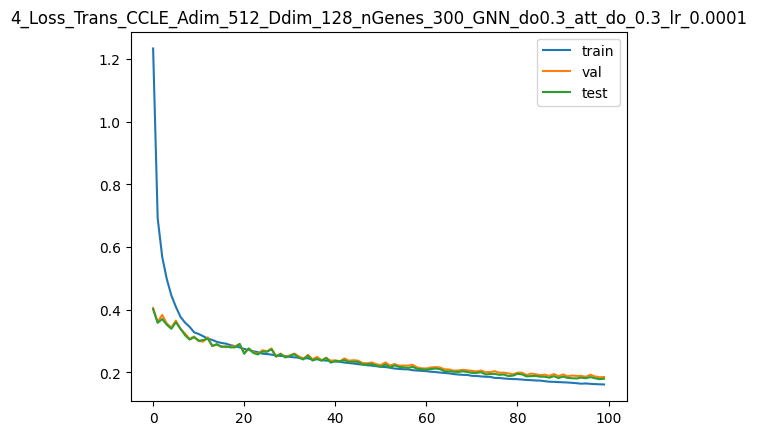

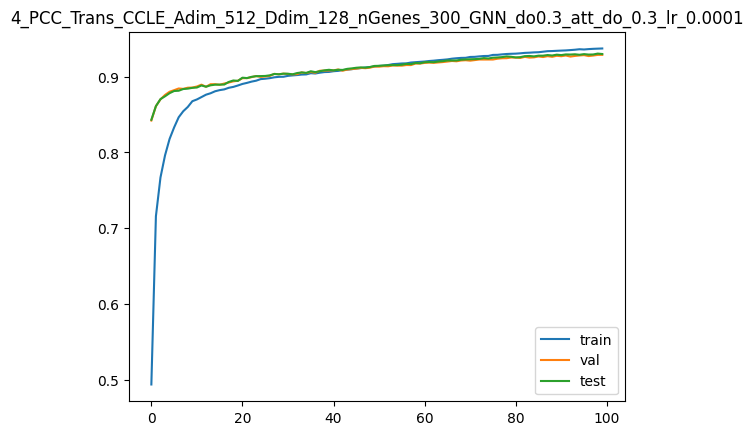

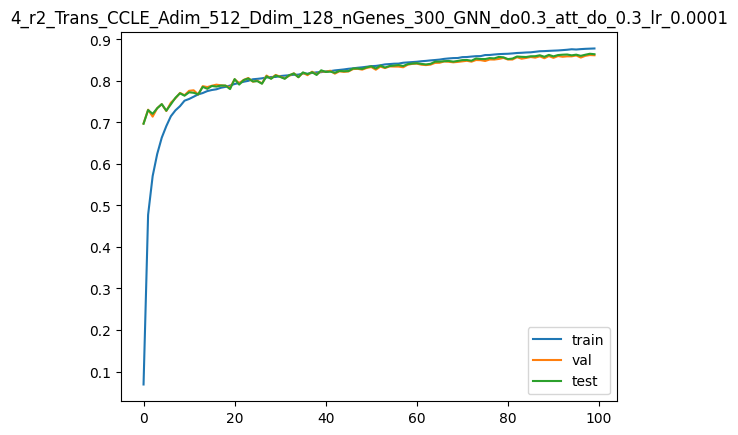

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19336658716201782
The overall Pearson's correlation is 0.9215.
Train avg_loss:  0.15973906
Train avg_pcc:  0.9377912949087465
Train r2:  0.8794495508856144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18440461
Validation avg_pcc:  0.928848351413103
Validation r2:  0.8624543795867058
Best Val r2  0.8624543795867058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17823778
Test avg_pcc:  0.9304937314403999
Test r2:  0.865519125486192
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14974254369735718
The overall Pearson's correlation is 0.9450.
Train avg_loss:  0.16004306
Train avg_pcc:  0.9376693448502883
Train r2:  0.8792201405546725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18908411
Validation avg_pcc:  0.927695649873842
Validation r2:  0.8589639774847917


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18021381
Test avg_pcc:  0.9300652486040474
Test r2:  0.8640282037325044
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17456887662410736
The overall Pearson's correlation is 0.9201.
Train avg_loss:  0.15765351
Train avg_pcc:  0.938630608804403
Train r2:  0.8810234698282501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18681754
Validation avg_pcc:  0.928451996288896
Validation r2:  0.8606545862907415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17930831
Test avg_pcc:  0.930271547661571
Test r2:  0.8647114133230812
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1350925713777542
The overall Pearson's correlation is 0.9480.
Train avg_loss:  0.15731998
Train avg_pcc:  0.9387640976252745
Train r2:  0.881275172155654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18617524
Validation avg_pcc:  0.9281070437193916
Validation r2:  0.8611336797858912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.176988
Test avg_pcc:  0.9308716857283876
Test r2:  0.8664620811120664
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14498451352119446
The overall Pearson's correlation is 0.9499.
Train avg_loss:  0.15637533
Train avg_pcc:  0.9391444502753317
Train r2:  0.8819880693249158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18566309
Validation avg_pcc:  0.9292147659578148
Validation r2:  0.8615156926817579


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17671603
Test avg_pcc:  0.9316860704476042
Test r2:  0.8666672837136491
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17387062311172485
The overall Pearson's correlation is 0.9312.
Train avg_loss:  0.1562173
Train avg_pcc:  0.9392071412267944
Train r2:  0.8821073216436359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18443094
Validation avg_pcc:  0.9291851801579281
Validation r2:  0.8624347408111956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17648551
Test avg_pcc:  0.931248659156931
Test r2:  0.866841224678818
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15749409794807434
The overall Pearson's correlation is 0.9258.
Train avg_loss:  0.15590696
Train avg_pcc:  0.9393330236948803
Train r2:  0.8823415366625332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18683024
Validation avg_pcc:  0.9282074347047469
Validation r2:  0.8606451188568857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17798384
Test avg_pcc:  0.9306402378236476
Test r2:  0.865710728444183
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11468038707971573
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.1552217
Train avg_pcc:  0.9396070148898775
Train r2:  0.8828586748811789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18552653
Validation avg_pcc:  0.9295230132909758
Validation r2:  0.8616175272642527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1776261
Test avg_pcc:  0.9314378644588963
Test r2:  0.8659806316256471
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13877354562282562
The overall Pearson's correlation is 0.9399.
Train avg_loss:  0.15530574
Train avg_pcc:  0.9395740687039981
Train r2:  0.8827952489675164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18743587
Validation avg_pcc:  0.9288893167566796
Validation r2:  0.8601933892714748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17777857
Test avg_pcc:  0.9315534660208648
Test r2:  0.8658655986994783
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18003857135772705
The overall Pearson's correlation is 0.9358.
Train avg_loss:  0.1529403
Train avg_pcc:  0.9405226588857919
Train r2:  0.8845803801096361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18430947
Validation avg_pcc:  0.9287498270863257
Validation r2:  0.8625253436162954
Best Val r2  0.8625253436162954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17600778
Test avg_pcc:  0.9312585886096616
Test r2:  0.8672016753501582
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13112565875053406
The overall Pearson's correlation is 0.9505.
Train avg_loss:  0.1536017
Train avg_pcc:  0.9402583585413015
Train r2:  0.8840812241921038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18484503
Validation avg_pcc:  0.9294477347246888
Validation r2:  0.8621258729874732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1746562
Test avg_pcc:  0.9323852834422195
Test r2:  0.8682214301017993
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1431799829006195
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.15204379
Train avg_pcc:  0.9408822327604996
Train r2:  0.8852569564569852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18530115
Validation avg_pcc:  0.9295997158772574
Validation r2:  0.8617856494263206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17823249
Test avg_pcc:  0.931433529755056
Test r2:  0.8655231250199922
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19274961948394775
The overall Pearson's correlation is 0.9210.
Train avg_loss:  0.15135826
Train avg_pcc:  0.9411584573196438
Train r2:  0.8857742994208464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18371093
Validation avg_pcc:  0.9293271144378222
Validation r2:  0.8629717853761167
Best Val r2  0.8629717853761167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17594412
Test avg_pcc:  0.9318826936478571
Test r2:  0.8672497024380048
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12245306372642517
The overall Pearson's correlation is 0.9537.
Train avg_loss:  0.1506722
Train avg_pcc:  0.9414326704580729
Train r2:  0.8862920436973705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18610194
Validation avg_pcc:  0.9300154144653057
Validation r2:  0.8611883433071662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17863055
Test avg_pcc:  0.9321531155182005
Test r2:  0.8652227929086913
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17138999700546265
The overall Pearson's correlation is 0.9281.
Train avg_loss:  0.15013789
Train avg_pcc:  0.9416467670694704
Train r2:  0.8866952822376415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1794327
Validation avg_pcc:  0.9308871852724842
Validation r2:  0.8661628835777379
Best Val r2  0.8661628835777379


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17502089
Test avg_pcc:  0.9318254238953144
Test r2:  0.8679462794585389
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12100893259048462
The overall Pearson's correlation is 0.9528.
Train avg_loss:  0.14885724
Train avg_pcc:  0.9421606296302147
Train r2:  0.8876617541517366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17911936
Validation avg_pcc:  0.9310500581696686
Validation r2:  0.8663965853813453
Best Val r2  0.8663965853813453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17302136
Test avg_pcc:  0.9326680142580722
Test r2:  0.8694549357171502
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15017572045326233
The overall Pearson's correlation is 0.9507.
Train avg_loss:  0.14985758
Train avg_pcc:  0.9417591591053125
Train r2:  0.8869068295016481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18732898
Validation avg_pcc:  0.9308030650371055
Validation r2:  0.8602731301829749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17838813
Test avg_pcc:  0.9333370032613547
Test r2:  0.8654056832865051
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15740498900413513
The overall Pearson's correlation is 0.9397.
Train avg_loss:  0.1479141
Train avg_pcc:  0.9425376081908154
Train r2:  0.8883735245166239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.182847
Validation avg_pcc:  0.9299824747845039
Validation r2:  0.8636161962218438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17522919
Test avg_pcc:  0.9320224863439779
Test r2:  0.8677891196863894
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15231125056743622
The overall Pearson's correlation is 0.9407.
Train avg_loss:  0.14732401
Train avg_pcc:  0.9427742806410372
Train r2:  0.8888188358633554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18083695
Validation avg_pcc:  0.930607934225455
Validation r2:  0.8651154620210657


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1727909
Test avg_pcc:  0.9327595993243127
Test r2:  0.8696288235386596
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.182813823223114
The overall Pearson's correlation is 0.9305.
Train avg_loss:  0.14694224
Train avg_pcc:  0.9429263011188178
Train r2:  0.889106944479333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.180093
Validation avg_pcc:  0.9308433480090189
Validation r2:  0.8656703560762807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1721053
Test avg_pcc:  0.9329213289058168
Test r2:  0.870146105865354
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1315743625164032
The overall Pearson's correlation is 0.9628.
Train avg_loss:  0.14601538
Train avg_pcc:  0.9432967322860979
Train r2:  0.8898064337449589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1800297
Validation avg_pcc:  0.9304948869103795
Validation r2:  0.8657175651652685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17067485
Test avg_pcc:  0.9334003877440183
Test r2:  0.871225386773853
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13152176141738892
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.14604013
Train avg_pcc:  0.9432876560822753
Train r2:  0.8897877379688148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18411264
Validation avg_pcc:  0.9301460936641761
Validation r2:  0.8626721519774583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17332943
Test avg_pcc:  0.9331633036909022
Test r2:  0.8692224892590066
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12968578934669495
The overall Pearson's correlation is 0.9443.
Train avg_loss:  0.14530677
Train avg_pcc:  0.9435809777907136
Train r2:  0.8903411974223643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18055929
Validation avg_pcc:  0.9304044041437398
Validation r2:  0.8653225626784059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17155969
Test avg_pcc:  0.9331341815838455
Test r2:  0.8705577710402667
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15555191040039062
The overall Pearson's correlation is 0.9339.
Train avg_loss:  0.14366248
Train avg_pcc:  0.9442378789102153
Train r2:  0.8915820892665614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.180064
Validation avg_pcc:  0.931380924576348
Validation r2:  0.8656920066595918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1735265
Test avg_pcc:  0.9327553605430768
Test r2:  0.8690738106276054
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1695481836795807
The overall Pearson's correlation is 0.9371.
Train avg_loss:  0.14380817
Train avg_pcc:  0.9441800748851776
Train r2:  0.8914721299049366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17851703
Validation avg_pcc:  0.9316292223462038
Validation r2:  0.8668458542765423
Best Val r2  0.8668458542765423


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1719233
Test avg_pcc:  0.9332311128577198
Test r2:  0.8702834190318529
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10832595825195312
The overall Pearson's correlation is 0.9580.
Train avg_loss:  0.14292543
Train avg_pcc:  0.9445326209869168
Train r2:  0.8921383204455944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17688067
Validation avg_pcc:  0.9318836361898825
Validation r2:  0.8680664016722581
Best Val r2  0.8680664016722581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1717579
Test avg_pcc:  0.9330494147379762
Test r2:  0.870408206571013
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14229600131511688
The overall Pearson's correlation is 0.9432.
Train avg_loss:  0.14354804
Train avg_pcc:  0.9442845632515822
Train r2:  0.8916684472131842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18024501
Validation avg_pcc:  0.9310219607150744
Validation r2:  0.8655569795795622


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16998413
Test avg_pcc:  0.9339849080338297
Test r2:  0.87174653170409
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13656988739967346
The overall Pearson's correlation is 0.9519.
Train avg_loss:  0.14199595
Train avg_pcc:  0.9449033938545773
Train r2:  0.8928397588250364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18147318
Validation avg_pcc:  0.9310621120840943
Validation r2:  0.8646408983223521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1747864
Test avg_pcc:  0.9324972625103098
Test r2:  0.8681231923535834
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12965387105941772
The overall Pearson's correlation is 0.9316.
Train avg_loss:  0.14163949
Train avg_pcc:  0.9450457428259953
Train r2:  0.8931087749639814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18028224
Validation avg_pcc:  0.9319565839928272
Validation r2:  0.8655292158793375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17220838
Test avg_pcc:  0.9338629794687542
Test r2:  0.8700683211558815
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15280269086360931
The overall Pearson's correlation is 0.9583.
Train avg_loss:  0.14043705
Train avg_pcc:  0.9455262704805567
Train r2:  0.8940162215426946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17872976
Validation avg_pcc:  0.9312976633641062
Validation r2:  0.8666871922538272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16997275
Test avg_pcc:  0.9337502247228622
Test r2:  0.8717551134662418
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12798765301704407
The overall Pearson's correlation is 0.9627.
Train avg_loss:  0.13964553
Train avg_pcc:  0.9458418073449508
Train r2:  0.8946135504821309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17751598
Validation avg_pcc:  0.9315753462066367
Validation r2:  0.8675925399871611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1693059
Test avg_pcc:  0.9339691681326778
Test r2:  0.8722582545395978
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11005505919456482
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.13945776
Train avg_pcc:  0.9459166930462347
Train r2:  0.8947552692548246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1801362
Validation avg_pcc:  0.9319619222372372
Validation r2:  0.8656381447534214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16948496
Test avg_pcc:  0.9349878272460828
Test r2:  0.8721231363692264
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11938811838626862
The overall Pearson's correlation is 0.9551.
Train avg_loss:  0.13930546
Train avg_pcc:  0.9459775530263924
Train r2:  0.8948702130314042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1783116
Validation avg_pcc:  0.9312717507554944
Validation r2:  0.8669990911227107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17031425
Test avg_pcc:  0.9335463413246934
Test r2:  0.8714974394901105
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13069355487823486
The overall Pearson's correlation is 0.9468.
Train avg_loss:  0.13988246
Train avg_pcc:  0.945746758584321
Train r2:  0.8944347554338156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17777589
Validation avg_pcc:  0.9314162761056586
Validation r2:  0.8673986781013753


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16949335
Test avg_pcc:  0.9338735896621965
Test r2:  0.872116832745153
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13142186403274536
The overall Pearson's correlation is 0.9455.
Train avg_loss:  0.13821815
Train avg_pcc:  0.9464109977418096
Train r2:  0.895690753439654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18651114
Validation avg_pcc:  0.9310314394041801
Validation r2:  0.8608831293713801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17698552
Test avg_pcc:  0.9337789787200462
Test r2:  0.8664639612012822
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12883523106575012
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.13767602
Train avg_pcc:  0.9466276724768964
Train r2:  0.8960999003102001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17866726
Validation avg_pcc:  0.9317292067334411
Validation r2:  0.866733808867036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16886494
Test avg_pcc:  0.9346881357088874
Test r2:  0.8725909698203898
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13379213213920593
The overall Pearson's correlation is 0.9487.
Train avg_loss:  0.1373995
Train avg_pcc:  0.9467375119392613
Train r2:  0.8963085727319354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17716938
Validation avg_pcc:  0.9315864874131831
Validation r2:  0.8678510579709435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16938782
Test avg_pcc:  0.9340487621806836
Test r2:  0.8721964405660585
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12483065575361252
The overall Pearson's correlation is 0.9444.
Train avg_loss:  0.13693924
Train avg_pcc:  0.9469207078514519
Train r2:  0.8966559210072997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17685209
Validation avg_pcc:  0.932185240960906
Validation r2:  0.8680877387603486
Best Val r2  0.8680877387603486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1674275
Test avg_pcc:  0.9349227805997049
Test r2:  0.873675517065362
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12555445730686188
The overall Pearson's correlation is 0.9519.
Train avg_loss:  0.13606837
Train avg_pcc:  0.9472685775567967
Train r2:  0.8973131289232851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17908026
Validation avg_pcc:  0.931585889811495
Validation r2:  0.8664257416244291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16947713
Test avg_pcc:  0.9342623274276111
Test r2:  0.8721290578458992
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13854606449604034
The overall Pearson's correlation is 0.9485.
Train avg_loss:  0.13659914
Train avg_pcc:  0.947056175555279
Train r2:  0.8969125829019642


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17632097
Validation avg_pcc:  0.9321471159652314
Validation r2:  0.868483890291989
Best Val r2  0.868483890291989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16664048
Test avg_pcc:  0.9351359111321945
Test r2:  0.874269321504128
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12596139311790466
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.13581987
Train avg_pcc:  0.9473670546844981
Train r2:  0.8975006682114983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17742822
Validation avg_pcc:  0.9318402998555295
Validation r2:  0.867658003582591


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16790083
Test avg_pcc:  0.9348366795600759
Test r2:  0.8733183878309928
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12178990989923477
The overall Pearson's correlation is 0.9387.
Train avg_loss:  0.13439535
Train avg_pcc:  0.947934398813904
Train r2:  0.898575713397601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17556685
Validation avg_pcc:  0.9325078777779987
Validation r2:  0.8690463728994833
Best Val r2  0.8690463728994833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16830873
Test avg_pcc:  0.9345349619002273
Test r2:  0.873010621251686
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14521631598472595
The overall Pearson's correlation is 0.9510.
Train avg_loss:  0.13341886
Train avg_pcc:  0.9483225190111403
Train r2:  0.8993126586860971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17625399
Validation avg_pcc:  0.9325543814999875
Validation r2:  0.8685338440279359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1679547
Test avg_pcc:  0.9347655130066245
Test r2:  0.87327774122147
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1270098090171814
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.1345656
Train avg_pcc:  0.9478657178868172
Train r2:  0.8984472252888902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18045175
Validation avg_pcc:  0.9320794298253063
Validation r2:  0.865402772191594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16880187
Test avg_pcc:  0.9357873051906904
Test r2:  0.872638552874355
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14202773571014404
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.13364251
Train avg_pcc:  0.9482341049548779
Train r2:  0.8991438545523677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17624329
Validation avg_pcc:  0.9324037658909956
Validation r2:  0.8685418101992874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16812865
Test avg_pcc:  0.9346633630247614
Test r2:  0.8731464918560685
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11641763150691986
The overall Pearson's correlation is 0.9588.
Train avg_loss:  0.13296132
Train avg_pcc:  0.9485043038009275
Train r2:  0.8996579452544171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17871834
Validation avg_pcc:  0.9325208169606457
Validation r2:  0.8666957014114838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16926461
Test avg_pcc:  0.9349281503576696
Test r2:  0.8722894032304495
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1183963418006897
The overall Pearson's correlation is 0.9579.
Train avg_loss:  0.13228622
Train avg_pcc:  0.948774062982007
Train r2:  0.900167415445993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17606322
Validation avg_pcc:  0.9321945813088224
Validation r2:  0.8686761342924809


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16607697
Test avg_pcc:  0.9352674804781689
Test r2:  0.8746944850716358
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1374381184577942
The overall Pearson's correlation is 0.9457.
Train avg_loss:  0.13204354
Train avg_pcc:  0.9488693522333365
Train r2:  0.90035055543497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1758565
Validation avg_pcc:  0.9324504623851076
Validation r2:  0.868830329408223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16865274
Test avg_pcc:  0.9345373100533376
Test r2:  0.8727510677360246
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14017021656036377
The overall Pearson's correlation is 0.9485.
Train avg_loss:  0.13250068
Train avg_pcc:  0.9486879236473337
Train r2:  0.9000055695516567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17387617
Validation avg_pcc:  0.9330827662130243
Validation r2:  0.8703074320373024
Best Val r2  0.8703074320373024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16422734
Test avg_pcc:  0.93601704131637
Test r2:  0.8760900491010326
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11174322664737701
The overall Pearson's correlation is 0.9585.
Train avg_loss:  0.13130689
Train avg_pcc:  0.9491632365912206
Train r2:  0.9009064905635852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17738163
Validation avg_pcc:  0.9326323738791227
Validation r2:  0.8676927370686445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1682306
Test avg_pcc:  0.935121294384078
Test r2:  0.8730695721136552


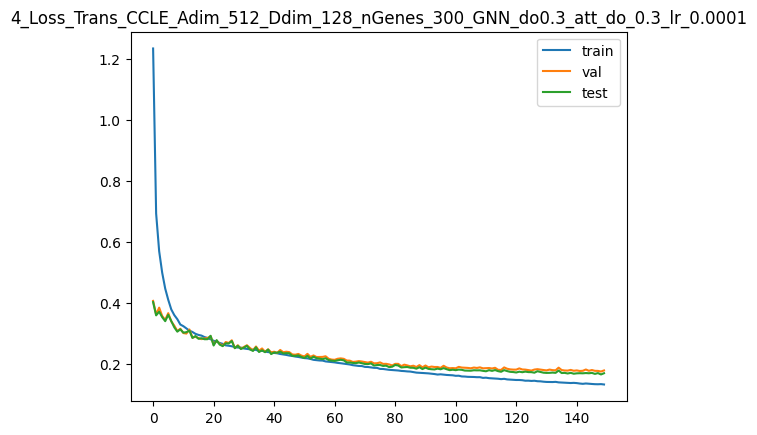

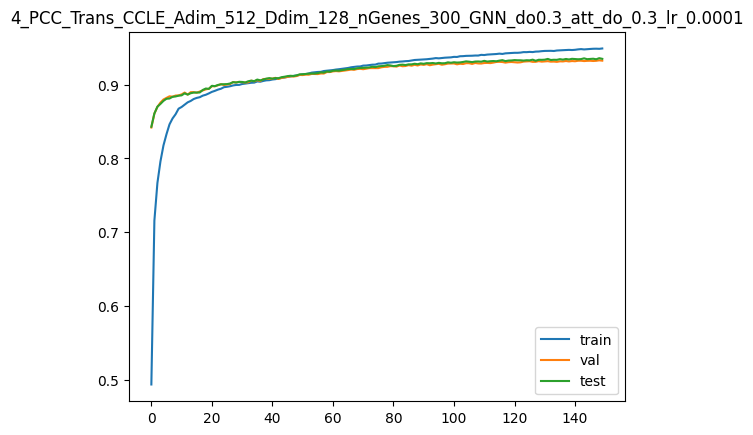

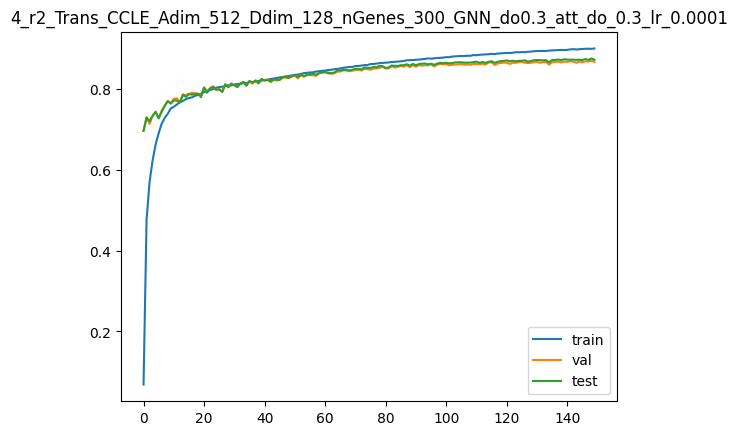

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11043670773506165
The overall Pearson's correlation is 0.9441.
Train avg_loss:  0.1302471
Train avg_pcc:  0.9495832086764524
Train r2:  0.9017062824705296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17496447
Validation avg_pcc:  0.9326229498267362
Validation r2:  0.8694956773497905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16725735
Test avg_pcc:  0.9348858761953016
Test r2:  0.8738038839515908
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1182120144367218
The overall Pearson's correlation is 0.9571.
Train avg_loss:  0.13116172
Train avg_pcc:  0.9492211411483926
Train r2:  0.901016041042199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17838264
Validation avg_pcc:  0.931739750752721
Validation r2:  0.8669461011601749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16814329
Test avg_pcc:  0.9348261956304834
Test r2:  0.8731354496396919
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11497044563293457
The overall Pearson's correlation is 0.9621.
Train avg_loss:  0.13086724
Train avg_pcc:  0.949337068306865
Train r2:  0.9012382815612215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17116188
Validation avg_pcc:  0.9341800749753955
Validation r2:  0.8723320001158794
Best Val r2  0.8723320001158794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16355981
Test avg_pcc:  0.9364253632841678
Test r2:  0.876593691270303
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12894225120544434
The overall Pearson's correlation is 0.9529.
Train avg_loss:  0.12950025
Train avg_pcc:  0.9498804751863035
Train r2:  0.9022699117740735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17438528
Validation avg_pcc:  0.9333695730562187
Validation r2:  0.8699276840931436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1650321
Test avg_pcc:  0.9359519794768205
Test r2:  0.8754828478023321
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14004355669021606
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.12927735
Train avg_pcc:  0.9499691295910403
Train r2:  0.9024381224588046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17404547
Validation avg_pcc:  0.9331901881314332
Validation r2:  0.8701811464878161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16655381
Test avg_pcc:  0.9352417130706376
Test r2:  0.8743347200866327
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12945719063282013
The overall Pearson's correlation is 0.9426.
Train avg_loss:  0.12867822
Train avg_pcc:  0.9502067240178598
Train r2:  0.9028902682379559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17241557
Validation avg_pcc:  0.9340164190042508
Validation r2:  0.871396881284451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16445254
Test avg_pcc:  0.9362638669877483
Test r2:  0.8759201352289291
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11819633096456528
The overall Pearson's correlation is 0.9571.
Train avg_loss:  0.12816805
Train avg_pcc:  0.9504099472909697
Train r2:  0.9032752810287916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17508748
Validation avg_pcc:  0.9333735436923589
Validation r2:  0.8694039323638856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16576491
Test avg_pcc:  0.935819255432395
Test r2:  0.8749299296299186
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14031612873077393
The overall Pearson's correlation is 0.9231.
Train avg_loss:  0.1280184
Train avg_pcc:  0.9504693284750476
Train r2:  0.9033882289249017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17423977
Validation avg_pcc:  0.9340205723369495
Validation r2:  0.8700362384153576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16603869
Test avg_pcc:  0.9361114455679876
Test r2:  0.8747233716665024
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12233064323663712
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.1268804
Train avg_pcc:  0.9509204521573412
Train r2:  0.9042470236983052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17184967
Validation avg_pcc:  0.9338257085102488
Validation r2:  0.8718189920277175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16396911
Test avg_pcc:  0.936132579791947
Test r2:  0.8762848707241561
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12704801559448242
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.12667796
Train avg_pcc:  0.9510004694161145
Train r2:  0.9043998096748829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17295866
Validation avg_pcc:  0.9337068092143678
Validation r2:  0.8709918012606881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16505855
Test avg_pcc:  0.9358552889894386
Test r2:  0.875462894641022
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1509896218776703
The overall Pearson's correlation is 0.9389.
Train avg_loss:  0.126734
Train avg_pcc:  0.950978779409194
Train r2:  0.9043575191645257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17381087
Validation avg_pcc:  0.9343417490580352
Validation r2:  0.8703561431929919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16717158
Test avg_pcc:  0.9358836853796654
Test r2:  0.8738685952436086
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10640373826026917
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.12587328
Train avg_pcc:  0.9513205748767654
Train r2:  0.9050070939310623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17166752
Validation avg_pcc:  0.9342094666230447
Validation r2:  0.8719548589788648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1638706
Test avg_pcc:  0.9362859123976419
Test r2:  0.8763591960316276
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12243090569972992
The overall Pearson's correlation is 0.9480.
Train avg_loss:  0.12549222
Train avg_pcc:  0.9514713378609496
Train r2:  0.9052946713903466


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17552577
Validation avg_pcc:  0.9334513984503767
Validation r2:  0.8690770176854816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16532402
Test avg_pcc:  0.9363163605583702
Test r2:  0.8752625915127308
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1266874074935913
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.12468796
Train avg_pcc:  0.9517902481562484
Train r2:  0.9059015966517022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17239037
Validation avg_pcc:  0.9337550894717248
Validation r2:  0.8714156732108095


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16413741
Test avg_pcc:  0.9360694639635249
Test r2:  0.8761578941389017
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12538139522075653
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.12516992
Train avg_pcc:  0.9515988231343143
Train r2:  0.9055378785647215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17013521
Validation avg_pcc:  0.9348233120884164
Validation r2:  0.8730977809568912
Best Val r2  0.8730977809568912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16220097
Test avg_pcc:  0.9369604481949759
Test r2:  0.8776189407082257
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13577213883399963
The overall Pearson's correlation is 0.9609.
Train avg_loss:  0.124338314
Train avg_pcc:  0.9519289988177613
Train r2:  0.9061654777588367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.170643
Validation avg_pcc:  0.9347545366631111
Validation r2:  0.8727190146249443


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16307332
Test avg_pcc:  0.9366262479446136
Test r2:  0.8769607445811295
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11930258572101593
The overall Pearson's correlation is 0.9647.
Train avg_loss:  0.12486903
Train avg_pcc:  0.9517181669780567
Train r2:  0.9057649650083759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16959521
Validation avg_pcc:  0.9348392913309457
Validation r2:  0.8735005591254621
Best Val r2  0.8735005591254621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16268428
Test avg_pcc:  0.9366454466415157
Test r2:  0.8772542977483749
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09671054780483246
The overall Pearson's correlation is 0.9683.
Train avg_loss:  0.12398578
Train avg_pcc:  0.9520684949308793
Train r2:  0.906431515770985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17426169
Validation avg_pcc:  0.9347678843174905
Validation r2:  0.8700198837956113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16626643
Test avg_pcc:  0.9366660316018229
Test r2:  0.8745515428347664
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12679560482501984
The overall Pearson's correlation is 0.9358.
Train avg_loss:  0.12259511
Train avg_pcc:  0.952619957223762
Train r2:  0.9074810170058344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17054163
Validation avg_pcc:  0.934382436591684
Validation r2:  0.8727946356405005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16369124
Test avg_pcc:  0.9363076250795745
Test r2:  0.8764945285701298
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13714323937892914
The overall Pearson's correlation is 0.9528.
Train avg_loss:  0.12276979
Train avg_pcc:  0.9525504522494069
Train r2:  0.907349192025951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17318223
Validation avg_pcc:  0.9338417439553182
Validation r2:  0.8708250327148788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16544217
Test avg_pcc:  0.9360011651338846
Test r2:  0.8751734509255521
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07812470197677612
The overall Pearson's correlation is 0.9679.
Train avg_loss:  0.1222522
Train avg_pcc:  0.9527549628944038
Train r2:  0.907739794043654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16934028
Validation avg_pcc:  0.9348007707694168
Validation r2:  0.8736907179122934
Best Val r2  0.8736907179122934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16154468
Test avg_pcc:  0.9370986376486067
Test r2:  0.878114119728424
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14234668016433716
The overall Pearson's correlation is 0.9480.
Train avg_loss:  0.12241791
Train avg_pcc:  0.95269020330044
Train r2:  0.907614744399406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17296886
Validation avg_pcc:  0.9337907368996047
Validation r2:  0.8709841853255995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16234303
Test avg_pcc:  0.9369341073978514
Test r2:  0.8775117606161361
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12319129705429077
The overall Pearson's correlation is 0.9598.
Train avg_loss:  0.122471765
Train avg_pcc:  0.9526683184365782
Train r2:  0.9075741060145306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17611313
Validation avg_pcc:  0.9337301036049713
Validation r2:  0.8686389094389699


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16673507
Test avg_pcc:  0.9363107300870404
Test r2:  0.8741979507751421
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.146116241812706
The overall Pearson's correlation is 0.9333.
Train avg_loss:  0.12092587
Train avg_pcc:  0.9532802544857781
Train r2:  0.9087407442866051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16972475
Validation avg_pcc:  0.9350153206247521
Validation r2:  0.8734039390628833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16143411
Test avg_pcc:  0.9375406342884385
Test r2:  0.8781975422593293
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10539346188306808
The overall Pearson's correlation is 0.9489.
Train avg_loss:  0.12072165
Train avg_pcc:  0.9533617913424488
Train r2:  0.9088948744801847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16966322
Validation avg_pcc:  0.9351174783445423
Validation r2:  0.873449844725457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16022828
Test avg_pcc:  0.9377927071169683
Test r2:  0.8791073385556916
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12101268768310547
The overall Pearson's correlation is 0.9604.
Train avg_loss:  0.12123866
Train avg_pcc:  0.9531562936075321
Train r2:  0.9085046859979228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17005868
Validation avg_pcc:  0.934661232562418
Validation r2:  0.8731548618960682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16055308
Test avg_pcc:  0.9375033976662823
Test r2:  0.8788622740853834
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12419620156288147
The overall Pearson's correlation is 0.9383.
Train avg_loss:  0.12081656
Train avg_pcc:  0.953323707196308
Train r2:  0.9088232352028057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17156175
Validation avg_pcc:  0.9344691617409003
Validation r2:  0.8720337427687954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16088201
Test avg_pcc:  0.9375870662324779
Test r2:  0.8786140982093847
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13798226416110992
The overall Pearson's correlation is 0.9516.
Train avg_loss:  0.12054788
Train avg_pcc:  0.9534304380646901
Train r2:  0.9090260007410164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17057267
Validation avg_pcc:  0.9344209857373023
Validation r2:  0.8727714883486464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16372956
Test avg_pcc:  0.9362489541629924
Test r2:  0.876465605543346
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14009541273117065
The overall Pearson's correlation is 0.9341.
Train avg_loss:  0.11994235
Train avg_pcc:  0.9536693395603748
Train r2:  0.9094829776239481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17177989
Validation avg_pcc:  0.9341868531089176
Validation r2:  0.8718710307669254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16256389
Test avg_pcc:  0.9369008839086314
Test r2:  0.8773451211864137
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11532685905694962
The overall Pearson's correlation is 0.9496.
Train avg_loss:  0.11935682
Train avg_pcc:  0.9539021307035219
Train r2:  0.9099248550273883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17158116
Validation avg_pcc:  0.9346082338833659
Validation r2:  0.8720192581666955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16249633
Test avg_pcc:  0.9369939992230563
Test r2:  0.8773960891941887
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11435317993164062
The overall Pearson's correlation is 0.9576.
Train avg_loss:  0.11904843
Train avg_pcc:  0.9540232837081195
Train r2:  0.9101575998088014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17073168
Validation avg_pcc:  0.9346173996062542
Validation r2:  0.8726528793144601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16142939
Test avg_pcc:  0.9372981496313341
Test r2:  0.8782010981953944
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10133945941925049
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.118841894
Train avg_pcc:  0.9541049840982161
Train r2:  0.9103134593671808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17054576
Validation avg_pcc:  0.9344027049024275
Validation r2:  0.872791560999127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16191745
Test avg_pcc:  0.9369456921137593
Test r2:  0.8778328710253285
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1350877285003662
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.118233815
Train avg_pcc:  0.9543454551313734
Train r2:  0.9107723601311207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17603801
Validation avg_pcc:  0.9331483063856715
Validation r2:  0.8686949375833845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16516949
Test avg_pcc:  0.9362201968232049
Test r2:  0.8753791842984535
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10972858965396881
The overall Pearson's correlation is 0.9650.
Train avg_loss:  0.11834386
Train avg_pcc:  0.9543012010478705
Train r2:  0.9106893125937983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17110373
Validation avg_pcc:  0.9347398135987932
Validation r2:  0.87237537042791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16264278
Test avg_pcc:  0.9371747516835568
Test r2:  0.8772856010325611
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11113851517438889
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.11808281
Train avg_pcc:  0.9544049378934834
Train r2:  0.9108863323564481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16856499
Validation avg_pcc:  0.9351118982982918
Validation r2:  0.8742689947828719
Best Val r2  0.8742689947828719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16036102
Test avg_pcc:  0.9375860286435983
Test r2:  0.8790071980292254
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13516584038734436
The overall Pearson's correlation is 0.9553.
Train avg_loss:  0.117538236
Train avg_pcc:  0.9546205376385606
Train r2:  0.9112972931391147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16734165
Validation avg_pcc:  0.9355480992070089
Validation r2:  0.8751814822506876
Best Val r2  0.8751814822506876


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.159376
Test avg_pcc:  0.9379909480908651
Test r2:  0.87975039051779
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.121303990483284
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.11648316
Train avg_pcc:  0.9550377205459666
Train r2:  0.9120935219416489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16854544
Validation avg_pcc:  0.9352505872081092
Validation r2:  0.874283577522337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16033615
Test avg_pcc:  0.9375792848005061
Test r2:  0.879025955912603
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.135229229927063
The overall Pearson's correlation is 0.9551.
Train avg_loss:  0.11765756
Train avg_pcc:  0.9545733301949852
Train r2:  0.911207244253758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16962852
Validation avg_pcc:  0.9350920730058381
Validation r2:  0.8734757116603955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16120782
Test avg_pcc:  0.9374205261549051
Test r2:  0.8783682734683215
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10933530330657959
The overall Pearson's correlation is 0.9557.
Train avg_loss:  0.116534725
Train avg_pcc:  0.9550168177479846
Train r2:  0.9120546103264687


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16927268
Validation avg_pcc:  0.9349241053190368
Validation r2:  0.8737411464541309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16072635
Test avg_pcc:  0.9375012476747453
Test r2:  0.8787315440998483
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11926479637622833
The overall Pearson's correlation is 0.9489.
Train avg_loss:  0.11559479
Train avg_pcc:  0.9553885476822591
Train r2:  0.9127639538923259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17034492
Validation avg_pcc:  0.9345690612829801
Validation r2:  0.8729413638318118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1605914
Test avg_pcc:  0.9374999874991248
Test r2:  0.8788333830205673
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12679673731327057
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.11593385
Train avg_pcc:  0.9552539927861652
Train r2:  0.9125080810393117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1686028
Validation avg_pcc:  0.935305153864237
Validation r2:  0.8742408007354796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16004293
Test avg_pcc:  0.9377274191515813
Test r2:  0.8792471900599826
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10583408921957016
The overall Pearson's correlation is 0.9514.
Train avg_loss:  0.11553012
Train avg_pcc:  0.9554136980281286
Train r2:  0.9128127647833345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16723675
Validation avg_pcc:  0.9357448240356737
Validation r2:  0.8752597293903804
Best Val r2  0.8752597293903804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1582628
Test avg_pcc:  0.9384528579707588
Test r2:  0.8805903006154204
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10351672023534775
The overall Pearson's correlation is 0.9527.
Train avg_loss:  0.11578838
Train avg_pcc:  0.9553118947635668
Train r2:  0.9126178700727021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17070246
Validation avg_pcc:  0.9343363014203074
Validation r2:  0.8726746908544394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16144353
Test avg_pcc:  0.9371242047716746
Test r2:  0.8781904357035507
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14040638506412506
The overall Pearson's correlation is 0.9391.
Train avg_loss:  0.11462676
Train avg_pcc:  0.9557701864923129
Train r2:  0.9134945020099031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1702687
Validation avg_pcc:  0.9346507685435463
Validation r2:  0.8729982271164092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15958883
Test avg_pcc:  0.9380190292775394
Test r2:  0.8795898127656332
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12925025820732117
The overall Pearson's correlation is 0.9586.
Train avg_loss:  0.11453312
Train avg_pcc:  0.9558074038734484
Train r2:  0.9135651675877723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16819364
Validation avg_pcc:  0.9352602137868298
Validation r2:  0.874545987369843


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1597369
Test avg_pcc:  0.9378697235937737
Test r2:  0.8794780959520428
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11443505436182022
The overall Pearson's correlation is 0.9557.
Train avg_loss:  0.114273064
Train avg_pcc:  0.9559105908448727
Train r2:  0.9137614311080952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17010592
Validation avg_pcc:  0.9356088509438817
Validation r2:  0.8731196286526868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16053873
Test avg_pcc:  0.9383251275104233
Test r2:  0.8788731060528479
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10038770735263824
The overall Pearson's correlation is 0.9572.
Train avg_loss:  0.11299666
Train avg_pcc:  0.9564132561706302
Train r2:  0.9147247005976518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16876431
Validation avg_pcc:  0.9357556642136461
Validation r2:  0.8741203209328884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15990588
Test avg_pcc:  0.9380942357562546
Test r2:  0.879350597680542
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13296356797218323
The overall Pearson's correlation is 0.9346.
Train avg_loss:  0.11482741
Train avg_pcc:  0.955691306013904
Train r2:  0.9133430746280848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17031927
Validation avg_pcc:  0.9349058615914978
Validation r2:  0.8729604859715354


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15913287
Test avg_pcc:  0.9382605890437574
Test r2:  0.8799338386731042
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09484074264764786
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.11392418
Train avg_pcc:  0.9560477807278907
Train r2:  0.9140247175064923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16934071
Validation avg_pcc:  0.9358013426199653
Validation r2:  0.8736903954323221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1604167
Test avg_pcc:  0.9380953738439689
Test r2:  0.878965170763511
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1311049610376358
The overall Pearson's correlation is 0.9440.
Train avg_loss:  0.11355758
Train avg_pcc:  0.9561924022405178
Train r2:  0.9143013788485145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16875143
Validation avg_pcc:  0.9353120622096155
Validation r2:  0.8741299170545294


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15918903
Test avg_pcc:  0.9381056867713722
Test r2:  0.8798914533711459


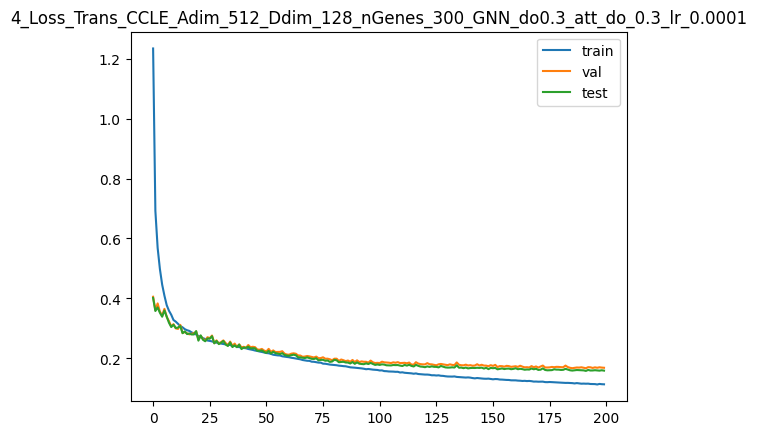

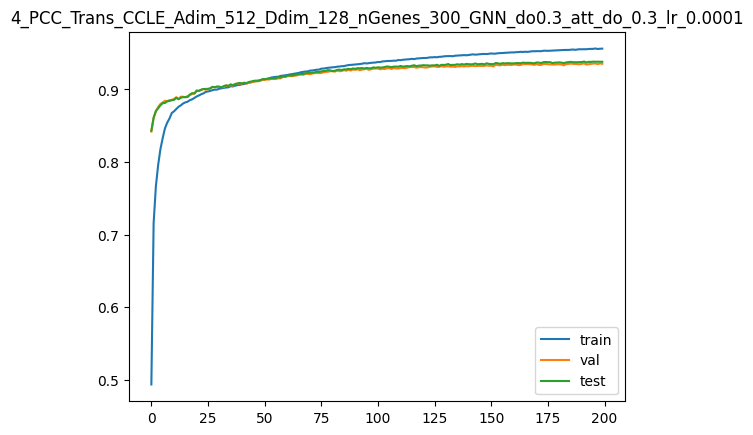

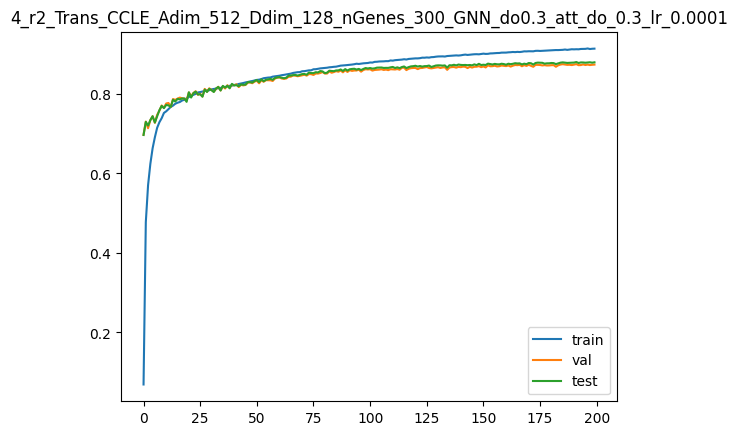

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15826279
Test avg_pcc:  0.9384528583032645
Test r2:  0.8805903030044437


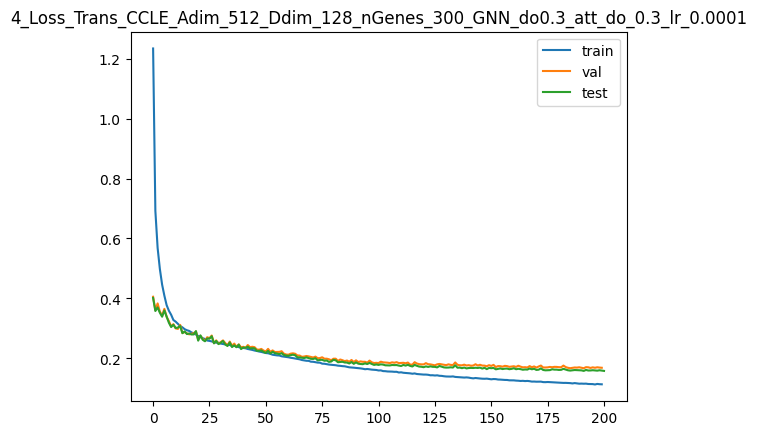

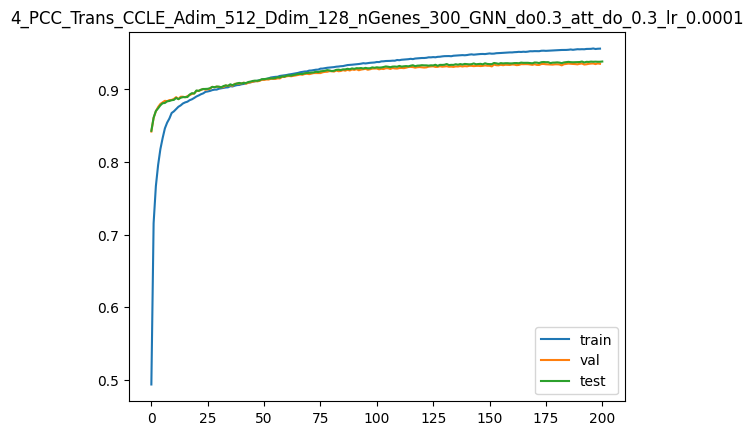

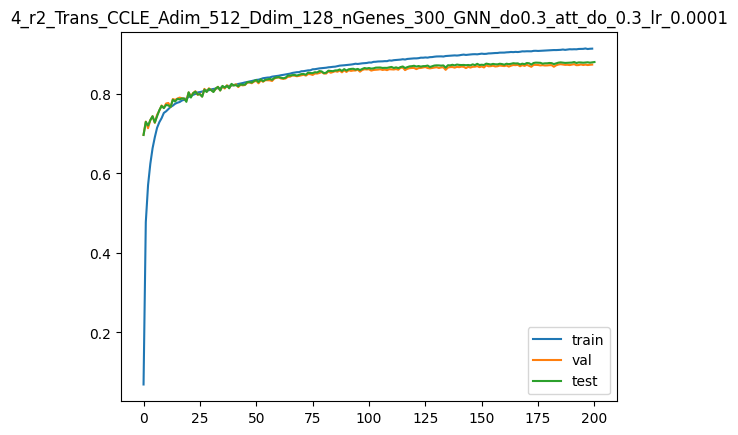

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.790557861328125
The overall Pearson's correlation is 0.6688.
Train avg_loss:  1.2100753
Train avg_pcc:  0.4880134948089264
Train r2:  0.0849325062586116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.48180825
Validation avg_pcc:  0.8513118553977626
Validation r2:  0.6324764516912404
Best Val r2  0.6324764516912404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.51686114
Test avg_pcc:  0.8443836859064633
Test r2:  0.6146975614905643
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6288071274757385
The overall Pearson's correlation is 0.7872.
Train avg_loss:  0.68811065
Train avg_pcc:  0.7153637257165647
Train r2:  0.47964579513655337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3258831
Validation avg_pcc:  0.8684326375379523
Validation r2:  0.7514162018015447
Best Val r2  0.7514162018015447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34391665
Test avg_pcc:  0.8642251282569703
Test r2:  0.7436218168884239
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5117805004119873
The overall Pearson's correlation is 0.7893.
Train avg_loss:  0.56381303
Train avg_pcc:  0.7674806112246436
Train r2:  0.5736406342382006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32324585
Validation avg_pcc:  0.8753831886319074
Validation r2:  0.7534279006448352
Best Val r2  0.7534279006448352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34397638
Test avg_pcc:  0.8709699424926856
Test r2:  0.7435773036098423
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4531671404838562
The overall Pearson's correlation is 0.8311.
Train avg_loss:  0.49412417
Train avg_pcc:  0.7967196483112423
Train r2:  0.6263398278579468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33005336
Validation avg_pcc:  0.8829480463076927
Validation r2:  0.7482351150125364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35502282
Test avg_pcc:  0.8767067172349299
Test r2:  0.7353425377734361
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.46641653776168823
The overall Pearson's correlation is 0.7716.
Train avg_loss:  0.44441512
Train avg_pcc:  0.8175188571766225
Train r2:  0.6639300926720508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30019483
Validation avg_pcc:  0.8842450104263855
Validation r2:  0.7710112360620469
Best Val r2  0.7710112360620469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31802008
Test avg_pcc:  0.8797591923246146
Test r2:  0.7629268540164363
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3561764359474182
The overall Pearson's correlation is 0.8695.
Train avg_loss:  0.40365174
Train avg_pcc:  0.8348108327383167
Train r2:  0.6947557047874782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.287268
Validation avg_pcc:  0.8891803130895494
Validation r2:  0.7808717972060513
Best Val r2  0.7808717972060513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31062523
Test avg_pcc:  0.8823913020859879
Test r2:  0.7684394713951276
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.48190873861312866
The overall Pearson's correlation is 0.8163.
Train avg_loss:  0.38037437
Train avg_pcc:  0.8446775964571951
Train r2:  0.7123581773709431


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32350975
Validation avg_pcc:  0.8876431454904604
Validation r2:  0.7532266055847663


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34656677
Test avg_pcc:  0.8824207418732481
Test r2:  0.7416462557113013
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2857394218444824
The overall Pearson's correlation is 0.8874.
Train avg_loss:  0.35691065
Train avg_pcc:  0.8547952167523208
Train r2:  0.7301016321511089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28140154
Validation avg_pcc:  0.8895015623336493
Validation r2:  0.7853467636911853
Best Val r2  0.7853467636911853


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30077243
Test avg_pcc:  0.8845470057189638
Test r2:  0.775784380264045
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25501760840415955
The overall Pearson's correlation is 0.9096.
Train avg_loss:  0.34168786
Train avg_pcc:  0.8613221637790223
Train r2:  0.7416132227401628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29891473
Validation avg_pcc:  0.8914857498922254
Validation r2:  0.7719876873396893


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31608644
Test avg_pcc:  0.8864854096399626
Test r2:  0.7643683116848742
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3912588059902191
The overall Pearson's correlation is 0.8172.
Train avg_loss:  0.32940307
Train avg_pcc:  0.866625500737574
Train r2:  0.7509030468230757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28667274
Validation avg_pcc:  0.8919198502570267
Validation r2:  0.7813258736827602


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30542624
Test avg_pcc:  0.8867679645744344
Test r2:  0.772315133903585
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3070732355117798
The overall Pearson's correlation is 0.9023.
Train avg_loss:  0.32161677
Train avg_pcc:  0.8699820242290993
Train r2:  0.7567911172590659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32887888
Validation avg_pcc:  0.8923653751349507
Validation r2:  0.7491310403850326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34702268
Test avg_pcc:  0.8867326789837962
Test r2:  0.741306365901977
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.33737713098526
The overall Pearson's correlation is 0.8618.
Train avg_loss:  0.31404957
Train avg_pcc:  0.8732487609342113
Train r2:  0.7625135053191604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2813563
Validation avg_pcc:  0.8928942704872901
Validation r2:  0.7853812774564244
Best Val r2  0.7853812774564244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30223003
Test avg_pcc:  0.887898777408079
Test r2:  0.7746977895333527
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2875306010246277
The overall Pearson's correlation is 0.8380.
Train avg_loss:  0.30904093
Train avg_pcc:  0.8754035786189491
Train r2:  0.7663010557478974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2778484
Validation avg_pcc:  0.8933455736281473
Validation r2:  0.7880570990253605
Best Val r2  0.7880570990253605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29518095
Test avg_pcc:  0.8890789289275269
Test r2:  0.7799526501492262
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35873621702194214
The overall Pearson's correlation is 0.8587.
Train avg_loss:  0.3034572
Train avg_pcc:  0.8778083489746971
Train r2:  0.7705235077987107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27005792
Validation avg_pcc:  0.8956218394517623
Validation r2:  0.7939997060917624
Best Val r2  0.7939997060917624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28878725
Test avg_pcc:  0.8912232768504169
Test r2:  0.7847189148154867
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3008776903152466
The overall Pearson's correlation is 0.8945.
Train avg_loss:  0.29795647
Train avg_pcc:  0.8801703939291341
Train r2:  0.7746831760239707


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27218094
Validation avg_pcc:  0.8969211766519463
Validation r2:  0.792380260130896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28797004
Test avg_pcc:  0.8924282058001596
Test r2:  0.7853281187666827
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2957610487937927
The overall Pearson's correlation is 0.9118.
Train avg_loss:  0.29650897
Train avg_pcc:  0.8807931206235888
Train r2:  0.7757778063069111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26566273
Validation avg_pcc:  0.8970218394665331
Validation r2:  0.7973523506311008
Best Val r2  0.7973523506311008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2833796
Test avg_pcc:  0.8923189700381817
Test r2:  0.7887501272059876
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.37615013122558594
The overall Pearson's correlation is 0.8496.
Train avg_loss:  0.2926766
Train avg_pcc:  0.8824339955679716
Train r2:  0.7786758714182596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2845283
Validation avg_pcc:  0.8986212304295834
Validation r2:  0.7829616655279414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30259022
Test avg_pcc:  0.894530506891512
Test r2:  0.7744292629933182
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32698577642440796
The overall Pearson's correlation is 0.8781.
Train avg_loss:  0.28935552
Train avg_pcc:  0.8838587658309538
Train r2:  0.7811873034475911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26870587
Validation avg_pcc:  0.8995679101675507
Validation r2:  0.7950310424407292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28595507
Test avg_pcc:  0.8953119707001669
Test r2:  0.7868302102505917
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29286959767341614
The overall Pearson's correlation is 0.8777.
Train avg_loss:  0.2838092
Train avg_pcc:  0.8862237542648574
Train r2:  0.7853814517090104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2567687
Validation avg_pcc:  0.900268657771476
Validation r2:  0.8041367026734425
Best Val r2  0.8041367026734425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26882508
Test avg_pcc:  0.8975569086967994
Test r2:  0.7996000406682642
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2988211512565613
The overall Pearson's correlation is 0.8814.
Train avg_loss:  0.2796852
Train avg_pcc:  0.8879817326601938
Train r2:  0.7885000588618207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2642116
Validation avg_pcc:  0.9021623899791127
Validation r2:  0.7984592797910931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27979434
Test avg_pcc:  0.8984945665437892
Test r2:  0.7914228359121779
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23372326791286469
The overall Pearson's correlation is 0.9317.
Train avg_loss:  0.27553973
Train avg_pcc:  0.8897475693723875
Train r2:  0.79163491421818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24452145
Validation avg_pcc:  0.9054210105062137
Validation r2:  0.8134789093226472
Best Val r2  0.8134789093226472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26374486
Test avg_pcc:  0.9002002375050915
Test r2:  0.8033871729094871
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3236013948917389
The overall Pearson's correlation is 0.8640.
Train avg_loss:  0.27048323
Train avg_pcc:  0.8918919315635749
Train r2:  0.7954586618757659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24281496
Validation avg_pcc:  0.9043555099728071
Validation r2:  0.814780619302032
Best Val r2  0.814780619302032


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25713444
Test avg_pcc:  0.9009548835947174
Test r2:  0.8083150193407862
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2257557213306427
The overall Pearson's correlation is 0.8995.
Train avg_loss:  0.26856267
Train avg_pcc:  0.8927053395885902
Train r2:  0.7969110082792359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2543795
Validation avg_pcc:  0.9063910644821835
Validation r2:  0.8059591810812327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26884973
Test avg_pcc:  0.9030759753131082
Test r2:  0.7995816611922487
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3152868449687958
The overall Pearson's correlation is 0.8533.
Train avg_loss:  0.26494756
Train avg_pcc:  0.894238061245008
Train r2:  0.7996447468527944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23314486
Validation avg_pcc:  0.9069842665418149
Validation r2:  0.8221569717824793
Best Val r2  0.8221569717824793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24617732
Test avg_pcc:  0.9036548121074353
Test r2:  0.8164831892557934
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2727900743484497
The overall Pearson's correlation is 0.8945.
Train avg_loss:  0.26110476
Train avg_pcc:  0.8958591275333805
Train r2:  0.802550745047641


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24120238
Validation avg_pcc:  0.90683377610416
Validation r2:  0.8160106995684665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25636017
Test avg_pcc:  0.9029006514055116
Test r2:  0.8088921891087744
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21872733533382416
The overall Pearson's correlation is 0.8923.
Train avg_loss:  0.25988284
Train avg_pcc:  0.8963740018119211
Train r2:  0.8034747475719759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.233118
Validation avg_pcc:  0.9086787096100366
Validation r2:  0.8221774785461402
Best Val r2  0.8221774785461402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24785322
Test avg_pcc:  0.9046365665895755
Test r2:  0.815233846775952
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17157608270645142
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.25721455
Train avg_pcc:  0.8975029211384485
Train r2:  0.8054925253544778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24751492
Validation avg_pcc:  0.9084059939490378
Validation r2:  0.8111954846617129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2643118
Test avg_pcc:  0.9046393506595675
Test r2:  0.8029645645972209
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20864303410053253
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.25582415
Train avg_pcc:  0.8980838735430381
Train r2:  0.8065439587054497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2358829
Validation avg_pcc:  0.9089566702557681
Validation r2:  0.8200684075654472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25109524
Test avg_pcc:  0.9053276564778008
Test r2:  0.8128170134212117
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24132558703422546
The overall Pearson's correlation is 0.9175.
Train avg_loss:  0.25304967
Train avg_pcc:  0.899251736081931
Train r2:  0.8086420459776156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23100823
Validation avg_pcc:  0.9079501271850582
Validation r2:  0.8237868025927151
Best Val r2  0.8237868025927151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24357456
Test avg_pcc:  0.9051861568067918
Test r2:  0.8184234504076534
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22007808089256287
The overall Pearson's correlation is 0.9193.
Train avg_loss:  0.25272325
Train avg_pcc:  0.8993876096411375
Train r2:  0.8088888841537408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2338865
Validation avg_pcc:  0.9077546556196303
Validation r2:  0.8215912739727427


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24471577
Test avg_pcc:  0.9054479569354936
Test r2:  0.8175727039373518
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26863765716552734
The overall Pearson's correlation is 0.8874.
Train avg_loss:  0.2510515
Train avg_pcc:  0.9000895847228937
Train r2:  0.8101530762721358


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23481676
Validation avg_pcc:  0.9083771334687397
Validation r2:  0.8208816685364096


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24853164
Test avg_pcc:  0.9054026879756623
Test r2:  0.8147281066028055
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2925591468811035
The overall Pearson's correlation is 0.8712.
Train avg_loss:  0.25040376
Train avg_pcc:  0.9003620859868249
Train r2:  0.8106428832341858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23790734
Validation avg_pcc:  0.9099725682783354
Validation r2:  0.8185241471990748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25242418
Test avg_pcc:  0.9062340001745668
Test r2:  0.8118263462886648
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24228593707084656
The overall Pearson's correlation is 0.8822.
Train avg_loss:  0.24963985
Train avg_pcc:  0.9006850211477193
Train r2:  0.8112205882456844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23279642
Validation avg_pcc:  0.9104469707656699
Validation r2:  0.8224227799110231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24677566
Test avg_pcc:  0.9074059787953792
Test r2:  0.8160371266607473
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2302490472793579
The overall Pearson's correlation is 0.8933.
Train avg_loss:  0.24683672
Train avg_pcc:  0.9018604615871473
Train r2:  0.8133403205869616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22880264
Validation avg_pcc:  0.9120359037290137
Validation r2:  0.8254692370426633
Best Val r2  0.8254692370426633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24338607
Test avg_pcc:  0.9082626547741174
Test r2:  0.8185639460287523
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2390482872724533
The overall Pearson's correlation is 0.8643.
Train avg_loss:  0.24619648
Train avg_pcc:  0.9021266231801801
Train r2:  0.8138244881483416


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22501327
Validation avg_pcc:  0.9115249856542704
Validation r2:  0.8283597650520951
Best Val r2  0.8283597650520951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23855755
Test avg_pcc:  0.9081075738518178
Test r2:  0.8221634675391674
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2531018555164337
The overall Pearson's correlation is 0.9122.
Train avg_loss:  0.2447387
Train avg_pcc:  0.9027383153888717
Train r2:  0.8149268643699086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22754456
Validation avg_pcc:  0.9106190031793836
Validation r2:  0.8264288952325511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24110842
Test avg_pcc:  0.9074239344150148
Test r2:  0.820261868184434
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22168146073818207
The overall Pearson's correlation is 0.9176.
Train avg_loss:  0.24334599
Train avg_pcc:  0.9033220805915543
Train r2:  0.8159800366067235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22294481
Validation avg_pcc:  0.911828876717684
Validation r2:  0.8299375918205871
Best Val r2  0.8299375918205871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23664
Test avg_pcc:  0.908597804543295
Test r2:  0.8235929165160841
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2519903779029846
The overall Pearson's correlation is 0.8982.
Train avg_loss:  0.24224834
Train avg_pcc:  0.9037790676913159
Train r2:  0.816810078711918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22694977
Validation avg_pcc:  0.9115720347559384
Validation r2:  0.8268825976940671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24058194
Test avg_pcc:  0.9082197858182848
Test r2:  0.82065434592955
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1894947588443756
The overall Pearson's correlation is 0.9158.
Train avg_loss:  0.23983389
Train avg_pcc:  0.9047903029017117
Train r2:  0.8186359021464196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22530872
Validation avg_pcc:  0.9121856524616649
Validation r2:  0.8281343862692256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24031866
Test avg_pcc:  0.9085951168886366
Test r2:  0.8208506145781234
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2797853946685791
The overall Pearson's correlation is 0.8532.
Train avg_loss:  0.23873425
Train avg_pcc:  0.9052479549651082
Train r2:  0.8194674601720997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23405118
Validation avg_pcc:  0.9127264977130174
Validation r2:  0.8214656240761037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24774945
Test avg_pcc:  0.9094581272915189
Test r2:  0.8153111991305035
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26639997959136963
The overall Pearson's correlation is 0.8985.
Train avg_loss:  0.23776828
Train avg_pcc:  0.9056522346241593
Train r2:  0.8201979396476535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22654547
Validation avg_pcc:  0.9125276804788579
Validation r2:  0.8271910103027695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24075767
Test avg_pcc:  0.9094512680420661
Test r2:  0.8205233306411814
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2341151386499405
The overall Pearson's correlation is 0.8741.
Train avg_loss:  0.23523012
Train avg_pcc:  0.9067098474253431
Train r2:  0.8221173172027925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21727526
Validation avg_pcc:  0.9147170362829129
Validation r2:  0.8342623280729287
Best Val r2  0.8342623280729287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23030858
Test avg_pcc:  0.9116486950237741
Test r2:  0.8283127966207753
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3101704716682434
The overall Pearson's correlation is 0.8672.
Train avg_loss:  0.2328315
Train avg_pcc:  0.907709784129455
Train r2:  0.8239311712608909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22972146
Validation avg_pcc:  0.9130992380775647
Validation r2:  0.8247683494044507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24478862
Test avg_pcc:  0.9096133792186017
Test r2:  0.8175184101133307
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2224954515695572
The overall Pearson's correlation is 0.9223.
Train avg_loss:  0.23178086
Train avg_pcc:  0.9081507981350201
Train r2:  0.8247256789471916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21463436
Validation avg_pcc:  0.9159833535346733
Validation r2:  0.8362767935121163
Best Val r2  0.8362767935121163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22902866
Test avg_pcc:  0.9122704197546087
Test r2:  0.8292669203201326
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2049591988325119
The overall Pearson's correlation is 0.9310.
Train avg_loss:  0.22959393
Train avg_pcc:  0.9090563329500557
Train r2:  0.826379447903711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21215385
Validation avg_pcc:  0.91614189220659
Validation r2:  0.8381689295097813
Best Val r2  0.8381689295097813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22625585
Test avg_pcc:  0.9123674552124412
Test r2:  0.8313339522630698
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30486732721328735
The overall Pearson's correlation is 0.8938.
Train avg_loss:  0.22796437
Train avg_pcc:  0.9097344523473158
Train r2:  0.8276117396220131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20809287
Validation avg_pcc:  0.917474401528138
Validation r2:  0.8412666525019799
Best Val r2  0.8412666525019799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22267875
Test avg_pcc:  0.9134947717419489
Test r2:  0.8340005522169092
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23152291774749756
The overall Pearson's correlation is 0.9050.
Train avg_loss:  0.22534178
Train avg_pcc:  0.910824462921269
Train r2:  0.8295949437041787


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21128942
Validation avg_pcc:  0.9178196218220431
Validation r2:  0.8388283295366007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22709432
Test avg_pcc:  0.9135081621115153
Test r2:  0.8307089023297083
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20613016188144684
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.22416174
Train avg_pcc:  0.9113142325659459
Train r2:  0.8304873099246091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20554428
Validation avg_pcc:  0.9194137110471532
Validation r2:  0.8432107110326729
Best Val r2  0.8432107110326729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22286773
Test avg_pcc:  0.9146245492262784
Test r2:  0.8338596908595389
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21674174070358276
The overall Pearson's correlation is 0.9228.
Train avg_loss:  0.22402322
Train avg_pcc:  0.9113724408179613
Train r2:  0.830592043951359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20460843
Validation avg_pcc:  0.9196360790642892
Validation r2:  0.8439245795368506
Best Val r2  0.8439245795368506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22047257
Test avg_pcc:  0.9151682217679395
Test r2:  0.8356451973404131
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21874400973320007
The overall Pearson's correlation is 0.9172.
Train avg_loss:  0.22202525
Train avg_pcc:  0.91219971856924
Train r2:  0.8321029210885462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2027717
Validation avg_pcc:  0.9197628558524005
Validation r2:  0.8453256526068277
Best Val r2  0.8453256526068277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21729323
Test avg_pcc:  0.9158531660119927
Test r2:  0.8380152824826304


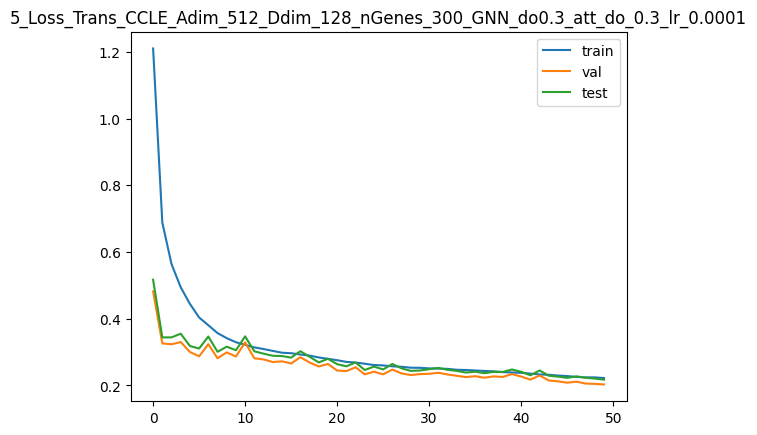

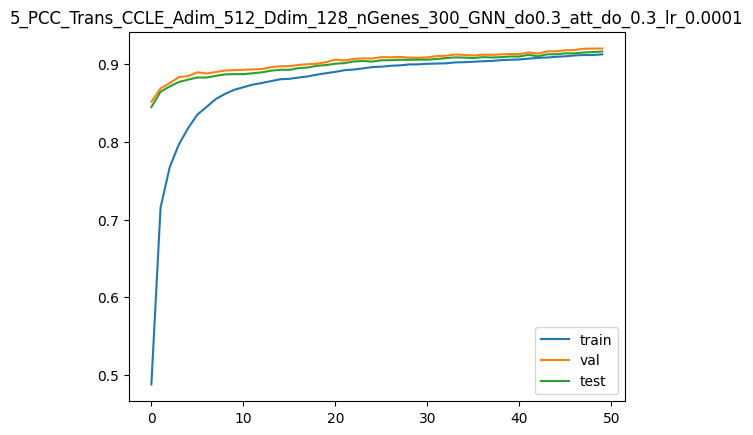

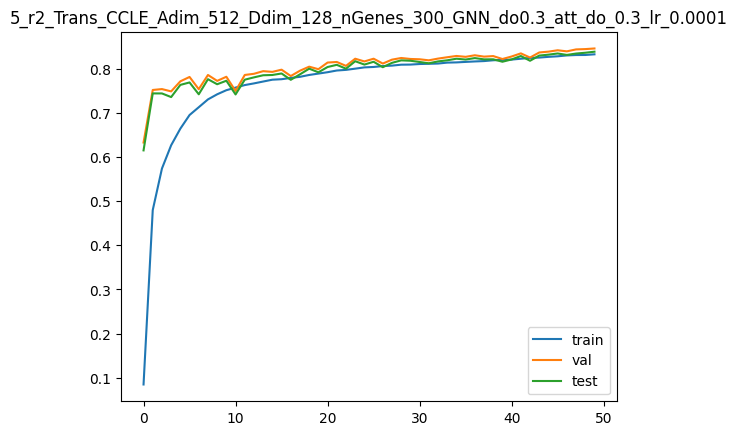

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2577883303165436
The overall Pearson's correlation is 0.8883.
Train avg_loss:  0.21861316
Train avg_pcc:  0.9136140436403102
Train r2:  0.8346831852153516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20364015
Validation avg_pcc:  0.9198532632973421
Validation r2:  0.8446631884735133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21866383
Test avg_pcc:  0.9157538020750096
Test r2:  0.836993554769303
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16577762365341187
The overall Pearson's correlation is 0.9423.
Train avg_loss:  0.21747866
Train avg_pcc:  0.9140824784821443
Train r2:  0.8355411092469163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20021693
Validation avg_pcc:  0.9205576574449614
Validation r2:  0.847274423193102
Best Val r2  0.847274423193102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21700189
Test avg_pcc:  0.915848354718362
Test r2:  0.8382324727572252
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19992440938949585
The overall Pearson's correlation is 0.9238.
Train avg_loss:  0.21523637
Train avg_pcc:  0.9150087054957421
Train r2:  0.8372367454347952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20430733
Validation avg_pcc:  0.9200961853483817
Validation r2:  0.8441542698258797


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21959767
Test avg_pcc:  0.9161116762273269
Test r2:  0.8362974117510505
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16692879796028137
The overall Pearson's correlation is 0.9445.
Train avg_loss:  0.21334273
Train avg_pcc:  0.9157917387028023
Train r2:  0.8386687131150947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19688894
Validation avg_pcc:  0.9221678363575094
Validation r2:  0.8498130046051304
Best Val r2  0.8498130046051304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21510203
Test avg_pcc:  0.9168424575345262
Test r2:  0.8396487509424636
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20318856835365295
The overall Pearson's correlation is 0.9192.
Train avg_loss:  0.21193549
Train avg_pcc:  0.9163720593764654
Train r2:  0.8397328880079225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19455312
Validation avg_pcc:  0.9228207292330493
Validation r2:  0.851594784285439
Best Val r2  0.851594784285439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20913252
Test avg_pcc:  0.9187775205599708
Test r2:  0.8440988247926327
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25259897112846375
The overall Pearson's correlation is 0.8915.
Train avg_loss:  0.21053207
Train avg_pcc:  0.9169504144719646
Train r2:  0.8407941574331272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19648372
Validation avg_pcc:  0.9231904654084133
Validation r2:  0.8501221261414754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21023625
Test avg_pcc:  0.9190714105816842
Test r2:  0.8432760183342969
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15427950024604797
The overall Pearson's correlation is 0.9445.
Train avg_loss:  0.2084156
Train avg_pcc:  0.9178239935103979
Train r2:  0.8423946391234849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20042504
Validation avg_pcc:  0.9220673878784873
Validation r2:  0.8471156701253989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21549596
Test avg_pcc:  0.918085581133255
Test r2:  0.8393550797966908
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21353688836097717
The overall Pearson's correlation is 0.9182.
Train avg_loss:  0.20603721
Train avg_pcc:  0.9188024369864347
Train r2:  0.8441932039710182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19958551
Validation avg_pcc:  0.9231329949977294
Validation r2:  0.8477560768227084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21485288
Test avg_pcc:  0.9192187434138046
Test r2:  0.8398344530577486
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1757223904132843
The overall Pearson's correlation is 0.9334.
Train avg_loss:  0.20476276
Train avg_pcc:  0.9193271361875283
Train r2:  0.845156958831836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19393349
Validation avg_pcc:  0.9231781160353226
Validation r2:  0.8520674362929206
Best Val r2  0.8520674362929206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20704317
Test avg_pcc:  0.9198316171988673
Test r2:  0.845656357847747
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2517329454421997
The overall Pearson's correlation is 0.9030.
Train avg_loss:  0.20351075
Train avg_pcc:  0.9198408525330766
Train r2:  0.8461037335923498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19480376
Validation avg_pcc:  0.924546981612373
Validation r2:  0.8514035951548269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2076275
Test avg_pcc:  0.9207471181616352
Test r2:  0.8452207455862322
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20847707986831665
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.20147304
Train avg_pcc:  0.9206802284637271
Train r2:  0.847644664768358


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1929111
Validation avg_pcc:  0.9249939387687773
Validation r2:  0.8528473047318188
Best Val r2  0.8528473047318188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20828462
Test avg_pcc:  0.920391905949982
Test r2:  0.8447308965197686
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18212103843688965
The overall Pearson's correlation is 0.9396.
Train avg_loss:  0.20071195
Train avg_pcc:  0.9209922723261516
Train r2:  0.8482202002652484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19014935
Validation avg_pcc:  0.9249470965796941
Validation r2:  0.8549539763468015
Best Val r2  0.8549539763468015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20627224
Test avg_pcc:  0.9202919196027695
Test r2:  0.8462310590560848
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2571793794631958
The overall Pearson's correlation is 0.8892.
Train avg_loss:  0.19947062
Train avg_pcc:  0.9215003306768119
Train r2:  0.8491589130200092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18807192
Validation avg_pcc:  0.9259753890379429
Validation r2:  0.8565386404169857
Best Val r2  0.8565386404169857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20069586
Test avg_pcc:  0.9223947637157717
Test r2:  0.8503880586850374
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2242882400751114
The overall Pearson's correlation is 0.9211.
Train avg_loss:  0.19631808
Train avg_pcc:  0.9227942075529627
Train r2:  0.8515428724946025


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18893169
Validation avg_pcc:  0.9258396875133694
Validation r2:  0.8558828117418257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20445283
Test avg_pcc:  0.9216901619461453
Test r2:  0.8475873690608411
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24214506149291992
The overall Pearson's correlation is 0.9071.
Train avg_loss:  0.19476949
Train avg_pcc:  0.9234278157706021
Train r2:  0.8527139304678065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19608428
Validation avg_pcc:  0.9268502123954523
Validation r2:  0.850426807511848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21326275
Test avg_pcc:  0.9227629155821557
Test r2:  0.8410198512562364
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23896688222885132
The overall Pearson's correlation is 0.9314.
Train avg_loss:  0.19526772
Train avg_pcc:  0.9232240142285493
Train r2:  0.8523371574430609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18958253
Validation avg_pcc:  0.9264942713713807
Validation r2:  0.8553863456775314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20732532
Test avg_pcc:  0.9216161002388753
Test r2:  0.8454460187479214
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19672736525535583
The overall Pearson's correlation is 0.9331.
Train avg_loss:  0.1928583
Train avg_pcc:  0.924209562665113
Train r2:  0.8541591734970033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18307447
Validation avg_pcc:  0.9276924215946407
Validation r2:  0.8603507099172829
Best Val r2  0.8603507099172829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19874199
Test avg_pcc:  0.9230126677340742
Test r2:  0.8518445952157563
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16257931292057037
The overall Pearson's correlation is 0.9322.
Train avg_loss:  0.19135548
Train avg_pcc:  0.9248250735818446
Train r2:  0.8552956220718795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18542506
Validation avg_pcc:  0.9283086664456347
Validation r2:  0.8585576880178356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2016457
Test avg_pcc:  0.9239578051455154
Test r2:  0.8496799800732181
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18965214490890503
The overall Pearson's correlation is 0.9168.
Train avg_loss:  0.18946245
Train avg_pcc:  0.9255979043789736
Train r2:  0.8567271561937735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18274729
Validation avg_pcc:  0.9278677461513789
Validation r2:  0.8606002719280169
Best Val r2  0.8606002719280169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19731544
Test avg_pcc:  0.9239292519435114
Test r2:  0.8529080460027707
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17845448851585388
The overall Pearson's correlation is 0.9259.
Train avg_loss:  0.18852074
Train avg_pcc:  0.9259838714019477
Train r2:  0.8574392902802465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18094483
Validation avg_pcc:  0.9285749453580456
Validation r2:  0.8619751901261918
Best Val r2  0.8619751901261918


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19734567
Test avg_pcc:  0.9238753308762636
Test r2:  0.8528855109861464
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17643648386001587
The overall Pearson's correlation is 0.9248.
Train avg_loss:  0.1869756
Train avg_pcc:  0.9266127034998864
Train r2:  0.8586077339986565


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18183802
Validation avg_pcc:  0.9288659878246777
Validation r2:  0.8612938668980124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1990475
Test avg_pcc:  0.9240283535365083
Test r2:  0.8516168378749008
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21908073127269745
The overall Pearson's correlation is 0.9139.
Train avg_loss:  0.18693465
Train avg_pcc:  0.9266299837042284
Train r2:  0.8586386954424523


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18226418
Validation avg_pcc:  0.9282731149712532
Validation r2:  0.8609687862915916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19732931
Test avg_pcc:  0.9237363895075935
Test r2:  0.8528977146725124
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15434730052947998
The overall Pearson's correlation is 0.9293.
Train avg_loss:  0.1850496
Train avg_pcc:  0.9273994394513586
Train r2:  0.8600641851518592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17678241
Validation avg_pcc:  0.9304875784677241
Validation r2:  0.8651502830470024
Best Val r2  0.8651502830470024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19168104
Test avg_pcc:  0.9262029210094171
Test r2:  0.8571083017103381
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21289166808128357
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.18322283
Train avg_pcc:  0.9281423981874476
Train r2:  0.8614455926817162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17948286
Validation avg_pcc:  0.930239083507816
Validation r2:  0.8630903855143799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19619615
Test avg_pcc:  0.9250981731660061
Test r2:  0.8537424280168517
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15028902888298035
The overall Pearson's correlation is 0.9481.
Train avg_loss:  0.18274742
Train avg_pcc:  0.9283371885233921
Train r2:  0.8618051007478437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1800882
Validation avg_pcc:  0.9289573141170494
Validation r2:  0.8626286308953935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19483513
Test avg_pcc:  0.9249365171606293
Test r2:  0.8547570319510012
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19168776273727417
The overall Pearson's correlation is 0.9094.
Train avg_loss:  0.18008292
Train avg_pcc:  0.9294215547262566
Train r2:  0.8638200100379969


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17792618
Validation avg_pcc:  0.9302607547778086
Validation r2:  0.8642778227072746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19300602
Test avg_pcc:  0.9260689894132135
Test r2:  0.8561205722164742
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17621375620365143
The overall Pearson's correlation is 0.9427.
Train avg_loss:  0.17982508
Train avg_pcc:  0.9295257707887065
Train r2:  0.8640150059444113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18282095
Validation avg_pcc:  0.9297115469294646
Validation r2:  0.8605440857505009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19716474
Test avg_pcc:  0.9259347745094688
Test r2:  0.8530203750801557
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20717579126358032
The overall Pearson's correlation is 0.9171.
Train avg_loss:  0.17893888
Train avg_pcc:  0.9298861338614217
Train r2:  0.864685141300991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17500818
Validation avg_pcc:  0.9314188025613419
Validation r2:  0.8665036610137331
Best Val r2  0.8665036610137331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1914712
Test avg_pcc:  0.926321473964537
Test r2:  0.8572647329379873
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18808919191360474
The overall Pearson's correlation is 0.9396.
Train avg_loss:  0.17840183
Train avg_pcc:  0.9301055327957518
Train r2:  0.8650912691672197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17558008
Validation avg_pcc:  0.9309731227215647
Validation r2:  0.8660674185714743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19166318
Test avg_pcc:  0.9263038495624155
Test r2:  0.8571216259600305
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16879995167255402
The overall Pearson's correlation is 0.9240.
Train avg_loss:  0.17592373
Train avg_pcc:  0.9311122479375298
Train r2:  0.8669652196449228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17458928
Validation avg_pcc:  0.9310784880507791
Validation r2:  0.8668232080310654
Best Val r2  0.8668232080310654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19071066
Test avg_pcc:  0.9263692269621946
Test r2:  0.8578316838153791
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17953455448150635
The overall Pearson's correlation is 0.9295.
Train avg_loss:  0.1763552
Train avg_pcc:  0.9309368456510366
Train r2:  0.8666389455751435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1741854
Validation avg_pcc:  0.9313793009299585
Validation r2:  0.8671312895758795
Best Val r2  0.8671312895758795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19056943
Test avg_pcc:  0.9266752510579063
Test r2:  0.8579369674473946
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16001057624816895
The overall Pearson's correlation is 0.9298.
Train avg_loss:  0.17513248
Train avg_pcc:  0.9314331752544067
Train r2:  0.8675635691373067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17670605
Validation avg_pcc:  0.9304633796512567
Validation r2:  0.865208540272697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18881366
Test avg_pcc:  0.9270229492560462
Test r2:  0.8592458325048338
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2294648289680481
The overall Pearson's correlation is 0.9265.
Train avg_loss:  0.17462121
Train avg_pcc:  0.931641088935267
Train r2:  0.8679502064415363


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17343186
Validation avg_pcc:  0.9319449008384229
Validation r2:  0.8677060908620572
Best Val r2  0.8677060908620572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18781091
Test avg_pcc:  0.9278069279253467
Test r2:  0.8599933506875674
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15653002262115479
The overall Pearson's correlation is 0.9460.
Train avg_loss:  0.17284459
Train avg_pcc:  0.9323613066762286
Train r2:  0.8692936909268865


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1729782
Validation avg_pcc:  0.9322678483350586
Validation r2:  0.8680521479138337
Best Val r2  0.8680521479138337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18865143
Test avg_pcc:  0.927645735377132
Test r2:  0.8593667760634262
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19772091507911682
The overall Pearson's correlation is 0.9199.
Train avg_loss:  0.17176813
Train avg_pcc:  0.9327981882543217
Train r2:  0.8701077242464234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17303765
Validation avg_pcc:  0.9318941193653619
Validation r2:  0.8680067882877232


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18890867
Test avg_pcc:  0.9273134256322737
Test r2:  0.8591750103764311
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18508091568946838
The overall Pearson's correlation is 0.9341.
Train avg_loss:  0.17129429
Train avg_pcc:  0.9329896393325201
Train r2:  0.8704660510488339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1816046
Validation avg_pcc:  0.9315096440538031
Validation r2:  0.8614719207673047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19645423
Test avg_pcc:  0.9274256454488864
Test r2:  0.8535500369344184
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20177727937698364
The overall Pearson's correlation is 0.9144.
Train avg_loss:  0.16985066
Train avg_pcc:  0.9335755603811368
Train r2:  0.8715577237987011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17447291
Validation avg_pcc:  0.9319772650476231
Validation r2:  0.8669119758374118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18913256
Test avg_pcc:  0.9280760595126515
Test r2:  0.8590081045887681
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16225633025169373
The overall Pearson's correlation is 0.9326.
Train avg_loss:  0.16891529
Train avg_pcc:  0.9339524416300693
Train r2:  0.8722650606201137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17049165
Validation avg_pcc:  0.9327524650086245
Validation r2:  0.8699488803375779
Best Val r2  0.8699488803375779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18522756
Test avg_pcc:  0.9285702364889675
Test r2:  0.8619191523919072
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11722122132778168
The overall Pearson's correlation is 0.9606.
Train avg_loss:  0.1688669
Train avg_pcc:  0.933973205035404
Train r2:  0.872301641986588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17116053
Validation avg_pcc:  0.9326994169745173
Validation r2:  0.8694386523847701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18854947
Test avg_pcc:  0.9274884733924649
Test r2:  0.8594427918058973
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19843363761901855
The overall Pearson's correlation is 0.9038.
Train avg_loss:  0.16887613
Train avg_pcc:  0.9339701380406469
Train r2:  0.8722946877998257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17126517
Validation avg_pcc:  0.9324771357804801
Validation r2:  0.8693588517132462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18629497
Test avg_pcc:  0.9281316243587836
Test r2:  0.8611234323027468
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12170633673667908
The overall Pearson's correlation is 0.9593.
Train avg_loss:  0.16734488
Train avg_pcc:  0.9345877651987052
Train r2:  0.8734526146978446


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17212851
Validation avg_pcc:  0.9323740061706761
Validation r2:  0.8687002828904853


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18536267
Test avg_pcc:  0.9285373853621262
Test r2:  0.8618184288947146
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19378727674484253
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.16599
Train avg_pcc:  0.935137066351781
Train r2:  0.8744771894629594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16965568
Validation avg_pcc:  0.933303449389247
Validation r2:  0.8705865691509339
Best Val r2  0.8705865691509339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18267128
Test avg_pcc:  0.9295991415251051
Test r2:  0.8638247694542676
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16308191418647766
The overall Pearson's correlation is 0.9379.
Train avg_loss:  0.16550617
Train avg_pcc:  0.9353336519956971
Train r2:  0.8748430526023935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17001858
Validation avg_pcc:  0.933800654845341
Validation r2:  0.8703097472565895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18556543
Test avg_pcc:  0.9293276975906284
Test r2:  0.8616672906090157
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17063020169734955
The overall Pearson's correlation is 0.9348.
Train avg_loss:  0.16416067
Train avg_pcc:  0.9358760740712746
Train r2:  0.8758605234710042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1683843
Validation avg_pcc:  0.9337881325722808
Validation r2:  0.8715563703992997
Best Val r2  0.8715563703992997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18249696
Test avg_pcc:  0.9295382893118873
Test r2:  0.863954704846003
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16591432690620422
The overall Pearson's correlation is 0.9273.
Train avg_loss:  0.16377085
Train avg_pcc:  0.936033548984614
Train r2:  0.8761553179427446


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17260218
Validation avg_pcc:  0.9328988308455635
Validation r2:  0.8683389722668637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18733397
Test avg_pcc:  0.9285961126458302
Test r2:  0.8603489011783256
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13937757909297943
The overall Pearson's correlation is 0.9530.
Train avg_loss:  0.162361
Train avg_pcc:  0.9366030502045106
Train r2:  0.8772214521600497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16740681
Validation avg_pcc:  0.9340199027012415
Validation r2:  0.8723019960047207
Best Val r2  0.8723019960047207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18114373
Test avg_pcc:  0.9300794095558639
Test r2:  0.8649635031345196
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15336909890174866
The overall Pearson's correlation is 0.9476.
Train avg_loss:  0.16228795
Train avg_pcc:  0.9366324756699274
Train r2:  0.877276701263336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16699676
Validation avg_pcc:  0.9342472495158831
Validation r2:  0.8726147792192558
Best Val r2  0.8726147792192558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18282375
Test avg_pcc:  0.9296963145023492
Test r2:  0.8637111117820089
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17286477982997894
The overall Pearson's correlation is 0.9212.
Train avg_loss:  0.1615147
Train avg_pcc:  0.9369446094756666
Train r2:  0.8778614355837997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16874464
Validation avg_pcc:  0.9339152762620438
Validation r2:  0.8712814903256861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18139182
Test avg_pcc:  0.930367113183143
Test r2:  0.8647785665353596
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1784115433692932
The overall Pearson's correlation is 0.9130.
Train avg_loss:  0.15960257
Train avg_pcc:  0.9377161543211026
Train r2:  0.8793073999764215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16817096
Validation avg_pcc:  0.9341891078939633
Validation r2:  0.8717191104863791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18196651
Test avg_pcc:  0.9305725638145732
Test r2:  0.8643501395774655
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14959639310836792
The overall Pearson's correlation is 0.9262.
Train avg_loss:  0.15894237
Train avg_pcc:  0.9379821223309062
Train r2:  0.8798066478179769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16855295
Validation avg_pcc:  0.9341812749878906
Validation r2:  0.8714277175257483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18387452
Test avg_pcc:  0.9298006625897097
Test r2:  0.8629278082219346


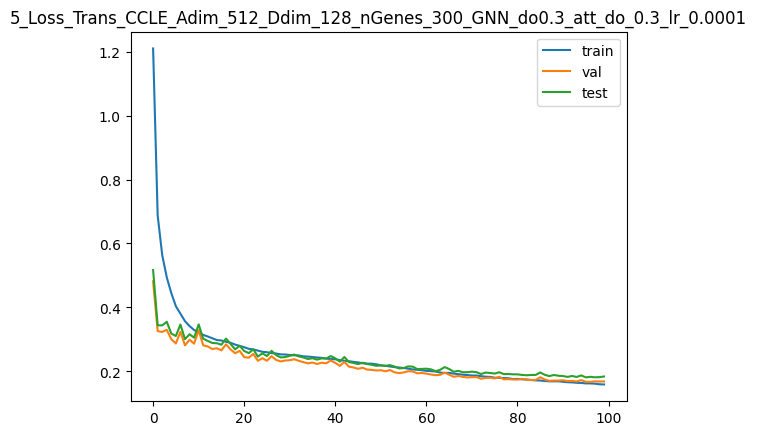

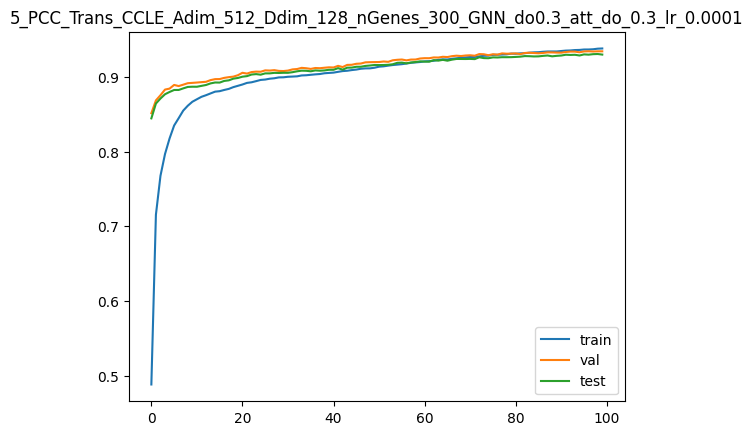

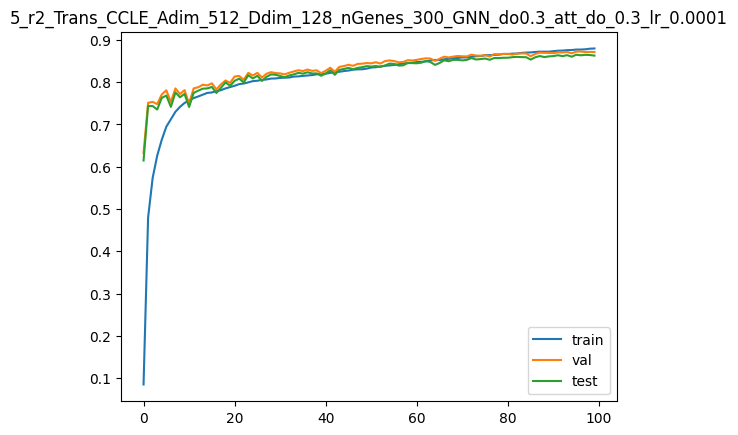

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23655983805656433
The overall Pearson's correlation is 0.9140.
Train avg_loss:  0.15992123
Train avg_pcc:  0.937587815279618
Train r2:  0.8790664372646285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16699137
Validation avg_pcc:  0.9344756030008987
Validation r2:  0.872618895750318
Best Val r2  0.872618895750318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17985344
Test avg_pcc:  0.9308481833104987
Test r2:  0.8659253703533637
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1684931516647339
The overall Pearson's correlation is 0.9316.
Train avg_loss:  0.15868631
Train avg_pcc:  0.938085965967182
Train r2:  0.8800002987641928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16828804
Validation avg_pcc:  0.9337307556885261
Validation r2:  0.8716298156140281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18055193
Test avg_pcc:  0.9302989812364023
Test r2:  0.8654046684130586
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1354522854089737
The overall Pearson's correlation is 0.9369.
Train avg_loss:  0.1577811
Train avg_pcc:  0.9384507462914915
Train r2:  0.8806848043742629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16870506
Validation avg_pcc:  0.9335396742992131
Validation r2:  0.8713116892586773


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17988569
Test avg_pcc:  0.9305412062519418
Test r2:  0.8659013362117476
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18691661953926086
The overall Pearson's correlation is 0.9250.
Train avg_loss:  0.15618262
Train avg_pcc:  0.9390933722056201
Train r2:  0.8818935959848175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.168665
Validation avg_pcc:  0.9337374300470801
Validation r2:  0.871342243443127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17951278
Test avg_pcc:  0.9307893368184362
Test r2:  0.8661793233350572
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.139891117811203
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.15708
Train avg_pcc:  0.938732883027542
Train r2:  0.8812149964131177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16925246
Validation avg_pcc:  0.9336341437754339
Validation r2:  0.8708941308701507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18110736
Test avg_pcc:  0.9306217286422834
Test r2:  0.8649906201114975
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14499472081661224
The overall Pearson's correlation is 0.9356.
Train avg_loss:  0.15566298
Train avg_pcc:  0.9393029665770243
Train r2:  0.8822865446908033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16772403
Validation avg_pcc:  0.9348327302666296
Validation r2:  0.8720600162678498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18072243
Test avg_pcc:  0.9316579323031621
Test r2:  0.8652775746834988
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14709261059761047
The overall Pearson's correlation is 0.9445.
Train avg_loss:  0.15491174
Train avg_pcc:  0.9396048753817458
Train r2:  0.8828546397782867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1680275
Validation avg_pcc:  0.9354123000758994
Validation r2:  0.8718285352411501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18345445
Test avg_pcc:  0.9311289535824177
Test r2:  0.8632409372340296
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1489480435848236
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.15505797
Train avg_pcc:  0.9395465608590192
Train r2:  0.8827440724622396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16523533
Validation avg_pcc:  0.9350666523529204
Validation r2:  0.8739584035010999
Best Val r2  0.8739584035010999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17923172
Test avg_pcc:  0.9312762437059159
Test r2:  0.8663888398680455
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12470132112503052
The overall Pearson's correlation is 0.9518.
Train avg_loss:  0.1535435
Train avg_pcc:  0.9401555280090008
Train r2:  0.8838893061316196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16485386
Validation avg_pcc:  0.9351995455272847
Validation r2:  0.8742494027053577
Best Val r2  0.8742494027053577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17963637
Test avg_pcc:  0.9307954887877455
Test r2:  0.866087181649973
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1593727320432663
The overall Pearson's correlation is 0.9413.
Train avg_loss:  0.15308261
Train avg_pcc:  0.9403413303421309
Train r2:  0.8842378426639073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1658487
Validation avg_pcc:  0.935192625600662
Validation r2:  0.8734905354956695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17901804
Test avg_pcc:  0.9315870869058442
Test r2:  0.8665481488514795
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15840965509414673
The overall Pearson's correlation is 0.9223.
Train avg_loss:  0.15225923
Train avg_pcc:  0.9406723466862197
Train r2:  0.8848604842990989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16363624
Validation avg_pcc:  0.9355551457886178
Validation r2:  0.8751781910478399
Best Val r2  0.8751781910478399


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17606431
Test avg_pcc:  0.9321177639481264
Test r2:  0.8687500365305602
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15465745329856873
The overall Pearson's correlation is 0.9398.
Train avg_loss:  0.15195738
Train avg_pcc:  0.9407933054440263
Train r2:  0.8850887497756272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16655056
Validation avg_pcc:  0.9345952320406063
Validation r2:  0.8729551572646698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1778537
Test avg_pcc:  0.9314074874780798
Test r2:  0.8674161087779233
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15904177725315094
The overall Pearson's correlation is 0.9283.
Train avg_loss:  0.15075508
Train avg_pcc:  0.9412766537464156
Train r2:  0.8859979352251797


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16539401
Validation avg_pcc:  0.9355083391903166
Validation r2:  0.8738373662522962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17842671
Test avg_pcc:  0.9320928140016715
Test r2:  0.8669889474796056
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1623459905385971
The overall Pearson's correlation is 0.9298.
Train avg_loss:  0.14970294
Train avg_pcc:  0.9416989178301658
Train r2:  0.8867935786661186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16607323
Validation avg_pcc:  0.9364089168867428
Validation r2:  0.873319251175621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18089738
Test avg_pcc:  0.9325887599432628
Test r2:  0.8651471406346445
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14468438923358917
The overall Pearson's correlation is 0.9442.
Train avg_loss:  0.15020695
Train avg_pcc:  0.9414966450602259
Train r2:  0.886412438211547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16437465
Validation avg_pcc:  0.9361750253554966
Validation r2:  0.8746149503206673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17892864
Test avg_pcc:  0.93209286944873
Test r2:  0.8666147773121676
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12137265503406525
The overall Pearson's correlation is 0.9520.
Train avg_loss:  0.1496122
Train avg_pcc:  0.9417355323867558
Train r2:  0.8868621810153869


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16661462
Validation avg_pcc:  0.9353291717313612
Validation r2:  0.872906287225447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.179267
Test avg_pcc:  0.9319173250410193
Test r2:  0.8663625401836039
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1940314918756485
The overall Pearson's correlation is 0.9325.
Train avg_loss:  0.1491888
Train avg_pcc:  0.9419060535754369
Train r2:  0.8871823842079154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16320874
Validation avg_pcc:  0.9356900069473923
Validation r2:  0.8755043015876827
Best Val r2  0.8755043015876827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17663528
Test avg_pcc:  0.9318772459139444
Test r2:  0.8683244079648635
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14367449283599854
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.14684393
Train avg_pcc:  0.9428462783133266
Train r2:  0.8889555807339498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16288392
Validation avg_pcc:  0.9360793192207605
Validation r2:  0.8757520646465213
Best Val r2  0.8757520646465213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17645745
Test avg_pcc:  0.9323720823484747
Test r2:  0.8684569700447492
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14389589428901672
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.14758961
Train avg_pcc:  0.9425469006684336
Train r2:  0.8883916747667835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16237459
Validation avg_pcc:  0.9363930175935018
Validation r2:  0.8761405774837902
Best Val r2  0.8761405774837902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17669839
Test avg_pcc:  0.9323514899127299
Test r2:  0.868277349666891
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11226631700992584
The overall Pearson's correlation is 0.9490.
Train avg_loss:  0.1467903
Train avg_pcc:  0.9428676527716795
Train r2:  0.8889961335950899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16322589
Validation avg_pcc:  0.9357496028269079
Validation r2:  0.8754912116880597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1769498
Test avg_pcc:  0.9317166339121108
Test r2:  0.8680899421163132
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10289518535137177
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.14606667
Train avg_pcc:  0.9431579936772836
Train r2:  0.8895433562918594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1587911
Validation avg_pcc:  0.9375329958375485
Validation r2:  0.8788740712185258
Best Val r2  0.8788740712185258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17343995
Test avg_pcc:  0.9331437433853106
Test r2:  0.8707064111901852
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1656550168991089
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.14571026
Train avg_pcc:  0.9433003345465173
Train r2:  0.8898128731668726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16727261
Validation avg_pcc:  0.9361217342292256
Validation r2:  0.8724043709979805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17946334
Test avg_pcc:  0.9328990387014832
Test r2:  0.866216185850869
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22165241837501526
The overall Pearson's correlation is 0.9312.
Train avg_loss:  0.14518258
Train avg_pcc:  0.9435120899655568
Train r2:  0.8902119031191245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16263595
Validation avg_pcc:  0.9362690464002831
Validation r2:  0.8759412129072599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17498732
Test avg_pcc:  0.9328381699742322
Test r2:  0.8695528919611892
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11445185542106628
The overall Pearson's correlation is 0.9539.
Train avg_loss:  0.14519422
Train avg_pcc:  0.9435074981509738
Train r2:  0.8902031058014007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16160202
Validation avg_pcc:  0.9366571475811496
Validation r2:  0.8767299053661692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1743368
Test avg_pcc:  0.9333522503338259
Test r2:  0.8700378379035708
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12046077102422714
The overall Pearson's correlation is 0.9523.
Train avg_loss:  0.14336842
Train avg_pcc:  0.9442388250173089
Train r2:  0.8915837865113906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15966293
Validation avg_pcc:  0.9371927500174878
Validation r2:  0.8782090279940596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17319773
Test avg_pcc:  0.9332212203730869
Test r2:  0.8708869751572548
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12430976331233978
The overall Pearson's correlation is 0.9431.
Train avg_loss:  0.14318097
Train avg_pcc:  0.9443142613464298
Train r2:  0.89172554915625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16329607
Validation avg_pcc:  0.9361696968101766
Validation r2:  0.8754376713276588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17637852
Test avg_pcc:  0.9325159580384139
Test r2:  0.8685158111473127
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1392037570476532
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.14275452
Train avg_pcc:  0.9444860036752937
Train r2:  0.8920480034669456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16157562
Validation avg_pcc:  0.9366851808750611
Validation r2:  0.876750036501841


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1739418
Test avg_pcc:  0.9332297563235598
Test r2:  0.8703322960431676
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14531190693378448
The overall Pearson's correlation is 0.9403.
Train avg_loss:  0.1425075
Train avg_pcc:  0.9445833200696439
Train r2:  0.8922348318787112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15771447
Validation avg_pcc:  0.9379544337839184
Validation r2:  0.8796953152387108
Best Val r2  0.8796953152387108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17220654
Test avg_pcc:  0.9337980077933231
Test r2:  0.8716258798079232
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1562376767396927
The overall Pearson's correlation is 0.9221.
Train avg_loss:  0.14207795
Train avg_pcc:  0.9447552104015534
Train r2:  0.8925596495743994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15651281
Validation avg_pcc:  0.9385443566983904
Validation r2:  0.880611962840095
Best Val r2  0.880611962840095


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17176104
Test avg_pcc:  0.9338183599966279
Test r2:  0.8719579912304518
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1205226257443428
The overall Pearson's correlation is 0.9578.
Train avg_loss:  0.14088877
Train avg_pcc:  0.9452308464754501
Train r2:  0.8934589072681639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15980291
Validation avg_pcc:  0.9378091926924781
Validation r2:  0.8781022528301912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17152052
Test avg_pcc:  0.9346984314149881
Test r2:  0.8721372907482716
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1322893649339676
The overall Pearson's correlation is 0.9540.
Train avg_loss:  0.14096074
Train avg_pcc:  0.9452030633134427
Train r2:  0.8934044893161835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15940133
Validation avg_pcc:  0.9374614440448491
Validation r2:  0.87840858121718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17215677
Test avg_pcc:  0.9339528713132098
Test r2:  0.8716629759866086
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15188008546829224
The overall Pearson's correlation is 0.9285.
Train avg_loss:  0.1405532
Train avg_pcc:  0.9453650165552494
Train r2:  0.893712666679639


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15873042
Validation avg_pcc:  0.9378011151811911
Validation r2:  0.8789203584903024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1728028
Test avg_pcc:  0.9339717307733832
Test r2:  0.871181392557707
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12793371081352234
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.13946186
Train avg_pcc:  0.9458022517227987
Train r2:  0.8945379492478184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16153754
Validation avg_pcc:  0.9369746157267844
Validation r2:  0.8767790788903094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17518589
Test avg_pcc:  0.9335645025273576
Test r2:  0.8694048685803124
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1681293249130249
The overall Pearson's correlation is 0.9311.
Train avg_loss:  0.13861069
Train avg_pcc:  0.9461411797211001
Train r2:  0.8951816069898366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16108222
Validation avg_pcc:  0.9367541283995303
Validation r2:  0.8771264005130442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17181884
Test avg_pcc:  0.9338544573463392
Test r2:  0.8719148867849348
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14839690923690796
The overall Pearson's correlation is 0.9574.
Train avg_loss:  0.13773921
Train avg_pcc:  0.946490729961388
Train r2:  0.8958406219369789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15768924
Validation avg_pcc:  0.9379873438250617
Validation r2:  0.8797145562920873


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17106502
Test avg_pcc:  0.9342025581951081
Test r2:  0.8724768546474064
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1162048727273941
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.13774209
Train avg_pcc:  0.9464893781735527
Train r2:  0.8958384664378138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15773527
Validation avg_pcc:  0.938506005946175
Validation r2:  0.8796794529825629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17101179
Test avg_pcc:  0.9350825879068445
Test r2:  0.8725165238180492
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12762150168418884
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.13757482
Train avg_pcc:  0.9465557073155787
Train r2:  0.8959649406169228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15872793
Validation avg_pcc:  0.9375167205088764
Validation r2:  0.8789222645958632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17187724
Test avg_pcc:  0.9338084225167936
Test r2:  0.8718713538260957
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1533885896205902
The overall Pearson's correlation is 0.9247.
Train avg_loss:  0.13607065
Train avg_pcc:  0.9471564658695062
Train r2:  0.8971024053741516


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15771905
Validation avg_pcc:  0.9380068124296036
Validation r2:  0.8796918256659101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1685454
Test avg_pcc:  0.9350730865669509
Test r2:  0.8743551406360258
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16449981927871704
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.13577624
Train avg_pcc:  0.9472744507453494
Train r2:  0.897325054885319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15825556
Validation avg_pcc:  0.9377524772390129
Validation r2:  0.8792825752498483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17036779
Test avg_pcc:  0.9345807943182833
Test r2:  0.872996588726314
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11934105306863785
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.13530388
Train avg_pcc:  0.9474620730398453
Train r2:  0.897682239730376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1586072
Validation avg_pcc:  0.9375928991421121
Validation r2:  0.8790143518844219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1710651
Test avg_pcc:  0.9343091738648652
Test r2:  0.8724767769709101
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10825000703334808
The overall Pearson's correlation is 0.9647.
Train avg_loss:  0.13575774
Train avg_pcc:  0.9472829094479511
Train r2:  0.8973390344712258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15682878
Validation avg_pcc:  0.9386924059351299
Validation r2:  0.880370927023848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17182481
Test avg_pcc:  0.9345503348205865
Test r2:  0.8719104514459786
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11995295435190201
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.13427658
Train avg_pcc:  0.9478717623567612
Train r2:  0.8984590914329036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15908676
Validation avg_pcc:  0.9374329477209353
Validation r2:  0.8786485362986186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17319588
Test avg_pcc:  0.9335310006397066
Test r2:  0.870888364528824
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18827934563159943
The overall Pearson's correlation is 0.9337.
Train avg_loss:  0.13441294
Train avg_pcc:  0.9478185176530682
Train r2:  0.8983559780211569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15711252
Validation avg_pcc:  0.938457529714412
Validation r2:  0.8801544927200754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16982298
Test avg_pcc:  0.9347188518083183
Test r2:  0.8734027362345356
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15708065032958984
The overall Pearson's correlation is 0.9209.
Train avg_loss:  0.13373554
Train avg_pcc:  0.9480882102062199
Train r2:  0.8988682382787698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15769027
Validation avg_pcc:  0.9379703975247726
Validation r2:  0.8797137745742909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16880238
Test avg_pcc:  0.9351469842235935
Test r2:  0.8741635637676447
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13641808927059174
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.13392258
Train avg_pcc:  0.948013527276069
Train r2:  0.8987268044382055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15716062
Validation avg_pcc:  0.9385490964044811
Validation r2:  0.8801178041812221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16838568
Test avg_pcc:  0.9357928950945137
Test r2:  0.8744741930142611
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15815630555152893
The overall Pearson's correlation is 0.9411.
Train avg_loss:  0.13354237
Train avg_pcc:  0.9481652592414145
Train r2:  0.8990143050173425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15589063
Validation avg_pcc:  0.9390386797609644
Validation r2:  0.8810865599790239
Best Val r2  0.8810865599790239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16846074
Test avg_pcc:  0.9356226528396417
Test r2:  0.874418244123816
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13507962226867676
The overall Pearson's correlation is 0.9313.
Train avg_loss:  0.13249424
Train avg_pcc:  0.9485833384104233
Train r2:  0.8998069100733198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15731055
Validation avg_pcc:  0.9384312519466772
Validation r2:  0.8800034373431953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17048742
Test avg_pcc:  0.9347749366071356
Test r2:  0.8729074134517701
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10850610584020615
The overall Pearson's correlation is 0.9472.
Train avg_loss:  0.13244021
Train avg_pcc:  0.9486049277638269
Train r2:  0.8998477884169824


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15557474
Validation avg_pcc:  0.9389617646042159
Validation r2:  0.8813275067832222
Best Val r2  0.8813275067832222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16889475
Test avg_pcc:  0.9349730838702317
Test r2:  0.8740947130725186
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1183331310749054
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.13173088
Train avg_pcc:  0.9488875005754369
Train r2:  0.9003841566472772


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15858142
Validation avg_pcc:  0.9382153855670569
Validation r2:  0.8790340197231141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16920973
Test avg_pcc:  0.9356143382470867
Test r2:  0.8738598899257466
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12829764187335968
The overall Pearson's correlation is 0.9498.
Train avg_loss:  0.13089262
Train avg_pcc:  0.9492215434837691
Train r2:  0.9010180673592894


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15739717
Validation avg_pcc:  0.9382549383364015
Validation r2:  0.8799373592109544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1689985
Test avg_pcc:  0.9352712757422367
Test r2:  0.8740173624003714


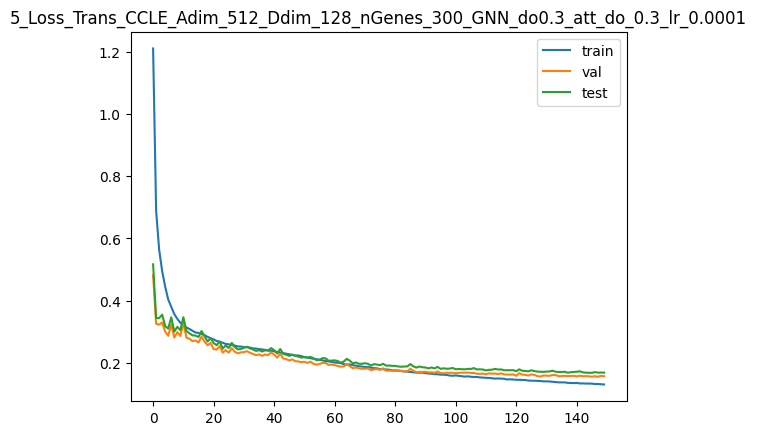

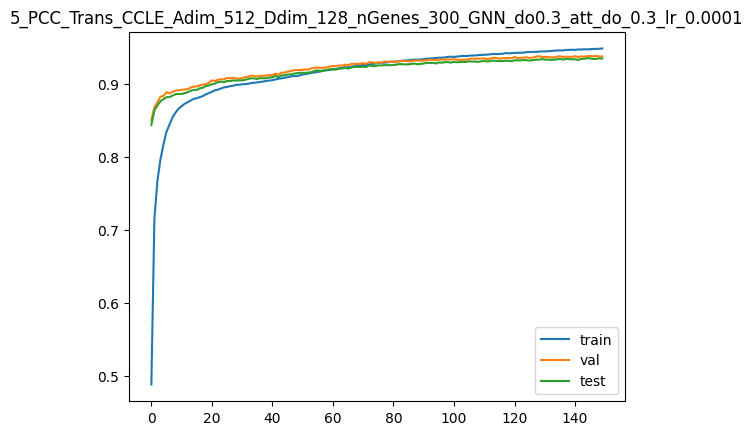

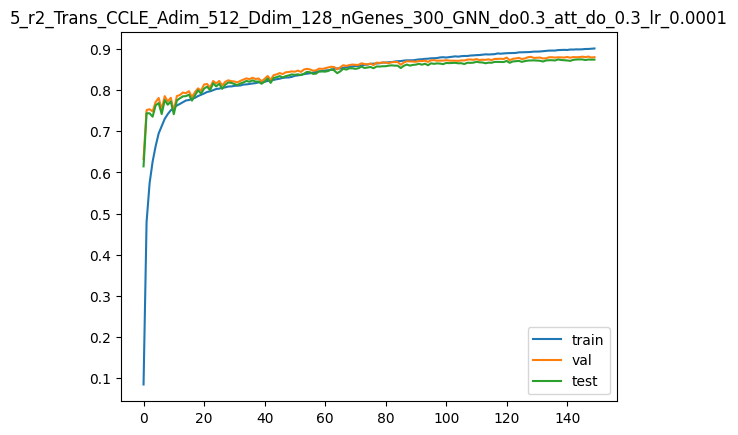

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13033340871334076
The overall Pearson's correlation is 0.9446.
Train avg_loss:  0.1307012
Train avg_pcc:  0.9492975470908676
Train r2:  0.9011628344234283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15693973
Validation avg_pcc:  0.9383650216577392
Validation r2:  0.8802863032178643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16742548
Test avg_pcc:  0.935647972129606
Test r2:  0.8751900048872601
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13316872715950012
The overall Pearson's correlation is 0.9463.
Train avg_loss:  0.1302544
Train avg_pcc:  0.9494760224918467
Train r2:  0.9015006907918448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15573967
Validation avg_pcc:  0.9388815772146287
Validation r2:  0.8812017094969626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1683352
Test avg_pcc:  0.9354077311568713
Test r2:  0.874511829082093
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1419523060321808
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.13065709
Train avg_pcc:  0.9493151376055428
Train r2:  0.9011961762696623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15562856
Validation avg_pcc:  0.9388356732063305
Validation r2:  0.8812864476651862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16587289
Test avg_pcc:  0.9362675808886138
Test r2:  0.8763474040104516
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10006387531757355
The overall Pearson's correlation is 0.9589.
Train avg_loss:  0.12970045
Train avg_pcc:  0.9496956791536654
Train r2:  0.9019195864025228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1548782
Validation avg_pcc:  0.9392055075353609
Validation r2:  0.8818588252314801
Best Val r2  0.8818588252314801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16621326
Test avg_pcc:  0.9360669148960388
Test r2:  0.8760936689883703
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15151387453079224
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.12909067
Train avg_pcc:  0.9499388490733194
Train r2:  0.902380730388653


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1567189
Validation avg_pcc:  0.939045257548796
Validation r2:  0.8804547402295175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16858736
Test avg_pcc:  0.9359123474397877
Test r2:  0.8743238608404593
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12112923711538315
The overall Pearson's correlation is 0.9558.
Train avg_loss:  0.12832105
Train avg_pcc:  0.9502459618327738
Train r2:  0.9029626937198514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15694085
Validation avg_pcc:  0.9387795547643376
Validation r2:  0.8802854382446496


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16983984
Test avg_pcc:  0.9356031757950484
Test r2:  0.8733901676627694
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13661524653434753
The overall Pearson's correlation is 0.9484.
Train avg_loss:  0.12833476
Train avg_pcc:  0.9502389427896979
Train r2:  0.9029523342156244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15413705
Validation avg_pcc:  0.9394972787322511
Validation r2:  0.8824241802817278
Best Val r2  0.8824241802817278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16735849
Test avg_pcc:  0.9359373890221134
Test r2:  0.8752399321124809
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16195650398731232
The overall Pearson's correlation is 0.9441.
Train avg_loss:  0.1277397
Train avg_pcc:  0.9504765230597739
Train r2:  0.9034023342285353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1545967
Validation avg_pcc:  0.9392590547215044
Validation r2:  0.8820735473583814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16695765
Test avg_pcc:  0.9358553795927124
Test r2:  0.8755387479704625
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21731367707252502
The overall Pearson's correlation is 0.9235.
Train avg_loss:  0.12725207
Train avg_pcc:  0.9506706214829054
Train r2:  0.9037710781081498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1541864
Validation avg_pcc:  0.9395600665464624
Validation r2:  0.8823865483224762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16724187
Test avg_pcc:  0.9361105414196178
Test r2:  0.8753268665933224
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13662460446357727
The overall Pearson's correlation is 0.9481.
Train avg_loss:  0.12673414
Train avg_pcc:  0.9508762039721981
Train r2:  0.904162741555012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15215346
Validation avg_pcc:  0.9402173608065305
Validation r2:  0.8839372768024686
Best Val r2  0.8839372768024686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16483936
Test avg_pcc:  0.9365994388711361
Test r2:  0.877117865294018
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1286347508430481
The overall Pearson's correlation is 0.9484.
Train avg_loss:  0.12576444
Train avg_pcc:  0.9512620843048775
Train r2:  0.9048960313115574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15501544
Validation avg_pcc:  0.9395717519038534
Validation r2:  0.8817541310178899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16952157
Test avg_pcc:  0.9356921255047251
Test r2:  0.873627424166694
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1312187761068344
The overall Pearson's correlation is 0.9535.
Train avg_loss:  0.12610292
Train avg_pcc:  0.9511268315889411
Train r2:  0.9046400747124753


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15460768
Validation avg_pcc:  0.9396605482446603
Validation r2:  0.8820651752134491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16594318
Test avg_pcc:  0.9368688794904987
Test r2:  0.8762950095561907
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13040956854820251
The overall Pearson's correlation is 0.9487.
Train avg_loss:  0.12653375
Train avg_pcc:  0.9509563364349511
Train r2:  0.9043142895295214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15260977
Validation avg_pcc:  0.940046699852334
Validation r2:  0.8835891838260763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1656467
Test avg_pcc:  0.936414645657395
Test r2:  0.8765160012188656
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11423154175281525
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.12536275
Train avg_pcc:  0.9514215341541484
Train r2:  0.9051997997103137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15019003
Validation avg_pcc:  0.9410408260842624
Validation r2:  0.8854349603425045
Best Val r2  0.8854349603425045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16454118
Test avg_pcc:  0.9367723298882094
Test r2:  0.8773401394166086
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13737183809280396
The overall Pearson's correlation is 0.9391.
Train avg_loss:  0.12464197
Train avg_pcc:  0.9517080436363017
Train r2:  0.9057448603915106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15109555
Validation avg_pcc:  0.9406160138854147
Validation r2:  0.8847442448108325


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16330935
Test avg_pcc:  0.9372224383796828
Test r2:  0.8782584179431268
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14322730898857117
The overall Pearson's correlation is 0.9425.
Train avg_loss:  0.12471478
Train avg_pcc:  0.9516783838778375
Train r2:  0.905689795988666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15106338
Validation avg_pcc:  0.9406531727003611
Validation r2:  0.8847687756003335


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1644334
Test avg_pcc:  0.9367346899463442
Test r2:  0.8774204814046582
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11106820404529572
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.12476374
Train avg_pcc:  0.9516596822868734
Train r2:  0.905652769943074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15090281
Validation avg_pcc:  0.9407030236619687
Validation r2:  0.8848912587960113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16574979
Test avg_pcc:  0.9362964836021994
Test r2:  0.8764391672548434
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10387326776981354
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.123307504
Train avg_pcc:  0.9522377245223892
Train r2:  0.9067539897947654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1526879
Validation avg_pcc:  0.9400054108923882
Validation r2:  0.8835295935340404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16403441
Test avg_pcc:  0.93689243274369
Test r2:  0.8777179210874901
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13043877482414246
The overall Pearson's correlation is 0.9574.
Train avg_loss:  0.12322424
Train avg_pcc:  0.9522713296321171
Train r2:  0.9068169442176958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15582937
Validation avg_pcc:  0.9394920681144252
Validation r2:  0.8811332864991075


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16833365
Test avg_pcc:  0.9363996148158026
Test r2:  0.8745129992908561
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12765562534332275
The overall Pearson's correlation is 0.9538.
Train avg_loss:  0.123078205
Train avg_pcc:  0.9523283492732335
Train r2:  0.9069273780661175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15189125
Validation avg_pcc:  0.9404530092841439
Validation r2:  0.8841372789322393


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16441157
Test avg_pcc:  0.9370535661543761
Test r2:  0.8774367565364477
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11690840125083923
The overall Pearson's correlation is 0.9501.
Train avg_loss:  0.123300225
Train avg_pcc:  0.9522412576684895
Train r2:  0.9067594982591972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.152052
Validation avg_pcc:  0.9402648709922787
Validation r2:  0.8840146618609384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16308813
Test avg_pcc:  0.937269979832571
Test r2:  0.8784233367407217
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13971443474292755
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.12272287
Train avg_pcc:  0.9524699508718487
Train r2:  0.907196093764803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15190324
Validation avg_pcc:  0.9404742742841604
Validation r2:  0.8841281280185284


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16545467
Test avg_pcc:  0.9365610472560174
Test r2:  0.8766591610933823
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1152154803276062
The overall Pearson's correlation is 0.9650.
Train avg_loss:  0.121639565
Train avg_pcc:  0.9528997248513933
Train r2:  0.9080152970764837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15182772
Validation avg_pcc:  0.9404486136769407
Validation r2:  0.8841857310924264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16339612
Test avg_pcc:  0.937148508547692
Test r2:  0.8781937456342934
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10173148661851883
The overall Pearson's correlation is 0.9573.
Train avg_loss:  0.12222518
Train avg_pcc:  0.9526672954012638
Train r2:  0.9075724569692898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15250428
Validation avg_pcc:  0.9406799748721535
Validation r2:  0.8836696587561936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16389771
Test avg_pcc:  0.9372593333123375
Test r2:  0.8778198361205847
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11180610954761505
The overall Pearson's correlation is 0.9594.
Train avg_loss:  0.120481595
Train avg_pcc:  0.9533599045114307
Train r2:  0.9088909664523042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15143213
Validation avg_pcc:  0.9406392866081653
Validation r2:  0.884487500292544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16333173
Test avg_pcc:  0.9371776810738861
Test r2:  0.8782417399880051
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1192588359117508
The overall Pearson's correlation is 0.9624.
Train avg_loss:  0.121163644
Train avg_pcc:  0.9530882786479145
Train r2:  0.9083751847472638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.153488
Validation avg_pcc:  0.9408804434335143
Validation r2:  0.8829192769650722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16504759
Test avg_pcc:  0.9376806167606734
Test r2:  0.8769626230292825
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17071473598480225
The overall Pearson's correlation is 0.9472.
Train avg_loss:  0.12139828
Train avg_pcc:  0.9529955480690768
Train r2:  0.9081977593791845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15276101
Validation avg_pcc:  0.9408310158072742
Validation r2:  0.8834738197605294


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16556118
Test avg_pcc:  0.9372229738786502
Test r2:  0.8765797657819505
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12902158498764038
The overall Pearson's correlation is 0.9455.
Train avg_loss:  0.12018189
Train avg_pcc:  0.9534780394119582
Train r2:  0.9091176006745093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15056816
Validation avg_pcc:  0.9410477535907364
Validation r2:  0.8851465249245556


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16337653
Test avg_pcc:  0.9375411180704254
Test r2:  0.8782083543579626
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10025621950626373
The overall Pearson's correlation is 0.9530.
Train avg_loss:  0.11953922
Train avg_pcc:  0.9537326519752736
Train r2:  0.9096035948271508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15279748
Validation avg_pcc:  0.9406540692502041
Validation r2:  0.8834460063089637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16519776
Test avg_pcc:  0.9370275101435072
Test r2:  0.8768506861497875
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10639956593513489
The overall Pearson's correlation is 0.9590.
Train avg_loss:  0.11946215
Train avg_pcc:  0.9537632493748786
Train r2:  0.909661869196945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15110618
Validation avg_pcc:  0.9410312114390814
Validation r2:  0.8847361287801842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16548409
Test avg_pcc:  0.9367661701260348
Test r2:  0.8766372362208679
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13115671277046204
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.11957448
Train avg_pcc:  0.9537187101368673
Train r2:  0.90957693537258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1507699
Validation avg_pcc:  0.9407661911342917
Validation r2:  0.8849926510059405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16247965
Test avg_pcc:  0.9376715055930871
Test r2:  0.8788769445689204
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13723872601985931
The overall Pearson's correlation is 0.9515.
Train avg_loss:  0.11929997
Train avg_pcc:  0.9538279451777276
Train r2:  0.909784516458009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15105005
Validation avg_pcc:  0.941149045831481
Validation r2:  0.8847789564524158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16351216
Test avg_pcc:  0.937723918730029
Test r2:  0.8781072528372835
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12745070457458496
The overall Pearson's correlation is 0.9632.
Train avg_loss:  0.118444294
Train avg_pcc:  0.9541664286802295
Train r2:  0.9104315813926948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15174519
Validation avg_pcc:  0.9405016760606179
Validation r2:  0.8842486988016356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16378275
Test avg_pcc:  0.9372770073907039
Test r2:  0.8779055265361743
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10557974874973297
The overall Pearson's correlation is 0.9665.
Train avg_loss:  0.11807939
Train avg_pcc:  0.9543117301576589
Train r2:  0.9107075231324415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15073608
Validation avg_pcc:  0.9409889483534752
Validation r2:  0.8850184387549362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1644905
Test avg_pcc:  0.9367983962278545
Test r2:  0.8773779105519398
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12525230646133423
The overall Pearson's correlation is 0.9478.
Train avg_loss:  0.11791385
Train avg_pcc:  0.954376742192417
Train r2:  0.9108327029242965


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15117183
Validation avg_pcc:  0.9408159136834464
Validation r2:  0.8846860424551591


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16377696
Test avg_pcc:  0.9372936719225199
Test r2:  0.8779098264916898
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10855570435523987
The overall Pearson's correlation is 0.9672.
Train avg_loss:  0.11811993
Train avg_pcc:  0.9542965554687771
Train r2:  0.9106768713238572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1514033
Validation avg_pcc:  0.9411114871740628
Validation r2:  0.8845094793214733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16619882
Test avg_pcc:  0.9364920257193353
Test r2:  0.876104422186468
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10915151983499527
The overall Pearson's correlation is 0.9622.
Train avg_loss:  0.11786951
Train avg_pcc:  0.9543944964711836
Train r2:  0.9108662417785827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15090862
Validation avg_pcc:  0.9408885109820266
Validation r2:  0.8848868300333712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16255212
Test avg_pcc:  0.9379364892994955
Test r2:  0.8788229231050381
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10357363522052765
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.117119394
Train avg_pcc:  0.9546914504021571
Train r2:  0.9114334772327995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15190507
Validation avg_pcc:  0.9406938569307388
Validation r2:  0.884126728836113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1635429
Test avg_pcc:  0.9375562163883886
Test r2:  0.8780843219658521
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15013977885246277
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.11667378
Train avg_pcc:  0.9548680355463255
Train r2:  0.9117704517265026


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15442684
Validation avg_pcc:  0.9405585288498111
Validation r2:  0.8822031218330482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16522656
Test avg_pcc:  0.9373622507560804
Test r2:  0.8768292120729044
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1380579173564911
The overall Pearson's correlation is 0.9364.
Train avg_loss:  0.11624152
Train avg_pcc:  0.9550394579330863
Train r2:  0.912097335069707


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15357304
Validation avg_pcc:  0.9406057356412312
Validation r2:  0.8828544056217534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.165933
Test avg_pcc:  0.9374700751309677
Test r2:  0.8763025813362871
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1336650550365448
The overall Pearson's correlation is 0.9557.
Train avg_loss:  0.11590379
Train avg_pcc:  0.9551723731601054
Train r2:  0.9123527404594448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15137382
Validation avg_pcc:  0.9406943542999027
Validation r2:  0.8845319766648644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16322178
Test avg_pcc:  0.9372727998066728
Test r2:  0.8783237138476159
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16145473718643188
The overall Pearson's correlation is 0.9458.
Train avg_loss:  0.1158207
Train avg_pcc:  0.955206005749444
Train r2:  0.9124155631947376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14881632
Validation avg_pcc:  0.9415667807424161
Validation r2:  0.8864828422800023
Best Val r2  0.8864828422800023


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16185842
Test avg_pcc:  0.9378538720444387
Test r2:  0.8793400483773074
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09516662359237671
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.11516199
Train avg_pcc:  0.9554664226044634
Train r2:  0.9129136834606447


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15113382
Validation avg_pcc:  0.9406255024993064
Validation r2:  0.8847150467546411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1645409
Test avg_pcc:  0.9367647850969857
Test r2:  0.877340359471729
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10195381939411163
The overall Pearson's correlation is 0.9695.
Train avg_loss:  0.115100116
Train avg_pcc:  0.9554915839870741
Train r2:  0.9129604715824743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15225805
Validation avg_pcc:  0.9401965102885032
Validation r2:  0.883857467398627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1634708
Test avg_pcc:  0.9373496701827329
Test r2:  0.8781380806294455
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11329151690006256
The overall Pearson's correlation is 0.9588.
Train avg_loss:  0.11429192
Train avg_pcc:  0.9558104922407945
Train r2:  0.9135716390248756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15064827
Validation avg_pcc:  0.9410678601904702
Validation r2:  0.8850854258323034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16130671
Test avg_pcc:  0.9381524799804015
Test r2:  0.8797513233891651
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15313464403152466
The overall Pearson's correlation is 0.9435.
Train avg_loss:  0.11416493
Train avg_pcc:  0.9558609393368804
Train r2:  0.9136676688180142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15031128
Validation avg_pcc:  0.9412390955217075
Validation r2:  0.885342490600432


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16292216
Test avg_pcc:  0.9378942309422129
Test r2:  0.8785470615893729
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12001193314790726
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.11350999
Train avg_pcc:  0.9561203080365807
Train r2:  0.9141629447869339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1503985
Validation avg_pcc:  0.941305318141276
Validation r2:  0.8852759441535396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16418901
Test avg_pcc:  0.9373688794997797
Test r2:  0.8776026654112007
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13421857357025146
The overall Pearson's correlation is 0.9564.
Train avg_loss:  0.11427138
Train avg_pcc:  0.9558190206411502
Train r2:  0.9135871771601837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14940594
Validation avg_pcc:  0.9413817415244328
Validation r2:  0.8860330606685938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16410956
Test avg_pcc:  0.9371359023228982
Test r2:  0.8776619125258753
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1214737743139267
The overall Pearson's correlation is 0.9450.
Train avg_loss:  0.113644585
Train avg_pcc:  0.9560668507828912
Train r2:  0.9140611579351826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1488203
Validation avg_pcc:  0.9416948174525968
Validation r2:  0.8864798080857348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16259776
Test avg_pcc:  0.9374519748506572
Test r2:  0.878788893993714
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_512_Ddim_128_nGenes_300_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13304120302200317
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.11250702
Train avg_pcc:  0.9565162414762661
Train r2:  0.9149213935265582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.14843528
Validation avg_pcc:  0.9416997124301014
Validation r2:  0.8867734775525646
Best Val r2  0.8867734775525646


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.160983
Test avg_pcc:  0.9381077024717388
Test r2:  0.8799926501241192


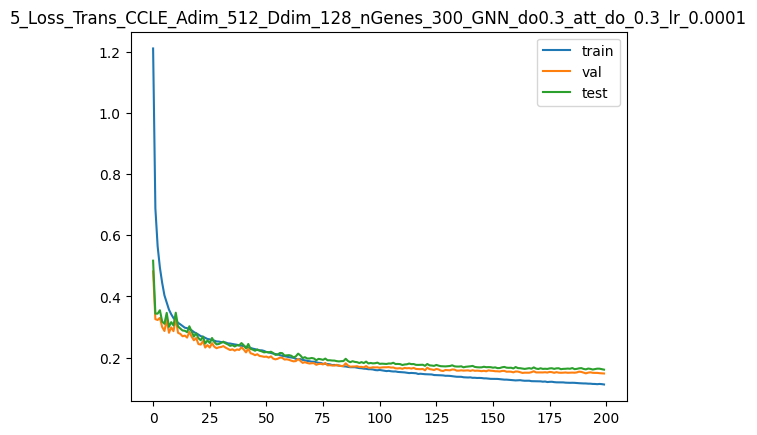

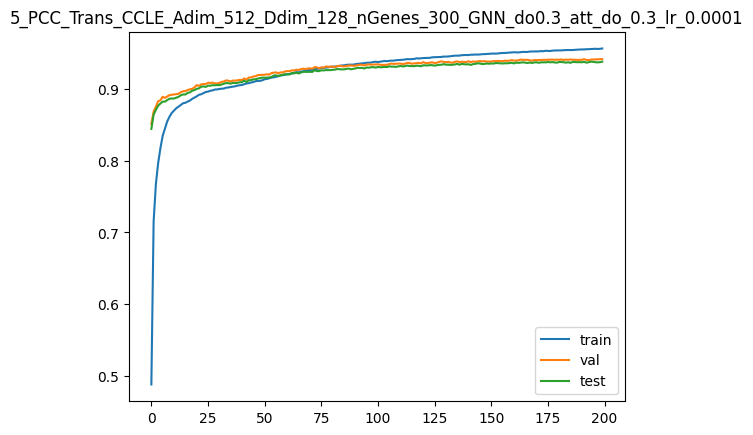

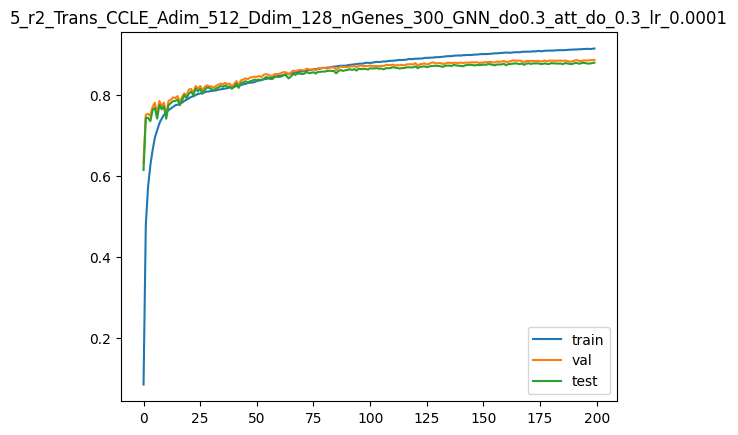

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.160983
Test avg_pcc:  0.9381077016600715
Test r2:  0.8799926504375333


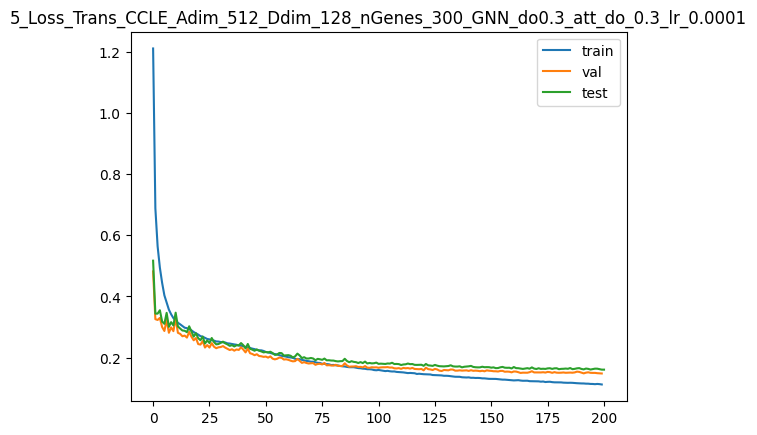

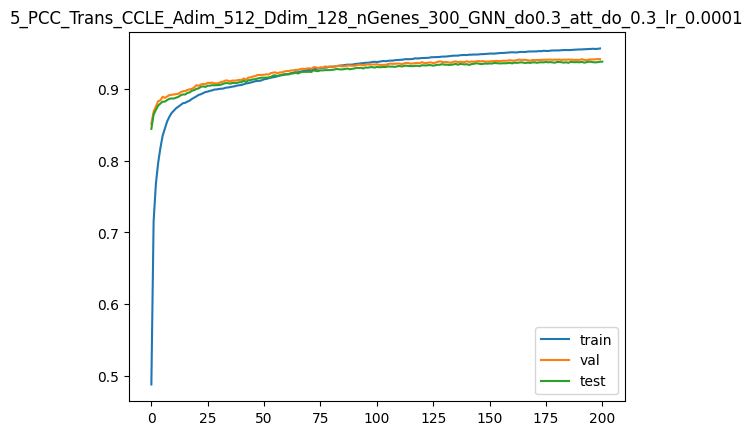

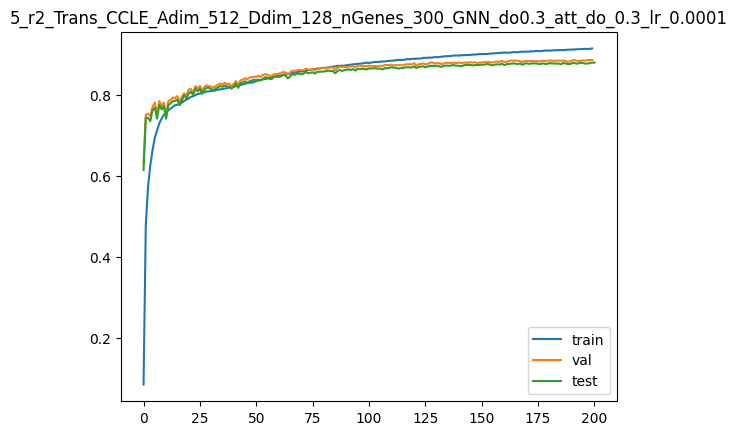

: 

In [31]:

all_samples =  gexpr_feature.index

save_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/concatenate/att512/weights/'
img_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/concatenate/att512/imgs/'
result_path = "/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/concatenate/att512/results/"

total_train_pcc = []
total_val_pcc = []
total_test_pcc = []
total_train_r2 = []
total_val_r2 = []
total_test_r2 = []
total_train_losses = []
total_test_losses = []
total_val_losses = []

from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2)

split1 = ss.split(input_df_gexpr)
split2 = ss.split(input_df_gexpr)

fold = 0
for train2_index, test2_index in split2:
    fold += 1

    train2_index, val2_index = train_test_split(train2_index, test_size=0.05)
    train_df_gexpr = input_df_gexpr.iloc[train2_index].reset_index(drop=True)
    val_df_gexpr = input_df_gexpr.iloc[val2_index].reset_index(drop=True)
    test_df_gexpr = input_df_gexpr.iloc[test2_index].reset_index(drop=True)
    train_df_methyl = input_df_methyl.iloc[train2_index].reset_index(drop=True)
    val_df_methyl = input_df_methyl.iloc[val2_index].reset_index(drop=True)
    test_df_methyl = input_df_methyl.iloc[test2_index].reset_index(drop=True)


    train_dataloader = get_gnn_dataloader(train_df_gexpr,train_df_methyl, batch_size=batch_size)
    validation_dataloader = get_gnn_dataloader(val_df_gexpr,val_df_methyl, batch_size=batch_size)
    test_dataloader = get_gnn_dataloader(test_df_gexpr, test_df_methyl,batch_size=batch_size)

    gene_embedding = Gene_Embedding(vocab_size= vocab_size,embed_size=embed_size)

    gnn = GNN_drug(layer_drug = layer_drug, dim_drug = dim_drug, do = gnn_dropout)

    cell_encoder = Co_Att_Encoder(genes = nGenes, x_dim= embed_size, y_dim = att_dim,
                                        dropout = att_dropout, encoder = C_EnC)

    drug_encoder = Co_Att_Encoder(genes = nGenes, x_dim= nhid, y_dim = att_dim,
                                        dropout = att_dropout, encoder = D_EnC)


    encoder = Main_Encoder(cell_encoder = cell_encoder, d_dim = nhid,
                            genes=nGenes, y_dim=att_dim, dropout = att_dropout)

    model = GEN(y_dim = att_dim*2, dropout_ratio = fc_dropout,
                gnn = gnn, embedding = gene_embedding, encoder = encoder)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.0001
    mse = nn.MSELoss()

    train_pcc = []
    val_pcc = []
    test_pcc = []

    train_r2 = []
    val_r2 = []
    test_r2 = []

    best_pcc = 0
    train_loss = []
    test_loss = []
    val_loss = []
    for ep in range(nb_epoch):
        true_Y = []
        pred_Y = []


        model.train()
        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(train_dataloader):
            if len(y) >1:
                optimizer.zero_grad()

                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)

                loss = mse(pred_y.view(-1),y)

                loss.backward()
                optimizer.step()

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

            if (step+1) %500 ==0:
                print(title)
                print("training step: ", step)
                print("step_training loss: ", loss.item())
                overall_pcc = pearsonr(pred_y,y)[0]
                print("The overall Pearson's correlation is %.4f."%overall_pcc)

        loss_train = mean_squared_error(true_Y, pred_Y)
        pcc_train = pearsonr(true_Y, pred_Y)[0]
        r2_train = r2_score(true_Y, pred_Y)
        print("Train avg_loss: ", loss_train)
        print("Train avg_pcc: ", pcc_train)
        print("Train r2: ", r2_train)

        train_pcc.append(pcc_train)
        train_loss.append(loss_train)
        train_r2.append(r2_train)

        total_val_loss = 0.
        sum_pcc = 0.
        true_Y = []
        pred_Y = []

        model.eval()
        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(validation_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)

                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

                total_val_loss += loss.item()


        loss_val = mean_squared_error(true_Y, pred_Y)
        pcc_val = pearsonr(true_Y, pred_Y)[0]
        r2_val = r2_score(true_Y, pred_Y)

        print("Validation avg_loss: ", loss_val)
        print("Validation avg_pcc: ", pcc_val)
        print("Validation r2: ", r2_val)
        val_loss.append(loss_val)
        val_pcc.append(pcc_val)
        val_r2.append(r2_val)

        if best_pcc < val_r2[-1]:
            best_pcc = val_r2[-1]
            torch.save(model.state_dict(),save_path+title+'.pt')
            print('Best Val r2 ', best_pcc)

        true_Y = []
        pred_Y = []

        model.eval()

        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(test_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)
                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

        loss_test = mean_squared_error(true_Y, pred_Y)
        pcc_test = pearsonr(true_Y, pred_Y)[0]
        r2_test = r2_score(true_Y, pred_Y)

        print("Test avg_loss: ", loss_test)
        print("Test avg_pcc: ", pcc_test)
        print("Test r2: ", r2_test)

        test_pcc.append(pcc_test)
        test_loss.append(loss_test)
        test_r2.append(r2_test)

        if (ep+1) %50 ==0:
            input_title = str(fold)+'_Loss_'+title
            show_picture(train_loss,val_loss, test_loss, input_title)
            input_title = str(fold)+'_PCC_'+title
            show_picture(train_pcc,val_pcc, test_pcc, input_title)
            input_title = str(fold)+'_r2_'+title
            show_picture(train_r2,val_r2, test_r2, input_title)


        print("#################### epoch ############################ ",ep)

    model.load_state_dict(torch.load(save_path+title+'.pt'))
    torch.save(model.state_dict(), save_path+title+'_final.pt')
    true_Y = []
    pred_Y = []

    model.eval()

    for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(test_dataloader):
        if len(y) >1:
            x_drug = x_drug.to(device)
            x_gexpr = x_gexpr.to(device)
            x_genes_gexpr = x_genes_gexpr.to(device)
            x_methyl = x_methyl.to(device)
            x_genes_methyl = x_genes_methyl.to(device)
            y = y.to(device).float()

            pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)
            loss = mse(pred_y.view(-1),y)

            pred_y = pred_y.view(-1).detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            true_Y += list(y)
            pred_Y += list(pred_y)


    loss_test = mean_squared_error(true_Y, pred_Y)
    pcc_test = pearsonr(true_Y, pred_Y)[0]
    r2_test = r2_score(true_Y, pred_Y)

    print("Test avg_loss: ", loss_test)
    print("Test avg_pcc: ", pcc_test)
    print("Test r2: ", r2_test)

    test_pcc.append(pcc_test)
    test_loss.append(loss_test)
    test_r2.append(r2_test)

    input_title = str(fold)+'_Loss_'+title
    show_picture(train_loss,val_loss, test_loss, input_title,path=img_path, save=True)
    input_title = str(fold)+'_PCC_'+title
    show_picture(train_pcc,val_pcc, test_pcc, input_title,path=img_path, save=True)
    input_title = str(fold)+'_r2_'+title
    show_picture(train_r2,val_r2, test_r2, input_title,path=img_path, save=True)

    total_train_pcc.append(train_pcc)
    total_val_pcc.append(val_pcc)

    total_train_r2.append(train_r2)
    total_val_r2.append(val_r2)

    total_train_losses.append(train_loss)
    total_val_losses.append(val_loss)

    total_test_pcc.append(pcc_test)
    total_test_r2.append(r2_test)
    total_test_losses.append(loss_test)

    df_test_pcc = pd.DataFrame(data = total_test_pcc)
    df_test_r2 = pd.DataFrame(data = total_test_r2)

    df_test_losses = pd.DataFrame(data = total_test_losses)

    df_test_pcc.to_csv(result_path+title+'_pcc.csv')
    df_test_r2.to_csv(result_path+title+'_r2.csv')

    df_test_losses.to_csv(result_path+title+'_loss.csv')